In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-leav9qxm
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-leav9qxm
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=5c26e85817d8902f09dcaddb9dcf8275929f3e9995f149db2fd5664b5dad0279
  Stored in directory: /tmp/pip-ephem-wheel-cache-28fe4gxw/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
%matplotlib inline
import keras
from keras.optimizers import Adam
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU, Dropout, Activation, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose
import cv2
import re
import datetime
import skimage
import scipy # 
import keras_contrib
from glob import glob
from IPython.display import Image
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from random import random

from keras.initializers import RandomNormal


tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [0]:
class DataLoader():
    def __init__(self, img_res=(256, 256)):
        self.img_res = img_res
        _URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

        path_to_zip = tf.keras.utils.get_file('facades.tar.gz',origin=_URL,extract=True)

        self.PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

    
    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path=os.path.join(self.PATH,'train') if not is_testing else os.path.join(self.PATH,'test')
        train_path = glob('%s/*.jpg' %(path))
#         label_path = glob('%s/*.png' %(data_path))
        batch_images = np.random.choice(train_path, size=batch_size)


        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = img_A = cv2.imread(img_path).astype(np.float)

            h, w, _ = img.shape
            _w = int(w/2)
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]
#             h, w, _ = img.shape
#             _w = int(w/2)
#             img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            img_A = cv2.resize(img_A, self.img_res)
            img_B = cv2.resize(img_B, self.img_res)

            # If training => do random flip
            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        data_path=os.path.join(self.PATH,'train')
        train_path = glob('%s/*.jpg' %(data_path))

        self.n_batches = int(len(train_path) / batch_size)

        for i in range(self.n_batches-1):
            batch = train_path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = img_A = cv2.imread(img).astype(np.float)

                h, w, _ = img.shape
                _w = int(w/2)
                img_A, img_B = img[:, :_w, :], img[:, _w:, :]

                img_A = cv2.resize(img_A, self.img_res)
                img_B = cv2.resize(img_B, self.img_res)
                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

In [0]:
class cygan():
    def __init__(self):
        #input shape
        self.img_rows = 256
        self.channels = 3
        self.img_shape = (self.img_rows,self.img_rows,self.channels)
        self.resnet_block_num = 9
        self.batch_size=1
        self.losses = [[]]
        #output of PatchGAN
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)
        
        #data loader
        self.loader = DataLoader()

        #lossweights
        self.lambda_cycleloss = 10
        self.lamba_idloss = 0.1*self.lambda_cycleloss
        
        #optimizer
        opti = Adam(0.0002,0.5)
        
        #building and compiling the discriminators
        self.d_1 = self.discriminator()
        self.d_1.compile(loss = 'mse',optimizer = opti,metrics = ['accuracy'])
        self.d_2 = self.discriminator()
        self.d_2.compile(loss = 'mse',optimizer = opti,metrics = ['accuracy'])
        #building the generators
        self.g_1 = self.generator()
        self.g_2 = self.generator()
        #input image
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)
        
        fake_B = self.g_1(img_A)
        cycle_A = self.g_2(fake_B)
        fake_A = self.g_2(img_B)
        cycle_B = self.g_1(fake_A)
        self.d_1.trainable = False
        self.d_2.trainable = False
        
        valid_A = self.d_2(fake_A)
        valid_B = self.d_1(fake_B)
        
        self.combined = Model([img_A,img_B],[valid_A,valid_B,cycle_A,cycle_B])
        self.combined.compile(loss=['mse','mse','mae','mae'],loss_weights=[1,1,self.lambda_cycleloss,self.lambda_cycleloss],optimizer = opti)
    
    #defining the generator with three components - encoder, resnet block, decoder
    def generator(self):
        
        def resnet_block(kernel, input_layer):
            init = RandomNormal(stddev=0.02)
            model = Conv2D(kernel, kernel_size=(3,3),padding='same',kernel_initializer=init)(input_layer)
            model = InstanceNormalization(axis=-1)(model)
            model = Activation('relu')(model)
            model = Conv2D(kernel, kernel_size=(3,3),padding='same',kernel_initializer=init)(model)
            model = InstanceNormalization(axis=-1)(model)
            model = Concatenate()([model,input_layer])
            return model    

        
        #c7s1-64
        init = RandomNormal(stddev=0.02)
        input_layer = Input(shape = self.img_shape)
        model = Conv2D(64, kernel_size=(7,7),strides=(1,1),padding='same',kernel_initializer=init)(input_layer)
        model = InstanceNormalization(axis=-1)(model)
        model = Activation('relu')(model)
        #d128
        model = Conv2D(128, kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer=init)(model)
        model = InstanceNormalization(axis=-1)(model)
        model = Activation('relu')(model)
        #d256
        model = Conv2D(256, kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer=init)(model)
        model = InstanceNormalization(axis=-1)(model)
        model = Activation('relu')(model)
        #R256
        for resnet in range(self.resnet_block_num):
            model = resnet_block(256,model)
        #u128
        model = Conv2DTranspose(128, kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer=init)(model)
        model = InstanceNormalization(axis=-1)(model)
        model = Activation('relu')(model)
        #u64
        model = Conv2DTranspose(64, kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer=init)(model)
        model = InstanceNormalization(axis=-1)(model)
        model = Activation('relu')(model)
        #c7s1-3
        model = Conv2D(3, kernel_size=(7,7),strides=(1,1),padding='same',kernel_initializer=init)(model)
        model = InstanceNormalization(axis=-1)(model)
        out_img = Activation('relu')(model)

        return Model(input_layer,out_img)
    
    #discriminator is Patch GAN architecture same as Pix2Pix
    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02, seed=123)

        def single_layer(input_img, filters, filter_size = 4, batch_norm = True, kern_init = init):
            """layer in the discriminator"""
            model = Conv2D(filters, filter_size,strides = 2,padding ='same',kernel_initializer=kern_init)(input_img)
            if batch_norm:
                model = InstanceNormalization(axis=-1)(model)
            model = LeakyReLU(alpha=0.2)(model)
            return model

        i = Input(shape = self.img_shape)

    #         Concatenating image and label image


        l1 = single_layer(i,64,batch_norm = False)
        l2 = single_layer(l1,128,)
        l3 = single_layer(l2,256)
        l4 = single_layer(l3,512)

        l5 = Conv2D(1,(4,4),strides = 1,padding = 'same',activation = 'sigmoid')(l4)
        return Model(i,l5)

    
    def train(self,lambda_val = 10, epochs = 100,batch_size = 1, sample_interval = 50):
        self.lambda_cycleloss = lambda_val
        start_time = datetime.datetime.now()
        valid=np.ones((batch_size,)+self.disc_patch)
        fake=np.zeros((batch_size,)+self.disc_patch)

        for epoch in range(epochs):
    #         start=time.time()
            for batch_i, (imgA,imgB) in enumerate(self.loader.load_batch(batch_size)):
                fakeA = self.g_2.predict(imgB)
                fakeB = self.g_1.predict(imgA)
                
                d_1_real_loss = self.d_1.train_on_batch(imgB,valid)
                d_1_fake_loss = self.d_1.train_on_batch(fakeB,fake)
                d_1_loss = 0.5 *np.add(d_1_real_loss,d_1_fake_loss)
                
                d_2_real_loss = self.d_2.train_on_batch(imgA,valid)
                d_2_fake_loss = self.d_2.train_on_batch(fakeA,fake)
                d_2_loss = 0.5 *np.add(d_2_real_loss,d_2_fake_loss)
                
                d_total_loss = 0.5*np.add(d_1_loss,d_2_loss)
                
                g_loss = self.combined.train_on_batch([imgA, imgB], [valid,valid, imgA,imgB])
                elapsed_time = datetime.datetime.now()-start_time
                print("Epoch - %d, Batch - %d, D_loss %f acc %3d%%, (G_loss %f, adv_loss %f, cycle_loss %f) , time %s" %(epoch,batch_i, d_total_loss[0], d_total_loss[1]*100, g_loss[0],np.mean(g_loss[1:3]),np.mean(g_loss[3:5]),elapsed_time))
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)
                if batch_i == 350:
                    self.losses.append((epoch,d_total_loss[0],g_loss[0],np.mean(g_loss[1:3]),np.mean(g_loss[3:5])))
                
#         save_models(epoch)
        
    def sample_images(self, epoch, batch_i):
        os.makedirs('cycleganimages/', exist_ok=True)
        r, c = 2, 3

        imgs_A, imgs_B = self.loader.load_data(batch_size=1, is_testing=True)
        fake_A = self.g_2.predict(imgs_B)
        fake_B = self.g_1.predict(imgs_A)
        cycle_A = self.g_2.predict(fake_B)
        cycle_B = self.g_1.predict(fake_A)
        gen_imgs = np.concatenate([imgs_B, fake_A,cycle_B, imgs_A,fake_B,cycle_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("cycleganimages/lambda_%d_%d_%d.png" % (self.lambda_cycleloss,epoch, batch_i))
        plt.close()
        
#     def save_models(self,epoch):
#         filename1 = 'g_model_AtoB_%06d.h5' % (epoch+1)
#         self.g_1.save(filename1)
#         # save the second generator model
#         filename2 = 'g_model_BtoA_%06d.h5' % (epoch+1)
#         self.g_2.save(filename2)
#         print('>Saved: %s and %s' % (filename1, filename2))
    
    def show_losses(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot(losses[1],losses[0], label='Discriminator')
        plt.plot(losses[2],losses[0], label='Generator')
        plt.title("Training Losses")
        plt.xlabel("Losses")
        plt.ylabel("Epoch")
        plt.legend()
        fig.savefig("cycleganimages/lambda_%d_Loss.png" %(self.lambda_cycleloss))
        
        plt.show()
  
    def show_glosses(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot(losses[2],losses[0], label='Total Generator Loss')
        plt.plot(losses[3],losses[0], label='Adversarial Loss')
        plt.plot(losses[4],losses[0], label='Cycle Consistency Loss')
        plt.title("Training Losses")
        plt.xlabel("Losses")
        plt.ylabel("Epoch")
        
        plt.legend()
        fig.savefig("cycleganimages/lambda_%d_GLoss.png" %(self.lambda_cycleloss))
        
        plt.show()

In [0]:
cycleGAN.losses.remove([])


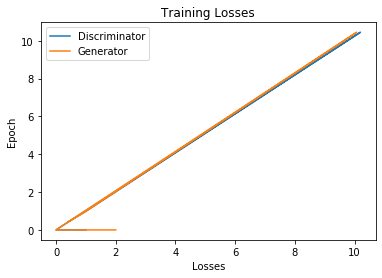

In [0]:
cycleGAN.show_losses()

30171136/30168306 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch - 0, Batch - 0, D_loss 0.342239 acc  41%, (G_loss 14.781466, adv_loss 0.325922, cycle_loss 0.706481) , time 0:01:09.869430


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch - 0, Batch - 1, D_loss 0.298280 acc  51%, (G_loss 15.728271, adv_loss 0.455069, cycle_loss 0.740907) , time 0:01:10.884317
Epoch - 0, Batch - 2, D_loss 0.239741 acc  64%, (G_loss 14.726974, adv_loss 0.609532, cycle_loss 0.675396) , time 0:01:11.544728
Epoch - 0, Batch - 3, D_loss 0.280245 acc  60%, (G_loss 11.452847, adv_loss 0.595606, cycle_loss 0.513082) , time 0:01:12.197120
Epoch - 0, Batch - 4, D_loss 0.252419 acc  71%, (G_loss 13.076197, adv_loss 0.627729, cycle_loss 0.591037) , time 0:01:12.839903
Epoch - 0, Batch - 5, D_loss 0.277013 acc  63%, (G_loss 13.411084, adv_loss 0.600810, cycle_loss 0.610473) , time 0:01:13.488388
Epoch - 0, Batch - 6, D_loss 0.295112 acc  61%, (G_loss 12.967125, adv_loss 0.569903, cycle_loss 0.591366) , time 0:01:14.138936
Epoch - 0, Batch - 7, D_loss 0.194685 acc  73%, (G_loss 11.850699, adv_loss 0.586051, cycle_loss 0.533930) , time 0:01:14.801499
Epoch - 0, Batch - 8, D_loss 0.196892 acc  74%, (G_loss 11.504265, adv_loss 0.567418, cycle_loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 51, D_loss 0.066668 acc  93%, (G_loss 10.261243, adv_loss 0.771048, cycle_loss 0.435957) , time 0:01:43.922884
Epoch - 0, Batch - 52, D_loss 0.041088 acc  96%, (G_loss 10.059329, adv_loss 0.797321, cycle_loss 0.423234) , time 0:01:44.589038
Epoch - 0, Batch - 53, D_loss 0.114722 acc  86%, (G_loss 11.025992, adv_loss 0.709448, cycle_loss 0.480355) , time 0:01:45.238808
Epoch - 0, Batch - 54, D_loss 0.117053 acc  86%, (G_loss 11.700104, adv_loss 0.774618, cycle_loss 0.507543) , time 0:01:45.896972
Epoch - 0, Batch - 55, D_loss 0.074792 acc  91%, (G_loss 10.805637, adv_loss 0.758783, cycle_loss 0.464404) , time 0:01:46.558935
Epoch - 0, Batch - 56, D_loss 0.085570 acc  90%, (G_loss 13.387575, adv_loss 0.750380, cycle_loss 0.594341) , time 0:01:47.216254
Epoch - 0, Batch - 57, D_loss 0.099012 acc  88%, (G_loss 9.147926, adv_loss 0.736528, cycle_loss 0.383744) , time 0:01:47.872752
Epoch - 0, Batch - 58, D_loss 0.070037 acc  91%, (G_loss 11.124370, adv_loss 0.773183, cycl

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 101, D_loss 0.049896 acc  92%, (G_loss 10.136756, adv_loss 0.893733, cycle_loss 0.417464) , time 0:02:17.061543
Epoch - 0, Batch - 102, D_loss 0.044459 acc  94%, (G_loss 10.528896, adv_loss 0.899993, cycle_loss 0.436446) , time 0:02:17.709160
Epoch - 0, Batch - 103, D_loss 0.041301 acc  95%, (G_loss 9.976420, adv_loss 0.916493, cycle_loss 0.407172) , time 0:02:18.365502
Epoch - 0, Batch - 104, D_loss 0.019509 acc  98%, (G_loss 13.147802, adv_loss 0.915234, cycle_loss 0.565867) , time 0:02:19.021155
Epoch - 0, Batch - 105, D_loss 0.017543 acc  97%, (G_loss 10.313124, adv_loss 0.935542, cycle_loss 0.422102) , time 0:02:19.676484
Epoch - 0, Batch - 106, D_loss 0.005776 acc 100%, (G_loss 12.232085, adv_loss 0.923873, cycle_loss 0.519217) , time 0:02:20.336468
Epoch - 0, Batch - 107, D_loss 0.002325 acc 100%, (G_loss 11.939941, adv_loss 0.955284, cycle_loss 0.501469) , time 0:02:20.989926
Epoch - 0, Batch - 108, D_loss 0.006611 acc  99%, (G_loss 13.171967, adv_loss 0.9336

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 151, D_loss 0.000720 acc 100%, (G_loss 11.362120, adv_loss 0.964411, cycle_loss 0.471665) , time 0:02:50.216417
Epoch - 0, Batch - 152, D_loss 0.000883 acc 100%, (G_loss 10.806651, adv_loss 0.965731, cycle_loss 0.443759) , time 0:02:50.869424
Epoch - 0, Batch - 153, D_loss 0.000747 acc 100%, (G_loss 10.754961, adv_loss 0.966951, cycle_loss 0.441053) , time 0:02:51.525940
Epoch - 0, Batch - 154, D_loss 0.000425 acc 100%, (G_loss 14.441483, adv_loss 0.962110, cycle_loss 0.625863) , time 0:02:52.182151
Epoch - 0, Batch - 155, D_loss 0.000837 acc 100%, (G_loss 9.361988, adv_loss 0.965433, cycle_loss 0.371556) , time 0:02:52.844857
Epoch - 0, Batch - 156, D_loss 0.000772 acc 100%, (G_loss 11.054565, adv_loss 0.959276, cycle_loss 0.456801) , time 0:02:53.504262
Epoch - 0, Batch - 157, D_loss 0.000455 acc 100%, (G_loss 11.162589, adv_loss 0.965146, cycle_loss 0.461615) , time 0:02:54.164233
Epoch - 0, Batch - 158, D_loss 0.000565 acc 100%, (G_loss 9.710032, adv_loss 0.96384

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 201, D_loss 0.000280 acc 100%, (G_loss 11.546040, adv_loss 0.973372, cycle_loss 0.479965) , time 0:03:23.404077
Epoch - 0, Batch - 202, D_loss 0.009980 acc  98%, (G_loss 11.604071, adv_loss 0.956565, cycle_loss 0.484547) , time 0:03:24.056891
Epoch - 0, Batch - 203, D_loss 0.000551 acc 100%, (G_loss 10.419052, adv_loss 0.961553, cycle_loss 0.424797) , time 0:03:24.711803
Epoch - 0, Batch - 204, D_loss 0.000803 acc 100%, (G_loss 11.190397, adv_loss 0.959633, cycle_loss 0.463557) , time 0:03:25.366189
Epoch - 0, Batch - 205, D_loss 0.003127 acc  99%, (G_loss 12.081995, adv_loss 0.967469, cycle_loss 0.507353) , time 0:03:26.018918
Epoch - 0, Batch - 206, D_loss 0.000399 acc 100%, (G_loss 13.033559, adv_loss 0.962083, cycle_loss 0.555470) , time 0:03:26.670550
Epoch - 0, Batch - 207, D_loss 0.001503 acc 100%, (G_loss 10.684679, adv_loss 0.966627, cycle_loss 0.437571) , time 0:03:27.320181
Epoch - 0, Batch - 208, D_loss 0.000361 acc 100%, (G_loss 10.081471, adv_loss 0.967

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 251, D_loss 0.000106 acc 100%, (G_loss 12.309342, adv_loss 0.981001, cycle_loss 0.517367) , time 0:03:56.491022
Epoch - 0, Batch - 252, D_loss 0.000365 acc 100%, (G_loss 10.964169, adv_loss 0.976813, cycle_loss 0.450527) , time 0:03:57.150316
Epoch - 0, Batch - 253, D_loss 0.000252 acc 100%, (G_loss 10.589195, adv_loss 0.971976, cycle_loss 0.432262) , time 0:03:57.803275
Epoch - 0, Batch - 254, D_loss 0.000218 acc 100%, (G_loss 10.769144, adv_loss 0.973610, cycle_loss 0.441096) , time 0:03:58.461913
Epoch - 0, Batch - 255, D_loss 0.000467 acc 100%, (G_loss 10.434864, adv_loss 0.973573, cycle_loss 0.424386) , time 0:03:59.125456
Epoch - 0, Batch - 256, D_loss 0.000125 acc 100%, (G_loss 12.648018, adv_loss 0.978892, cycle_loss 0.534512) , time 0:03:59.782781
Epoch - 0, Batch - 257, D_loss 0.000191 acc 100%, (G_loss 10.242555, adv_loss 0.976821, cycle_loss 0.414446) , time 0:04:00.441169
Epoch - 0, Batch - 258, D_loss 0.000084 acc 100%, (G_loss 12.750922, adv_loss 0.984

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 301, D_loss 0.000203 acc 100%, (G_loss 11.158937, adv_loss 0.978227, cycle_loss 0.460124) , time 0:04:29.661747
Epoch - 0, Batch - 302, D_loss 0.000136 acc 100%, (G_loss 11.733968, adv_loss 0.977965, cycle_loss 0.488902) , time 0:04:30.312692
Epoch - 0, Batch - 303, D_loss 0.000156 acc 100%, (G_loss 10.499880, adv_loss 0.976349, cycle_loss 0.427359) , time 0:04:30.964539
Epoch - 0, Batch - 304, D_loss 0.000146 acc 100%, (G_loss 11.190738, adv_loss 0.978323, cycle_loss 0.461705) , time 0:04:31.616894
Epoch - 0, Batch - 305, D_loss 0.012097 acc  98%, (G_loss 9.607893, adv_loss 0.965522, cycle_loss 0.383842) , time 0:04:32.268190
Epoch - 0, Batch - 306, D_loss 0.013524 acc  98%, (G_loss 11.629144, adv_loss 0.928726, cycle_loss 0.488585) , time 0:04:32.935938
Epoch - 0, Batch - 307, D_loss 0.003661 acc 100%, (G_loss 9.935202, adv_loss 0.956847, cycle_loss 0.401075) , time 0:04:33.600399
Epoch - 0, Batch - 308, D_loss 0.001786 acc 100%, (G_loss 11.999598, adv_loss 0.96051

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 351, D_loss 0.000111 acc 100%, (G_loss 12.355526, adv_loss 0.982545, cycle_loss 0.519522) , time 0:05:02.798626
Epoch - 0, Batch - 352, D_loss 0.000077 acc 100%, (G_loss 12.650927, adv_loss 0.983814, cycle_loss 0.534165) , time 0:05:03.460687
Epoch - 0, Batch - 353, D_loss 0.000122 acc 100%, (G_loss 10.737442, adv_loss 0.979731, cycle_loss 0.438899) , time 0:05:04.113152
Epoch - 0, Batch - 354, D_loss 0.000198 acc 100%, (G_loss 10.321814, adv_loss 0.978671, cycle_loss 0.418224) , time 0:05:04.773433
Epoch - 0, Batch - 355, D_loss 0.000241 acc 100%, (G_loss 12.198721, adv_loss 0.979292, cycle_loss 0.512007) , time 0:05:05.426635
Epoch - 0, Batch - 356, D_loss 0.000131 acc 100%, (G_loss 11.721861, adv_loss 0.980654, cycle_loss 0.488028) , time 0:05:06.085597
Epoch - 0, Batch - 357, D_loss 0.000084 acc 100%, (G_loss 11.081672, adv_loss 0.982568, cycle_loss 0.455827) , time 0:05:06.734085
Epoch - 0, Batch - 358, D_loss 0.000149 acc 100%, (G_loss 10.633165, adv_loss 0.980

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 1, D_loss 0.000078 acc 100%, (G_loss 10.584492, adv_loss 0.985062, cycle_loss 0.430718) , time 0:05:35.282413
Epoch - 1, Batch - 2, D_loss 0.000089 acc 100%, (G_loss 11.632705, adv_loss 0.986656, cycle_loss 0.482970) , time 0:05:35.934897
Epoch - 1, Batch - 3, D_loss 0.000296 acc 100%, (G_loss 9.242063, adv_loss 0.981574, cycle_loss 0.363946) , time 0:05:36.590965
Epoch - 1, Batch - 4, D_loss 0.000074 acc 100%, (G_loss 10.702332, adv_loss 0.983969, cycle_loss 0.436720) , time 0:05:37.253193
Epoch - 1, Batch - 5, D_loss 0.000076 acc 100%, (G_loss 11.456751, adv_loss 0.985927, cycle_loss 0.474245) , time 0:05:37.910616
Epoch - 1, Batch - 6, D_loss 0.000062 acc 100%, (G_loss 11.055714, adv_loss 0.985688, cycle_loss 0.454217) , time 0:05:38.579869
Epoch - 1, Batch - 7, D_loss 0.000074 acc 100%, (G_loss 10.526031, adv_loss 0.986893, cycle_loss 0.427612) , time 0:05:39.244088
Epoch - 1, Batch - 8, D_loss 0.000069 acc 100%, (G_loss 10.393482, adv_loss 0.986396, cycle_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 51, D_loss 0.000102 acc 100%, (G_loss 9.239008, adv_loss 0.988131, cycle_loss 0.363137) , time 0:06:08.390381
Epoch - 1, Batch - 52, D_loss 0.000178 acc 100%, (G_loss 9.332499, adv_loss 0.985870, cycle_loss 0.368038) , time 0:06:09.045296
Epoch - 1, Batch - 53, D_loss 0.000134 acc 100%, (G_loss 10.229631, adv_loss 0.981985, cycle_loss 0.413283) , time 0:06:09.703446
Epoch - 1, Batch - 54, D_loss 0.000205 acc 100%, (G_loss 11.051771, adv_loss 0.984549, cycle_loss 0.454134) , time 0:06:10.368638
Epoch - 1, Batch - 55, D_loss 0.000082 acc 100%, (G_loss 9.765342, adv_loss 0.984008, cycle_loss 0.389866) , time 0:06:11.023206
Epoch - 1, Batch - 56, D_loss 0.000134 acc 100%, (G_loss 12.780214, adv_loss 0.985117, cycle_loss 0.540499) , time 0:06:11.686858
Epoch - 1, Batch - 57, D_loss 0.000130 acc 100%, (G_loss 8.704018, adv_loss 0.981611, cycle_loss 0.337040) , time 0:06:12.353514
Epoch - 1, Batch - 58, D_loss 0.000154 acc 100%, (G_loss 10.570524, adv_loss 0.975349, cycle_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 101, D_loss 0.000168 acc 100%, (G_loss 9.663992, adv_loss 0.979028, cycle_loss 0.385297) , time 0:06:41.533061
Epoch - 1, Batch - 102, D_loss 0.000118 acc 100%, (G_loss 10.148386, adv_loss 0.981301, cycle_loss 0.409289) , time 0:06:42.186283
Epoch - 1, Batch - 103, D_loss 0.000092 acc 100%, (G_loss 9.490184, adv_loss 0.986885, cycle_loss 0.375821) , time 0:06:42.843197
Epoch - 1, Batch - 104, D_loss 0.000063 acc 100%, (G_loss 12.817384, adv_loss 0.986716, cycle_loss 0.542198) , time 0:06:43.506626
Epoch - 1, Batch - 105, D_loss 0.000097 acc 100%, (G_loss 9.397715, adv_loss 0.986607, cycle_loss 0.371225) , time 0:06:44.161859
Epoch - 1, Batch - 106, D_loss 0.000073 acc 100%, (G_loss 11.673529, adv_loss 0.986631, cycle_loss 0.485013) , time 0:06:44.812711
Epoch - 1, Batch - 107, D_loss 0.000037 acc 100%, (G_loss 11.344241, adv_loss 0.990188, cycle_loss 0.468193) , time 0:06:45.475757
Epoch - 1, Batch - 108, D_loss 0.000077 acc 100%, (G_loss 12.423638, adv_loss 0.985594

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 151, D_loss 0.000054 acc 100%, (G_loss 10.955826, adv_loss 0.987742, cycle_loss 0.449017) , time 0:07:14.711526
Epoch - 1, Batch - 152, D_loss 0.000071 acc 100%, (G_loss 10.386222, adv_loss 0.986147, cycle_loss 0.420696) , time 0:07:15.360524
Epoch - 1, Batch - 153, D_loss 0.000070 acc 100%, (G_loss 10.561573, adv_loss 0.986839, cycle_loss 0.429395) , time 0:07:16.017769
Epoch - 1, Batch - 154, D_loss 0.000050 acc 100%, (G_loss 14.634439, adv_loss 0.985583, cycle_loss 0.633164) , time 0:07:16.671632
Epoch - 1, Batch - 155, D_loss 0.000108 acc 100%, (G_loss 9.005627, adv_loss 0.983556, cycle_loss 0.351926) , time 0:07:17.323032
Epoch - 1, Batch - 156, D_loss 0.000067 acc 100%, (G_loss 10.618566, adv_loss 0.986946, cycle_loss 0.432234) , time 0:07:17.982028
Epoch - 1, Batch - 157, D_loss 0.000054 acc 100%, (G_loss 10.894722, adv_loss 0.986112, cycle_loss 0.446125) , time 0:07:18.636862
Epoch - 1, Batch - 158, D_loss 0.000065 acc 100%, (G_loss 9.237270, adv_loss 0.98586

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 201, D_loss 0.000028 acc 100%, (G_loss 11.167439, adv_loss 0.992146, cycle_loss 0.459157) , time 0:07:47.862017
Epoch - 1, Batch - 202, D_loss 0.000577 acc 100%, (G_loss 11.454111, adv_loss 0.989164, cycle_loss 0.473789) , time 0:07:48.531968
Epoch - 1, Batch - 203, D_loss 0.000045 acc 100%, (G_loss 10.191164, adv_loss 0.989199, cycle_loss 0.410638) , time 0:07:49.189938
Epoch - 1, Batch - 204, D_loss 0.000033 acc 100%, (G_loss 10.849057, adv_loss 0.990755, cycle_loss 0.443377) , time 0:07:49.846464
Epoch - 1, Batch - 205, D_loss 0.000046 acc 100%, (G_loss 11.635795, adv_loss 0.990141, cycle_loss 0.482776) , time 0:07:50.509605
Epoch - 1, Batch - 206, D_loss 0.000024 acc 100%, (G_loss 12.785928, adv_loss 0.991872, cycle_loss 0.540109) , time 0:07:51.161956
Epoch - 1, Batch - 207, D_loss 0.000086 acc 100%, (G_loss 10.566679, adv_loss 0.990681, cycle_loss 0.429266) , time 0:07:51.825418
Epoch - 1, Batch - 208, D_loss 0.000038 acc 100%, (G_loss 9.796812, adv_loss 0.9903

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 251, D_loss 0.000019 acc 100%, (G_loss 12.267007, adv_loss 0.992056, cycle_loss 0.514145) , time 0:08:21.001919
Epoch - 1, Batch - 252, D_loss 0.000051 acc 100%, (G_loss 10.712164, adv_loss 0.989788, cycle_loss 0.436629) , time 0:08:21.652590
Epoch - 1, Batch - 253, D_loss 0.000037 acc 100%, (G_loss 9.621880, adv_loss 0.990192, cycle_loss 0.382075) , time 0:08:22.301425
Epoch - 1, Batch - 254, D_loss 0.000038 acc 100%, (G_loss 10.375154, adv_loss 0.989627, cycle_loss 0.419795) , time 0:08:22.965662
Epoch - 1, Batch - 255, D_loss 0.000043 acc 100%, (G_loss 9.982407, adv_loss 0.991366, cycle_loss 0.399984) , time 0:08:23.624158
Epoch - 1, Batch - 256, D_loss 0.000018 acc 100%, (G_loss 12.468249, adv_loss 0.992447, cycle_loss 0.524168) , time 0:08:24.287318
Epoch - 1, Batch - 257, D_loss 0.000033 acc 100%, (G_loss 10.098281, adv_loss 0.990712, cycle_loss 0.405843) , time 0:08:24.937158
Epoch - 1, Batch - 258, D_loss 0.000020 acc 100%, (G_loss 12.658433, adv_loss 0.99300

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 301, D_loss 0.000037 acc 100%, (G_loss 10.828435, adv_loss 0.990816, cycle_loss 0.442340) , time 0:08:54.179335
Epoch - 1, Batch - 302, D_loss 0.000027 acc 100%, (G_loss 11.618793, adv_loss 0.990973, cycle_loss 0.481842) , time 0:08:54.829484
Epoch - 1, Batch - 303, D_loss 0.000028 acc 100%, (G_loss 10.282991, adv_loss 0.990775, cycle_loss 0.415072) , time 0:08:55.484352
Epoch - 1, Batch - 304, D_loss 0.000025 acc 100%, (G_loss 11.036667, adv_loss 0.991755, cycle_loss 0.452658) , time 0:08:56.139609
Epoch - 1, Batch - 305, D_loss 0.000311 acc 100%, (G_loss 9.606617, adv_loss 0.992581, cycle_loss 0.381073) , time 0:08:56.792228
Epoch - 1, Batch - 306, D_loss 0.000041 acc 100%, (G_loss 11.539515, adv_loss 0.989870, cycle_loss 0.477989) , time 0:08:57.443063
Epoch - 1, Batch - 307, D_loss 0.000039 acc 100%, (G_loss 9.782761, adv_loss 0.990168, cycle_loss 0.390121) , time 0:08:58.110203
Epoch - 1, Batch - 308, D_loss 0.000023 acc 100%, (G_loss 11.665079, adv_loss 0.99165

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 351, D_loss 0.000018 acc 100%, (G_loss 12.284471, adv_loss 0.992559, cycle_loss 0.514968) , time 0:09:27.306624
Epoch - 1, Batch - 352, D_loss 0.000018 acc 100%, (G_loss 12.447083, adv_loss 0.992639, cycle_loss 0.523090) , time 0:09:27.959884
Epoch - 1, Batch - 353, D_loss 0.000020 acc 100%, (G_loss 10.486293, adv_loss 0.992011, cycle_loss 0.425113) , time 0:09:28.614469
Epoch - 1, Batch - 354, D_loss 0.000036 acc 100%, (G_loss 10.192616, adv_loss 0.991619, cycle_loss 0.410469) , time 0:09:29.274041
Epoch - 1, Batch - 355, D_loss 0.000042 acc 100%, (G_loss 11.758131, adv_loss 0.990312, cycle_loss 0.488875) , time 0:09:29.938435
Epoch - 1, Batch - 356, D_loss 0.000027 acc 100%, (G_loss 11.457450, adv_loss 0.991711, cycle_loss 0.473701) , time 0:09:30.598894
Epoch - 1, Batch - 357, D_loss 0.000018 acc 100%, (G_loss 10.760775, adv_loss 0.992480, cycle_loss 0.438791) , time 0:09:31.249507
Epoch - 1, Batch - 358, D_loss 0.000031 acc 100%, (G_loss 10.078158, adv_loss 0.990

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 1, D_loss 0.000028 acc 100%, (G_loss 10.491436, adv_loss 0.991061, cycle_loss 0.425466) , time 0:09:59.764531
Epoch - 2, Batch - 2, D_loss 0.000026 acc 100%, (G_loss 11.512852, adv_loss 0.992631, cycle_loss 0.476379) , time 0:10:00.432743
Epoch - 2, Batch - 3, D_loss 0.000048 acc 100%, (G_loss 9.067295, adv_loss 0.991150, cycle_loss 0.354250) , time 0:10:01.083755
Epoch - 2, Batch - 4, D_loss 0.000020 acc 100%, (G_loss 10.544403, adv_loss 0.991966, cycle_loss 0.428024) , time 0:10:01.735928
Epoch - 2, Batch - 5, D_loss 0.000019 acc 100%, (G_loss 11.288315, adv_loss 0.994065, cycle_loss 0.465009) , time 0:10:02.387106
Epoch - 2, Batch - 6, D_loss 0.000018 acc 100%, (G_loss 10.726251, adv_loss 0.992884, cycle_loss 0.437024) , time 0:10:03.038372
Epoch - 2, Batch - 7, D_loss 0.000021 acc 100%, (G_loss 10.293541, adv_loss 0.993415, cycle_loss 0.415335) , time 0:10:03.693542
Epoch - 2, Batch - 8, D_loss 0.000019 acc 100%, (G_loss 10.044538, adv_loss 0.992860, cycle_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 51, D_loss 0.000029 acc 100%, (G_loss 9.057738, adv_loss 0.992585, cycle_loss 0.353628) , time 0:10:32.885915
Epoch - 2, Batch - 52, D_loss 0.000034 acc 100%, (G_loss 9.146364, adv_loss 0.991406, cycle_loss 0.358178) , time 0:10:33.539164
Epoch - 2, Batch - 53, D_loss 0.000050 acc 100%, (G_loss 9.736300, adv_loss 0.988717, cycle_loss 0.387943) , time 0:10:34.200559
Epoch - 2, Batch - 54, D_loss 0.000050 acc 100%, (G_loss 10.838621, adv_loss 0.989448, cycle_loss 0.442986) , time 0:10:34.850758
Epoch - 2, Batch - 55, D_loss 0.000026 acc 100%, (G_loss 9.452963, adv_loss 0.991025, cycle_loss 0.373546) , time 0:10:35.499892
Epoch - 2, Batch - 56, D_loss 0.000050 acc 100%, (G_loss 12.597912, adv_loss 0.989921, cycle_loss 0.530904) , time 0:10:36.163451
Epoch - 2, Batch - 57, D_loss 0.000040 acc 100%, (G_loss 8.468994, adv_loss 0.990683, cycle_loss 0.324381) , time 0:10:36.817940
Epoch - 2, Batch - 58, D_loss 0.000035 acc 100%, (G_loss 10.406609, adv_loss 0.990007, cycle_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 101, D_loss 0.000032 acc 100%, (G_loss 9.525248, adv_loss 0.990382, cycle_loss 0.377224) , time 0:11:06.531730
Epoch - 2, Batch - 102, D_loss 0.000025 acc 100%, (G_loss 9.867853, adv_loss 0.991307, cycle_loss 0.394262) , time 0:11:07.184637
Epoch - 2, Batch - 103, D_loss 0.000021 acc 100%, (G_loss 9.237186, adv_loss 0.991780, cycle_loss 0.362681) , time 0:11:07.844824
Epoch - 2, Batch - 104, D_loss 0.000020 acc 100%, (G_loss 12.555861, adv_loss 0.992307, cycle_loss 0.528562) , time 0:11:08.497161
Epoch - 2, Batch - 105, D_loss 0.000026 acc 100%, (G_loss 9.239356, adv_loss 0.992222, cycle_loss 0.362746) , time 0:11:09.157329
Epoch - 2, Batch - 106, D_loss 0.000031 acc 100%, (G_loss 11.472738, adv_loss 0.990445, cycle_loss 0.474592) , time 0:11:09.804713
Epoch - 2, Batch - 107, D_loss 0.000019 acc 100%, (G_loss 11.426447, adv_loss 0.992562, cycle_loss 0.472066) , time 0:11:10.455379
Epoch - 2, Batch - 108, D_loss 0.000032 acc 100%, (G_loss 11.890699, adv_loss 0.989721,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 151, D_loss 0.000020 acc 100%, (G_loss 10.555679, adv_loss 0.992959, cycle_loss 0.428488) , time 0:11:39.701403
Epoch - 2, Batch - 152, D_loss 0.000021 acc 100%, (G_loss 10.280436, adv_loss 0.992877, cycle_loss 0.414734) , time 0:11:40.358467
Epoch - 2, Batch - 153, D_loss 0.000028 acc 100%, (G_loss 10.304447, adv_loss 0.990662, cycle_loss 0.416156) , time 0:11:41.014261
Epoch - 2, Batch - 154, D_loss 0.000018 acc 100%, (G_loss 14.512888, adv_loss 0.992270, cycle_loss 0.626417) , time 0:11:41.666779
Epoch - 2, Batch - 155, D_loss 0.000038 acc 100%, (G_loss 8.840008, adv_loss 0.990347, cycle_loss 0.342966) , time 0:11:42.335857
Epoch - 2, Batch - 156, D_loss 0.000028 acc 100%, (G_loss 10.517849, adv_loss 0.991255, cycle_loss 0.426767) , time 0:11:42.992631
Epoch - 2, Batch - 157, D_loss 0.000021 acc 100%, (G_loss 10.768301, adv_loss 0.992473, cycle_loss 0.439168) , time 0:11:43.641067
Epoch - 2, Batch - 158, D_loss 0.000027 acc 100%, (G_loss 9.129593, adv_loss 0.99141

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 201, D_loss 0.000013 acc 100%, (G_loss 10.775650, adv_loss 0.994268, cycle_loss 0.439356) , time 0:12:12.880763
Epoch - 2, Batch - 202, D_loss 0.000063 acc 100%, (G_loss 11.108904, adv_loss 0.992677, cycle_loss 0.456178) , time 0:12:13.546402
Epoch - 2, Batch - 203, D_loss 0.000017 acc 100%, (G_loss 9.736188, adv_loss 0.993369, cycle_loss 0.387472) , time 0:12:14.200326
Epoch - 2, Batch - 204, D_loss 0.000016 acc 100%, (G_loss 10.440504, adv_loss 0.993555, cycle_loss 0.422670) , time 0:12:14.850968
Epoch - 2, Batch - 205, D_loss 0.000022 acc 100%, (G_loss 11.164062, adv_loss 0.992256, cycle_loss 0.458977) , time 0:12:15.515173
Epoch - 2, Batch - 206, D_loss 0.000014 acc 100%, (G_loss 12.482124, adv_loss 0.992983, cycle_loss 0.524808) , time 0:12:16.162373
Epoch - 2, Batch - 207, D_loss 0.000036 acc 100%, (G_loss 10.181264, adv_loss 0.993125, cycle_loss 0.409751) , time 0:12:16.825594
Epoch - 2, Batch - 208, D_loss 0.000015 acc 100%, (G_loss 9.483439, adv_loss 0.99394

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 251, D_loss 0.000008 acc 100%, (G_loss 12.079989, adv_loss 0.995070, cycle_loss 0.504493) , time 0:12:46.099552
Epoch - 2, Batch - 252, D_loss 0.000025 acc 100%, (G_loss 10.425580, adv_loss 0.993490, cycle_loss 0.421930) , time 0:12:46.762949
Epoch - 2, Batch - 253, D_loss 0.000019 acc 100%, (G_loss 9.580882, adv_loss 0.993114, cycle_loss 0.379733) , time 0:12:47.422964
Epoch - 2, Batch - 254, D_loss 0.000018 acc 100%, (G_loss 10.195981, adv_loss 0.993283, cycle_loss 0.410471) , time 0:12:48.078722
Epoch - 2, Batch - 255, D_loss 0.000026 acc 100%, (G_loss 9.794199, adv_loss 0.992217, cycle_loss 0.390488) , time 0:12:48.731759
Epoch - 2, Batch - 256, D_loss 0.000010 acc 100%, (G_loss 12.229940, adv_loss 0.994154, cycle_loss 0.512082) , time 0:12:49.396108
Epoch - 2, Batch - 257, D_loss 0.000016 acc 100%, (G_loss 9.752202, adv_loss 0.993355, cycle_loss 0.388275) , time 0:12:50.064013
Epoch - 2, Batch - 258, D_loss 0.000011 acc 100%, (G_loss 12.618420, adv_loss 0.994574

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 301, D_loss 0.000018 acc 100%, (G_loss 10.546673, adv_loss 0.993286, cycle_loss 0.428005) , time 0:13:19.347186
Epoch - 2, Batch - 302, D_loss 0.000016 acc 100%, (G_loss 11.338127, adv_loss 0.993119, cycle_loss 0.467594) , time 0:13:20.007540
Epoch - 2, Batch - 303, D_loss 0.000017 acc 100%, (G_loss 10.100378, adv_loss 0.992954, cycle_loss 0.405723) , time 0:13:20.659294
Epoch - 2, Batch - 304, D_loss 0.000015 acc 100%, (G_loss 10.931847, adv_loss 0.993693, cycle_loss 0.447223) , time 0:13:21.317613
Epoch - 2, Batch - 305, D_loss 0.000128 acc 100%, (G_loss 9.532244, adv_loss 0.994216, cycle_loss 0.377191) , time 0:13:21.972797
Epoch - 2, Batch - 306, D_loss 0.000023 acc 100%, (G_loss 11.337231, adv_loss 0.991577, cycle_loss 0.467704) , time 0:13:22.636633
Epoch - 2, Batch - 307, D_loss 0.000022 acc 100%, (G_loss 9.547330, adv_loss 0.991161, cycle_loss 0.378250) , time 0:13:23.293813
Epoch - 2, Batch - 308, D_loss 0.000013 acc 100%, (G_loss 11.389868, adv_loss 0.99369

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 351, D_loss 0.000013 acc 100%, (G_loss 12.096203, adv_loss 0.993690, cycle_loss 0.505441) , time 0:13:52.545321
Epoch - 2, Batch - 352, D_loss 0.000013 acc 100%, (G_loss 12.283001, adv_loss 0.993441, cycle_loss 0.514806) , time 0:13:53.199312
Epoch - 2, Batch - 353, D_loss 0.000013 acc 100%, (G_loss 10.194145, adv_loss 0.994047, cycle_loss 0.410303) , time 0:13:53.849770
Epoch - 2, Batch - 354, D_loss 0.000023 acc 100%, (G_loss 10.066072, adv_loss 0.993043, cycle_loss 0.403999) , time 0:13:54.504097
Epoch - 2, Batch - 355, D_loss 0.000028 acc 100%, (G_loss 11.523178, adv_loss 0.992436, cycle_loss 0.476915) , time 0:13:55.155283
Epoch - 2, Batch - 356, D_loss 0.000017 acc 100%, (G_loss 11.127499, adv_loss 0.993397, cycle_loss 0.457035) , time 0:13:55.824797
Epoch - 2, Batch - 357, D_loss 0.000012 acc 100%, (G_loss 10.570075, adv_loss 0.993755, cycle_loss 0.429128) , time 0:13:56.473960
Epoch - 2, Batch - 358, D_loss 0.000019 acc 100%, (G_loss 10.023521, adv_loss 0.992

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 1, D_loss 0.000017 acc 100%, (G_loss 10.390049, adv_loss 0.993599, cycle_loss 0.420143) , time 0:14:25.061878
Epoch - 3, Batch - 2, D_loss 0.000017 acc 100%, (G_loss 11.396029, adv_loss 0.994212, cycle_loss 0.470380) , time 0:14:25.724410
Epoch - 3, Batch - 3, D_loss 0.000032 acc 100%, (G_loss 9.031332, adv_loss 0.992212, cycle_loss 0.352345) , time 0:14:26.382566
Epoch - 3, Batch - 4, D_loss 0.000012 acc 100%, (G_loss 10.435658, adv_loss 0.993888, cycle_loss 0.422394) , time 0:14:27.046151
Epoch - 3, Batch - 5, D_loss 0.000012 acc 100%, (G_loss 11.093986, adv_loss 0.995319, cycle_loss 0.455167) , time 0:14:27.701925
Epoch - 3, Batch - 6, D_loss 0.000011 acc 100%, (G_loss 10.599186, adv_loss 0.994688, cycle_loss 0.430490) , time 0:14:28.363996
Epoch - 3, Batch - 7, D_loss 0.000013 acc 100%, (G_loss 10.111734, adv_loss 0.994799, cycle_loss 0.406107) , time 0:14:29.014221
Epoch - 3, Batch - 8, D_loss 0.000012 acc 100%, (G_loss 9.864592, adv_loss 0.994456, cycle_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 51, D_loss 0.000018 acc 100%, (G_loss 8.925808, adv_loss 0.994763, cycle_loss 0.346814) , time 0:14:58.283899
Epoch - 3, Batch - 52, D_loss 0.000018 acc 100%, (G_loss 9.019701, adv_loss 0.994549, cycle_loss 0.351530) , time 0:14:58.936810
Epoch - 3, Batch - 53, D_loss 0.000038 acc 100%, (G_loss 9.802165, adv_loss 0.991265, cycle_loss 0.390982) , time 0:14:59.588481
Epoch - 3, Batch - 54, D_loss 0.000031 acc 100%, (G_loss 10.777931, adv_loss 0.992362, cycle_loss 0.439660) , time 0:15:00.257694
Epoch - 3, Batch - 55, D_loss 0.000014 acc 100%, (G_loss 9.303576, adv_loss 0.994438, cycle_loss 0.365735) , time 0:15:00.917493
Epoch - 3, Batch - 56, D_loss 0.000028 acc 100%, (G_loss 12.289330, adv_loss 0.993005, cycle_loss 0.515166) , time 0:15:01.575483
Epoch - 3, Batch - 57, D_loss 0.000020 acc 100%, (G_loss 8.341272, adv_loss 0.994317, cycle_loss 0.317632) , time 0:15:02.231779
Epoch - 3, Batch - 58, D_loss 0.000020 acc 100%, (G_loss 10.282880, adv_loss 0.993174, cycle_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 101, D_loss 0.000016 acc 100%, (G_loss 9.447785, adv_loss 0.993680, cycle_loss 0.373021) , time 0:15:31.498447
Epoch - 3, Batch - 102, D_loss 0.000014 acc 100%, (G_loss 9.728832, adv_loss 0.993779, cycle_loss 0.387064) , time 0:15:32.152346
Epoch - 3, Batch - 103, D_loss 0.000011 acc 100%, (G_loss 9.168652, adv_loss 0.994331, cycle_loss 0.358999) , time 0:15:32.807535
Epoch - 3, Batch - 104, D_loss 0.000012 acc 100%, (G_loss 12.421228, adv_loss 0.994448, cycle_loss 0.521617) , time 0:15:33.464430
Epoch - 3, Batch - 105, D_loss 0.000015 acc 100%, (G_loss 9.130429, adv_loss 0.994517, cycle_loss 0.357070) , time 0:15:34.117544
Epoch - 3, Batch - 106, D_loss 0.000013 acc 100%, (G_loss 11.348158, adv_loss 0.993973, cycle_loss 0.468011) , time 0:15:34.781883
Epoch - 3, Batch - 107, D_loss 0.000011 acc 100%, (G_loss 11.367447, adv_loss 0.994409, cycle_loss 0.468931) , time 0:15:35.433832
Epoch - 3, Batch - 108, D_loss 0.000013 acc 100%, (G_loss 12.069836, adv_loss 0.993901,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 151, D_loss 0.000013 acc 100%, (G_loss 10.296233, adv_loss 0.994299, cycle_loss 0.415382) , time 0:16:04.710802
Epoch - 3, Batch - 152, D_loss 0.000012 acc 100%, (G_loss 10.150103, adv_loss 0.994452, cycle_loss 0.408060) , time 0:16:05.370047
Epoch - 3, Batch - 153, D_loss 0.000013 acc 100%, (G_loss 10.290060, adv_loss 0.993539, cycle_loss 0.415149) , time 0:16:06.019357
Epoch - 3, Batch - 154, D_loss 0.000011 acc 100%, (G_loss 14.525536, adv_loss 0.994022, cycle_loss 0.626875) , time 0:16:06.674766
Epoch - 3, Batch - 155, D_loss 0.000023 acc 100%, (G_loss 8.816943, adv_loss 0.992175, cycle_loss 0.341630) , time 0:16:07.325494
Epoch - 3, Batch - 156, D_loss 0.000015 acc 100%, (G_loss 10.435471, adv_loss 0.994009, cycle_loss 0.422373) , time 0:16:07.975995
Epoch - 3, Batch - 157, D_loss 0.000009 acc 100%, (G_loss 10.687140, adv_loss 0.994709, cycle_loss 0.434886) , time 0:16:08.636526
Epoch - 3, Batch - 158, D_loss 0.000017 acc 100%, (G_loss 9.080908, adv_loss 0.99281

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 201, D_loss 0.000010 acc 100%, (G_loss 10.513718, adv_loss 0.994911, cycle_loss 0.426195) , time 0:16:37.857147
Epoch - 3, Batch - 202, D_loss 0.000040 acc 100%, (G_loss 10.830101, adv_loss 0.993168, cycle_loss 0.442188) , time 0:16:38.521040
Epoch - 3, Batch - 203, D_loss 0.000011 acc 100%, (G_loss 9.508512, adv_loss 0.994606, cycle_loss 0.375965) , time 0:16:39.174912
Epoch - 3, Batch - 204, D_loss 0.000010 acc 100%, (G_loss 10.267036, adv_loss 0.994819, cycle_loss 0.413870) , time 0:16:39.831539
Epoch - 3, Batch - 205, D_loss 0.000014 acc 100%, (G_loss 10.898354, adv_loss 0.993890, cycle_loss 0.445529) , time 0:16:40.483893
Epoch - 3, Batch - 206, D_loss 0.000009 acc 100%, (G_loss 12.389397, adv_loss 0.994427, cycle_loss 0.520027) , time 0:16:41.148731
Epoch - 3, Batch - 207, D_loss 0.000021 acc 100%, (G_loss 9.993471, adv_loss 0.994349, cycle_loss 0.400239) , time 0:16:41.800251
Epoch - 3, Batch - 208, D_loss 0.000010 acc 100%, (G_loss 9.314558, adv_loss 0.995034

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 251, D_loss 0.000007 acc 100%, (G_loss 11.865686, adv_loss 0.995262, cycle_loss 0.493758) , time 0:17:11.038556
Epoch - 3, Batch - 252, D_loss 0.000017 acc 100%, (G_loss 10.334354, adv_loss 0.994477, cycle_loss 0.417270) , time 0:17:11.703038
Epoch - 3, Batch - 253, D_loss 0.000013 acc 100%, (G_loss 9.216555, adv_loss 0.994281, cycle_loss 0.361400) , time 0:17:12.365221
Epoch - 3, Batch - 254, D_loss 0.000010 acc 100%, (G_loss 10.045176, adv_loss 0.995127, cycle_loss 0.402746) , time 0:17:13.025637
Epoch - 3, Batch - 255, D_loss 0.000018 acc 100%, (G_loss 9.712290, adv_loss 0.993668, cycle_loss 0.386248) , time 0:17:13.695458
Epoch - 3, Batch - 256, D_loss 0.000008 acc 100%, (G_loss 12.043964, adv_loss 0.994528, cycle_loss 0.502745) , time 0:17:14.360300
Epoch - 3, Batch - 257, D_loss 0.000011 acc 100%, (G_loss 9.635401, adv_loss 0.994711, cycle_loss 0.382299) , time 0:17:15.019128
Epoch - 3, Batch - 258, D_loss 0.000008 acc 100%, (G_loss 12.572621, adv_loss 0.995383

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 301, D_loss 0.000013 acc 100%, (G_loss 10.418708, adv_loss 0.993873, cycle_loss 0.421548) , time 0:17:44.258470
Epoch - 3, Batch - 302, D_loss 0.000011 acc 100%, (G_loss 11.317551, adv_loss 0.993913, cycle_loss 0.466486) , time 0:17:44.911123
Epoch - 3, Batch - 303, D_loss 0.000011 acc 100%, (G_loss 9.926527, adv_loss 0.994369, cycle_loss 0.396889) , time 0:17:45.565934
Epoch - 3, Batch - 304, D_loss 0.000011 acc 100%, (G_loss 10.721897, adv_loss 0.994561, cycle_loss 0.436639) , time 0:17:46.218949
Epoch - 3, Batch - 305, D_loss 0.000073 acc 100%, (G_loss 9.337165, adv_loss 0.994776, cycle_loss 0.367381) , time 0:17:46.874309
Epoch - 3, Batch - 306, D_loss 0.000015 acc 100%, (G_loss 11.228024, adv_loss 0.993155, cycle_loss 0.462086) , time 0:17:47.531692
Epoch - 3, Batch - 307, D_loss 0.000013 acc 100%, (G_loss 9.462303, adv_loss 0.993651, cycle_loss 0.373750) , time 0:17:48.189350
Epoch - 3, Batch - 308, D_loss 0.000013 acc 100%, (G_loss 11.330053, adv_loss 0.994313

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 351, D_loss 0.000007 acc 100%, (G_loss 12.014951, adv_loss 0.995739, cycle_loss 0.501174) , time 0:18:17.645808
Epoch - 3, Batch - 352, D_loss 0.000008 acc 100%, (G_loss 12.117480, adv_loss 0.995305, cycle_loss 0.506344) , time 0:18:18.306262
Epoch - 3, Batch - 353, D_loss 0.000008 acc 100%, (G_loss 10.152181, adv_loss 0.995588, cycle_loss 0.408050) , time 0:18:18.970435
Epoch - 3, Batch - 354, D_loss 0.000015 acc 100%, (G_loss 10.051731, adv_loss 0.994498, cycle_loss 0.403137) , time 0:18:19.634480
Epoch - 3, Batch - 355, D_loss 0.000018 acc 100%, (G_loss 11.142313, adv_loss 0.994447, cycle_loss 0.457671) , time 0:18:20.301334
Epoch - 3, Batch - 356, D_loss 0.000011 acc 100%, (G_loss 10.935051, adv_loss 0.994822, cycle_loss 0.447270) , time 0:18:20.962129
Epoch - 3, Batch - 357, D_loss 0.000008 acc 100%, (G_loss 10.453514, adv_loss 0.994931, cycle_loss 0.423183) , time 0:18:21.621684
Epoch - 3, Batch - 358, D_loss 0.000013 acc 100%, (G_loss 9.716393, adv_loss 0.9936

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 1, D_loss 0.000012 acc 100%, (G_loss 10.204436, adv_loss 0.994312, cycle_loss 0.410791) , time 0:18:50.183320
Epoch - 4, Batch - 2, D_loss 0.000012 acc 100%, (G_loss 11.278101, adv_loss 0.995560, cycle_loss 0.464349) , time 0:18:50.835359
Epoch - 4, Batch - 3, D_loss 0.000021 acc 100%, (G_loss 8.831160, adv_loss 0.993624, cycle_loss 0.342196) , time 0:18:51.496240
Epoch - 4, Batch - 4, D_loss 0.000008 acc 100%, (G_loss 10.276896, adv_loss 0.995203, cycle_loss 0.414324) , time 0:18:52.158550
Epoch - 4, Batch - 5, D_loss 0.000009 acc 100%, (G_loss 10.895057, adv_loss 0.996011, cycle_loss 0.445152) , time 0:18:52.823415
Epoch - 4, Batch - 6, D_loss 0.000009 acc 100%, (G_loss 10.372328, adv_loss 0.994872, cycle_loss 0.419129) , time 0:18:53.484058
Epoch - 4, Batch - 7, D_loss 0.000010 acc 100%, (G_loss 10.038525, adv_loss 0.995348, cycle_loss 0.402391) , time 0:18:54.144285
Epoch - 4, Batch - 8, D_loss 0.000007 acc 100%, (G_loss 9.761645, adv_loss 0.995557, cycle_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 51, D_loss 0.000014 acc 100%, (G_loss 8.766888, adv_loss 0.994916, cycle_loss 0.338853) , time 0:19:23.347878
Epoch - 4, Batch - 52, D_loss 0.000016 acc 100%, (G_loss 8.734818, adv_loss 0.993920, cycle_loss 0.337349) , time 0:19:24.001655
Epoch - 4, Batch - 53, D_loss 0.000018 acc 100%, (G_loss 9.525193, adv_loss 0.993527, cycle_loss 0.376907) , time 0:19:24.657913
Epoch - 4, Batch - 54, D_loss 0.000019 acc 100%, (G_loss 10.484324, adv_loss 0.994086, cycle_loss 0.424808) , time 0:19:25.309121
Epoch - 4, Batch - 55, D_loss 0.000015 acc 100%, (G_loss 9.287775, adv_loss 0.993284, cycle_loss 0.365060) , time 0:19:25.960765
Epoch - 4, Batch - 56, D_loss 0.000022 acc 100%, (G_loss 12.141563, adv_loss 0.994072, cycle_loss 0.507671) , time 0:19:26.622241
Epoch - 4, Batch - 57, D_loss 0.000016 acc 100%, (G_loss 8.227337, adv_loss 0.994347, cycle_loss 0.311932) , time 0:19:27.270269
Epoch - 4, Batch - 58, D_loss 0.000015 acc 100%, (G_loss 10.232181, adv_loss 0.994193, cycle_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 101, D_loss 0.000011 acc 100%, (G_loss 9.433635, adv_loss 0.994777, cycle_loss 0.372204) , time 0:19:56.440777
Epoch - 4, Batch - 102, D_loss 0.000014 acc 100%, (G_loss 9.607458, adv_loss 0.993540, cycle_loss 0.381019) , time 0:19:57.109066
Epoch - 4, Batch - 103, D_loss 0.000009 acc 100%, (G_loss 8.962396, adv_loss 0.994755, cycle_loss 0.348644) , time 0:19:57.760202
Epoch - 4, Batch - 104, D_loss 0.000008 acc 100%, (G_loss 12.344847, adv_loss 0.995605, cycle_loss 0.517682) , time 0:19:58.411409
Epoch - 4, Batch - 105, D_loss 0.000010 acc 100%, (G_loss 8.916210, adv_loss 0.995577, cycle_loss 0.346253) , time 0:19:59.063389
Epoch - 4, Batch - 106, D_loss 0.000011 acc 100%, (G_loss 11.273733, adv_loss 0.994592, cycle_loss 0.464227) , time 0:19:59.714485
Epoch - 4, Batch - 107, D_loss 0.000009 acc 100%, (G_loss 11.363277, adv_loss 0.995233, cycle_loss 0.468641) , time 0:20:00.369118
Epoch - 4, Batch - 108, D_loss 0.000012 acc 100%, (G_loss 11.621075, adv_loss 0.994479,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 151, D_loss 0.000008 acc 100%, (G_loss 10.200091, adv_loss 0.995614, cycle_loss 0.410443) , time 0:20:29.606685
Epoch - 4, Batch - 152, D_loss 0.000007 acc 100%, (G_loss 10.016827, adv_loss 0.996324, cycle_loss 0.401209) , time 0:20:30.259172
Epoch - 4, Batch - 153, D_loss 0.000009 acc 100%, (G_loss 10.001127, adv_loss 0.995401, cycle_loss 0.400516) , time 0:20:30.921125
Epoch - 4, Batch - 154, D_loss 0.000006 acc 100%, (G_loss 14.296742, adv_loss 0.995810, cycle_loss 0.615256) , time 0:20:31.576529
Epoch - 4, Batch - 155, D_loss 0.000012 acc 100%, (G_loss 8.629654, adv_loss 0.995367, cycle_loss 0.331946) , time 0:20:32.229755
Epoch - 4, Batch - 156, D_loss 0.000011 acc 100%, (G_loss 10.291220, adv_loss 0.995352, cycle_loss 0.415026) , time 0:20:32.896109
Epoch - 4, Batch - 157, D_loss 0.000006 acc 100%, (G_loss 10.491249, adv_loss 0.996202, cycle_loss 0.424942) , time 0:20:33.553764
Epoch - 4, Batch - 158, D_loss 0.000010 acc 100%, (G_loss 9.101834, adv_loss 0.99493

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 201, D_loss 0.000007 acc 100%, (G_loss 10.528637, adv_loss 0.996033, cycle_loss 0.426829) , time 0:21:03.073424
Epoch - 4, Batch - 202, D_loss 0.000030 acc 100%, (G_loss 10.820025, adv_loss 0.994386, cycle_loss 0.441563) , time 0:21:03.737348
Epoch - 4, Batch - 203, D_loss 0.000009 acc 100%, (G_loss 9.505512, adv_loss 0.995283, cycle_loss 0.375747) , time 0:21:04.401272
Epoch - 4, Batch - 204, D_loss 0.000008 acc 100%, (G_loss 10.170386, adv_loss 0.995337, cycle_loss 0.408986) , time 0:21:05.062943
Epoch - 4, Batch - 205, D_loss 0.000010 acc 100%, (G_loss 10.834887, adv_loss 0.994858, cycle_loss 0.442259) , time 0:21:05.730500
Epoch - 4, Batch - 206, D_loss 0.000006 acc 100%, (G_loss 12.242260, adv_loss 0.995784, cycle_loss 0.512535) , time 0:21:06.390796
Epoch - 4, Batch - 207, D_loss 0.000014 acc 100%, (G_loss 9.831870, adv_loss 0.995354, cycle_loss 0.392058) , time 0:21:07.056153
Epoch - 4, Batch - 208, D_loss 0.000007 acc 100%, (G_loss 8.989810, adv_loss 0.995480

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 251, D_loss 0.000004 acc 100%, (G_loss 11.694020, adv_loss 0.996923, cycle_loss 0.485009) , time 0:21:36.295282
Epoch - 4, Batch - 252, D_loss 0.000012 acc 100%, (G_loss 10.386906, adv_loss 0.995658, cycle_loss 0.419779) , time 0:21:36.947186
Epoch - 4, Batch - 253, D_loss 0.000008 acc 100%, (G_loss 9.114697, adv_loss 0.995944, cycle_loss 0.356140) , time 0:21:37.605063
Epoch - 4, Batch - 254, D_loss 0.000007 acc 100%, (G_loss 9.933111, adv_loss 0.995954, cycle_loss 0.397060) , time 0:21:38.258501
Epoch - 4, Batch - 255, D_loss 0.000010 acc 100%, (G_loss 9.492452, adv_loss 0.995233, cycle_loss 0.375099) , time 0:21:38.918646
Epoch - 4, Batch - 256, D_loss 0.000004 acc 100%, (G_loss 11.836288, adv_loss 0.996441, cycle_loss 0.492170) , time 0:21:39.572774
Epoch - 4, Batch - 257, D_loss 0.000006 acc 100%, (G_loss 9.510534, adv_loss 0.996266, cycle_loss 0.375900) , time 0:21:40.232422
Epoch - 4, Batch - 258, D_loss 0.000005 acc 100%, (G_loss 12.454676, adv_loss 0.996814,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 301, D_loss 0.000008 acc 100%, (G_loss 10.403374, adv_loss 0.995757, cycle_loss 0.420593) , time 0:22:09.514495
Epoch - 4, Batch - 302, D_loss 0.000006 acc 100%, (G_loss 10.984606, adv_loss 0.995884, cycle_loss 0.449642) , time 0:22:10.175956
Epoch - 4, Batch - 303, D_loss 0.000007 acc 100%, (G_loss 9.789706, adv_loss 0.995595, cycle_loss 0.389926) , time 0:22:10.828437
Epoch - 4, Batch - 304, D_loss 0.000007 acc 100%, (G_loss 10.531737, adv_loss 0.995902, cycle_loss 0.426997) , time 0:22:11.483836
Epoch - 4, Batch - 305, D_loss 0.000047 acc 100%, (G_loss 8.966331, adv_loss 0.996327, cycle_loss 0.348684) , time 0:22:12.139411
Epoch - 4, Batch - 306, D_loss 0.000009 acc 100%, (G_loss 11.212657, adv_loss 0.995348, cycle_loss 0.461098) , time 0:22:12.802781
Epoch - 4, Batch - 307, D_loss 0.000008 acc 100%, (G_loss 9.327654, adv_loss 0.995142, cycle_loss 0.366868) , time 0:22:13.457420
Epoch - 4, Batch - 308, D_loss 0.000006 acc 100%, (G_loss 11.294869, adv_loss 0.995934

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 351, D_loss 0.000004 acc 100%, (G_loss 11.930704, adv_loss 0.996713, cycle_loss 0.496864) , time 0:22:42.693430
Epoch - 4, Batch - 352, D_loss 0.000004 acc 100%, (G_loss 12.078688, adv_loss 0.996700, cycle_loss 0.504264) , time 0:22:43.356480
Epoch - 4, Batch - 353, D_loss 0.000005 acc 100%, (G_loss 9.938576, adv_loss 0.996391, cycle_loss 0.397290) , time 0:22:44.011578
Epoch - 4, Batch - 354, D_loss 0.000009 acc 100%, (G_loss 9.805095, adv_loss 0.996293, cycle_loss 0.390625) , time 0:22:44.668935
Epoch - 4, Batch - 355, D_loss 0.000012 acc 100%, (G_loss 10.912245, adv_loss 0.995681, cycle_loss 0.446044) , time 0:22:45.326683
Epoch - 4, Batch - 356, D_loss 0.000007 acc 100%, (G_loss 10.986691, adv_loss 0.996388, cycle_loss 0.449696) , time 0:22:45.990836
Epoch - 4, Batch - 357, D_loss 0.000005 acc 100%, (G_loss 10.365734, adv_loss 0.996530, cycle_loss 0.418634) , time 0:22:46.651134
Epoch - 4, Batch - 358, D_loss 0.000006 acc 100%, (G_loss 9.933128, adv_loss 0.996176

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 1, D_loss 0.000007 acc 100%, (G_loss 9.988684, adv_loss 0.995662, cycle_loss 0.399868) , time 0:23:15.405209
Epoch - 5, Batch - 2, D_loss 0.000008 acc 100%, (G_loss 11.002666, adv_loss 0.996333, cycle_loss 0.450500) , time 0:23:16.066855
Epoch - 5, Batch - 3, D_loss 0.000012 acc 100%, (G_loss 8.747770, adv_loss 0.995097, cycle_loss 0.337879) , time 0:23:16.725474
Epoch - 5, Batch - 4, D_loss 0.000005 acc 100%, (G_loss 10.069847, adv_loss 0.996079, cycle_loss 0.403884) , time 0:23:17.378047
Epoch - 5, Batch - 5, D_loss 0.000006 acc 100%, (G_loss 10.682495, adv_loss 0.996583, cycle_loss 0.434466) , time 0:23:18.033867
Epoch - 5, Batch - 6, D_loss 0.000006 acc 100%, (G_loss 9.977650, adv_loss 0.996028, cycle_loss 0.399280) , time 0:23:18.690132
Epoch - 5, Batch - 7, D_loss 0.000006 acc 100%, (G_loss 9.889633, adv_loss 0.996547, cycle_loss 0.394827) , time 0:23:19.343636
Epoch - 5, Batch - 8, D_loss 0.000005 acc 100%, (G_loss 9.631248, adv_loss 0.996545, cycle_loss 0.381

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 51, D_loss 0.000008 acc 100%, (G_loss 8.627324, adv_loss 0.996711, cycle_loss 0.331695) , time 0:23:48.597246
Epoch - 5, Batch - 52, D_loss 0.000011 acc 100%, (G_loss 8.567181, adv_loss 0.995123, cycle_loss 0.328847) , time 0:23:49.253442
Epoch - 5, Batch - 53, D_loss 0.000011 acc 100%, (G_loss 9.641422, adv_loss 0.995164, cycle_loss 0.382555) , time 0:23:49.905902
Epoch - 5, Batch - 54, D_loss 0.000012 acc 100%, (G_loss 10.498258, adv_loss 0.995350, cycle_loss 0.425378) , time 0:23:50.568529
Epoch - 5, Batch - 55, D_loss 0.000008 acc 100%, (G_loss 9.202383, adv_loss 0.995693, cycle_loss 0.360550) , time 0:23:51.221444
Epoch - 5, Batch - 56, D_loss 0.000013 acc 100%, (G_loss 12.117085, adv_loss 0.995404, cycle_loss 0.506314) , time 0:23:51.880012
Epoch - 5, Batch - 57, D_loss 0.000011 acc 100%, (G_loss 8.122319, adv_loss 0.995299, cycle_loss 0.306586) , time 0:23:52.555318
Epoch - 5, Batch - 58, D_loss 0.000009 acc 100%, (G_loss 10.199858, adv_loss 0.995371, cycle_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 101, D_loss 0.000006 acc 100%, (G_loss 9.361074, adv_loss 0.996391, cycle_loss 0.368415) , time 0:24:21.841022
Epoch - 5, Batch - 102, D_loss 0.000007 acc 100%, (G_loss 9.507733, adv_loss 0.995547, cycle_loss 0.375832) , time 0:24:22.495920
Epoch - 5, Batch - 103, D_loss 0.000005 acc 100%, (G_loss 8.825172, adv_loss 0.996263, cycle_loss 0.341632) , time 0:24:23.155544
Epoch - 5, Batch - 104, D_loss 0.000005 acc 100%, (G_loss 12.241261, adv_loss 0.996660, cycle_loss 0.512397) , time 0:24:23.810231
Epoch - 5, Batch - 105, D_loss 0.000006 acc 100%, (G_loss 8.834763, adv_loss 0.996696, cycle_loss 0.342068) , time 0:24:24.461942
Epoch - 5, Batch - 106, D_loss 0.000006 acc 100%, (G_loss 11.274248, adv_loss 0.996220, cycle_loss 0.464090) , time 0:24:25.113918
Epoch - 5, Batch - 107, D_loss 0.000006 acc 100%, (G_loss 11.306368, adv_loss 0.996369, cycle_loss 0.465681) , time 0:24:25.767440
Epoch - 5, Batch - 108, D_loss 0.000006 acc 100%, (G_loss 11.839167, adv_loss 0.996137,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 151, D_loss 0.000006 acc 100%, (G_loss 9.912220, adv_loss 0.996573, cycle_loss 0.395954) , time 0:24:55.455271
Epoch - 5, Batch - 152, D_loss 0.000004 acc 100%, (G_loss 9.864956, adv_loss 0.996679, cycle_loss 0.393580) , time 0:24:56.119875
Epoch - 5, Batch - 153, D_loss 0.000004 acc 100%, (G_loss 9.925196, adv_loss 0.996818, cycle_loss 0.396578) , time 0:24:56.773215
Epoch - 5, Batch - 154, D_loss 0.000004 acc 100%, (G_loss 14.238826, adv_loss 0.996648, cycle_loss 0.612276) , time 0:24:57.440240
Epoch - 5, Batch - 155, D_loss 0.000009 acc 100%, (G_loss 8.402782, adv_loss 0.995617, cycle_loss 0.320577) , time 0:24:58.107015
Epoch - 5, Batch - 156, D_loss 0.000006 acc 100%, (G_loss 10.188976, adv_loss 0.996680, cycle_loss 0.409781) , time 0:24:58.763154
Epoch - 5, Batch - 157, D_loss 0.000003 acc 100%, (G_loss 10.309216, adv_loss 0.997167, cycle_loss 0.415744) , time 0:24:59.421775
Epoch - 5, Batch - 158, D_loss 0.000006 acc 100%, (G_loss 9.274234, adv_loss 0.996017, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 201, D_loss 0.000004 acc 100%, (G_loss 10.379637, adv_loss 0.996976, cycle_loss 0.419284) , time 0:25:29.333241
Epoch - 5, Batch - 202, D_loss 0.000017 acc 100%, (G_loss 10.679659, adv_loss 0.995870, cycle_loss 0.434396) , time 0:25:29.995401
Epoch - 5, Batch - 203, D_loss 0.000005 acc 100%, (G_loss 9.389233, adv_loss 0.996910, cycle_loss 0.369771) , time 0:25:30.652719
Epoch - 5, Batch - 204, D_loss 0.000004 acc 100%, (G_loss 10.012777, adv_loss 0.996899, cycle_loss 0.400949) , time 0:25:31.310070
Epoch - 5, Batch - 205, D_loss 0.000006 acc 100%, (G_loss 10.602041, adv_loss 0.996378, cycle_loss 0.430464) , time 0:25:31.981436
Epoch - 5, Batch - 206, D_loss 0.000004 acc 100%, (G_loss 12.263778, adv_loss 0.996912, cycle_loss 0.513498) , time 0:25:32.645448
Epoch - 5, Batch - 207, D_loss 0.000009 acc 100%, (G_loss 9.566673, adv_loss 0.996605, cycle_loss 0.378673) , time 0:25:33.294614
Epoch - 5, Batch - 208, D_loss 0.000004 acc 100%, (G_loss 8.867278, adv_loss 0.997037

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 251, D_loss 0.000003 acc 100%, (G_loss 11.418741, adv_loss 0.997230, cycle_loss 0.471214) , time 0:26:02.547833
Epoch - 5, Batch - 252, D_loss 0.000008 acc 100%, (G_loss 9.934259, adv_loss 0.996276, cycle_loss 0.397085) , time 0:26:03.205094
Epoch - 5, Batch - 253, D_loss 0.000005 acc 100%, (G_loss 8.855128, adv_loss 0.996824, cycle_loss 0.343074) , time 0:26:03.859401
Epoch - 5, Batch - 254, D_loss 0.000005 acc 100%, (G_loss 9.796647, adv_loss 0.996787, cycle_loss 0.390154) , time 0:26:04.515058
Epoch - 5, Batch - 255, D_loss 0.000006 acc 100%, (G_loss 9.449293, adv_loss 0.996579, cycle_loss 0.372807) , time 0:26:05.176614
Epoch - 5, Batch - 256, D_loss 0.000003 acc 100%, (G_loss 11.781382, adv_loss 0.996788, cycle_loss 0.489390) , time 0:26:05.825217
Epoch - 5, Batch - 257, D_loss 0.000004 acc 100%, (G_loss 9.377613, adv_loss 0.996867, cycle_loss 0.369194) , time 0:26:06.479671
Epoch - 5, Batch - 258, D_loss 0.000003 acc 100%, (G_loss 12.105455, adv_loss 0.997377, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 301, D_loss 0.000004 acc 100%, (G_loss 10.266844, adv_loss 0.997105, cycle_loss 0.413632) , time 0:26:35.760493
Epoch - 5, Batch - 302, D_loss 0.000004 acc 100%, (G_loss 10.843794, adv_loss 0.997055, cycle_loss 0.442484) , time 0:26:36.421908
Epoch - 5, Batch - 303, D_loss 0.000004 acc 100%, (G_loss 9.626167, adv_loss 0.997022, cycle_loss 0.381606) , time 0:26:37.085855
Epoch - 5, Batch - 304, D_loss 0.000004 acc 100%, (G_loss 10.332924, adv_loss 0.996943, cycle_loss 0.416952) , time 0:26:37.743676
Epoch - 5, Batch - 305, D_loss 0.000031 acc 100%, (G_loss 8.834564, adv_loss 0.996835, cycle_loss 0.342045) , time 0:26:38.403638
Epoch - 5, Batch - 306, D_loss 0.000006 acc 100%, (G_loss 11.169013, adv_loss 0.995934, cycle_loss 0.458857) , time 0:26:39.059135
Epoch - 5, Batch - 307, D_loss 0.000006 acc 100%, (G_loss 9.166104, adv_loss 0.995869, cycle_loss 0.358718) , time 0:26:39.720560
Epoch - 5, Batch - 308, D_loss 0.000004 acc 100%, (G_loss 11.067709, adv_loss 0.997050

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 351, D_loss 0.000003 acc 100%, (G_loss 11.641705, adv_loss 0.997301, cycle_loss 0.482355) , time 0:27:09.059007
Epoch - 5, Batch - 352, D_loss 0.000003 acc 100%, (G_loss 11.955418, adv_loss 0.997566, cycle_loss 0.498014) , time 0:27:09.723417
Epoch - 5, Batch - 353, D_loss 0.000003 acc 100%, (G_loss 9.814892, adv_loss 0.997299, cycle_loss 0.391015) , time 0:27:10.378470
Epoch - 5, Batch - 354, D_loss 0.000005 acc 100%, (G_loss 9.632493, adv_loss 0.997083, cycle_loss 0.381916) , time 0:27:11.034785
Epoch - 5, Batch - 355, D_loss 0.000008 acc 100%, (G_loss 10.692860, adv_loss 0.996223, cycle_loss 0.435021) , time 0:27:11.693477
Epoch - 5, Batch - 356, D_loss 0.000004 acc 100%, (G_loss 10.751324, adv_loss 0.997168, cycle_loss 0.437849) , time 0:27:12.347271
Epoch - 5, Batch - 357, D_loss 0.000003 acc 100%, (G_loss 10.102486, adv_loss 0.997053, cycle_loss 0.405419) , time 0:27:13.005842
Epoch - 5, Batch - 358, D_loss 0.000004 acc 100%, (G_loss 9.619098, adv_loss 0.996494

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 1, D_loss 0.000004 acc 100%, (G_loss 9.871212, adv_loss 0.996727, cycle_loss 0.393888) , time 0:27:41.594454
Epoch - 6, Batch - 2, D_loss 0.000005 acc 100%, (G_loss 10.872997, adv_loss 0.996903, cycle_loss 0.443960) , time 0:27:42.245433
Epoch - 6, Batch - 3, D_loss 0.000008 acc 100%, (G_loss 8.650709, adv_loss 0.996075, cycle_loss 0.332928) , time 0:27:42.896200
Epoch - 6, Batch - 4, D_loss 0.000003 acc 100%, (G_loss 9.839102, adv_loss 0.996987, cycle_loss 0.392256) , time 0:27:43.554602
Epoch - 6, Batch - 5, D_loss 0.000004 acc 100%, (G_loss 10.732632, adv_loss 0.997333, cycle_loss 0.436898) , time 0:27:44.209894
Epoch - 6, Batch - 6, D_loss 0.000003 acc 100%, (G_loss 9.845575, adv_loss 0.997149, cycle_loss 0.392564) , time 0:27:44.863150
Epoch - 6, Batch - 7, D_loss 0.000004 acc 100%, (G_loss 9.757784, adv_loss 0.997321, cycle_loss 0.388157) , time 0:27:45.527598
Epoch - 6, Batch - 8, D_loss 0.000003 acc 100%, (G_loss 9.479735, adv_loss 0.997300, cycle_loss 0.3742

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 51, D_loss 0.000005 acc 100%, (G_loss 8.440475, adv_loss 0.997455, cycle_loss 0.322278) , time 0:28:14.823813
Epoch - 6, Batch - 52, D_loss 0.000005 acc 100%, (G_loss 8.377557, adv_loss 0.996971, cycle_loss 0.319181) , time 0:28:15.483489
Epoch - 6, Batch - 53, D_loss 0.000006 acc 100%, (G_loss 9.279598, adv_loss 0.996733, cycle_loss 0.364307) , time 0:28:16.138121
Epoch - 6, Batch - 54, D_loss 0.000006 acc 100%, (G_loss 10.230015, adv_loss 0.996733, cycle_loss 0.411827) , time 0:28:16.800404
Epoch - 6, Batch - 55, D_loss 0.000004 acc 100%, (G_loss 9.130162, adv_loss 0.996950, cycle_loss 0.356813) , time 0:28:17.463293
Epoch - 6, Batch - 56, D_loss 0.000008 acc 100%, (G_loss 11.730826, adv_loss 0.996265, cycle_loss 0.486915) , time 0:28:18.119817
Epoch - 6, Batch - 57, D_loss 0.000005 acc 100%, (G_loss 7.760702, adv_loss 0.996980, cycle_loss 0.288337) , time 0:28:18.778038
Epoch - 6, Batch - 58, D_loss 0.000005 acc 100%, (G_loss 9.925091, adv_loss 0.996674, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 101, D_loss 0.000004 acc 100%, (G_loss 9.161370, adv_loss 0.997191, cycle_loss 0.358349) , time 0:28:48.088218
Epoch - 6, Batch - 102, D_loss 0.000005 acc 100%, (G_loss 9.359625, adv_loss 0.996320, cycle_loss 0.368349) , time 0:28:48.748029
Epoch - 6, Batch - 103, D_loss 0.000003 acc 100%, (G_loss 8.734238, adv_loss 0.997115, cycle_loss 0.337000) , time 0:28:49.405970
Epoch - 6, Batch - 104, D_loss 0.000003 acc 100%, (G_loss 12.177250, adv_loss 0.997500, cycle_loss 0.509112) , time 0:28:50.059086
Epoch - 6, Batch - 105, D_loss 0.000004 acc 100%, (G_loss 8.724213, adv_loss 0.997116, cycle_loss 0.336499) , time 0:28:50.716773
Epoch - 6, Batch - 106, D_loss 0.000004 acc 100%, (G_loss 11.069866, adv_loss 0.997067, cycle_loss 0.453787) , time 0:28:51.367373
Epoch - 6, Batch - 107, D_loss 0.000004 acc 100%, (G_loss 11.049841, adv_loss 0.997046, cycle_loss 0.452787) , time 0:28:52.028246
Epoch - 6, Batch - 108, D_loss 0.000005 acc 100%, (G_loss 11.341687, adv_loss 0.996355,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 151, D_loss 0.000003 acc 100%, (G_loss 9.694241, adv_loss 0.997507, cycle_loss 0.384961) , time 0:29:21.351953
Epoch - 6, Batch - 152, D_loss 0.000003 acc 100%, (G_loss 9.728209, adv_loss 0.997450, cycle_loss 0.386665) , time 0:29:22.007057
Epoch - 6, Batch - 153, D_loss 0.000003 acc 100%, (G_loss 9.816172, adv_loss 0.996884, cycle_loss 0.391120) , time 0:29:22.667734
Epoch - 6, Batch - 154, D_loss 0.000003 acc 100%, (G_loss 13.872412, adv_loss 0.997211, cycle_loss 0.593899) , time 0:29:23.334531
Epoch - 6, Batch - 155, D_loss 0.000005 acc 100%, (G_loss 8.258382, adv_loss 0.996817, cycle_loss 0.313237) , time 0:29:23.994809
Epoch - 6, Batch - 156, D_loss 0.000004 acc 100%, (G_loss 10.050768, adv_loss 0.997020, cycle_loss 0.402836) , time 0:29:24.650854
Epoch - 6, Batch - 157, D_loss 0.000002 acc 100%, (G_loss 10.218588, adv_loss 0.997801, cycle_loss 0.411149) , time 0:29:25.302718
Epoch - 6, Batch - 158, D_loss 0.000004 acc 100%, (G_loss 9.036903, adv_loss 0.996811, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 201, D_loss 0.000002 acc 100%, (G_loss 10.513903, adv_loss 0.997689, cycle_loss 0.425926) , time 0:29:54.597605
Epoch - 6, Batch - 202, D_loss 0.000011 acc 100%, (G_loss 10.622067, adv_loss 0.996537, cycle_loss 0.431450) , time 0:29:55.249130
Epoch - 6, Batch - 203, D_loss 0.000003 acc 100%, (G_loss 9.277643, adv_loss 0.997550, cycle_loss 0.364127) , time 0:29:55.911719
Epoch - 6, Batch - 204, D_loss 0.000003 acc 100%, (G_loss 9.889460, adv_loss 0.997382, cycle_loss 0.394735) , time 0:29:56.574469
Epoch - 6, Batch - 205, D_loss 0.000004 acc 100%, (G_loss 10.625859, adv_loss 0.997023, cycle_loss 0.431591) , time 0:29:57.233041
Epoch - 6, Batch - 206, D_loss 0.000002 acc 100%, (G_loss 11.967731, adv_loss 0.997588, cycle_loss 0.498628) , time 0:29:57.887725
Epoch - 6, Batch - 207, D_loss 0.000006 acc 100%, (G_loss 9.461874, adv_loss 0.997169, cycle_loss 0.373377) , time 0:29:58.542780
Epoch - 6, Batch - 208, D_loss 0.000002 acc 100%, (G_loss 8.874586, adv_loss 0.997603,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 251, D_loss 0.000002 acc 100%, (G_loss 11.326330, adv_loss 0.998000, cycle_loss 0.466516) , time 0:30:27.838584
Epoch - 6, Batch - 252, D_loss 0.000005 acc 100%, (G_loss 9.912594, adv_loss 0.997069, cycle_loss 0.395923) , time 0:30:28.491398
Epoch - 6, Batch - 253, D_loss 0.000003 acc 100%, (G_loss 8.805242, adv_loss 0.997318, cycle_loss 0.340530) , time 0:30:29.146607
Epoch - 6, Batch - 254, D_loss 0.000003 acc 100%, (G_loss 9.714762, adv_loss 0.997626, cycle_loss 0.385975) , time 0:30:29.798909
Epoch - 6, Batch - 255, D_loss 0.000003 acc 100%, (G_loss 9.181232, adv_loss 0.997526, cycle_loss 0.359309) , time 0:30:30.464309
Epoch - 6, Batch - 256, D_loss 0.000002 acc 100%, (G_loss 11.601439, adv_loss 0.997673, cycle_loss 0.480305) , time 0:30:31.116089
Epoch - 6, Batch - 257, D_loss 0.000003 acc 100%, (G_loss 9.094387, adv_loss 0.997616, cycle_loss 0.354958) , time 0:30:31.771269
Epoch - 6, Batch - 258, D_loss 0.000002 acc 100%, (G_loss 11.985287, adv_loss 0.998007, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 301, D_loss 0.000003 acc 100%, (G_loss 10.188435, adv_loss 0.997618, cycle_loss 0.409660) , time 0:31:00.966252
Epoch - 6, Batch - 302, D_loss 0.000002 acc 100%, (G_loss 10.775671, adv_loss 0.997656, cycle_loss 0.439018) , time 0:31:01.616327
Epoch - 6, Batch - 303, D_loss 0.000003 acc 100%, (G_loss 9.609791, adv_loss 0.997532, cycle_loss 0.380736) , time 0:31:02.275527
Epoch - 6, Batch - 304, D_loss 0.000002 acc 100%, (G_loss 10.226936, adv_loss 0.997674, cycle_loss 0.411579) , time 0:31:02.928593
Epoch - 6, Batch - 305, D_loss 0.000020 acc 100%, (G_loss 8.626986, adv_loss 0.997484, cycle_loss 0.331601) , time 0:31:03.584964
Epoch - 6, Batch - 306, D_loss 0.000004 acc 100%, (G_loss 11.190916, adv_loss 0.996714, cycle_loss 0.459874) , time 0:31:04.242678
Epoch - 6, Batch - 307, D_loss 0.000003 acc 100%, (G_loss 9.005627, adv_loss 0.996895, cycle_loss 0.350592) , time 0:31:04.906049
Epoch - 6, Batch - 308, D_loss 0.000002 acc 100%, (G_loss 10.986162, adv_loss 0.997607

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 351, D_loss 0.000002 acc 100%, (G_loss 11.585238, adv_loss 0.997924, cycle_loss 0.479469) , time 0:31:34.218405
Epoch - 6, Batch - 352, D_loss 0.000002 acc 100%, (G_loss 11.868936, adv_loss 0.997997, cycle_loss 0.493647) , time 0:31:34.870345
Epoch - 6, Batch - 353, D_loss 0.000002 acc 100%, (G_loss 9.542099, adv_loss 0.997843, cycle_loss 0.377321) , time 0:31:35.528085
Epoch - 6, Batch - 354, D_loss 0.000004 acc 100%, (G_loss 9.621716, adv_loss 0.997641, cycle_loss 0.381322) , time 0:31:36.182562
Epoch - 6, Batch - 355, D_loss 0.000005 acc 100%, (G_loss 10.517921, adv_loss 0.996941, cycle_loss 0.426202) , time 0:31:36.837095
Epoch - 6, Batch - 356, D_loss 0.000003 acc 100%, (G_loss 10.637585, adv_loss 0.997766, cycle_loss 0.432103) , time 0:31:37.505478
Epoch - 6, Batch - 357, D_loss 0.000002 acc 100%, (G_loss 9.979342, adv_loss 0.997802, cycle_loss 0.399187) , time 0:31:38.159211
Epoch - 6, Batch - 358, D_loss 0.000003 acc 100%, (G_loss 9.688986, adv_loss 0.997367,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 1, D_loss 0.000003 acc 100%, (G_loss 9.713903, adv_loss 0.997564, cycle_loss 0.385939) , time 0:32:06.743308
Epoch - 7, Batch - 2, D_loss 0.000003 acc 100%, (G_loss 10.824100, adv_loss 0.997561, cycle_loss 0.441449) , time 0:32:07.399302
Epoch - 7, Batch - 3, D_loss 0.000005 acc 100%, (G_loss 8.546153, adv_loss 0.997066, cycle_loss 0.327601) , time 0:32:08.060295
Epoch - 7, Batch - 4, D_loss 0.000002 acc 100%, (G_loss 9.742741, adv_loss 0.997585, cycle_loss 0.387379) , time 0:32:08.715554
Epoch - 7, Batch - 5, D_loss 0.000002 acc 100%, (G_loss 10.460188, adv_loss 0.998020, cycle_loss 0.423207) , time 0:32:09.369262
Epoch - 7, Batch - 6, D_loss 0.000002 acc 100%, (G_loss 9.652367, adv_loss 0.997746, cycle_loss 0.382844) , time 0:32:10.025511
Epoch - 7, Batch - 7, D_loss 0.000003 acc 100%, (G_loss 9.615564, adv_loss 0.997751, cycle_loss 0.381003) , time 0:32:10.682455
Epoch - 7, Batch - 8, D_loss 0.000002 acc 100%, (G_loss 9.461152, adv_loss 0.997864, cycle_loss 0.3732

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 51, D_loss 0.000004 acc 100%, (G_loss 8.278754, adv_loss 0.997929, cycle_loss 0.314145) , time 0:32:39.964012
Epoch - 7, Batch - 52, D_loss 0.000004 acc 100%, (G_loss 8.201760, adv_loss 0.997264, cycle_loss 0.310362) , time 0:32:40.627713
Epoch - 7, Batch - 53, D_loss 0.000004 acc 100%, (G_loss 9.158895, adv_loss 0.996883, cycle_loss 0.358256) , time 0:32:41.283007
Epoch - 7, Batch - 54, D_loss 0.000004 acc 100%, (G_loss 10.132587, adv_loss 0.997165, cycle_loss 0.406913) , time 0:32:41.935910
Epoch - 7, Batch - 55, D_loss 0.000003 acc 100%, (G_loss 8.951527, adv_loss 0.997283, cycle_loss 0.347848) , time 0:32:42.588953
Epoch - 7, Batch - 56, D_loss 0.000006 acc 100%, (G_loss 11.626812, adv_loss 0.996512, cycle_loss 0.481689) , time 0:32:43.252074
Epoch - 7, Batch - 57, D_loss 0.000012 acc 100%, (G_loss 7.653419, adv_loss 0.995032, cycle_loss 0.283168) , time 0:32:43.909840
Epoch - 7, Batch - 58, D_loss 0.000004 acc 100%, (G_loss 9.733333, adv_loss 0.997161, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 101, D_loss 0.000002 acc 100%, (G_loss 9.046709, adv_loss 0.997680, cycle_loss 0.352567) , time 0:33:13.218331
Epoch - 7, Batch - 102, D_loss 0.000003 acc 100%, (G_loss 9.240746, adv_loss 0.997272, cycle_loss 0.362310) , time 0:33:13.873662
Epoch - 7, Batch - 103, D_loss 0.000002 acc 100%, (G_loss 8.665597, adv_loss 0.997922, cycle_loss 0.333488) , time 0:33:14.534997
Epoch - 7, Batch - 104, D_loss 0.000002 acc 100%, (G_loss 12.019500, adv_loss 0.997767, cycle_loss 0.501198) , time 0:33:15.189253
Epoch - 7, Batch - 105, D_loss 0.000003 acc 100%, (G_loss 8.723106, adv_loss 0.997683, cycle_loss 0.336387) , time 0:33:15.859995
Epoch - 7, Batch - 106, D_loss 0.000002 acc 100%, (G_loss 11.057169, adv_loss 0.997634, cycle_loss 0.453095) , time 0:33:16.517061
Epoch - 7, Batch - 107, D_loss 0.000002 acc 100%, (G_loss 11.083883, adv_loss 0.997670, cycle_loss 0.454427) , time 0:33:17.165469
Epoch - 7, Batch - 108, D_loss 0.000003 acc 100%, (G_loss 11.368334, adv_loss 0.997120,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 151, D_loss 0.000003 acc 100%, (G_loss 9.748801, adv_loss 0.997627, cycle_loss 0.387677) , time 0:33:46.399251
Epoch - 7, Batch - 152, D_loss 0.000002 acc 100%, (G_loss 9.563046, adv_loss 0.997880, cycle_loss 0.378364) , time 0:33:47.052894
Epoch - 7, Batch - 153, D_loss 0.000002 acc 100%, (G_loss 9.719451, adv_loss 0.997644, cycle_loss 0.386208) , time 0:33:47.712022
Epoch - 7, Batch - 154, D_loss 0.000002 acc 100%, (G_loss 13.751682, adv_loss 0.997643, cycle_loss 0.587820) , time 0:33:48.368470
Epoch - 7, Batch - 155, D_loss 0.000003 acc 100%, (G_loss 8.138054, adv_loss 0.997418, cycle_loss 0.307161) , time 0:33:49.028705
Epoch - 7, Batch - 156, D_loss 0.000003 acc 100%, (G_loss 10.007477, adv_loss 0.997629, cycle_loss 0.400611) , time 0:33:49.687580
Epoch - 7, Batch - 157, D_loss 0.000001 acc 100%, (G_loss 10.092299, adv_loss 0.998232, cycle_loss 0.404792) , time 0:33:50.350284
Epoch - 7, Batch - 158, D_loss 0.000003 acc 100%, (G_loss 9.016832, adv_loss 0.997461, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 201, D_loss 0.000002 acc 100%, (G_loss 10.578028, adv_loss 0.997931, cycle_loss 0.429108) , time 0:34:19.602404
Epoch - 7, Batch - 202, D_loss 0.000007 acc 100%, (G_loss 10.468233, adv_loss 0.997186, cycle_loss 0.423693) , time 0:34:20.252558
Epoch - 7, Batch - 203, D_loss 0.000002 acc 100%, (G_loss 9.132597, adv_loss 0.998034, cycle_loss 0.356826) , time 0:34:20.917715
Epoch - 7, Batch - 204, D_loss 0.000002 acc 100%, (G_loss 9.892170, adv_loss 0.997939, cycle_loss 0.394815) , time 0:34:21.575713
Epoch - 7, Batch - 205, D_loss 0.000003 acc 100%, (G_loss 10.636905, adv_loss 0.997596, cycle_loss 0.432086) , time 0:34:22.231651
Epoch - 7, Batch - 206, D_loss 0.000002 acc 100%, (G_loss 11.916880, adv_loss 0.997958, cycle_loss 0.496048) , time 0:34:22.891530
Epoch - 7, Batch - 207, D_loss 0.000004 acc 100%, (G_loss 9.156075, adv_loss 0.997721, cycle_loss 0.358032) , time 0:34:23.551913
Epoch - 7, Batch - 208, D_loss 0.000002 acc 100%, (G_loss 8.847406, adv_loss 0.998020,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 251, D_loss 0.000001 acc 100%, (G_loss 11.204287, adv_loss 0.998367, cycle_loss 0.460378) , time 0:34:52.838931
Epoch - 7, Batch - 252, D_loss 0.000003 acc 100%, (G_loss 9.854826, adv_loss 0.997493, cycle_loss 0.392992) , time 0:34:53.496801
Epoch - 7, Batch - 253, D_loss 0.000002 acc 100%, (G_loss 8.813856, adv_loss 0.997780, cycle_loss 0.340915) , time 0:34:54.160163
Epoch - 7, Batch - 254, D_loss 0.000002 acc 100%, (G_loss 9.643333, adv_loss 0.997866, cycle_loss 0.382380) , time 0:34:54.817257
Epoch - 7, Batch - 255, D_loss 0.000002 acc 100%, (G_loss 9.083344, adv_loss 0.998029, cycle_loss 0.354364) , time 0:34:55.485831
Epoch - 7, Batch - 256, D_loss 0.000001 acc 100%, (G_loss 11.585426, adv_loss 0.998076, cycle_loss 0.479464) , time 0:34:56.148615
Epoch - 7, Batch - 257, D_loss 0.000002 acc 100%, (G_loss 9.065779, adv_loss 0.998104, cycle_loss 0.353479) , time 0:34:56.808133
Epoch - 7, Batch - 258, D_loss 0.000001 acc 100%, (G_loss 11.834253, adv_loss 0.998360, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 301, D_loss 0.000002 acc 100%, (G_loss 10.130781, adv_loss 0.998035, cycle_loss 0.406736) , time 0:35:26.125528
Epoch - 7, Batch - 302, D_loss 0.000002 acc 100%, (G_loss 10.788289, adv_loss 0.998039, cycle_loss 0.439611) , time 0:35:26.779462
Epoch - 7, Batch - 303, D_loss 0.000002 acc 100%, (G_loss 9.493597, adv_loss 0.997939, cycle_loss 0.374886) , time 0:35:27.447344
Epoch - 7, Batch - 304, D_loss 0.000002 acc 100%, (G_loss 10.127563, adv_loss 0.997955, cycle_loss 0.406583) , time 0:35:28.106832
Epoch - 7, Batch - 305, D_loss 0.000013 acc 100%, (G_loss 8.551876, adv_loss 0.998005, cycle_loss 0.327793) , time 0:35:28.758076
Epoch - 7, Batch - 306, D_loss 0.000003 acc 100%, (G_loss 11.231524, adv_loss 0.997374, cycle_loss 0.461839) , time 0:35:29.418269
Epoch - 7, Batch - 307, D_loss 0.000002 acc 100%, (G_loss 9.030031, adv_loss 0.997474, cycle_loss 0.351754) , time 0:35:30.073142
Epoch - 7, Batch - 308, D_loss 0.000001 acc 100%, (G_loss 10.905940, adv_loss 0.998175

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 351, D_loss 0.000002 acc 100%, (G_loss 11.533047, adv_loss 0.998066, cycle_loss 0.476846) , time 0:35:59.412870
Epoch - 7, Batch - 352, D_loss 0.000001 acc 100%, (G_loss 11.759437, adv_loss 0.998290, cycle_loss 0.488143) , time 0:36:00.063864
Epoch - 7, Batch - 353, D_loss 0.000001 acc 100%, (G_loss 9.356956, adv_loss 0.998219, cycle_loss 0.368026) , time 0:36:00.728720
Epoch - 7, Batch - 354, D_loss 0.000002 acc 100%, (G_loss 9.477592, adv_loss 0.998040, cycle_loss 0.374076) , time 0:36:01.384001
Epoch - 7, Batch - 355, D_loss 0.000004 acc 100%, (G_loss 10.423693, adv_loss 0.997175, cycle_loss 0.421467) , time 0:36:02.037216
Epoch - 7, Batch - 356, D_loss 0.000002 acc 100%, (G_loss 10.473812, adv_loss 0.998101, cycle_loss 0.423880) , time 0:36:02.715437
Epoch - 7, Batch - 357, D_loss 0.000001 acc 100%, (G_loss 9.869310, adv_loss 0.998146, cycle_loss 0.393651) , time 0:36:03.372047
Epoch - 7, Batch - 358, D_loss 0.000002 acc 100%, (G_loss 9.535394, adv_loss 0.997818,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 1, D_loss 0.000002 acc 100%, (G_loss 9.641665, adv_loss 0.997975, cycle_loss 0.382286) , time 0:36:31.903253
Epoch - 8, Batch - 2, D_loss 0.000002 acc 100%, (G_loss 10.770020, adv_loss 0.997937, cycle_loss 0.438707) , time 0:36:32.559842
Epoch - 8, Batch - 3, D_loss 0.000003 acc 100%, (G_loss 8.523066, adv_loss 0.997493, cycle_loss 0.326404) , time 0:36:33.219394
Epoch - 8, Batch - 4, D_loss 0.000001 acc 100%, (G_loss 9.781873, adv_loss 0.998094, cycle_loss 0.389284) , time 0:36:33.877188
Epoch - 8, Batch - 5, D_loss 0.000001 acc 100%, (G_loss 10.417834, adv_loss 0.998401, cycle_loss 0.421052) , time 0:36:34.540509
Epoch - 8, Batch - 6, D_loss 0.000001 acc 100%, (G_loss 9.638130, adv_loss 0.998182, cycle_loss 0.382088) , time 0:36:35.193006
Epoch - 8, Batch - 7, D_loss 0.000002 acc 100%, (G_loss 9.597826, adv_loss 0.998142, cycle_loss 0.380077) , time 0:36:35.855775
Epoch - 8, Batch - 8, D_loss 0.000001 acc 100%, (G_loss 9.372419, adv_loss 0.998305, cycle_loss 0.3687

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 51, D_loss 0.000002 acc 100%, (G_loss 8.262991, adv_loss 0.998323, cycle_loss 0.313317) , time 0:37:05.161946
Epoch - 8, Batch - 52, D_loss 0.000003 acc 100%, (G_loss 8.146386, adv_loss 0.997670, cycle_loss 0.307552) , time 0:37:05.821160
Epoch - 8, Batch - 53, D_loss 0.000003 acc 100%, (G_loss 9.184908, adv_loss 0.997058, cycle_loss 0.359540) , time 0:37:06.473141
Epoch - 8, Batch - 54, D_loss 0.000003 acc 100%, (G_loss 10.001643, adv_loss 0.997556, cycle_loss 0.400327) , time 0:37:07.136957
Epoch - 8, Batch - 55, D_loss 0.000002 acc 100%, (G_loss 8.855522, adv_loss 0.997913, cycle_loss 0.342985) , time 0:37:07.791175
Epoch - 8, Batch - 56, D_loss 0.000004 acc 100%, (G_loss 11.594226, adv_loss 0.997119, cycle_loss 0.479999) , time 0:37:08.458173
Epoch - 8, Batch - 57, D_loss 0.000004 acc 100%, (G_loss 7.561269, adv_loss 0.996851, cycle_loss 0.278378) , time 0:37:09.114040
Epoch - 8, Batch - 58, D_loss 0.000003 acc 100%, (G_loss 9.638714, adv_loss 0.997447, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 101, D_loss 0.000001 acc 100%, (G_loss 9.003234, adv_loss 0.998284, cycle_loss 0.350333) , time 0:37:38.393905
Epoch - 8, Batch - 102, D_loss 0.000002 acc 100%, (G_loss 9.215536, adv_loss 0.998025, cycle_loss 0.360974) , time 0:37:39.045968
Epoch - 8, Batch - 103, D_loss 0.000001 acc 100%, (G_loss 8.677520, adv_loss 0.998329, cycle_loss 0.334043) , time 0:37:39.696697
Epoch - 8, Batch - 104, D_loss 0.000001 acc 100%, (G_loss 11.898254, adv_loss 0.998272, cycle_loss 0.495086) , time 0:37:40.356530
Epoch - 8, Batch - 105, D_loss 0.000002 acc 100%, (G_loss 8.706028, adv_loss 0.998231, cycle_loss 0.335478) , time 0:37:41.014601
Epoch - 8, Batch - 106, D_loss 0.000002 acc 100%, (G_loss 11.019852, adv_loss 0.998031, cycle_loss 0.451190) , time 0:37:41.678378
Epoch - 8, Batch - 107, D_loss 0.000002 acc 100%, (G_loss 10.976246, adv_loss 0.997977, cycle_loss 0.449015) , time 0:37:42.328476
Epoch - 8, Batch - 108, D_loss 0.000002 acc 100%, (G_loss 11.136277, adv_loss 0.997674,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 151, D_loss 0.000001 acc 100%, (G_loss 9.658039, adv_loss 0.998332, cycle_loss 0.383069) , time 0:38:11.548561
Epoch - 8, Batch - 152, D_loss 0.000001 acc 100%, (G_loss 9.524793, adv_loss 0.998265, cycle_loss 0.376413) , time 0:38:12.210312
Epoch - 8, Batch - 153, D_loss 0.000001 acc 100%, (G_loss 9.677036, adv_loss 0.998090, cycle_loss 0.384043) , time 0:38:12.862669
Epoch - 8, Batch - 154, D_loss 0.000001 acc 100%, (G_loss 13.475362, adv_loss 0.998217, cycle_loss 0.573946) , time 0:38:13.516033
Epoch - 8, Batch - 155, D_loss 0.000002 acc 100%, (G_loss 8.056205, adv_loss 0.997934, cycle_loss 0.303017) , time 0:38:14.177407
Epoch - 8, Batch - 156, D_loss 0.000002 acc 100%, (G_loss 9.882410, adv_loss 0.998208, cycle_loss 0.394300) , time 0:38:14.843389
Epoch - 8, Batch - 157, D_loss 0.000001 acc 100%, (G_loss 10.052694, adv_loss 0.998599, cycle_loss 0.402775) , time 0:38:15.500417
Epoch - 8, Batch - 158, D_loss 0.000002 acc 100%, (G_loss 8.961266, adv_loss 0.997939, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 201, D_loss 0.000001 acc 100%, (G_loss 10.257378, adv_loss 0.998246, cycle_loss 0.413044) , time 0:38:44.752129
Epoch - 8, Batch - 202, D_loss 0.000004 acc 100%, (G_loss 10.327544, adv_loss 0.997557, cycle_loss 0.416621) , time 0:38:45.403164
Epoch - 8, Batch - 203, D_loss 0.000001 acc 100%, (G_loss 8.991470, adv_loss 0.998457, cycle_loss 0.349728) , time 0:38:46.049790
Epoch - 8, Batch - 204, D_loss 0.000001 acc 100%, (G_loss 9.803183, adv_loss 0.998306, cycle_loss 0.390328) , time 0:38:46.701187
Epoch - 8, Batch - 205, D_loss 0.000002 acc 100%, (G_loss 10.503603, adv_loss 0.997992, cycle_loss 0.425381) , time 0:38:47.354934
Epoch - 8, Batch - 206, D_loss 0.000001 acc 100%, (G_loss 11.900592, adv_loss 0.998384, cycle_loss 0.495191) , time 0:38:48.010080
Epoch - 8, Batch - 207, D_loss 0.000002 acc 100%, (G_loss 8.906136, adv_loss 0.998230, cycle_loss 0.345484) , time 0:38:48.670642
Epoch - 8, Batch - 208, D_loss 0.000001 acc 100%, (G_loss 8.643103, adv_loss 0.998493,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 251, D_loss 0.000001 acc 100%, (G_loss 11.177803, adv_loss 0.998654, cycle_loss 0.459025) , time 0:39:17.928684
Epoch - 8, Batch - 252, D_loss 0.000002 acc 100%, (G_loss 9.851234, adv_loss 0.997969, cycle_loss 0.392765) , time 0:39:18.594523
Epoch - 8, Batch - 253, D_loss 0.000001 acc 100%, (G_loss 8.773712, adv_loss 0.998192, cycle_loss 0.338866) , time 0:39:19.247966
Epoch - 8, Batch - 254, D_loss 0.000001 acc 100%, (G_loss 9.522116, adv_loss 0.998277, cycle_loss 0.376278) , time 0:39:19.907510
Epoch - 8, Batch - 255, D_loss 0.000001 acc 100%, (G_loss 9.020535, adv_loss 0.998309, cycle_loss 0.351196) , time 0:39:20.576472
Epoch - 8, Batch - 256, D_loss 0.000001 acc 100%, (G_loss 11.550296, adv_loss 0.998385, cycle_loss 0.477676) , time 0:39:21.231003
Epoch - 8, Batch - 257, D_loss 0.000001 acc 100%, (G_loss 9.111835, adv_loss 0.998418, cycle_loss 0.355750) , time 0:39:21.882476
Epoch - 8, Batch - 258, D_loss 0.000001 acc 100%, (G_loss 11.592573, adv_loss 0.998637, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 301, D_loss 0.000001 acc 100%, (G_loss 10.202172, adv_loss 0.998526, cycle_loss 0.410256) , time 0:39:51.152438
Epoch - 8, Batch - 302, D_loss 0.000001 acc 100%, (G_loss 10.742823, adv_loss 0.998271, cycle_loss 0.437314) , time 0:39:51.810028
Epoch - 8, Batch - 303, D_loss 0.000001 acc 100%, (G_loss 9.511333, adv_loss 0.998367, cycle_loss 0.375730) , time 0:39:52.465559
Epoch - 8, Batch - 304, D_loss 0.000001 acc 100%, (G_loss 10.105309, adv_loss 0.998468, cycle_loss 0.405419) , time 0:39:53.136840
Epoch - 8, Batch - 305, D_loss 0.000009 acc 100%, (G_loss 8.551254, adv_loss 0.998482, cycle_loss 0.327715) , time 0:39:53.800694
Epoch - 8, Batch - 306, D_loss 0.000002 acc 100%, (G_loss 11.268216, adv_loss 0.997996, cycle_loss 0.463611) , time 0:39:54.453829
Epoch - 8, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 9.022085, adv_loss 0.998156, cycle_loss 0.351289) , time 0:39:55.112524
Epoch - 8, Batch - 308, D_loss 0.000001 acc 100%, (G_loss 10.862614, adv_loss 0.998598

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 351, D_loss 0.000001 acc 100%, (G_loss 11.429611, adv_loss 0.998488, cycle_loss 0.471632) , time 0:40:24.366347
Epoch - 8, Batch - 352, D_loss 0.000001 acc 100%, (G_loss 11.651682, adv_loss 0.998631, cycle_loss 0.482721) , time 0:40:25.024826
Epoch - 8, Batch - 353, D_loss 0.000001 acc 100%, (G_loss 9.341280, adv_loss 0.998554, cycle_loss 0.367209) , time 0:40:25.682953
Epoch - 8, Batch - 354, D_loss 0.000002 acc 100%, (G_loss 9.453298, adv_loss 0.998368, cycle_loss 0.372828) , time 0:40:26.334998
Epoch - 8, Batch - 355, D_loss 0.000002 acc 100%, (G_loss 10.259879, adv_loss 0.997944, cycle_loss 0.413200) , time 0:40:26.989090
Epoch - 8, Batch - 356, D_loss 0.000001 acc 100%, (G_loss 10.439480, adv_loss 0.998524, cycle_loss 0.422122) , time 0:40:27.651740
Epoch - 8, Batch - 357, D_loss 0.000001 acc 100%, (G_loss 9.984186, adv_loss 0.998578, cycle_loss 0.399352) , time 0:40:28.299349
Epoch - 8, Batch - 358, D_loss 0.000001 acc 100%, (G_loss 9.539232, adv_loss 0.998207,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 1, D_loss 0.000001 acc 100%, (G_loss 9.651080, adv_loss 0.998387, cycle_loss 0.382715) , time 0:40:56.855941
Epoch - 9, Batch - 2, D_loss 0.000001 acc 100%, (G_loss 10.779067, adv_loss 0.998305, cycle_loss 0.439123) , time 0:40:57.512863
Epoch - 9, Batch - 3, D_loss 0.000002 acc 100%, (G_loss 8.520478, adv_loss 0.997835, cycle_loss 0.326240) , time 0:40:58.167812
Epoch - 9, Batch - 4, D_loss 0.000001 acc 100%, (G_loss 9.800955, adv_loss 0.998471, cycle_loss 0.390201) , time 0:40:58.826231
Epoch - 9, Batch - 5, D_loss 0.000001 acc 100%, (G_loss 10.425758, adv_loss 0.998643, cycle_loss 0.421424) , time 0:40:59.489591
Epoch - 9, Batch - 6, D_loss 0.000001 acc 100%, (G_loss 9.484524, adv_loss 0.998482, cycle_loss 0.374378) , time 0:41:00.143578
Epoch - 9, Batch - 7, D_loss 0.000001 acc 100%, (G_loss 9.523455, adv_loss 0.998418, cycle_loss 0.376331) , time 0:41:00.804829
Epoch - 9, Batch - 8, D_loss 0.000001 acc 100%, (G_loss 9.382082, adv_loss 0.998565, cycle_loss 0.3692

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 51, D_loss 0.000002 acc 100%, (G_loss 8.270551, adv_loss 0.998582, cycle_loss 0.313669) , time 0:41:30.085520
Epoch - 9, Batch - 52, D_loss 0.000002 acc 100%, (G_loss 8.054661, adv_loss 0.998306, cycle_loss 0.302902) , time 0:41:30.735643
Epoch - 9, Batch - 53, D_loss 0.000003 acc 100%, (G_loss 9.301432, adv_loss 0.997512, cycle_loss 0.365320) , time 0:41:31.385683
Epoch - 9, Batch - 54, D_loss 0.000002 acc 100%, (G_loss 10.042870, adv_loss 0.997865, cycle_loss 0.402357) , time 0:41:32.044676
Epoch - 9, Batch - 55, D_loss 0.000001 acc 100%, (G_loss 8.778431, adv_loss 0.998103, cycle_loss 0.339111) , time 0:41:32.697631
Epoch - 9, Batch - 56, D_loss 0.000003 acc 100%, (G_loss 11.610903, adv_loss 0.997308, cycle_loss 0.480814) , time 0:41:33.350632
Epoch - 9, Batch - 57, D_loss 0.000004 acc 100%, (G_loss 7.593451, adv_loss 0.997485, cycle_loss 0.279924) , time 0:41:34.006648
Epoch - 9, Batch - 58, D_loss 0.000003 acc 100%, (G_loss 9.573526, adv_loss 0.997540, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 101, D_loss 0.000001 acc 100%, (G_loss 8.917268, adv_loss 0.998589, cycle_loss 0.346004) , time 0:42:03.359547
Epoch - 9, Batch - 102, D_loss 0.000001 acc 100%, (G_loss 9.144869, adv_loss 0.998042, cycle_loss 0.357439) , time 0:42:04.016614
Epoch - 9, Batch - 103, D_loss 0.000001 acc 100%, (G_loss 8.580616, adv_loss 0.998634, cycle_loss 0.329167) , time 0:42:04.685459
Epoch - 9, Batch - 104, D_loss 0.000001 acc 100%, (G_loss 11.856030, adv_loss 0.998577, cycle_loss 0.492944) , time 0:42:05.337859
Epoch - 9, Batch - 105, D_loss 0.000001 acc 100%, (G_loss 8.654292, adv_loss 0.998527, cycle_loss 0.332862) , time 0:42:05.998669
Epoch - 9, Batch - 106, D_loss 0.000001 acc 100%, (G_loss 10.866718, adv_loss 0.998353, cycle_loss 0.443501) , time 0:42:06.660738
Epoch - 9, Batch - 107, D_loss 0.000001 acc 100%, (G_loss 10.862957, adv_loss 0.998265, cycle_loss 0.443321) , time 0:42:07.329325
Epoch - 9, Batch - 108, D_loss 0.000001 acc 100%, (G_loss 11.116012, adv_loss 0.998163,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 151, D_loss 0.000001 acc 100%, (G_loss 9.624224, adv_loss 0.998463, cycle_loss 0.381365) , time 0:42:36.550224
Epoch - 9, Batch - 152, D_loss 0.000001 acc 100%, (G_loss 9.505748, adv_loss 0.998676, cycle_loss 0.375420) , time 0:42:37.205016
Epoch - 9, Batch - 153, D_loss 0.000001 acc 100%, (G_loss 10.067085, adv_loss 0.998507, cycle_loss 0.403504) , time 0:42:37.855460
Epoch - 9, Batch - 154, D_loss 0.000001 acc 100%, (G_loss 13.453804, adv_loss 0.998773, cycle_loss 0.572813) , time 0:42:38.510881
Epoch - 9, Batch - 155, D_loss 0.000001 acc 100%, (G_loss 8.526989, adv_loss 0.998852, cycle_loss 0.326464) , time 0:42:39.168646
Epoch - 9, Batch - 156, D_loss 0.000001 acc 100%, (G_loss 10.050705, adv_loss 0.998803, cycle_loss 0.402655) , time 0:42:39.832813
Epoch - 9, Batch - 157, D_loss 0.000001 acc 100%, (G_loss 10.035723, adv_loss 0.998889, cycle_loss 0.401897) , time 0:42:40.487937
Epoch - 9, Batch - 158, D_loss 0.000001 acc 100%, (G_loss 9.003029, adv_loss 0.998503,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 201, D_loss 0.000001 acc 100%, (G_loss 10.332745, adv_loss 0.998677, cycle_loss 0.416770) , time 0:43:10.621419
Epoch - 9, Batch - 202, D_loss 0.000003 acc 100%, (G_loss 10.322742, adv_loss 0.997968, cycle_loss 0.416340) , time 0:43:11.284201
Epoch - 9, Batch - 203, D_loss 0.000001 acc 100%, (G_loss 8.965935, adv_loss 0.998815, cycle_loss 0.348415) , time 0:43:11.941874
Epoch - 9, Batch - 204, D_loss 0.000001 acc 100%, (G_loss 9.723955, adv_loss 0.998700, cycle_loss 0.386328) , time 0:43:12.609668
Epoch - 9, Batch - 205, D_loss 0.000001 acc 100%, (G_loss 10.448791, adv_loss 0.998303, cycle_loss 0.422609) , time 0:43:13.275026
Epoch - 9, Batch - 206, D_loss 0.000001 acc 100%, (G_loss 11.860737, adv_loss 0.998687, cycle_loss 0.493168) , time 0:43:13.936290
Epoch - 9, Batch - 207, D_loss 0.000002 acc 100%, (G_loss 8.774710, adv_loss 0.998721, cycle_loss 0.338863) , time 0:43:14.604936
Epoch - 9, Batch - 208, D_loss 0.000001 acc 100%, (G_loss 8.653505, adv_loss 0.998834,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.210870, adv_loss 0.998922, cycle_loss 0.460651) , time 0:43:43.911246
Epoch - 9, Batch - 252, D_loss 0.000001 acc 100%, (G_loss 9.818974, adv_loss 0.998384, cycle_loss 0.391110) , time 0:43:44.581177
Epoch - 9, Batch - 253, D_loss 0.000001 acc 100%, (G_loss 8.816056, adv_loss 0.998549, cycle_loss 0.340948) , time 0:43:45.240171
Epoch - 9, Batch - 254, D_loss 0.000001 acc 100%, (G_loss 9.463203, adv_loss 0.998610, cycle_loss 0.373299) , time 0:43:45.897657
Epoch - 9, Batch - 255, D_loss 0.000001 acc 100%, (G_loss 9.002768, adv_loss 0.998693, cycle_loss 0.350269) , time 0:43:46.561862
Epoch - 9, Batch - 256, D_loss 0.000001 acc 100%, (G_loss 11.599810, adv_loss 0.998739, cycle_loss 0.480117) , time 0:43:47.227111
Epoch - 9, Batch - 257, D_loss 0.000001 acc 100%, (G_loss 9.103176, adv_loss 0.998696, cycle_loss 0.355289) , time 0:43:47.882325
Epoch - 9, Batch - 258, D_loss 0.000001 acc 100%, (G_loss 11.416651, adv_loss 0.998908, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 301, D_loss 0.000001 acc 100%, (G_loss 10.061768, adv_loss 0.998614, cycle_loss 0.403227) , time 0:44:17.210609
Epoch - 9, Batch - 302, D_loss 0.000001 acc 100%, (G_loss 10.680855, adv_loss 0.998650, cycle_loss 0.434178) , time 0:44:17.869382
Epoch - 9, Batch - 303, D_loss 0.000001 acc 100%, (G_loss 9.408571, adv_loss 0.998660, cycle_loss 0.370563) , time 0:44:18.532312
Epoch - 9, Batch - 304, D_loss 0.000001 acc 100%, (G_loss 10.149023, adv_loss 0.998781, cycle_loss 0.407573) , time 0:44:19.195877
Epoch - 9, Batch - 305, D_loss 0.000005 acc 100%, (G_loss 8.438812, adv_loss 0.998695, cycle_loss 0.322071) , time 0:44:19.853187
Epoch - 9, Batch - 306, D_loss 0.000001 acc 100%, (G_loss 11.275967, adv_loss 0.998298, cycle_loss 0.463969) , time 0:44:20.505662
Epoch - 9, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 8.949311, adv_loss 0.998356, cycle_loss 0.347630) , time 0:44:21.158374
Epoch - 9, Batch - 308, D_loss 0.000001 acc 100%, (G_loss 10.800296, adv_loss 0.998761

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 351, D_loss 0.000001 acc 100%, (G_loss 11.393060, adv_loss 0.998799, cycle_loss 0.469773) , time 0:44:50.427624
Epoch - 9, Batch - 352, D_loss 0.000001 acc 100%, (G_loss 11.640512, adv_loss 0.998804, cycle_loss 0.482145) , time 0:44:51.085208
Epoch - 9, Batch - 353, D_loss 0.000001 acc 100%, (G_loss 9.256486, adv_loss 0.998836, cycle_loss 0.362941) , time 0:44:51.740370
Epoch - 9, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.411798, adv_loss 0.998680, cycle_loss 0.370722) , time 0:44:52.392115
Epoch - 9, Batch - 355, D_loss 0.000002 acc 100%, (G_loss 10.304130, adv_loss 0.997983, cycle_loss 0.415408) , time 0:44:53.047644
Epoch - 9, Batch - 356, D_loss 0.000001 acc 100%, (G_loss 10.494176, adv_loss 0.998720, cycle_loss 0.424837) , time 0:44:53.700518
Epoch - 9, Batch - 357, D_loss 0.000001 acc 100%, (G_loss 9.796396, adv_loss 0.998807, cycle_loss 0.389939) , time 0:44:54.356201
Epoch - 9, Batch - 358, D_loss 0.000001 acc 100%, (G_loss 9.474215, adv_loss 0.998566,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 1, D_loss 0.000001 acc 100%, (G_loss 9.600983, adv_loss 0.998600, cycle_loss 0.380189) , time 0:45:23.024428
Epoch - 10, Batch - 2, D_loss 0.000001 acc 100%, (G_loss 10.757780, adv_loss 0.998551, cycle_loss 0.438034) , time 0:45:23.686963
Epoch - 10, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.440070, adv_loss 0.998221, cycle_loss 0.322181) , time 0:45:24.352003
Epoch - 10, Batch - 4, D_loss 0.000001 acc 100%, (G_loss 9.782473, adv_loss 0.998703, cycle_loss 0.389253) , time 0:45:25.007203
Epoch - 10, Batch - 5, D_loss 0.000001 acc 100%, (G_loss 10.436350, adv_loss 0.998956, cycle_loss 0.421922) , time 0:45:25.668458
Epoch - 10, Batch - 6, D_loss 0.000001 acc 100%, (G_loss 9.577668, adv_loss 0.998767, cycle_loss 0.379007) , time 0:45:26.317099
Epoch - 10, Batch - 7, D_loss 0.000001 acc 100%, (G_loss 9.477251, adv_loss 0.998677, cycle_loss 0.373995) , time 0:45:26.975277
Epoch - 10, Batch - 8, D_loss 0.000001 acc 100%, (G_loss 9.348099, adv_loss 0.998851, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 51, D_loss 0.000001 acc 100%, (G_loss 8.179090, adv_loss 0.998918, cycle_loss 0.309063) , time 0:45:56.200719
Epoch - 10, Batch - 52, D_loss 0.000001 acc 100%, (G_loss 8.072573, adv_loss 0.998856, cycle_loss 0.303743) , time 0:45:56.851902
Epoch - 10, Batch - 53, D_loss 0.000001 acc 100%, (G_loss 9.207778, adv_loss 0.998455, cycle_loss 0.360543) , time 0:45:57.504087
Epoch - 10, Batch - 54, D_loss 0.000001 acc 100%, (G_loss 10.024179, adv_loss 0.998492, cycle_loss 0.401360) , time 0:45:58.155200
Epoch - 10, Batch - 55, D_loss 0.000001 acc 100%, (G_loss 8.711871, adv_loss 0.998840, cycle_loss 0.335710) , time 0:45:58.822423
Epoch - 10, Batch - 56, D_loss 0.000002 acc 100%, (G_loss 11.520974, adv_loss 0.998191, cycle_loss 0.476230) , time 0:45:59.479195
Epoch - 10, Batch - 57, D_loss 0.000001 acc 100%, (G_loss 7.572508, adv_loss 0.998590, cycle_loss 0.278766) , time 0:46:00.134082
Epoch - 10, Batch - 58, D_loss 0.000001 acc 100%, (G_loss 9.502037, adv_loss 0.998617, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 101, D_loss 0.000001 acc 100%, (G_loss 9.008753, adv_loss 0.998862, cycle_loss 0.350551) , time 0:46:29.403252
Epoch - 10, Batch - 102, D_loss 0.000001 acc 100%, (G_loss 9.045483, adv_loss 0.998707, cycle_loss 0.352403) , time 0:46:30.055759
Epoch - 10, Batch - 103, D_loss 0.000001 acc 100%, (G_loss 8.550930, adv_loss 0.998812, cycle_loss 0.327665) , time 0:46:30.716080
Epoch - 10, Batch - 104, D_loss 0.000001 acc 100%, (G_loss 11.718996, adv_loss 0.998716, cycle_loss 0.486078) , time 0:46:31.384951
Epoch - 10, Batch - 105, D_loss 0.000001 acc 100%, (G_loss 8.606326, adv_loss 0.998734, cycle_loss 0.330443) , time 0:46:32.039128
Epoch - 10, Batch - 106, D_loss 0.000001 acc 100%, (G_loss 10.837852, adv_loss 0.998709, cycle_loss 0.442022) , time 0:46:32.691990
Epoch - 10, Batch - 107, D_loss 0.000001 acc 100%, (G_loss 10.710410, adv_loss 0.998618, cycle_loss 0.435659) , time 0:46:33.356030
Epoch - 10, Batch - 108, D_loss 0.000001 acc 100%, (G_loss 11.050598, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 151, D_loss 0.000001 acc 100%, (G_loss 9.660585, adv_loss 0.998845, cycle_loss 0.383145) , time 0:47:02.652268
Epoch - 10, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.399077, adv_loss 0.998904, cycle_loss 0.370063) , time 0:47:03.315079
Epoch - 10, Batch - 153, D_loss 0.000001 acc 100%, (G_loss 9.678087, adv_loss 0.998822, cycle_loss 0.384022) , time 0:47:03.982780
Epoch - 10, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 13.325933, adv_loss 0.998777, cycle_loss 0.566419) , time 0:47:04.633811
Epoch - 10, Batch - 155, D_loss 0.000001 acc 100%, (G_loss 8.035288, adv_loss 0.998742, cycle_loss 0.301890) , time 0:47:05.290829
Epoch - 10, Batch - 156, D_loss 0.000001 acc 100%, (G_loss 9.840959, adv_loss 0.998779, cycle_loss 0.392170) , time 0:47:05.953534
Epoch - 10, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.033476, adv_loss 0.999033, cycle_loss 0.401770) , time 0:47:06.607510
Epoch - 10, Batch - 158, D_loss 0.000001 acc 100%, (G_loss 8.922241, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 201, D_loss 0.000001 acc 100%, (G_loss 10.293896, adv_loss 0.998838, cycle_loss 0.414811) , time 0:47:35.878242
Epoch - 10, Batch - 202, D_loss 0.000002 acc 100%, (G_loss 10.210196, adv_loss 0.998253, cycle_loss 0.410684) , time 0:47:36.532013
Epoch - 10, Batch - 203, D_loss 0.000001 acc 100%, (G_loss 8.929670, adv_loss 0.998951, cycle_loss 0.346588) , time 0:47:37.186957
Epoch - 10, Batch - 204, D_loss 0.000001 acc 100%, (G_loss 9.762886, adv_loss 0.998834, cycle_loss 0.388261) , time 0:47:37.840712
Epoch - 10, Batch - 205, D_loss 0.000001 acc 100%, (G_loss 10.391661, adv_loss 0.998524, cycle_loss 0.419731) , time 0:47:38.502139
Epoch - 10, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.832726, adv_loss 0.998881, cycle_loss 0.491748) , time 0:47:39.158961
Epoch - 10, Batch - 207, D_loss 0.000001 acc 100%, (G_loss 8.684500, adv_loss 0.998779, cycle_loss 0.334347) , time 0:47:39.824928
Epoch - 10, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.586573, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.189884, adv_loss 0.999082, cycle_loss 0.459586) , time 0:48:09.115616
Epoch - 10, Batch - 252, D_loss 0.000001 acc 100%, (G_loss 9.756080, adv_loss 0.998607, cycle_loss 0.387943) , time 0:48:09.770833
Epoch - 10, Batch - 253, D_loss 0.000001 acc 100%, (G_loss 8.721718, adv_loss 0.998784, cycle_loss 0.336208) , time 0:48:10.423226
Epoch - 10, Batch - 254, D_loss 0.000001 acc 100%, (G_loss 9.461311, adv_loss 0.998793, cycle_loss 0.373186) , time 0:48:11.075094
Epoch - 10, Batch - 255, D_loss 0.000001 acc 100%, (G_loss 9.003727, adv_loss 0.998886, cycle_loss 0.350298) , time 0:48:11.725466
Epoch - 10, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.616450, adv_loss 0.998924, cycle_loss 0.480930) , time 0:48:12.383384
Epoch - 10, Batch - 257, D_loss 0.000001 acc 100%, (G_loss 9.008089, adv_loss 0.998927, cycle_loss 0.350512) , time 0:48:13.044356
Epoch - 10, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.443317, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 301, D_loss 0.000001 acc 100%, (G_loss 10.074736, adv_loss 0.998926, cycle_loss 0.403844) , time 0:48:42.291650
Epoch - 10, Batch - 302, D_loss 0.000001 acc 100%, (G_loss 10.681180, adv_loss 0.998799, cycle_loss 0.434179) , time 0:48:42.943158
Epoch - 10, Batch - 303, D_loss 0.000001 acc 100%, (G_loss 9.432022, adv_loss 0.998863, cycle_loss 0.371715) , time 0:48:43.600586
Epoch - 10, Batch - 304, D_loss 0.000001 acc 100%, (G_loss 10.093958, adv_loss 0.998901, cycle_loss 0.404808) , time 0:48:44.254690
Epoch - 10, Batch - 305, D_loss 0.000004 acc 100%, (G_loss 8.416893, adv_loss 0.998909, cycle_loss 0.320954) , time 0:48:44.910927
Epoch - 10, Batch - 306, D_loss 0.000001 acc 100%, (G_loss 11.336424, adv_loss 0.998619, cycle_loss 0.466959) , time 0:48:45.567258
Epoch - 10, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 8.948761, adv_loss 0.998696, cycle_loss 0.347568) , time 0:48:46.222080
Epoch - 10, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.802884, adv_loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.492640, adv_loss 0.998942, cycle_loss 0.474738) , time 0:49:15.482569
Epoch - 10, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.560957, adv_loss 0.999091, cycle_loss 0.478139) , time 0:49:16.141312
Epoch - 10, Batch - 353, D_loss 0.000001 acc 100%, (G_loss 9.097257, adv_loss 0.998835, cycle_loss 0.354979) , time 0:49:16.795421
Epoch - 10, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.452367, adv_loss 0.998590, cycle_loss 0.372759) , time 0:49:17.455481
Epoch - 10, Batch - 355, D_loss 0.000001 acc 100%, (G_loss 10.190483, adv_loss 0.998242, cycle_loss 0.409700) , time 0:49:18.110724
Epoch - 10, Batch - 356, D_loss 0.000001 acc 100%, (G_loss 10.421777, adv_loss 0.998956, cycle_loss 0.421193) , time 0:49:18.779910
Epoch - 10, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.718389, adv_loss 0.998827, cycle_loss 0.386037) , time 0:49:19.432729
Epoch - 10, Batch - 358, D_loss 0.000001 acc 100%, (G_loss 9.393327, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.565557, adv_loss 0.998870, cycle_loss 0.378391) , time 0:49:47.997166
Epoch - 11, Batch - 2, D_loss 0.000001 acc 100%, (G_loss 10.719025, adv_loss 0.998836, cycle_loss 0.436068) , time 0:49:48.651062
Epoch - 11, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.454418, adv_loss 0.998635, cycle_loss 0.322857) , time 0:49:49.306645
Epoch - 11, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.527631, adv_loss 0.998919, cycle_loss 0.376490) , time 0:49:49.968344
Epoch - 11, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.399035, adv_loss 0.999124, cycle_loss 0.420039) , time 0:49:50.619260
Epoch - 11, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.460655, adv_loss 0.998977, cycle_loss 0.373135) , time 0:49:51.275351
Epoch - 11, Batch - 7, D_loss 0.000001 acc 100%, (G_loss 9.430720, adv_loss 0.998882, cycle_loss 0.371648) , time 0:49:51.931141
Epoch - 11, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.359015, adv_loss 0.999024, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 51, D_loss 0.000001 acc 100%, (G_loss 8.191942, adv_loss 0.999043, cycle_loss 0.309693) , time 0:50:21.202965
Epoch - 11, Batch - 52, D_loss 0.000001 acc 100%, (G_loss 8.027213, adv_loss 0.999035, cycle_loss 0.301457) , time 0:50:21.861903
Epoch - 11, Batch - 53, D_loss 0.000001 acc 100%, (G_loss 9.217709, adv_loss 0.998639, cycle_loss 0.361021) , time 0:50:22.514155
Epoch - 11, Batch - 54, D_loss 0.000001 acc 100%, (G_loss 9.958563, adv_loss 0.998766, cycle_loss 0.398052) , time 0:50:23.187600
Epoch - 11, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.701614, adv_loss 0.999047, cycle_loss 0.335176) , time 0:50:23.850924
Epoch - 11, Batch - 56, D_loss 0.000001 acc 100%, (G_loss 11.367990, adv_loss 0.998484, cycle_loss 0.468551) , time 0:50:24.503651
Epoch - 11, Batch - 57, D_loss 0.000001 acc 100%, (G_loss 7.526360, adv_loss 0.998715, cycle_loss 0.276446) , time 0:50:25.167141
Epoch - 11, Batch - 58, D_loss 0.000001 acc 100%, (G_loss 9.460670, adv_loss 0.998790, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.835055, adv_loss 0.999038, cycle_loss 0.341849) , time 0:50:54.426775
Epoch - 11, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 9.077785, adv_loss 0.999035, cycle_loss 0.353986) , time 0:50:55.088726
Epoch - 11, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.579549, adv_loss 0.999099, cycle_loss 0.329068) , time 0:50:55.746882
Epoch - 11, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.709541, adv_loss 0.998999, cycle_loss 0.485577) , time 0:50:56.408382
Epoch - 11, Batch - 105, D_loss 0.000001 acc 100%, (G_loss 8.721451, adv_loss 0.999031, cycle_loss 0.336169) , time 0:50:57.071091
Epoch - 11, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.949219, adv_loss 0.999007, cycle_loss 0.447560) , time 0:50:57.732230
Epoch - 11, Batch - 107, D_loss 0.000001 acc 100%, (G_loss 10.839285, adv_loss 0.998830, cycle_loss 0.442081) , time 0:50:58.395881
Epoch - 11, Batch - 108, D_loss 0.000001 acc 100%, (G_loss 10.863893, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.655529, adv_loss 0.999004, cycle_loss 0.382876) , time 0:51:27.664385
Epoch - 11, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.389905, adv_loss 0.999057, cycle_loss 0.369590) , time 0:51:28.316299
Epoch - 11, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.646576, adv_loss 0.998965, cycle_loss 0.382432) , time 0:51:28.972444
Epoch - 11, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 13.179437, adv_loss 0.998993, cycle_loss 0.559073) , time 0:51:29.624295
Epoch - 11, Batch - 155, D_loss 0.000001 acc 100%, (G_loss 8.008230, adv_loss 0.998787, cycle_loss 0.300533) , time 0:51:30.278282
Epoch - 11, Batch - 156, D_loss 0.000001 acc 100%, (G_loss 9.775240, adv_loss 0.998937, cycle_loss 0.388868) , time 0:51:30.939371
Epoch - 11, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.974203, adv_loss 0.999131, cycle_loss 0.398797) , time 0:51:31.602606
Epoch - 11, Batch - 158, D_loss 0.000001 acc 100%, (G_loss 8.802650, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.259173, adv_loss 0.999031, cycle_loss 0.413056) , time 0:52:00.895570
Epoch - 11, Batch - 202, D_loss 0.000001 acc 100%, (G_loss 10.299454, adv_loss 0.998510, cycle_loss 0.415122) , time 0:52:01.554720
Epoch - 11, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.865410, adv_loss 0.999074, cycle_loss 0.343363) , time 0:52:02.212432
Epoch - 11, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.573629, adv_loss 0.998994, cycle_loss 0.378782) , time 0:52:02.869434
Epoch - 11, Batch - 205, D_loss 0.000001 acc 100%, (G_loss 10.352068, adv_loss 0.998781, cycle_loss 0.417725) , time 0:52:03.525895
Epoch - 11, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.848467, adv_loss 0.999090, cycle_loss 0.492514) , time 0:52:04.185063
Epoch - 11, Batch - 207, D_loss 0.000001 acc 100%, (G_loss 8.851648, adv_loss 0.998982, cycle_loss 0.342684) , time 0:52:04.847145
Epoch - 11, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.669476, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.240742, adv_loss 0.999238, cycle_loss 0.462113) , time 0:52:34.126572
Epoch - 11, Batch - 252, D_loss 0.000001 acc 100%, (G_loss 9.765549, adv_loss 0.998848, cycle_loss 0.388393) , time 0:52:34.783812
Epoch - 11, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.802562, adv_loss 0.998981, cycle_loss 0.340230) , time 0:52:35.440640
Epoch - 11, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.408174, adv_loss 0.999012, cycle_loss 0.370507) , time 0:52:36.088884
Epoch - 11, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 9.060419, adv_loss 0.999093, cycle_loss 0.353112) , time 0:52:36.746046
Epoch - 11, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.605812, adv_loss 0.999117, cycle_loss 0.480379) , time 0:52:37.407140
Epoch - 11, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 9.049713, adv_loss 0.999099, cycle_loss 0.352576) , time 0:52:38.061776
Epoch - 11, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.551216, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.956295, adv_loss 0.999073, cycle_loss 0.397907) , time 0:53:07.342238
Epoch - 11, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.664526, adv_loss 0.999071, cycle_loss 0.433319) , time 0:53:07.996000
Epoch - 11, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.394697, adv_loss 0.999064, cycle_loss 0.369828) , time 0:53:08.652334
Epoch - 11, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 10.012922, adv_loss 0.999147, cycle_loss 0.400731) , time 0:53:09.315372
Epoch - 11, Batch - 305, D_loss 0.000002 acc 100%, (G_loss 8.515269, adv_loss 0.999114, cycle_loss 0.325852) , time 0:53:09.975893
Epoch - 11, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.302670, adv_loss 0.998820, cycle_loss 0.465251) , time 0:53:10.633908
Epoch - 11, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.978271, adv_loss 0.998823, cycle_loss 0.349031) , time 0:53:11.293329
Epoch - 11, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.693938, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.399240, adv_loss 0.999165, cycle_loss 0.470046) , time 0:53:40.624258
Epoch - 11, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.539805, adv_loss 0.999184, cycle_loss 0.477072) , time 0:53:41.278477
Epoch - 11, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.140650, adv_loss 0.999154, cycle_loss 0.357117) , time 0:53:41.944180
Epoch - 11, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.370234, adv_loss 0.999064, cycle_loss 0.368605) , time 0:53:42.591136
Epoch - 11, Batch - 355, D_loss 0.000001 acc 100%, (G_loss 10.171034, adv_loss 0.998673, cycle_loss 0.408684) , time 0:53:43.250870
Epoch - 11, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.430540, adv_loss 0.999124, cycle_loss 0.421615) , time 0:53:43.911120
Epoch - 11, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.687156, adv_loss 0.999111, cycle_loss 0.384447) , time 0:53:44.571030
Epoch - 11, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.335400, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.537567, adv_loss 0.999052, cycle_loss 0.376973) , time 0:54:13.209962
Epoch - 12, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.667065, adv_loss 0.999018, cycle_loss 0.433451) , time 0:54:13.861918
Epoch - 12, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.451341, adv_loss 0.998773, cycle_loss 0.322690) , time 0:54:14.510038
Epoch - 12, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.539337, adv_loss 0.999060, cycle_loss 0.377061) , time 0:54:15.164014
Epoch - 12, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.442020, adv_loss 0.999280, cycle_loss 0.422173) , time 0:54:15.826109
Epoch - 12, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.490501, adv_loss 0.999100, cycle_loss 0.374615) , time 0:54:16.482756
Epoch - 12, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.536104, adv_loss 0.999058, cycle_loss 0.376899) , time 0:54:17.136875
Epoch - 12, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.407612, adv_loss 0.999240, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 51, D_loss 0.000001 acc 100%, (G_loss 8.303267, adv_loss 0.999213, cycle_loss 0.315242) , time 0:54:46.427935
Epoch - 12, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 8.047654, adv_loss 0.999124, cycle_loss 0.302470) , time 0:54:47.081192
Epoch - 12, Batch - 53, D_loss 0.000001 acc 100%, (G_loss 9.384612, adv_loss 0.998556, cycle_loss 0.369375) , time 0:54:47.741129
Epoch - 12, Batch - 54, D_loss 0.000001 acc 100%, (G_loss 9.901163, adv_loss 0.998927, cycle_loss 0.395165) , time 0:54:48.405207
Epoch - 12, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.691759, adv_loss 0.999052, cycle_loss 0.334683) , time 0:54:49.067964
Epoch - 12, Batch - 56, D_loss 0.000001 acc 100%, (G_loss 11.370329, adv_loss 0.998585, cycle_loss 0.468658) , time 0:54:49.720738
Epoch - 12, Batch - 57, D_loss 0.000001 acc 100%, (G_loss 7.506050, adv_loss 0.998953, cycle_loss 0.275407) , time 0:54:50.383859
Epoch - 12, Batch - 58, D_loss 0.000001 acc 100%, (G_loss 9.451342, adv_loss 0.998640, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.856201, adv_loss 0.999135, cycle_loss 0.342897) , time 0:55:19.691713
Epoch - 12, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.962837, adv_loss 0.998975, cycle_loss 0.348244) , time 0:55:20.348843
Epoch - 12, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.525650, adv_loss 0.999203, cycle_loss 0.326362) , time 0:55:21.010856
Epoch - 12, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.719999, adv_loss 0.999167, cycle_loss 0.486083) , time 0:55:21.662684
Epoch - 12, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.517805, adv_loss 0.999084, cycle_loss 0.325982) , time 0:55:22.315348
Epoch - 12, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.866488, adv_loss 0.999119, cycle_loss 0.443412) , time 0:55:22.969170
Epoch - 12, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.701275, adv_loss 0.999017, cycle_loss 0.435162) , time 0:55:23.627329
Epoch - 12, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 11.032307, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.650882, adv_loss 0.999085, cycle_loss 0.382636) , time 0:55:52.895186
Epoch - 12, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.365359, adv_loss 0.999276, cycle_loss 0.368340) , time 0:55:53.554954
Epoch - 12, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.633051, adv_loss 0.999155, cycle_loss 0.381737) , time 0:55:54.212216
Epoch - 12, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 13.111915, adv_loss 0.999129, cycle_loss 0.555683) , time 0:55:54.878374
Epoch - 12, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.959462, adv_loss 0.998892, cycle_loss 0.298084) , time 0:55:55.544999
Epoch - 12, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.801714, adv_loss 0.999103, cycle_loss 0.390175) , time 0:55:56.204716
Epoch - 12, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.976124, adv_loss 0.999285, cycle_loss 0.398878) , time 0:55:56.866432
Epoch - 12, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.781839, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.172998, adv_loss 0.999235, cycle_loss 0.408726) , time 0:56:26.111170
Epoch - 12, Batch - 202, D_loss 0.000001 acc 100%, (G_loss 10.249918, adv_loss 0.998778, cycle_loss 0.412618) , time 0:56:26.767235
Epoch - 12, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.794074, adv_loss 0.999272, cycle_loss 0.339776) , time 0:56:27.417164
Epoch - 12, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.494688, adv_loss 0.999152, cycle_loss 0.374819) , time 0:56:28.067567
Epoch - 12, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.320875, adv_loss 0.998994, cycle_loss 0.416144) , time 0:56:28.721688
Epoch - 12, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.769363, adv_loss 0.999280, cycle_loss 0.488540) , time 0:56:29.386721
Epoch - 12, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.661736, adv_loss 0.999145, cycle_loss 0.333172) , time 0:56:30.049303
Epoch - 12, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.609678, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.204683, adv_loss 0.999377, cycle_loss 0.460296) , time 0:56:59.293397
Epoch - 12, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.471813, adv_loss 0.999037, cycle_loss 0.373687) , time 0:56:59.948859
Epoch - 12, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.765553, adv_loss 0.999143, cycle_loss 0.338363) , time 0:57:00.602924
Epoch - 12, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.413813, adv_loss 0.999198, cycle_loss 0.370771) , time 0:57:01.258481
Epoch - 12, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.924061, adv_loss 0.999275, cycle_loss 0.346276) , time 0:57:01.923625
Epoch - 12, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.533107, adv_loss 0.999323, cycle_loss 0.476723) , time 0:57:02.585589
Epoch - 12, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.943336, adv_loss 0.999277, cycle_loss 0.347239) , time 0:57:03.242701
Epoch - 12, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.370054, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.918050, adv_loss 0.999223, cycle_loss 0.395980) , time 0:57:32.559962
Epoch - 12, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.625108, adv_loss 0.999204, cycle_loss 0.431335) , time 0:57:33.217367
Epoch - 12, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.294933, adv_loss 0.999192, cycle_loss 0.364828) , time 0:57:33.873497
Epoch - 12, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.937980, adv_loss 0.999296, cycle_loss 0.396969) , time 0:57:34.541036
Epoch - 12, Batch - 305, D_loss 0.000002 acc 100%, (G_loss 8.260038, adv_loss 0.999192, cycle_loss 0.313083) , time 0:57:35.191475
Epoch - 12, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.235255, adv_loss 0.998956, cycle_loss 0.461867) , time 0:57:35.853526
Epoch - 12, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.976665, adv_loss 0.998964, cycle_loss 0.348937) , time 0:57:36.526734
Epoch - 12, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.777014, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.344541, adv_loss 0.999331, cycle_loss 0.467294) , time 0:58:05.854170
Epoch - 12, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.465849, adv_loss 0.999354, cycle_loss 0.473357) , time 0:58:06.510341
Epoch - 12, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.103302, adv_loss 0.999300, cycle_loss 0.355235) , time 0:58:07.175557
Epoch - 12, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.348109, adv_loss 0.999247, cycle_loss 0.367481) , time 0:58:07.830930
Epoch - 12, Batch - 355, D_loss 0.000001 acc 100%, (G_loss 10.171967, adv_loss 0.998793, cycle_loss 0.408719) , time 0:58:08.490161
Epoch - 12, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.346101, adv_loss 0.999251, cycle_loss 0.417380) , time 0:58:09.149019
Epoch - 12, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.677450, adv_loss 0.999329, cycle_loss 0.383940) , time 0:58:09.811198
Epoch - 12, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.363831, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.493679, adv_loss 0.999193, cycle_loss 0.374765) , time 0:58:38.445988
Epoch - 13, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.668392, adv_loss 0.999178, cycle_loss 0.433502) , time 0:58:39.099458
Epoch - 13, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.346209, adv_loss 0.998716, cycle_loss 0.317439) , time 0:58:39.750992
Epoch - 13, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.500824, adv_loss 0.999286, cycle_loss 0.375113) , time 0:58:40.409338
Epoch - 13, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.406162, adv_loss 0.999382, cycle_loss 0.420370) , time 0:58:41.081075
Epoch - 13, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.413462, adv_loss 0.999110, cycle_loss 0.370762) , time 0:58:41.735856
Epoch - 13, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.376823, adv_loss 0.999161, cycle_loss 0.368925) , time 0:58:42.404029
Epoch - 13, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.355183, adv_loss 0.999342, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.144882, adv_loss 0.999354, cycle_loss 0.307309) , time 0:59:11.664939
Epoch - 13, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.949645, adv_loss 0.999327, cycle_loss 0.297550) , time 0:59:12.324634
Epoch - 13, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.213362, adv_loss 0.999085, cycle_loss 0.360760) , time 0:59:12.981168
Epoch - 13, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.881218, adv_loss 0.999178, cycle_loss 0.394143) , time 0:59:13.637048
Epoch - 13, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.654534, adv_loss 0.999345, cycle_loss 0.332792) , time 0:59:14.294750
Epoch - 13, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.179752, adv_loss 0.999002, cycle_loss 0.459087) , time 0:59:14.951708
Epoch - 13, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.463339, adv_loss 0.999169, cycle_loss 0.273250) , time 0:59:15.617137
Epoch - 13, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.386145, adv_loss 0.999211, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.782426, adv_loss 0.999318, cycle_loss 0.339189) , time 0:59:44.860970
Epoch - 13, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.979237, adv_loss 0.999297, cycle_loss 0.349032) , time 0:59:45.522531
Epoch - 13, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.537754, adv_loss 0.999351, cycle_loss 0.326953) , time 0:59:46.176319
Epoch - 13, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.645884, adv_loss 0.999297, cycle_loss 0.482364) , time 0:59:46.828329
Epoch - 13, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.561607, adv_loss 0.999321, cycle_loss 0.328148) , time 0:59:47.491521
Epoch - 13, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.861666, adv_loss 0.999287, cycle_loss 0.443155) , time 0:59:48.142122
Epoch - 13, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.745090, adv_loss 0.999191, cycle_loss 0.437335) , time 0:59:48.795313
Epoch - 13, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.768735, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.513632, adv_loss 0.999345, cycle_loss 0.375747) , time 1:00:18.092304
Epoch - 13, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.429493, adv_loss 0.999406, cycle_loss 0.371534) , time 1:00:18.748133
Epoch - 13, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.657169, adv_loss 0.999362, cycle_loss 0.382922) , time 1:00:19.409085
Epoch - 13, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 13.129553, adv_loss 0.999282, cycle_loss 0.556549) , time 1:00:20.064279
Epoch - 13, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.986054, adv_loss 0.999216, cycle_loss 0.299381) , time 1:00:20.720225
Epoch - 13, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.783489, adv_loss 0.999339, cycle_loss 0.389241) , time 1:00:21.378081
Epoch - 13, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.007138, adv_loss 0.999409, cycle_loss 0.400416) , time 1:00:22.039220
Epoch - 13, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.746504, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.096024, adv_loss 0.999334, cycle_loss 0.404868) , time 1:00:51.376488
Epoch - 13, Batch - 202, D_loss 0.000001 acc 100%, (G_loss 10.189034, adv_loss 0.998959, cycle_loss 0.409556) , time 1:00:52.045488
Epoch - 13, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.803058, adv_loss 0.999424, cycle_loss 0.340210) , time 1:00:52.695557
Epoch - 13, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.485624, adv_loss 0.999328, cycle_loss 0.374348) , time 1:00:53.342076
Epoch - 13, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.300920, adv_loss 0.999189, cycle_loss 0.415127) , time 1:00:54.006923
Epoch - 13, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.720184, adv_loss 0.999403, cycle_loss 0.486069) , time 1:00:54.667239
Epoch - 13, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.637310, adv_loss 0.999323, cycle_loss 0.331933) , time 1:00:55.317641
Epoch - 13, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.553204, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.313186, adv_loss 0.999474, cycle_loss 0.465712) , time 1:01:24.609539
Epoch - 13, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.769082, adv_loss 0.999251, cycle_loss 0.388529) , time 1:01:25.258005
Epoch - 13, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.703070, adv_loss 0.999291, cycle_loss 0.335224) , time 1:01:25.914586
Epoch - 13, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.395506, adv_loss 0.999317, cycle_loss 0.369844) , time 1:01:26.566362
Epoch - 13, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.932149, adv_loss 0.999349, cycle_loss 0.346673) , time 1:01:27.225908
Epoch - 13, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.528276, adv_loss 0.999428, cycle_loss 0.476471) , time 1:01:27.878849
Epoch - 13, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.943451, adv_loss 0.999395, cycle_loss 0.347233) , time 1:01:28.537447
Epoch - 13, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.359951, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.921766, adv_loss 0.999365, cycle_loss 0.396152) , time 1:01:57.824546
Epoch - 13, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.613783, adv_loss 0.999354, cycle_loss 0.430754) , time 1:01:58.481099
Epoch - 13, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.270267, adv_loss 0.999341, cycle_loss 0.363579) , time 1:01:59.136813
Epoch - 13, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.969700, adv_loss 0.999422, cycle_loss 0.398543) , time 1:01:59.807137
Epoch - 13, Batch - 305, D_loss 0.000001 acc 100%, (G_loss 8.339691, adv_loss 0.999359, cycle_loss 0.317049) , time 1:02:00.463933
Epoch - 13, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.996395, adv_loss 0.999173, cycle_loss 0.449902) , time 1:02:01.118634
Epoch - 13, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.910069, adv_loss 0.999194, cycle_loss 0.345584) , time 1:02:01.784167
Epoch - 13, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.670217, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.481436, adv_loss 0.999395, cycle_loss 0.474132) , time 1:02:31.138877
Epoch - 13, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.557157, adv_loss 0.999396, cycle_loss 0.477918) , time 1:02:31.796784
Epoch - 13, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.191221, adv_loss 0.999425, cycle_loss 0.359619) , time 1:02:32.449737
Epoch - 13, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.485454, adv_loss 0.999342, cycle_loss 0.374339) , time 1:02:33.113716
Epoch - 13, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.376531, adv_loss 0.999071, cycle_loss 0.418919) , time 1:02:33.769750
Epoch - 13, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.485685, adv_loss 0.999367, cycle_loss 0.424348) , time 1:02:34.438218
Epoch - 13, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.856089, adv_loss 0.999414, cycle_loss 0.392863) , time 1:02:35.099591
Epoch - 13, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.633014, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.512876, adv_loss 0.999331, cycle_loss 0.375711) , time 1:03:03.692410
Epoch - 14, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.667147, adv_loss 0.999337, cycle_loss 0.433424) , time 1:03:04.355384
Epoch - 14, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.361176, adv_loss 0.999082, cycle_loss 0.318151) , time 1:03:05.004357
Epoch - 14, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.577020, adv_loss 0.999300, cycle_loss 0.378921) , time 1:03:05.660451
Epoch - 14, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.407675, adv_loss 0.999461, cycle_loss 0.420438) , time 1:03:06.306722
Epoch - 14, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.428680, adv_loss 0.999386, cycle_loss 0.371495) , time 1:03:06.968163
Epoch - 14, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.370821, adv_loss 0.999316, cycle_loss 0.368609) , time 1:03:07.635999
Epoch - 14, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.321815, adv_loss 0.999410, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.233743, adv_loss 0.999481, cycle_loss 0.311739) , time 1:03:36.961160
Epoch - 14, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.984675, adv_loss 0.999435, cycle_loss 0.299290) , time 1:03:37.611479
Epoch - 14, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.276058, adv_loss 0.999168, cycle_loss 0.363886) , time 1:03:38.273914
Epoch - 14, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.789629, adv_loss 0.999253, cycle_loss 0.389556) , time 1:03:38.934448
Epoch - 14, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.605707, adv_loss 0.999376, cycle_loss 0.330348) , time 1:03:39.593044
Epoch - 14, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.143095, adv_loss 0.999101, cycle_loss 0.457245) , time 1:03:40.246692
Epoch - 14, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.517154, adv_loss 0.999333, cycle_loss 0.275924) , time 1:03:40.904543
Epoch - 14, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.403711, adv_loss 0.999243, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.894245, adv_loss 0.999450, cycle_loss 0.344767) , time 1:04:10.141817
Epoch - 14, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.995359, adv_loss 0.999446, cycle_loss 0.349823) , time 1:04:10.797364
Epoch - 14, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.503945, adv_loss 0.999491, cycle_loss 0.325248) , time 1:04:11.460605
Epoch - 14, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.672768, adv_loss 0.999403, cycle_loss 0.483698) , time 1:04:12.110151
Epoch - 14, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.535386, adv_loss 0.999426, cycle_loss 0.326827) , time 1:04:12.772467
Epoch - 14, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.784264, adv_loss 0.999442, cycle_loss 0.439269) , time 1:04:13.428498
Epoch - 14, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.787847, adv_loss 0.999316, cycle_loss 0.439461) , time 1:04:14.084743
Epoch - 14, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 11.089478, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.635484, adv_loss 0.999403, cycle_loss 0.381834) , time 1:04:43.317275
Epoch - 14, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.354225, adv_loss 0.999485, cycle_loss 0.367763) , time 1:04:43.975506
Epoch - 14, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.648550, adv_loss 0.999434, cycle_loss 0.382484) , time 1:04:44.633203
Epoch - 14, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.983475, adv_loss 0.999417, cycle_loss 0.549232) , time 1:04:45.287362
Epoch - 14, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.982784, adv_loss 0.999303, cycle_loss 0.299209) , time 1:04:45.954480
Epoch - 14, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.760374, adv_loss 0.999420, cycle_loss 0.388077) , time 1:04:46.618867
Epoch - 14, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.009899, adv_loss 0.999491, cycle_loss 0.400546) , time 1:04:47.275053
Epoch - 14, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.790783, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.135606, adv_loss 0.999439, cycle_loss 0.406836) , time 1:05:17.695893
Epoch - 14, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.243034, adv_loss 0.999090, cycle_loss 0.412243) , time 1:05:18.359676
Epoch - 14, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.680015, adv_loss 0.999489, cycle_loss 0.334052) , time 1:05:19.021231
Epoch - 14, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.532804, adv_loss 0.999397, cycle_loss 0.376700) , time 1:05:19.684181
Epoch - 14, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.253929, adv_loss 0.999315, cycle_loss 0.412765) , time 1:05:20.346238
Epoch - 14, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.737764, adv_loss 0.999489, cycle_loss 0.486939) , time 1:05:21.011844
Epoch - 14, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.978117, adv_loss 0.999425, cycle_loss 0.348963) , time 1:05:21.668505
Epoch - 14, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.528480, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.292660, adv_loss 0.999557, cycle_loss 0.464677) , time 1:05:50.951908
Epoch - 14, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.645986, adv_loss 0.999340, cycle_loss 0.382365) , time 1:05:51.599289
Epoch - 14, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.752230, adv_loss 0.999403, cycle_loss 0.337671) , time 1:05:52.246778
Epoch - 14, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.337399, adv_loss 0.999428, cycle_loss 0.366927) , time 1:05:52.911729
Epoch - 14, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.972858, adv_loss 0.999460, cycle_loss 0.348697) , time 1:05:53.574366
Epoch - 14, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.536968, adv_loss 0.999511, cycle_loss 0.476897) , time 1:05:54.235110
Epoch - 14, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.909185, adv_loss 0.999482, cycle_loss 0.345511) , time 1:05:54.885366
Epoch - 14, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.405573, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.881681, adv_loss 0.999469, cycle_loss 0.394137) , time 1:06:24.152796
Epoch - 14, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.616596, adv_loss 0.999486, cycle_loss 0.430881) , time 1:06:24.804795
Epoch - 14, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.220583, adv_loss 0.999453, cycle_loss 0.361084) , time 1:06:25.463853
Epoch - 14, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.889344, adv_loss 0.999498, cycle_loss 0.394517) , time 1:06:26.130698
Epoch - 14, Batch - 305, D_loss 0.000001 acc 100%, (G_loss 8.312475, adv_loss 0.999457, cycle_loss 0.315678) , time 1:06:26.785016
Epoch - 14, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.015566, adv_loss 0.999324, cycle_loss 0.450846) , time 1:06:27.439886
Epoch - 14, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.864479, adv_loss 0.999363, cycle_loss 0.343288) , time 1:06:28.095656
Epoch - 14, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.670549, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.458345, adv_loss 0.999542, cycle_loss 0.472963) , time 1:06:57.349043
Epoch - 14, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.585913, adv_loss 0.999545, cycle_loss 0.479341) , time 1:06:58.003175
Epoch - 14, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.114701, adv_loss 0.999533, cycle_loss 0.355782) , time 1:06:58.666560
Epoch - 14, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.385638, adv_loss 0.999503, cycle_loss 0.369332) , time 1:06:59.337258
Epoch - 14, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.443157, adv_loss 0.999080, cycle_loss 0.422250) , time 1:06:59.998202
Epoch - 14, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.464525, adv_loss 0.999523, cycle_loss 0.423274) , time 1:07:00.650305
Epoch - 14, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.819904, adv_loss 0.999549, cycle_loss 0.391040) , time 1:07:01.308543
Epoch - 14, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.836502, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.485497, adv_loss 0.999454, cycle_loss 0.374329) , time 1:07:29.951706
Epoch - 15, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.677815, adv_loss 0.999456, cycle_loss 0.433945) , time 1:07:30.616489
Epoch - 15, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.357098, adv_loss 0.999404, cycle_loss 0.317914) , time 1:07:31.268087
Epoch - 15, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.569963, adv_loss 0.999519, cycle_loss 0.378546) , time 1:07:31.921376
Epoch - 15, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.427366, adv_loss 0.999610, cycle_loss 0.421407) , time 1:07:32.585469
Epoch - 15, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.383390, adv_loss 0.999544, cycle_loss 0.369215) , time 1:07:33.244237
Epoch - 15, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.410032, adv_loss 0.999449, cycle_loss 0.370557) , time 1:07:33.904777
Epoch - 15, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.410275, adv_loss 0.999566, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.177464, adv_loss 0.999558, cycle_loss 0.308917) , time 1:08:03.244173
Epoch - 15, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.955730, adv_loss 0.999497, cycle_loss 0.297837) , time 1:08:03.897358
Epoch - 15, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.268856, adv_loss 0.999355, cycle_loss 0.363507) , time 1:08:04.565968
Epoch - 15, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.807717, adv_loss 0.999408, cycle_loss 0.390445) , time 1:08:05.225532
Epoch - 15, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.585912, adv_loss 0.999478, cycle_loss 0.329348) , time 1:08:05.878844
Epoch - 15, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.100860, adv_loss 0.999294, cycle_loss 0.455114) , time 1:08:06.534992
Epoch - 15, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.433780, adv_loss 0.999268, cycle_loss 0.271762) , time 1:08:07.191463
Epoch - 15, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.371614, adv_loss 0.999436, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.693108, adv_loss 0.999528, cycle_loss 0.334703) , time 1:08:36.491699
Epoch - 15, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 9.038218, adv_loss 0.999551, cycle_loss 0.351956) , time 1:08:37.151363
Epoch - 15, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.552374, adv_loss 0.999583, cycle_loss 0.327660) , time 1:08:37.813857
Epoch - 15, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.798502, adv_loss 0.999498, cycle_loss 0.489975) , time 1:08:38.467226
Epoch - 15, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.558249, adv_loss 0.999564, cycle_loss 0.327956) , time 1:08:39.123136
Epoch - 15, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.936663, adv_loss 0.999548, cycle_loss 0.446878) , time 1:08:39.791595
Epoch - 15, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.889189, adv_loss 0.999453, cycle_loss 0.444514) , time 1:08:40.467737
Epoch - 15, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.818100, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.530944, adv_loss 0.999540, cycle_loss 0.376593) , time 1:09:09.732451
Epoch - 15, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.349775, adv_loss 0.999547, cycle_loss 0.367534) , time 1:09:10.393840
Epoch - 15, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.750412, adv_loss 0.999512, cycle_loss 0.387569) , time 1:09:11.055594
Epoch - 15, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.852341, adv_loss 0.999542, cycle_loss 0.542663) , time 1:09:11.723743
Epoch - 15, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.958560, adv_loss 0.999508, cycle_loss 0.297977) , time 1:09:12.382813
Epoch - 15, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.764296, adv_loss 0.999521, cycle_loss 0.388263) , time 1:09:13.037388
Epoch - 15, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.060366, adv_loss 0.999581, cycle_loss 0.403060) , time 1:09:13.697249
Epoch - 15, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.705663, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.062640, adv_loss 0.999531, cycle_loss 0.403179) , time 1:09:42.986309
Epoch - 15, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.282574, adv_loss 0.999239, cycle_loss 0.414205) , time 1:09:43.644368
Epoch - 15, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.489613, adv_loss 0.999578, cycle_loss 0.324523) , time 1:09:44.304606
Epoch - 15, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.460087, adv_loss 0.999500, cycle_loss 0.373054) , time 1:09:44.964204
Epoch - 15, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.294600, adv_loss 0.999436, cycle_loss 0.414786) , time 1:09:45.625742
Epoch - 15, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.741713, adv_loss 0.999567, cycle_loss 0.487129) , time 1:09:46.283175
Epoch - 15, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.879269, adv_loss 0.999514, cycle_loss 0.344012) , time 1:09:46.932367
Epoch - 15, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.561069, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.211883, adv_loss 0.999602, cycle_loss 0.460634) , time 1:10:16.220080
Epoch - 15, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.491705, adv_loss 0.999456, cycle_loss 0.374640) , time 1:10:16.873800
Epoch - 15, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.729155, adv_loss 0.999473, cycle_loss 0.336510) , time 1:10:17.541433
Epoch - 15, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.324790, adv_loss 0.999483, cycle_loss 0.366291) , time 1:10:18.204410
Epoch - 15, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.884224, adv_loss 0.999547, cycle_loss 0.344256) , time 1:10:18.875832
Epoch - 15, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.528059, adv_loss 0.999571, cycle_loss 0.476446) , time 1:10:19.533166
Epoch - 15, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.909008, adv_loss 0.999572, cycle_loss 0.345493) , time 1:10:20.193232
Epoch - 15, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.264966, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.908823, adv_loss 0.999565, cycle_loss 0.395485) , time 1:10:49.474926
Epoch - 15, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.607757, adv_loss 0.999551, cycle_loss 0.430433) , time 1:10:50.126146
Epoch - 15, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.200653, adv_loss 0.999558, cycle_loss 0.360077) , time 1:10:50.783741
Epoch - 15, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.846911, adv_loss 0.999554, cycle_loss 0.392390) , time 1:10:51.447106
Epoch - 15, Batch - 305, D_loss 0.000001 acc 100%, (G_loss 8.283098, adv_loss 0.999558, cycle_loss 0.314199) , time 1:10:52.103795
Epoch - 15, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.356611, adv_loss 0.999453, cycle_loss 0.417885) , time 1:10:52.765068
Epoch - 15, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.891275, adv_loss 0.999463, cycle_loss 0.344617) , time 1:10:53.415301
Epoch - 15, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.665323, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.312079, adv_loss 0.999581, cycle_loss 0.465646) , time 1:11:22.684226
Epoch - 15, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.468052, adv_loss 0.999608, cycle_loss 0.473442) , time 1:11:23.341948
Epoch - 15, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.905561, adv_loss 0.999578, cycle_loss 0.345320) , time 1:11:24.000110
Epoch - 15, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.333856, adv_loss 0.999570, cycle_loss 0.366736) , time 1:11:24.654836
Epoch - 15, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.026591, adv_loss 0.999405, cycle_loss 0.401389) , time 1:11:25.306540
Epoch - 15, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.367573, adv_loss 0.999563, cycle_loss 0.418422) , time 1:11:25.958929
Epoch - 15, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.671701, adv_loss 0.999583, cycle_loss 0.383627) , time 1:11:26.623409
Epoch - 15, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.449007, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.483408, adv_loss 0.999543, cycle_loss 0.374216) , time 1:11:55.188134
Epoch - 16, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.648504, adv_loss 0.999508, cycle_loss 0.432474) , time 1:11:55.841693
Epoch - 16, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.420952, adv_loss 0.999444, cycle_loss 0.321103) , time 1:11:56.492903
Epoch - 16, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.527101, adv_loss 0.999566, cycle_loss 0.376398) , time 1:11:57.145580
Epoch - 16, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.398786, adv_loss 0.999673, cycle_loss 0.419972) , time 1:11:57.801747
Epoch - 16, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.360870, adv_loss 0.999597, cycle_loss 0.368084) , time 1:11:58.453593
Epoch - 16, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.357225, adv_loss 0.999521, cycle_loss 0.367909) , time 1:11:59.108908
Epoch - 16, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.344511, adv_loss 0.999629, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.217873, adv_loss 0.999612, cycle_loss 0.310932) , time 1:12:28.377085
Epoch - 16, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 8.005719, adv_loss 0.999633, cycle_loss 0.300323) , time 1:12:29.041153
Epoch - 16, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.191994, adv_loss 0.999439, cycle_loss 0.359656) , time 1:12:29.693399
Epoch - 16, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.734880, adv_loss 0.999477, cycle_loss 0.386796) , time 1:12:30.349896
Epoch - 16, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.556870, adv_loss 0.999608, cycle_loss 0.327883) , time 1:12:31.005472
Epoch - 16, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.085209, adv_loss 0.999415, cycle_loss 0.454319) , time 1:12:31.664402
Epoch - 16, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.414012, adv_loss 0.999450, cycle_loss 0.270756) , time 1:12:32.320454
Epoch - 16, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.354187, adv_loss 0.999547, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.921618, adv_loss 0.999582, cycle_loss 0.346123) , time 1:13:01.570519
Epoch - 16, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.919453, adv_loss 0.999599, cycle_loss 0.346013) , time 1:13:02.236008
Epoch - 16, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.487877, adv_loss 0.999640, cycle_loss 0.324430) , time 1:13:02.905283
Epoch - 16, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.553711, adv_loss 0.999574, cycle_loss 0.477728) , time 1:13:03.556720
Epoch - 16, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.524473, adv_loss 0.999600, cycle_loss 0.326264) , time 1:13:04.205533
Epoch - 16, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.733856, adv_loss 0.999601, cycle_loss 0.436733) , time 1:13:04.876127
Epoch - 16, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.679279, adv_loss 0.999494, cycle_loss 0.434015) , time 1:13:05.528353
Epoch - 16, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.613663, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.557686, adv_loss 0.999588, cycle_loss 0.377926) , time 1:13:34.795138
Epoch - 16, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.288918, adv_loss 0.999622, cycle_loss 0.364484) , time 1:13:35.448324
Epoch - 16, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.620270, adv_loss 0.999613, cycle_loss 0.381052) , time 1:13:36.107494
Epoch - 16, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.680079, adv_loss 0.999596, cycle_loss 0.534044) , time 1:13:36.759285
Epoch - 16, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.938183, adv_loss 0.999456, cycle_loss 0.296964) , time 1:13:37.411942
Epoch - 16, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.676412, adv_loss 0.999599, cycle_loss 0.383861) , time 1:13:38.069876
Epoch - 16, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.002743, adv_loss 0.999661, cycle_loss 0.400171) , time 1:13:38.736338
Epoch - 16, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.618933, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.184508, adv_loss 0.999586, cycle_loss 0.409267) , time 1:14:08.025319
Epoch - 16, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.129524, adv_loss 0.999357, cycle_loss 0.406541) , time 1:14:08.681890
Epoch - 16, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.397438, adv_loss 0.999629, cycle_loss 0.319909) , time 1:14:09.346370
Epoch - 16, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.558319, adv_loss 0.999601, cycle_loss 0.377956) , time 1:14:10.002433
Epoch - 16, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.331928, adv_loss 0.999514, cycle_loss 0.416645) , time 1:14:10.657697
Epoch - 16, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.651958, adv_loss 0.999626, cycle_loss 0.482635) , time 1:14:11.320177
Epoch - 16, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.732916, adv_loss 0.999591, cycle_loss 0.336687) , time 1:14:11.977567
Epoch - 16, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.621577, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.207796, adv_loss 0.999684, cycle_loss 0.460421) , time 1:14:41.236258
Epoch - 16, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.496469, adv_loss 0.999540, cycle_loss 0.374869) , time 1:14:41.891596
Epoch - 16, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.672337, adv_loss 0.999567, cycle_loss 0.333660) , time 1:14:42.547384
Epoch - 16, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.281563, adv_loss 0.999601, cycle_loss 0.364118) , time 1:14:43.204901
Epoch - 16, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.850388, adv_loss 0.999616, cycle_loss 0.342558) , time 1:14:43.857776
Epoch - 16, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.489660, adv_loss 0.999661, cycle_loss 0.474517) , time 1:14:44.522262
Epoch - 16, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.890574, adv_loss 0.999640, cycle_loss 0.344565) , time 1:14:45.181549
Epoch - 16, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.296806, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.915693, adv_loss 0.999635, cycle_loss 0.395821) , time 1:15:14.446444
Epoch - 16, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.602797, adv_loss 0.999630, cycle_loss 0.430177) , time 1:15:15.109361
Epoch - 16, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.224609, adv_loss 0.999628, cycle_loss 0.361268) , time 1:15:15.774296
Epoch - 16, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.789781, adv_loss 0.999636, cycle_loss 0.389525) , time 1:15:16.439268
Epoch - 16, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.239754, adv_loss 0.999606, cycle_loss 0.312027) , time 1:15:17.099828
Epoch - 16, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.419924, adv_loss 0.999542, cycle_loss 0.421042) , time 1:15:17.754502
Epoch - 16, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.921726, adv_loss 0.999551, cycle_loss 0.346131) , time 1:15:18.405921
Epoch - 16, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.634598, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.272854, adv_loss 0.999660, cycle_loss 0.463677) , time 1:15:47.585740
Epoch - 16, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.448519, adv_loss 0.999673, cycle_loss 0.472459) , time 1:15:48.242505
Epoch - 16, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.980742, adv_loss 0.999667, cycle_loss 0.349070) , time 1:15:48.902550
Epoch - 16, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.291784, adv_loss 0.999637, cycle_loss 0.364626) , time 1:15:49.554787
Epoch - 16, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.995801, adv_loss 0.999492, cycle_loss 0.399841) , time 1:15:50.211209
Epoch - 16, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.327921, adv_loss 0.999645, cycle_loss 0.416432) , time 1:15:50.873193
Epoch - 16, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.625870, adv_loss 0.999666, cycle_loss 0.381327) , time 1:15:51.525661
Epoch - 16, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.325922, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.530026, adv_loss 0.999589, cycle_loss 0.376542) , time 1:16:20.107728
Epoch - 17, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.644936, adv_loss 0.999625, cycle_loss 0.432284) , time 1:16:20.762567
Epoch - 17, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.320797, adv_loss 0.999576, cycle_loss 0.316082) , time 1:16:21.415571
Epoch - 17, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.587852, adv_loss 0.999667, cycle_loss 0.379426) , time 1:16:22.076526
Epoch - 17, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.417933, adv_loss 0.999722, cycle_loss 0.420924) , time 1:16:22.734936
Epoch - 17, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.364315, adv_loss 0.999680, cycle_loss 0.368248) , time 1:16:23.389897
Epoch - 17, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.320467, adv_loss 0.999594, cycle_loss 0.366064) , time 1:16:24.041551
Epoch - 17, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.345715, adv_loss 0.999698, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.147667, adv_loss 0.999668, cycle_loss 0.307416) , time 1:16:53.214647
Epoch - 17, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.912458, adv_loss 0.999678, cycle_loss 0.295655) , time 1:16:53.867586
Epoch - 17, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.055009, adv_loss 0.999518, cycle_loss 0.352799) , time 1:16:54.527567
Epoch - 17, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.775826, adv_loss 0.999551, cycle_loss 0.388836) , time 1:16:55.182231
Epoch - 17, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.538329, adv_loss 0.999669, cycle_loss 0.326950) , time 1:16:55.841591
Epoch - 17, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.971954, adv_loss 0.999486, cycle_loss 0.448649) , time 1:16:56.487171
Epoch - 17, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.435925, adv_loss 0.999561, cycle_loss 0.271840) , time 1:16:57.137757
Epoch - 17, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.323001, adv_loss 0.999599, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.737726, adv_loss 0.999641, cycle_loss 0.336922) , time 1:17:26.266836
Epoch - 17, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.878695, adv_loss 0.999666, cycle_loss 0.343968) , time 1:17:26.919924
Epoch - 17, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.455744, adv_loss 0.999692, cycle_loss 0.322818) , time 1:17:27.575334
Epoch - 17, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.571980, adv_loss 0.999652, cycle_loss 0.478634) , time 1:17:28.224006
Epoch - 17, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.444036, adv_loss 0.999660, cycle_loss 0.322236) , time 1:17:28.875331
Epoch - 17, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.732983, adv_loss 0.999664, cycle_loss 0.436683) , time 1:17:29.527300
Epoch - 17, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.547773, adv_loss 0.999594, cycle_loss 0.427429) , time 1:17:30.178628
Epoch - 17, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.710539, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.516443, adv_loss 0.999650, cycle_loss 0.375857) , time 1:17:59.254526
Epoch - 17, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.340815, adv_loss 0.999688, cycle_loss 0.367072) , time 1:17:59.906529
Epoch - 17, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.625385, adv_loss 0.999663, cycle_loss 0.381303) , time 1:18:00.566269
Epoch - 17, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.690727, adv_loss 0.999666, cycle_loss 0.534570) , time 1:18:01.220630
Epoch - 17, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.889346, adv_loss 0.999617, cycle_loss 0.294506) , time 1:18:01.876421
Epoch - 17, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.627199, adv_loss 0.999659, cycle_loss 0.381394) , time 1:18:02.526490
Epoch - 17, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.978420, adv_loss 0.999714, cycle_loss 0.398950) , time 1:18:03.190642
Epoch - 17, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.503445, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.124317, adv_loss 0.999663, cycle_loss 0.406250) , time 1:18:32.321958
Epoch - 17, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.153764, adv_loss 0.999478, cycle_loss 0.407740) , time 1:18:32.969964
Epoch - 17, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.646614, adv_loss 0.999710, cycle_loss 0.332360) , time 1:18:33.623659
Epoch - 17, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.559477, adv_loss 0.999672, cycle_loss 0.378007) , time 1:18:34.278359
Epoch - 17, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.214365, adv_loss 0.999599, cycle_loss 0.410758) , time 1:18:34.940232
Epoch - 17, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.623280, adv_loss 0.999702, cycle_loss 0.481194) , time 1:18:35.603592
Epoch - 17, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.886279, adv_loss 0.999662, cycle_loss 0.344348) , time 1:18:36.265452
Epoch - 17, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.548968, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.454328, adv_loss 0.999723, cycle_loss 0.472744) , time 1:19:05.306163
Epoch - 17, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.540987, adv_loss 0.999638, cycle_loss 0.377086) , time 1:19:05.963773
Epoch - 17, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.794378, adv_loss 0.999646, cycle_loss 0.339754) , time 1:19:06.617177
Epoch - 17, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.316309, adv_loss 0.999675, cycle_loss 0.365848) , time 1:19:07.261526
Epoch - 17, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.896280, adv_loss 0.999687, cycle_loss 0.344845) , time 1:19:07.914216
Epoch - 17, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.575559, adv_loss 0.999722, cycle_loss 0.478806) , time 1:19:08.568466
Epoch - 17, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.914248, adv_loss 0.999700, cycle_loss 0.345742) , time 1:19:09.218307
Epoch - 17, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.267939, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.922213, adv_loss 0.999697, cycle_loss 0.396141) , time 1:19:38.296001
Epoch - 17, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.601131, adv_loss 0.999681, cycle_loss 0.430089) , time 1:19:38.957393
Epoch - 17, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.292709, adv_loss 0.999681, cycle_loss 0.364667) , time 1:19:39.609529
Epoch - 17, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.806997, adv_loss 0.999701, cycle_loss 0.390380) , time 1:19:40.256833
Epoch - 17, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.364262, adv_loss 0.999674, cycle_loss 0.318246) , time 1:19:40.906991
Epoch - 17, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.202383, adv_loss 0.999619, cycle_loss 0.410157) , time 1:19:41.563916
Epoch - 17, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.856380, adv_loss 0.999580, cycle_loss 0.342861) , time 1:19:42.215847
Epoch - 17, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.536335, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.225375, adv_loss 0.999716, cycle_loss 0.461297) , time 1:20:11.279482
Epoch - 17, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.428273, adv_loss 0.999721, cycle_loss 0.471442) , time 1:20:11.926481
Epoch - 17, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.869601, adv_loss 0.999696, cycle_loss 0.343510) , time 1:20:12.579711
Epoch - 17, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.293930, adv_loss 0.999695, cycle_loss 0.364727) , time 1:20:13.238153
Epoch - 17, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.020971, adv_loss 0.999541, cycle_loss 0.401094) , time 1:20:13.881958
Epoch - 17, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.336582, adv_loss 0.999698, cycle_loss 0.416859) , time 1:20:14.536682
Epoch - 17, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.635873, adv_loss 0.999704, cycle_loss 0.381823) , time 1:20:15.200793
Epoch - 17, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.292109, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.435654, adv_loss 0.999661, cycle_loss 0.371817) , time 1:20:43.587004
Epoch - 18, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.656693, adv_loss 0.999674, cycle_loss 0.432867) , time 1:20:44.238907
Epoch - 18, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.343666, adv_loss 0.999625, cycle_loss 0.317221) , time 1:20:44.889989
Epoch - 18, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.538546, adv_loss 0.999718, cycle_loss 0.376956) , time 1:20:45.543284
Epoch - 18, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.319062, adv_loss 0.999763, cycle_loss 0.415977) , time 1:20:46.191694
Epoch - 18, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.386029, adv_loss 0.999718, cycle_loss 0.369330) , time 1:20:46.843626
Epoch - 18, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.293385, adv_loss 0.999660, cycle_loss 0.364703) , time 1:20:47.498527
Epoch - 18, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.328909, adv_loss 0.999741, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.151698, adv_loss 0.999732, cycle_loss 0.307612) , time 1:21:16.604240
Epoch - 18, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.960600, adv_loss 0.999732, cycle_loss 0.298057) , time 1:21:17.250527
Epoch - 18, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.154781, adv_loss 0.999599, cycle_loss 0.357779) , time 1:21:17.907266
Epoch - 18, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.784350, adv_loss 0.999641, cycle_loss 0.389253) , time 1:21:18.557004
Epoch - 18, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.493176, adv_loss 0.999726, cycle_loss 0.324686) , time 1:21:19.208842
Epoch - 18, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.951427, adv_loss 0.999566, cycle_loss 0.447615) , time 1:21:19.858795
Epoch - 18, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.461579, adv_loss 0.999678, cycle_loss 0.273111) , time 1:21:20.514565
Epoch - 18, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.311539, adv_loss 0.999686, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.672264, adv_loss 0.999715, cycle_loss 0.333642) , time 1:21:49.558246
Epoch - 18, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.885369, adv_loss 0.999720, cycle_loss 0.344296) , time 1:21:50.209161
Epoch - 18, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.507683, adv_loss 0.999747, cycle_loss 0.325409) , time 1:21:50.855490
Epoch - 18, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.513154, adv_loss 0.999704, cycle_loss 0.475687) , time 1:21:51.504266
Epoch - 18, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.590191, adv_loss 0.999729, cycle_loss 0.329537) , time 1:21:52.149458
Epoch - 18, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.795290, adv_loss 0.999733, cycle_loss 0.439791) , time 1:21:52.805264
Epoch - 18, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.583683, adv_loss 0.999639, cycle_loss 0.429220) , time 1:21:53.461233
Epoch - 18, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.583934, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.508291, adv_loss 0.999703, cycle_loss 0.375444) , time 1:22:22.498520
Epoch - 18, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.284085, adv_loss 0.999733, cycle_loss 0.364231) , time 1:22:23.153651
Epoch - 18, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.620728, adv_loss 0.999725, cycle_loss 0.381064) , time 1:22:23.810809
Epoch - 18, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.545172, adv_loss 0.999722, cycle_loss 0.527286) , time 1:22:24.470515
Epoch - 18, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.899796, adv_loss 0.999701, cycle_loss 0.295020) , time 1:22:25.126599
Epoch - 18, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.700935, adv_loss 0.999717, cycle_loss 0.385075) , time 1:22:25.781091
Epoch - 18, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.064389, adv_loss 0.999765, cycle_loss 0.403243) , time 1:22:26.431742
Epoch - 18, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.496857, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.112843, adv_loss 0.999730, cycle_loss 0.405669) , time 1:22:55.505961
Epoch - 18, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.100450, adv_loss 0.999561, cycle_loss 0.405066) , time 1:22:56.155229
Epoch - 18, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.520411, adv_loss 0.999751, cycle_loss 0.326045) , time 1:22:56.808546
Epoch - 18, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.421156, adv_loss 0.999741, cycle_loss 0.371084) , time 1:22:57.458724
Epoch - 18, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.317520, adv_loss 0.999663, cycle_loss 0.415910) , time 1:22:58.113304
Epoch - 18, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.695339, adv_loss 0.999735, cycle_loss 0.484793) , time 1:22:58.767407
Epoch - 18, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.413552, adv_loss 0.999735, cycle_loss 0.320704) , time 1:22:59.416929
Epoch - 18, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.486341, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.287547, adv_loss 0.999765, cycle_loss 0.464401) , time 1:23:28.497656
Epoch - 18, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.387800, adv_loss 0.999689, cycle_loss 0.369421) , time 1:23:29.145258
Epoch - 18, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.697297, adv_loss 0.999688, cycle_loss 0.334896) , time 1:23:29.793602
Epoch - 18, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.299316, adv_loss 0.999718, cycle_loss 0.364994) , time 1:23:30.447365
Epoch - 18, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.851091, adv_loss 0.999729, cycle_loss 0.342582) , time 1:23:31.105230
Epoch - 18, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.471486, adv_loss 0.999753, cycle_loss 0.473599) , time 1:23:31.754249
Epoch - 18, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.915953, adv_loss 0.999749, cycle_loss 0.345823) , time 1:23:32.407308
Epoch - 18, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.323120, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.838589, adv_loss 0.999752, cycle_loss 0.391954) , time 1:24:01.444154
Epoch - 18, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.581841, adv_loss 0.999735, cycle_loss 0.429119) , time 1:24:02.093568
Epoch - 18, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.191906, adv_loss 0.999742, cycle_loss 0.359621) , time 1:24:02.745320
Epoch - 18, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.785532, adv_loss 0.999757, cycle_loss 0.389301) , time 1:24:03.408059
Epoch - 18, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.261692, adv_loss 0.999733, cycle_loss 0.313111) , time 1:24:04.054296
Epoch - 18, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.057050, adv_loss 0.999698, cycle_loss 0.402883) , time 1:24:04.714860
Epoch - 18, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.910076, adv_loss 0.999703, cycle_loss 0.345533) , time 1:24:05.367653
Epoch - 18, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.576050, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.441754, adv_loss 0.999759, cycle_loss 0.472112) , time 1:24:34.357997
Epoch - 18, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.466742, adv_loss 0.999769, cycle_loss 0.473360) , time 1:24:34.998277
Epoch - 18, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.814657, adv_loss 0.999755, cycle_loss 0.340757) , time 1:24:35.646139
Epoch - 18, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.293137, adv_loss 0.999738, cycle_loss 0.364683) , time 1:24:36.297832
Epoch - 18, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.954685, adv_loss 0.999627, cycle_loss 0.397772) , time 1:24:36.953569
Epoch - 18, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.273223, adv_loss 0.999741, cycle_loss 0.413687) , time 1:24:37.605207
Epoch - 18, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.695643, adv_loss 0.999764, cycle_loss 0.384806) , time 1:24:38.258836
Epoch - 18, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.253180, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.457279, adv_loss 0.999709, cycle_loss 0.372893) , time 1:25:06.528662
Epoch - 19, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.625269, adv_loss 0.999722, cycle_loss 0.431291) , time 1:25:07.181451
Epoch - 19, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.292918, adv_loss 0.999676, cycle_loss 0.314678) , time 1:25:07.832070
Epoch - 19, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.451952, adv_loss 0.999756, cycle_loss 0.372622) , time 1:25:08.486932
Epoch - 19, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.484560, adv_loss 0.999793, cycle_loss 0.424249) , time 1:25:09.144925
Epoch - 19, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.342005, adv_loss 0.999753, cycle_loss 0.367125) , time 1:25:09.792808
Epoch - 19, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.250673, adv_loss 0.999712, cycle_loss 0.362562) , time 1:25:10.444229
Epoch - 19, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.303929, adv_loss 0.999788, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.119875, adv_loss 0.999765, cycle_loss 0.306017) , time 1:25:39.491630
Epoch - 19, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.909458, adv_loss 0.999771, cycle_loss 0.295496) , time 1:25:40.146523
Epoch - 19, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.040645, adv_loss 0.999642, cycle_loss 0.352068) , time 1:25:40.796648
Epoch - 19, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.720778, adv_loss 0.999684, cycle_loss 0.386070) , time 1:25:41.447194
Epoch - 19, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.507628, adv_loss 0.999768, cycle_loss 0.325405) , time 1:25:42.094156
Epoch - 19, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.910462, adv_loss 0.999625, cycle_loss 0.445561) , time 1:25:42.753480
Epoch - 19, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.368471, adv_loss 0.999716, cycle_loss 0.268452) , time 1:25:43.407591
Epoch - 19, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.283249, adv_loss 0.999705, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.705971, adv_loss 0.999768, cycle_loss 0.335322) , time 1:26:12.350178
Epoch - 19, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.829067, adv_loss 0.999776, cycle_loss 0.341476) , time 1:26:13.004865
Epoch - 19, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.491279, adv_loss 0.999786, cycle_loss 0.324585) , time 1:26:13.652465
Epoch - 19, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.539717, adv_loss 0.999756, cycle_loss 0.477010) , time 1:26:14.307298
Epoch - 19, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.446183, adv_loss 0.999762, cycle_loss 0.322333) , time 1:26:14.958021
Epoch - 19, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.721955, adv_loss 0.999777, cycle_loss 0.436120) , time 1:26:15.615386
Epoch - 19, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.607640, adv_loss 0.999713, cycle_loss 0.430411) , time 1:26:16.267649
Epoch - 19, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.557574, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.550491, adv_loss 0.999772, cycle_loss 0.377547) , time 1:26:45.251676
Epoch - 19, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.310219, adv_loss 0.999781, cycle_loss 0.365533) , time 1:26:45.894746
Epoch - 19, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.667725, adv_loss 0.999765, cycle_loss 0.383410) , time 1:26:46.542700
Epoch - 19, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.603517, adv_loss 0.999776, cycle_loss 0.530198) , time 1:26:47.195254
Epoch - 19, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.900498, adv_loss 0.999727, cycle_loss 0.295052) , time 1:26:47.853595
Epoch - 19, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.658461, adv_loss 0.999770, cycle_loss 0.382946) , time 1:26:48.502815
Epoch - 19, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.029440, adv_loss 0.999798, cycle_loss 0.401492) , time 1:26:49.151051
Epoch - 19, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.381989, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.071902, adv_loss 0.999773, cycle_loss 0.403618) , time 1:27:18.079244
Epoch - 19, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.089600, adv_loss 0.999636, cycle_loss 0.404516) , time 1:27:18.737207
Epoch - 19, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.475750, adv_loss 0.999800, cycle_loss 0.323808) , time 1:27:19.390319
Epoch - 19, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.388281, adv_loss 0.999784, cycle_loss 0.369436) , time 1:27:20.050913
Epoch - 19, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.399721, adv_loss 0.999716, cycle_loss 0.420014) , time 1:27:20.704709
Epoch - 19, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.741737, adv_loss 0.999785, cycle_loss 0.487108) , time 1:27:21.354194
Epoch - 19, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.616692, adv_loss 0.999776, cycle_loss 0.330857) , time 1:27:22.003250
Epoch - 19, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.453657, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.137957, adv_loss 0.999809, cycle_loss 0.456917) , time 1:27:51.004914
Epoch - 19, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.460587, adv_loss 0.999735, cycle_loss 0.373056) , time 1:27:51.654841
Epoch - 19, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.647547, adv_loss 0.999746, cycle_loss 0.332403) , time 1:27:52.308348
Epoch - 19, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.240328, adv_loss 0.999762, cycle_loss 0.362040) , time 1:27:52.956971
Epoch - 19, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.874462, adv_loss 0.999770, cycle_loss 0.343746) , time 1:27:53.604742
Epoch - 19, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.522542, adv_loss 0.999798, cycle_loss 0.476147) , time 1:27:54.258928
Epoch - 19, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.842899, adv_loss 0.999785, cycle_loss 0.342166) , time 1:27:54.904885
Epoch - 19, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.179036, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.842399, adv_loss 0.999791, cycle_loss 0.392141) , time 1:28:23.922269
Epoch - 19, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.661724, adv_loss 0.999776, cycle_loss 0.433109) , time 1:28:24.581441
Epoch - 19, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.148612, adv_loss 0.999782, cycle_loss 0.357452) , time 1:28:25.238638
Epoch - 19, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.673967, adv_loss 0.999785, cycle_loss 0.383720) , time 1:28:25.892738
Epoch - 19, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.258600, adv_loss 0.999784, cycle_loss 0.312952) , time 1:28:26.545272
Epoch - 19, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.580130, adv_loss 0.999737, cycle_loss 0.429033) , time 1:28:27.193730
Epoch - 19, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.900711, adv_loss 0.999745, cycle_loss 0.345061) , time 1:28:27.847733
Epoch - 19, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.585199, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.228307, adv_loss 0.999797, cycle_loss 0.461436) , time 1:28:56.900113
Epoch - 19, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.475297, adv_loss 0.999801, cycle_loss 0.473785) , time 1:28:57.557142
Epoch - 19, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.836555, adv_loss 0.999796, cycle_loss 0.341848) , time 1:28:58.214047
Epoch - 19, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.245905, adv_loss 0.999777, cycle_loss 0.362318) , time 1:28:58.875009
Epoch - 19, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.957726, adv_loss 0.999695, cycle_loss 0.397917) , time 1:28:59.526714
Epoch - 19, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.336792, adv_loss 0.999787, cycle_loss 0.416861) , time 1:29:00.182101
Epoch - 19, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.616087, adv_loss 0.999795, cycle_loss 0.380825) , time 1:29:00.826418
Epoch - 19, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.356217, adv_loss 0.

ValueError: ignored

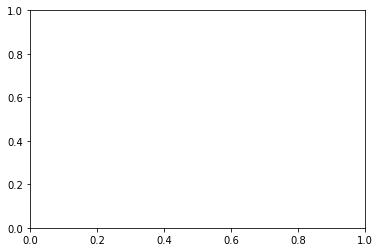

In [0]:
cycleGAN = cygan()
cycleGAN.train(lambda_val = 10, epochs = 20)
cycleGAN.show_losses()



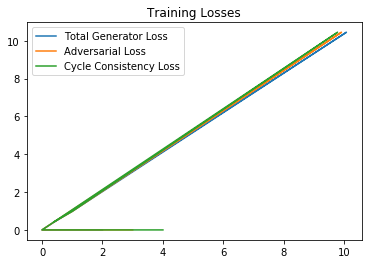

In [0]:
cycleGAN.show_glosses()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch - 0, Batch - 0, D_loss 0.335348 acc  38%, (G_loss 14.994694, adv_loss 0.398502, cycle_loss 0.709885) , time 0:01:14.118995


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch - 0, Batch - 1, D_loss 0.280593 acc  55%, (G_loss 16.067421, adv_loss 0.509955, cycle_loss 0.752375) , time 0:01:15.091480
Epoch - 0, Batch - 2, D_loss 0.237686 acc  65%, (G_loss 14.890421, adv_loss 0.603900, cycle_loss 0.684131) , time 0:01:15.762647
Epoch - 0, Batch - 3, D_loss 0.299511 acc  59%, (G_loss 11.791338, adv_loss 0.571936, cycle_loss 0.532373) , time 0:01:16.425005
Epoch - 0, Batch - 4, D_loss 0.210942 acc  69%, (G_loss 13.041765, adv_loss 0.604191, cycle_loss 0.591669) , time 0:01:17.087123
Epoch - 0, Batch - 5, D_loss 0.294088 acc  63%, (G_loss 13.378111, adv_loss 0.614327, cycle_loss 0.607473) , time 0:01:17.738838
Epoch - 0, Batch - 6, D_loss 0.236069 acc  69%, (G_loss 12.811451, adv_loss 0.627771, cycle_loss 0.577795) , time 0:01:18.390009
Epoch - 0, Batch - 7, D_loss 0.153143 acc  80%, (G_loss 11.878391, adv_loss 0.674930, cycle_loss 0.526427) , time 0:01:19.043497
Epoch - 0, Batch - 8, D_loss 0.143119 acc  84%, (G_loss 11.513107, adv_loss 0.669686, cycle_loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 51, D_loss 0.159320 acc  79%, (G_loss 9.479107, adv_loss 0.711349, cycle_loss 0.402820) , time 0:01:48.202385
Epoch - 0, Batch - 52, D_loss 0.100194 acc  89%, (G_loss 9.604435, adv_loss 0.780452, cycle_loss 0.402177) , time 0:01:48.849449
Epoch - 0, Batch - 53, D_loss 0.110006 acc  87%, (G_loss 11.180626, adv_loss 0.731982, cycle_loss 0.485833) , time 0:01:49.502068
Epoch - 0, Batch - 54, D_loss 0.142984 acc  84%, (G_loss 11.320711, adv_loss 0.722751, cycle_loss 0.493760) , time 0:01:50.154863
Epoch - 0, Batch - 55, D_loss 0.088858 acc  89%, (G_loss 10.611801, adv_loss 0.747165, cycle_loss 0.455874) , time 0:01:50.808067
Epoch - 0, Batch - 56, D_loss 0.109249 acc  88%, (G_loss 13.093273, adv_loss 0.684276, cycle_loss 0.586236) , time 0:01:51.465174
Epoch - 0, Batch - 57, D_loss 0.105773 acc  88%, (G_loss 9.198036, adv_loss 0.720844, cycle_loss 0.387817) , time 0:01:52.117660
Epoch - 0, Batch - 58, D_loss 0.079121 acc  92%, (G_loss 11.124989, adv_loss 0.769318, cycle_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 101, D_loss 0.077970 acc  90%, (G_loss 10.109934, adv_loss 0.836151, cycle_loss 0.421882) , time 0:02:21.285724
Epoch - 0, Batch - 102, D_loss 0.044564 acc  95%, (G_loss 10.288671, adv_loss 0.837839, cycle_loss 0.430650) , time 0:02:21.942584
Epoch - 0, Batch - 103, D_loss 0.044441 acc  95%, (G_loss 9.709166, adv_loss 0.834951, cycle_loss 0.401963) , time 0:02:22.608568
Epoch - 0, Batch - 104, D_loss 0.036229 acc  97%, (G_loss 12.920652, adv_loss 0.863575, cycle_loss 0.559675) , time 0:02:23.257690
Epoch - 0, Batch - 105, D_loss 0.039792 acc  96%, (G_loss 9.971441, adv_loss 0.875592, cycle_loss 0.411013) , time 0:02:23.916206
Epoch - 0, Batch - 106, D_loss 0.036254 acc  96%, (G_loss 11.935425, adv_loss 0.878925, cycle_loss 0.508879) , time 0:02:24.574276
Epoch - 0, Batch - 107, D_loss 0.028221 acc  96%, (G_loss 12.002730, adv_loss 0.892812, cycle_loss 0.510855) , time 0:02:25.229626
Epoch - 0, Batch - 108, D_loss 0.028965 acc  97%, (G_loss 12.338120, adv_loss 0.89123

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 151, D_loss 0.005614 acc  99%, (G_loss 11.192928, adv_loss 0.939171, cycle_loss 0.465729) , time 0:02:54.351100
Epoch - 0, Batch - 152, D_loss 0.043552 acc  95%, (G_loss 10.792238, adv_loss 0.886714, cycle_loss 0.450940) , time 0:02:55.002843
Epoch - 0, Batch - 153, D_loss 0.027458 acc  96%, (G_loss 10.753242, adv_loss 0.901429, cycle_loss 0.447519) , time 0:02:55.651496
Epoch - 0, Batch - 154, D_loss 0.009195 acc  99%, (G_loss 14.823048, adv_loss 0.911349, cycle_loss 0.650017) , time 0:02:56.298776
Epoch - 0, Batch - 155, D_loss 0.021967 acc  97%, (G_loss 9.648720, adv_loss 0.926728, cycle_loss 0.389763) , time 0:02:56.970512
Epoch - 0, Batch - 156, D_loss 0.005273 acc 100%, (G_loss 10.974796, adv_loss 0.927949, cycle_loss 0.455945) , time 0:02:57.630273
Epoch - 0, Batch - 157, D_loss 0.005528 acc  99%, (G_loss 11.295778, adv_loss 0.921116, cycle_loss 0.472677) , time 0:02:58.279265
Epoch - 0, Batch - 158, D_loss 0.008576 acc  99%, (G_loss 9.953042, adv_loss 0.93883

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 201, D_loss 0.000394 acc 100%, (G_loss 11.492342, adv_loss 0.972210, cycle_loss 0.477396) , time 0:03:27.408454
Epoch - 0, Batch - 202, D_loss 0.003443 acc 100%, (G_loss 11.496489, adv_loss 0.954819, cycle_loss 0.479343) , time 0:03:28.058022
Epoch - 0, Batch - 203, D_loss 0.000701 acc 100%, (G_loss 10.220098, adv_loss 0.967252, cycle_loss 0.414280) , time 0:03:28.714407
Epoch - 0, Batch - 204, D_loss 0.000417 acc 100%, (G_loss 11.057504, adv_loss 0.966604, cycle_loss 0.456215) , time 0:03:29.364730
Epoch - 0, Batch - 205, D_loss 0.001034 acc 100%, (G_loss 11.973406, adv_loss 0.950559, cycle_loss 0.503614) , time 0:03:30.017730
Epoch - 0, Batch - 206, D_loss 0.000482 acc 100%, (G_loss 13.062750, adv_loss 0.964339, cycle_loss 0.556704) , time 0:03:30.668058
Epoch - 0, Batch - 207, D_loss 0.003603 acc  99%, (G_loss 10.733984, adv_loss 0.963967, cycle_loss 0.440303) , time 0:03:31.327171
Epoch - 0, Batch - 208, D_loss 0.000763 acc 100%, (G_loss 9.884762, adv_loss 0.9572

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 251, D_loss 0.000207 acc 100%, (G_loss 12.464483, adv_loss 0.974914, cycle_loss 0.525733) , time 0:04:00.881132
Epoch - 0, Batch - 252, D_loss 0.000401 acc 100%, (G_loss 10.773150, adv_loss 0.972782, cycle_loss 0.441379) , time 0:04:01.542438
Epoch - 0, Batch - 253, D_loss 0.000237 acc 100%, (G_loss 10.363533, adv_loss 0.978374, cycle_loss 0.420339) , time 0:04:02.197762
Epoch - 0, Batch - 254, D_loss 0.000306 acc 100%, (G_loss 10.981367, adv_loss 0.973424, cycle_loss 0.451726) , time 0:04:02.863748
Epoch - 0, Batch - 255, D_loss 0.001171 acc 100%, (G_loss 10.344114, adv_loss 0.975978, cycle_loss 0.419608) , time 0:04:03.519300
Epoch - 0, Batch - 256, D_loss 0.000156 acc 100%, (G_loss 12.536279, adv_loss 0.978263, cycle_loss 0.528988) , time 0:04:04.173469
Epoch - 0, Batch - 257, D_loss 0.000271 acc 100%, (G_loss 10.436035, adv_loss 0.977393, cycle_loss 0.424062) , time 0:04:04.832474
Epoch - 0, Batch - 258, D_loss 0.000205 acc 100%, (G_loss 13.061039, adv_loss 0.975

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 301, D_loss 0.000264 acc 100%, (G_loss 11.107332, adv_loss 0.976955, cycle_loss 0.457671) , time 0:04:33.965766
Epoch - 0, Batch - 302, D_loss 0.000223 acc 100%, (G_loss 11.905962, adv_loss 0.973793, cycle_loss 0.497919) , time 0:04:34.616286
Epoch - 0, Batch - 303, D_loss 0.000248 acc 100%, (G_loss 10.881273, adv_loss 0.972445, cycle_loss 0.446819) , time 0:04:35.268923
Epoch - 0, Batch - 304, D_loss 0.000292 acc 100%, (G_loss 11.330888, adv_loss 0.970889, cycle_loss 0.469456) , time 0:04:35.927102
Epoch - 0, Batch - 305, D_loss 0.074336 acc  89%, (G_loss 9.480271, adv_loss 0.850831, cycle_loss 0.388930) , time 0:04:36.590392
Epoch - 0, Batch - 306, D_loss 0.079466 acc  88%, (G_loss 11.945999, adv_loss 0.919895, cycle_loss 0.505310) , time 0:04:37.254931
Epoch - 0, Batch - 307, D_loss 0.043534 acc  93%, (G_loss 9.937309, adv_loss 0.900172, cycle_loss 0.406848) , time 0:04:37.901380
Epoch - 0, Batch - 308, D_loss 0.008074 acc  99%, (G_loss 11.967018, adv_loss 0.95887

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 351, D_loss 0.001149 acc 100%, (G_loss 12.770117, adv_loss 0.967217, cycle_loss 0.541784) , time 0:05:07.008636
Epoch - 0, Batch - 352, D_loss 0.001088 acc 100%, (G_loss 12.542787, adv_loss 0.953414, cycle_loss 0.531798) , time 0:05:07.654180
Epoch - 0, Batch - 353, D_loss 0.000568 acc 100%, (G_loss 10.940529, adv_loss 0.964875, cycle_loss 0.450539) , time 0:05:08.303578
Epoch - 0, Batch - 354, D_loss 0.001159 acc 100%, (G_loss 10.522588, adv_loss 0.966315, cycle_loss 0.429498) , time 0:05:08.956038
Epoch - 0, Batch - 355, D_loss 0.000603 acc 100%, (G_loss 12.480369, adv_loss 0.965465, cycle_loss 0.527472) , time 0:05:09.607077
Epoch - 0, Batch - 356, D_loss 0.000465 acc 100%, (G_loss 11.928322, adv_loss 0.968173, cycle_loss 0.499599) , time 0:05:10.264139
Epoch - 0, Batch - 357, D_loss 0.000241 acc 100%, (G_loss 11.393763, adv_loss 0.973332, cycle_loss 0.472355) , time 0:05:10.929472
Epoch - 0, Batch - 358, D_loss 0.000480 acc 100%, (G_loss 10.626497, adv_loss 0.969

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 1, D_loss 0.000103 acc 100%, (G_loss 10.685188, adv_loss 0.981327, cycle_loss 0.436127) , time 0:05:39.354104
Epoch - 1, Batch - 2, D_loss 0.000129 acc 100%, (G_loss 11.744274, adv_loss 0.979940, cycle_loss 0.489220) , time 0:05:40.022639
Epoch - 1, Batch - 3, D_loss 0.000438 acc 100%, (G_loss 9.256981, adv_loss 0.976369, cycle_loss 0.365212) , time 0:05:40.671194
Epoch - 1, Batch - 4, D_loss 0.000207 acc 100%, (G_loss 10.935573, adv_loss 0.977904, cycle_loss 0.448988) , time 0:05:41.329742
Epoch - 1, Batch - 5, D_loss 0.000129 acc 100%, (G_loss 11.627493, adv_loss 0.980527, cycle_loss 0.483322) , time 0:05:41.982760
Epoch - 1, Batch - 6, D_loss 0.000135 acc 100%, (G_loss 11.119359, adv_loss 0.981873, cycle_loss 0.457781) , time 0:05:42.635548
Epoch - 1, Batch - 7, D_loss 0.000199 acc 100%, (G_loss 10.549438, adv_loss 0.980337, cycle_loss 0.429438) , time 0:05:43.287881
Epoch - 1, Batch - 8, D_loss 0.000117 acc 100%, (G_loss 10.558329, adv_loss 0.984000, cycle_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 51, D_loss 0.000307 acc 100%, (G_loss 9.431814, adv_loss 0.986604, cycle_loss 0.372930) , time 0:06:12.400667
Epoch - 1, Batch - 52, D_loss 0.000128 acc 100%, (G_loss 9.342982, adv_loss 0.987508, cycle_loss 0.368398) , time 0:06:13.056065
Epoch - 1, Batch - 53, D_loss 0.000209 acc 100%, (G_loss 10.608388, adv_loss 0.977229, cycle_loss 0.432696) , time 0:06:13.717337
Epoch - 1, Batch - 54, D_loss 0.000274 acc 100%, (G_loss 11.553368, adv_loss 0.983083, cycle_loss 0.479360) , time 0:06:14.374327
Epoch - 1, Batch - 55, D_loss 0.000160 acc 100%, (G_loss 9.878672, adv_loss 0.980678, cycle_loss 0.395866) , time 0:06:15.031992
Epoch - 1, Batch - 56, D_loss 0.000131 acc 100%, (G_loss 13.202106, adv_loss 0.984296, cycle_loss 0.561676) , time 0:06:15.693058
Epoch - 1, Batch - 57, D_loss 0.000188 acc 100%, (G_loss 8.764346, adv_loss 0.983823, cycle_loss 0.339835) , time 0:06:16.358833
Epoch - 1, Batch - 58, D_loss 0.000141 acc 100%, (G_loss 10.715036, adv_loss 0.979427, cycle_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 101, D_loss 0.000337 acc 100%, (G_loss 9.787809, adv_loss 0.981231, cycle_loss 0.391267) , time 0:06:45.469289
Epoch - 1, Batch - 102, D_loss 0.000225 acc 100%, (G_loss 10.193512, adv_loss 0.982157, cycle_loss 0.411460) , time 0:06:46.121272
Epoch - 1, Batch - 103, D_loss 0.000324 acc 100%, (G_loss 9.562986, adv_loss 0.983040, cycle_loss 0.379845) , time 0:06:46.781957
Epoch - 1, Batch - 104, D_loss 0.000519 acc 100%, (G_loss 12.730709, adv_loss 0.965439, cycle_loss 0.539992) , time 0:06:47.430298
Epoch - 1, Batch - 105, D_loss 0.000398 acc 100%, (G_loss 9.660487, adv_loss 0.982948, cycle_loss 0.384730) , time 0:06:48.091179
Epoch - 1, Batch - 106, D_loss 0.001836 acc  99%, (G_loss 11.847937, adv_loss 0.979833, cycle_loss 0.494414) , time 0:06:48.743786
Epoch - 1, Batch - 107, D_loss 0.000271 acc 100%, (G_loss 11.561458, adv_loss 0.985087, cycle_loss 0.479564) , time 0:06:49.395598
Epoch - 1, Batch - 108, D_loss 0.001238 acc 100%, (G_loss 12.250000, adv_loss 0.963707

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 151, D_loss 0.000109 acc 100%, (G_loss 11.260548, adv_loss 0.981868, cycle_loss 0.464841) , time 0:07:18.588495
Epoch - 1, Batch - 152, D_loss 0.000117 acc 100%, (G_loss 10.688714, adv_loss 0.984449, cycle_loss 0.435991) , time 0:07:19.242526
Epoch - 1, Batch - 153, D_loss 0.000097 acc 100%, (G_loss 10.701490, adv_loss 0.984431, cycle_loss 0.436631) , time 0:07:19.896515
Epoch - 1, Batch - 154, D_loss 0.000145 acc 100%, (G_loss 14.751870, adv_loss 0.980585, cycle_loss 0.639535) , time 0:07:20.544727
Epoch - 1, Batch - 155, D_loss 0.000265 acc 100%, (G_loss 9.183540, adv_loss 0.984813, cycle_loss 0.360696) , time 0:07:21.199313
Epoch - 1, Batch - 156, D_loss 0.000068 acc 100%, (G_loss 10.825047, adv_loss 0.987619, cycle_loss 0.442490) , time 0:07:21.863743
Epoch - 1, Batch - 157, D_loss 0.000072 acc 100%, (G_loss 11.206663, adv_loss 0.985643, cycle_loss 0.461769) , time 0:07:22.514577
Epoch - 1, Batch - 158, D_loss 0.000094 acc 100%, (G_loss 9.427094, adv_loss 0.98424

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 201, D_loss 0.000063 acc 100%, (G_loss 11.017404, adv_loss 0.988664, cycle_loss 0.452004) , time 0:07:51.712065
Epoch - 1, Batch - 202, D_loss 0.000241 acc 100%, (G_loss 11.332485, adv_loss 0.986392, cycle_loss 0.467985) , time 0:07:52.360859
Epoch - 1, Batch - 203, D_loss 0.000071 acc 100%, (G_loss 9.949255, adv_loss 0.988160, cycle_loss 0.398647) , time 0:07:53.015201
Epoch - 1, Batch - 204, D_loss 0.000051 acc 100%, (G_loss 10.739681, adv_loss 0.988936, cycle_loss 0.438091) , time 0:07:53.667016
Epoch - 1, Batch - 205, D_loss 0.000097 acc 100%, (G_loss 11.530712, adv_loss 0.984591, cycle_loss 0.478077) , time 0:07:54.320397
Epoch - 1, Batch - 206, D_loss 0.000063 acc 100%, (G_loss 13.576330, adv_loss 0.987067, cycle_loss 0.580110) , time 0:07:54.980512
Epoch - 1, Batch - 207, D_loss 0.000161 acc 100%, (G_loss 10.187780, adv_loss 0.987970, cycle_loss 0.410592) , time 0:07:55.628212
Epoch - 1, Batch - 208, D_loss 0.000067 acc 100%, (G_loss 9.498184, adv_loss 0.98778

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 251, D_loss 0.000041 acc 100%, (G_loss 12.242569, adv_loss 0.987772, cycle_loss 0.513351) , time 0:08:24.732907
Epoch - 1, Batch - 252, D_loss 0.000077 acc 100%, (G_loss 10.639325, adv_loss 0.987108, cycle_loss 0.433255) , time 0:08:25.381048
Epoch - 1, Batch - 253, D_loss 0.000072 acc 100%, (G_loss 9.725222, adv_loss 0.987967, cycle_loss 0.387464) , time 0:08:26.037687
Epoch - 1, Batch - 254, D_loss 0.000057 acc 100%, (G_loss 10.569681, adv_loss 0.988946, cycle_loss 0.429589) , time 0:08:26.697310
Epoch - 1, Batch - 255, D_loss 0.000068 acc 100%, (G_loss 10.069003, adv_loss 0.989925, cycle_loss 0.404458) , time 0:08:27.354623
Epoch - 1, Batch - 256, D_loss 0.000031 acc 100%, (G_loss 12.404805, adv_loss 0.989546, cycle_loss 0.521286) , time 0:08:28.011840
Epoch - 1, Batch - 257, D_loss 0.000053 acc 100%, (G_loss 10.004306, adv_loss 0.989256, cycle_loss 0.401290) , time 0:08:28.663420
Epoch - 1, Batch - 258, D_loss 0.000032 acc 100%, (G_loss 12.676897, adv_loss 0.9898

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 301, D_loss 0.000044 acc 100%, (G_loss 10.833134, adv_loss 0.990082, cycle_loss 0.442648) , time 0:08:57.803483
Epoch - 1, Batch - 302, D_loss 0.000030 acc 100%, (G_loss 11.623438, adv_loss 0.990002, cycle_loss 0.482172) , time 0:08:58.464910
Epoch - 1, Batch - 303, D_loss 0.000040 acc 100%, (G_loss 10.453590, adv_loss 0.988186, cycle_loss 0.423861) , time 0:08:59.120015
Epoch - 1, Batch - 304, D_loss 0.000043 acc 100%, (G_loss 11.029167, adv_loss 0.987573, cycle_loss 0.452701) , time 0:08:59.785772
Epoch - 1, Batch - 305, D_loss 0.001830 acc  99%, (G_loss 9.620024, adv_loss 0.988401, cycle_loss 0.382161) , time 0:09:00.435582
Epoch - 1, Batch - 306, D_loss 0.000100 acc 100%, (G_loss 11.467597, adv_loss 0.985020, cycle_loss 0.474878) , time 0:09:01.092445
Epoch - 1, Batch - 307, D_loss 0.000205 acc 100%, (G_loss 9.713233, adv_loss 0.986213, cycle_loss 0.387040) , time 0:09:01.753834
Epoch - 1, Batch - 308, D_loss 0.000061 acc 100%, (G_loss 11.659933, adv_loss 0.98631

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 351, D_loss 0.000030 acc 100%, (G_loss 12.227990, adv_loss 0.989551, cycle_loss 0.512444) , time 0:09:30.970964
Epoch - 1, Batch - 352, D_loss 0.000085 acc 100%, (G_loss 12.565002, adv_loss 0.982909, cycle_loss 0.529959) , time 0:09:31.617114
Epoch - 1, Batch - 353, D_loss 0.000035 acc 100%, (G_loss 10.556451, adv_loss 0.988244, cycle_loss 0.428998) , time 0:09:32.265415
Epoch - 1, Batch - 354, D_loss 0.000065 acc 100%, (G_loss 10.359842, adv_loss 0.987341, cycle_loss 0.419258) , time 0:09:32.912906
Epoch - 1, Batch - 355, D_loss 0.000079 acc 100%, (G_loss 11.649852, adv_loss 0.987581, cycle_loss 0.483735) , time 0:09:33.572581
Epoch - 1, Batch - 356, D_loss 0.000045 acc 100%, (G_loss 11.367818, adv_loss 0.988765, cycle_loss 0.469514) , time 0:09:34.234867
Epoch - 1, Batch - 357, D_loss 0.000049 acc 100%, (G_loss 10.945587, adv_loss 0.986784, cycle_loss 0.448601) , time 0:09:34.890448
Epoch - 1, Batch - 358, D_loss 0.000036 acc 100%, (G_loss 10.268206, adv_loss 0.989

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 1, D_loss 0.000023 acc 100%, (G_loss 10.521748, adv_loss 0.991869, cycle_loss 0.426900) , time 0:10:03.378586
Epoch - 2, Batch - 2, D_loss 0.000026 acc 100%, (G_loss 11.563053, adv_loss 0.991911, cycle_loss 0.478962) , time 0:10:04.033685
Epoch - 2, Batch - 3, D_loss 0.000081 acc 100%, (G_loss 9.216168, adv_loss 0.989248, cycle_loss 0.361884) , time 0:10:04.679797
Epoch - 2, Batch - 4, D_loss 0.000028 acc 100%, (G_loss 10.740474, adv_loss 0.990800, cycle_loss 0.437944) , time 0:10:05.334021
Epoch - 2, Batch - 5, D_loss 0.000025 acc 100%, (G_loss 11.325152, adv_loss 0.992405, cycle_loss 0.467017) , time 0:10:05.990422
Epoch - 2, Batch - 6, D_loss 0.000028 acc 100%, (G_loss 10.837673, adv_loss 0.991309, cycle_loss 0.442753) , time 0:10:06.642739
Epoch - 2, Batch - 7, D_loss 0.000034 acc 100%, (G_loss 10.312678, adv_loss 0.991403, cycle_loss 0.416494) , time 0:10:07.297426
Epoch - 2, Batch - 8, D_loss 0.000024 acc 100%, (G_loss 10.145132, adv_loss 0.991854, cycle_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 51, D_loss 0.000064 acc 100%, (G_loss 9.173897, adv_loss 0.989303, cycle_loss 0.359765) , time 0:10:36.418431
Epoch - 2, Batch - 52, D_loss 0.000050 acc 100%, (G_loss 9.195781, adv_loss 0.989416, cycle_loss 0.360847) , time 0:10:37.079445
Epoch - 2, Batch - 53, D_loss 0.000071 acc 100%, (G_loss 9.925400, adv_loss 0.986742, cycle_loss 0.397596) , time 0:10:37.740260
Epoch - 2, Batch - 54, D_loss 0.000058 acc 100%, (G_loss 10.908224, adv_loss 0.990029, cycle_loss 0.446408) , time 0:10:38.394040
Epoch - 2, Batch - 55, D_loss 0.000034 acc 100%, (G_loss 9.557802, adv_loss 0.990293, cycle_loss 0.378861) , time 0:10:39.054472
Epoch - 2, Batch - 56, D_loss 0.000049 acc 100%, (G_loss 12.525223, adv_loss 0.990058, cycle_loss 0.527255) , time 0:10:39.713972
Epoch - 2, Batch - 57, D_loss 0.000050 acc 100%, (G_loss 8.567204, adv_loss 0.990637, cycle_loss 0.329297) , time 0:10:40.361612
Epoch - 2, Batch - 58, D_loss 0.000051 acc 100%, (G_loss 10.473166, adv_loss 0.986807, cycle_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 101, D_loss 0.000028 acc 100%, (G_loss 9.704086, adv_loss 0.990806, cycle_loss 0.386124) , time 0:11:09.455194
Epoch - 2, Batch - 102, D_loss 0.000024 acc 100%, (G_loss 10.039732, adv_loss 0.991795, cycle_loss 0.402807) , time 0:11:10.117934
Epoch - 2, Batch - 103, D_loss 0.000018 acc 100%, (G_loss 9.364943, adv_loss 0.992869, cycle_loss 0.368960) , time 0:11:10.771812
Epoch - 2, Batch - 104, D_loss 0.000043 acc 100%, (G_loss 12.603617, adv_loss 0.987410, cycle_loss 0.531440) , time 0:11:11.424758
Epoch - 2, Batch - 105, D_loss 0.000042 acc 100%, (G_loss 9.443400, adv_loss 0.991923, cycle_loss 0.372978) , time 0:11:12.080935
Epoch - 2, Batch - 106, D_loss 0.000027 acc 100%, (G_loss 11.716487, adv_loss 0.991227, cycle_loss 0.486702) , time 0:11:12.730506
Epoch - 2, Batch - 107, D_loss 0.000012 acc 100%, (G_loss 11.739815, adv_loss 0.994737, cycle_loss 0.487517) , time 0:11:13.387925
Epoch - 2, Batch - 108, D_loss 0.000057 acc 100%, (G_loss 12.039307, adv_loss 0.986168

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 151, D_loss 0.000035 acc 100%, (G_loss 10.700865, adv_loss 0.989506, cycle_loss 0.436093) , time 0:11:42.503935
Epoch - 2, Batch - 152, D_loss 0.000023 acc 100%, (G_loss 10.429475, adv_loss 0.992527, cycle_loss 0.422221) , time 0:11:43.157829
Epoch - 2, Batch - 153, D_loss 0.000024 acc 100%, (G_loss 10.430237, adv_loss 0.991655, cycle_loss 0.422346) , time 0:11:43.814034
Epoch - 2, Batch - 154, D_loss 0.000026 acc 100%, (G_loss 14.678945, adv_loss 0.990660, cycle_loss 0.634881) , time 0:11:44.462534
Epoch - 2, Batch - 155, D_loss 0.000035 acc 100%, (G_loss 8.951032, adv_loss 0.991331, cycle_loss 0.348418) , time 0:11:45.125491
Epoch - 2, Batch - 156, D_loss 0.000026 acc 100%, (G_loss 10.661957, adv_loss 0.992370, cycle_loss 0.433861) , time 0:11:45.774431
Epoch - 2, Batch - 157, D_loss 0.000020 acc 100%, (G_loss 11.000977, adv_loss 0.992062, cycle_loss 0.450843) , time 0:11:46.431721
Epoch - 2, Batch - 158, D_loss 0.000030 acc 100%, (G_loss 9.231160, adv_loss 0.99137

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 201, D_loss 0.000018 acc 100%, (G_loss 10.956945, adv_loss 0.993594, cycle_loss 0.448488) , time 0:12:15.565225
Epoch - 2, Batch - 202, D_loss 0.000062 acc 100%, (G_loss 11.174871, adv_loss 0.991727, cycle_loss 0.459571) , time 0:12:16.216869
Epoch - 2, Batch - 203, D_loss 0.000020 acc 100%, (G_loss 9.996859, adv_loss 0.993201, cycle_loss 0.400523) , time 0:12:16.872652
Epoch - 2, Batch - 204, D_loss 0.000016 acc 100%, (G_loss 10.635218, adv_loss 0.993820, cycle_loss 0.432379) , time 0:12:17.526435
Epoch - 2, Batch - 205, D_loss 0.000023 acc 100%, (G_loss 11.315634, adv_loss 0.992885, cycle_loss 0.466493) , time 0:12:18.174104
Epoch - 2, Batch - 206, D_loss 0.000018 acc 100%, (G_loss 12.934067, adv_loss 0.992462, cycle_loss 0.547457) , time 0:12:18.826092
Epoch - 2, Batch - 207, D_loss 0.000036 acc 100%, (G_loss 10.235389, adv_loss 0.993474, cycle_loss 0.412422) , time 0:12:19.482934
Epoch - 2, Batch - 208, D_loss 0.000015 acc 100%, (G_loss 9.496117, adv_loss 0.99409

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 251, D_loss 0.000012 acc 100%, (G_loss 12.025277, adv_loss 0.993549, cycle_loss 0.501909) , time 0:12:48.585811
Epoch - 2, Batch - 252, D_loss 0.000028 acc 100%, (G_loss 10.634192, adv_loss 0.993149, cycle_loss 0.432395) , time 0:12:49.239555
Epoch - 2, Batch - 253, D_loss 0.000032 acc 100%, (G_loss 9.787941, adv_loss 0.992167, cycle_loss 0.390180) , time 0:12:49.894735
Epoch - 2, Batch - 254, D_loss 0.000030 acc 100%, (G_loss 10.628961, adv_loss 0.991319, cycle_loss 0.432316) , time 0:12:50.543229
Epoch - 2, Batch - 255, D_loss 0.000044 acc 100%, (G_loss 9.936681, adv_loss 0.993179, cycle_loss 0.397516) , time 0:12:51.194766
Epoch - 2, Batch - 256, D_loss 0.000011 acc 100%, (G_loss 12.417713, adv_loss 0.993588, cycle_loss 0.521527) , time 0:12:51.846019
Epoch - 2, Batch - 257, D_loss 0.000021 acc 100%, (G_loss 9.993148, adv_loss 0.993024, cycle_loss 0.400355) , time 0:12:52.497627
Epoch - 2, Batch - 258, D_loss 0.000014 acc 100%, (G_loss 12.564366, adv_loss 0.993291

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 301, D_loss 0.000022 acc 100%, (G_loss 10.733387, adv_loss 0.992338, cycle_loss 0.437436) , time 0:13:21.569689
Epoch - 2, Batch - 302, D_loss 0.000014 acc 100%, (G_loss 11.484756, adv_loss 0.992643, cycle_loss 0.474973) , time 0:13:22.224907
Epoch - 2, Batch - 303, D_loss 0.000023 acc 100%, (G_loss 10.399476, adv_loss 0.990823, cycle_loss 0.420891) , time 0:13:22.892594
Epoch - 2, Batch - 304, D_loss 0.000025 acc 100%, (G_loss 11.038897, adv_loss 0.989984, cycle_loss 0.452946) , time 0:13:23.538458
Epoch - 2, Batch - 305, D_loss 0.000211 acc 100%, (G_loss 9.565711, adv_loss 0.993381, cycle_loss 0.378947) , time 0:13:24.190682
Epoch - 2, Batch - 306, D_loss 0.000026 acc 100%, (G_loss 11.388419, adv_loss 0.991096, cycle_loss 0.470311) , time 0:13:24.839354
Epoch - 2, Batch - 307, D_loss 0.000024 acc 100%, (G_loss 9.593315, adv_loss 0.992125, cycle_loss 0.380453) , time 0:13:25.487814
Epoch - 2, Batch - 308, D_loss 0.000015 acc 100%, (G_loss 11.512088, adv_loss 0.99250

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 351, D_loss 0.000013 acc 100%, (G_loss 12.129665, adv_loss 0.993524, cycle_loss 0.507131) , time 0:13:54.566896
Epoch - 2, Batch - 352, D_loss 0.000026 acc 100%, (G_loss 12.459018, adv_loss 0.989952, cycle_loss 0.523956) , time 0:13:55.214519
Epoch - 2, Batch - 353, D_loss 0.000015 acc 100%, (G_loss 10.419650, adv_loss 0.992713, cycle_loss 0.421711) , time 0:13:55.870911
Epoch - 2, Batch - 354, D_loss 0.000026 acc 100%, (G_loss 10.180781, adv_loss 0.991605, cycle_loss 0.409879) , time 0:13:56.527368
Epoch - 2, Batch - 355, D_loss 0.000033 acc 100%, (G_loss 11.455618, adv_loss 0.992086, cycle_loss 0.473572) , time 0:13:57.178008
Epoch - 2, Batch - 356, D_loss 0.000019 acc 100%, (G_loss 11.128029, adv_loss 0.992547, cycle_loss 0.457147) , time 0:13:57.836696
Epoch - 2, Batch - 357, D_loss 0.000019 acc 100%, (G_loss 10.753258, adv_loss 0.991452, cycle_loss 0.438518) , time 0:13:58.484439
Epoch - 2, Batch - 358, D_loss 0.000022 acc 100%, (G_loss 10.104696, adv_loss 0.992

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 1, D_loss 0.000014 acc 100%, (G_loss 10.459787, adv_loss 0.993475, cycle_loss 0.423642) , time 0:14:27.057032
Epoch - 3, Batch - 2, D_loss 0.000015 acc 100%, (G_loss 11.447103, adv_loss 0.993733, cycle_loss 0.472982) , time 0:14:27.710298
Epoch - 3, Batch - 3, D_loss 0.000053 acc 100%, (G_loss 9.094990, adv_loss 0.989561, cycle_loss 0.355793) , time 0:14:28.368409
Epoch - 3, Batch - 4, D_loss 0.000016 acc 100%, (G_loss 10.496467, adv_loss 0.992463, cycle_loss 0.425577) , time 0:14:29.034844
Epoch - 3, Batch - 5, D_loss 0.000015 acc 100%, (G_loss 11.115215, adv_loss 0.993966, cycle_loss 0.456364) , time 0:14:29.700189
Epoch - 3, Batch - 6, D_loss 0.000016 acc 100%, (G_loss 10.625670, adv_loss 0.993363, cycle_loss 0.431947) , time 0:14:30.363594
Epoch - 3, Batch - 7, D_loss 0.000018 acc 100%, (G_loss 10.098130, adv_loss 0.993856, cycle_loss 0.405521) , time 0:14:31.024029
Epoch - 3, Batch - 8, D_loss 0.000012 acc 100%, (G_loss 10.010161, adv_loss 0.993873, cycle_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 51, D_loss 0.000037 acc 100%, (G_loss 9.082603, adv_loss 0.992126, cycle_loss 0.354917) , time 0:15:00.122902
Epoch - 3, Batch - 52, D_loss 0.000038 acc 100%, (G_loss 9.137114, adv_loss 0.991943, cycle_loss 0.357661) , time 0:15:00.773866
Epoch - 3, Batch - 53, D_loss 0.000030 acc 100%, (G_loss 9.780507, adv_loss 0.991951, cycle_loss 0.389830) , time 0:15:01.420813
Epoch - 3, Batch - 54, D_loss 0.000027 acc 100%, (G_loss 10.730152, adv_loss 0.993855, cycle_loss 0.437122) , time 0:15:02.068949
Epoch - 3, Batch - 55, D_loss 0.000016 acc 100%, (G_loss 9.413908, adv_loss 0.993695, cycle_loss 0.371326) , time 0:15:02.720385
Epoch - 3, Batch - 56, D_loss 0.000030 acc 100%, (G_loss 12.372561, adv_loss 0.992921, cycle_loss 0.519336) , time 0:15:03.381575
Epoch - 3, Batch - 57, D_loss 0.000028 acc 100%, (G_loss 8.599585, adv_loss 0.994818, cycle_loss 0.330497) , time 0:15:04.048372
Epoch - 3, Batch - 58, D_loss 0.000021 acc 100%, (G_loss 10.383619, adv_loss 0.992208, cycle_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 101, D_loss 0.000015 acc 100%, (G_loss 9.609138, adv_loss 0.993726, cycle_loss 0.381084) , time 0:15:33.133265
Epoch - 3, Batch - 102, D_loss 0.000016 acc 100%, (G_loss 9.944265, adv_loss 0.993669, cycle_loss 0.397846) , time 0:15:33.784768
Epoch - 3, Batch - 103, D_loss 0.000010 acc 100%, (G_loss 9.268468, adv_loss 0.994830, cycle_loss 0.363940) , time 0:15:34.444588
Epoch - 3, Batch - 104, D_loss 0.000020 acc 100%, (G_loss 12.523354, adv_loss 0.991364, cycle_loss 0.527031) , time 0:15:35.100879
Epoch - 3, Batch - 105, D_loss 0.000022 acc 100%, (G_loss 9.230522, adv_loss 0.993983, cycle_loss 0.362128) , time 0:15:35.764370
Epoch - 3, Batch - 106, D_loss 0.000015 acc 100%, (G_loss 11.445921, adv_loss 0.993863, cycle_loss 0.472910) , time 0:15:36.421086
Epoch - 3, Batch - 107, D_loss 0.000009 acc 100%, (G_loss 11.473229, adv_loss 0.995023, cycle_loss 0.474159) , time 0:15:37.085437
Epoch - 3, Batch - 108, D_loss 0.000053 acc 100%, (G_loss 11.883453, adv_loss 0.987098,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 151, D_loss 0.000020 acc 100%, (G_loss 10.529119, adv_loss 0.991774, cycle_loss 0.427279) , time 0:16:06.234424
Epoch - 3, Batch - 152, D_loss 0.000014 acc 100%, (G_loss 10.304579, adv_loss 0.993885, cycle_loss 0.415840) , time 0:16:06.882428
Epoch - 3, Batch - 153, D_loss 0.000013 acc 100%, (G_loss 10.407650, adv_loss 0.993898, cycle_loss 0.420993) , time 0:16:07.545438
Epoch - 3, Batch - 154, D_loss 0.000016 acc 100%, (G_loss 14.508543, adv_loss 0.992058, cycle_loss 0.626221) , time 0:16:08.201660
Epoch - 3, Batch - 155, D_loss 0.000021 acc 100%, (G_loss 8.863537, adv_loss 0.993440, cycle_loss 0.343833) , time 0:16:08.860184
Epoch - 3, Batch - 156, D_loss 0.000017 acc 100%, (G_loss 10.531065, adv_loss 0.993446, cycle_loss 0.427209) , time 0:16:09.509581
Epoch - 3, Batch - 157, D_loss 0.000013 acc 100%, (G_loss 10.829569, adv_loss 0.993167, cycle_loss 0.442162) , time 0:16:10.165941
Epoch - 3, Batch - 158, D_loss 0.000029 acc 100%, (G_loss 9.203029, adv_loss 0.99093

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 201, D_loss 0.000013 acc 100%, (G_loss 10.749263, adv_loss 0.994114, cycle_loss 0.438052) , time 0:16:39.252516
Epoch - 3, Batch - 202, D_loss 0.000045 acc 100%, (G_loss 10.988976, adv_loss 0.992131, cycle_loss 0.450236) , time 0:16:39.914544
Epoch - 3, Batch - 203, D_loss 0.000019 acc 100%, (G_loss 9.785339, adv_loss 0.992466, cycle_loss 0.390020) , time 0:16:40.573066
Epoch - 3, Batch - 204, D_loss 0.000018 acc 100%, (G_loss 10.464392, adv_loss 0.992494, cycle_loss 0.423970) , time 0:16:41.225062
Epoch - 3, Batch - 205, D_loss 0.000026 acc 100%, (G_loss 11.054710, adv_loss 0.991346, cycle_loss 0.453601) , time 0:16:41.886513
Epoch - 3, Batch - 206, D_loss 0.000013 acc 100%, (G_loss 13.209656, adv_loss 0.993074, cycle_loss 0.561175) , time 0:16:42.540475
Epoch - 3, Batch - 207, D_loss 0.000024 acc 100%, (G_loss 10.221279, adv_loss 0.994525, cycle_loss 0.411611) , time 0:16:43.189517
Epoch - 3, Batch - 208, D_loss 0.000009 acc 100%, (G_loss 9.544067, adv_loss 0.99599

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 251, D_loss 0.000006 acc 100%, (G_loss 12.032120, adv_loss 0.995435, cycle_loss 0.502062) , time 0:17:12.304044
Epoch - 3, Batch - 252, D_loss 0.000017 acc 100%, (G_loss 10.496031, adv_loss 0.995182, cycle_loss 0.425283) , time 0:17:12.954649
Epoch - 3, Batch - 253, D_loss 0.000015 acc 100%, (G_loss 9.639215, adv_loss 0.994454, cycle_loss 0.382515) , time 0:17:13.612786
Epoch - 3, Batch - 254, D_loss 0.000014 acc 100%, (G_loss 10.312687, adv_loss 0.994392, cycle_loss 0.416195) , time 0:17:14.273629
Epoch - 3, Batch - 255, D_loss 0.000021 acc 100%, (G_loss 9.692161, adv_loss 0.995437, cycle_loss 0.385064) , time 0:17:14.922273
Epoch - 3, Batch - 256, D_loss 0.000006 acc 100%, (G_loss 12.213778, adv_loss 0.995788, cycle_loss 0.511110) , time 0:17:15.568045
Epoch - 3, Batch - 257, D_loss 0.000014 acc 100%, (G_loss 9.760245, adv_loss 0.994539, cycle_loss 0.388558) , time 0:17:16.227481
Epoch - 3, Batch - 258, D_loss 0.000007 acc 100%, (G_loss 12.456738, adv_loss 0.995571

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 301, D_loss 0.000012 acc 100%, (G_loss 10.656483, adv_loss 0.994985, cycle_loss 0.433326) , time 0:17:45.322499
Epoch - 3, Batch - 302, D_loss 0.000009 acc 100%, (G_loss 11.349635, adv_loss 0.994547, cycle_loss 0.468027) , time 0:17:45.976404
Epoch - 3, Batch - 303, D_loss 0.000011 acc 100%, (G_loss 10.348513, adv_loss 0.994339, cycle_loss 0.417992) , time 0:17:46.634340
Epoch - 3, Batch - 304, D_loss 0.000011 acc 100%, (G_loss 10.899555, adv_loss 0.994003, cycle_loss 0.445577) , time 0:17:47.298416
Epoch - 3, Batch - 305, D_loss 0.000133 acc 100%, (G_loss 9.614827, adv_loss 0.995232, cycle_loss 0.381218) , time 0:17:47.958138
Epoch - 3, Batch - 306, D_loss 0.000013 acc 100%, (G_loss 11.306170, adv_loss 0.993775, cycle_loss 0.465931) , time 0:17:48.617498
Epoch - 3, Batch - 307, D_loss 0.000012 acc 100%, (G_loss 9.658508, adv_loss 0.994883, cycle_loss 0.383437) , time 0:17:49.277763
Epoch - 3, Batch - 308, D_loss 0.000008 acc 100%, (G_loss 11.433867, adv_loss 0.99500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 351, D_loss 0.000008 acc 100%, (G_loss 12.029835, adv_loss 0.994854, cycle_loss 0.502006) , time 0:18:18.412636
Epoch - 3, Batch - 352, D_loss 0.000016 acc 100%, (G_loss 12.250266, adv_loss 0.991843, cycle_loss 0.513329) , time 0:18:19.067909
Epoch - 3, Batch - 353, D_loss 0.000010 acc 100%, (G_loss 10.321160, adv_loss 0.994615, cycle_loss 0.416597) , time 0:18:19.719116
Epoch - 3, Batch - 354, D_loss 0.000015 acc 100%, (G_loss 10.173522, adv_loss 0.994337, cycle_loss 0.409242) , time 0:18:20.369219
Epoch - 3, Batch - 355, D_loss 0.000025 acc 100%, (G_loss 11.227319, adv_loss 0.993613, cycle_loss 0.462005) , time 0:18:21.024749
Epoch - 3, Batch - 356, D_loss 0.000010 acc 100%, (G_loss 11.122936, adv_loss 0.994756, cycle_loss 0.456671) , time 0:18:21.689422
Epoch - 3, Batch - 357, D_loss 0.000008 acc 100%, (G_loss 10.608746, adv_loss 0.994389, cycle_loss 0.430998) , time 0:18:22.337394
Epoch - 3, Batch - 358, D_loss 0.000012 acc 100%, (G_loss 9.920837, adv_loss 0.9942

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 1, D_loss 0.000008 acc 100%, (G_loss 10.309250, adv_loss 0.995255, cycle_loss 0.415937) , time 0:18:50.742410
Epoch - 4, Batch - 2, D_loss 0.000013 acc 100%, (G_loss 11.358728, adv_loss 0.994130, cycle_loss 0.468523) , time 0:18:51.404939
Epoch - 4, Batch - 3, D_loss 0.000028 acc 100%, (G_loss 8.997722, adv_loss 0.992099, cycle_loss 0.350676) , time 0:18:52.055461
Epoch - 4, Batch - 4, D_loss 0.000012 acc 100%, (G_loss 10.409249, adv_loss 0.993682, cycle_loss 0.421094) , time 0:18:52.708437
Epoch - 4, Batch - 5, D_loss 0.000010 acc 100%, (G_loss 10.962010, adv_loss 0.995101, cycle_loss 0.448590) , time 0:18:53.358572
Epoch - 4, Batch - 6, D_loss 0.000010 acc 100%, (G_loss 10.411705, adv_loss 0.994731, cycle_loss 0.421112) , time 0:18:54.010769
Epoch - 4, Batch - 7, D_loss 0.000012 acc 100%, (G_loss 10.076588, adv_loss 0.995044, cycle_loss 0.404325) , time 0:18:54.676093
Epoch - 4, Batch - 8, D_loss 0.000007 acc 100%, (G_loss 9.850777, adv_loss 0.995175, cycle_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 51, D_loss 0.000016 acc 100%, (G_loss 8.867777, adv_loss 0.995539, cycle_loss 0.343835) , time 0:19:23.894210
Epoch - 4, Batch - 52, D_loss 0.000012 acc 100%, (G_loss 9.006976, adv_loss 0.995353, cycle_loss 0.350814) , time 0:19:24.544304
Epoch - 4, Batch - 53, D_loss 0.000016 acc 100%, (G_loss 9.459270, adv_loss 0.993724, cycle_loss 0.373591) , time 0:19:25.202946
Epoch - 4, Batch - 54, D_loss 0.000021 acc 100%, (G_loss 10.609474, adv_loss 0.993614, cycle_loss 0.431112) , time 0:19:25.864979
Epoch - 4, Batch - 55, D_loss 0.000010 acc 100%, (G_loss 9.489666, adv_loss 0.994870, cycle_loss 0.374996) , time 0:19:26.514600
Epoch - 4, Batch - 56, D_loss 0.000023 acc 100%, (G_loss 12.179564, adv_loss 0.993623, cycle_loss 0.509616) , time 0:19:27.169519
Epoch - 4, Batch - 57, D_loss 0.000019 acc 100%, (G_loss 8.399206, adv_loss 0.994894, cycle_loss 0.320471) , time 0:19:27.824954
Epoch - 4, Batch - 58, D_loss 0.000017 acc 100%, (G_loss 10.393096, adv_loss 0.992948, cycle_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 101, D_loss 0.000009 acc 100%, (G_loss 9.605453, adv_loss 0.995089, cycle_loss 0.380764) , time 0:19:56.984457
Epoch - 4, Batch - 102, D_loss 0.000009 acc 100%, (G_loss 9.854231, adv_loss 0.995292, cycle_loss 0.393182) , time 0:19:57.634119
Epoch - 4, Batch - 103, D_loss 0.000006 acc 100%, (G_loss 9.052324, adv_loss 0.995968, cycle_loss 0.353019) , time 0:19:58.285434
Epoch - 4, Batch - 104, D_loss 0.000011 acc 100%, (G_loss 12.564308, adv_loss 0.993732, cycle_loss 0.528842) , time 0:19:58.933788
Epoch - 4, Batch - 105, D_loss 0.000016 acc 100%, (G_loss 8.966528, adv_loss 0.994433, cycle_loss 0.348883) , time 0:19:59.590757
Epoch - 4, Batch - 106, D_loss 0.000010 acc 100%, (G_loss 11.289933, adv_loss 0.995263, cycle_loss 0.464970) , time 0:20:00.243781
Epoch - 4, Batch - 107, D_loss 0.000006 acc 100%, (G_loss 11.358081, adv_loss 0.996170, cycle_loss 0.468287) , time 0:20:00.891148
Epoch - 4, Batch - 108, D_loss 0.000069 acc 100%, (G_loss 11.691095, adv_loss 0.985042,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 151, D_loss 0.000010 acc 100%, (G_loss 10.316357, adv_loss 0.994484, cycle_loss 0.416369) , time 0:20:29.985885
Epoch - 4, Batch - 152, D_loss 0.000008 acc 100%, (G_loss 10.148252, adv_loss 0.995624, cycle_loss 0.407850) , time 0:20:30.632913
Epoch - 4, Batch - 153, D_loss 0.000008 acc 100%, (G_loss 10.060682, adv_loss 0.995301, cycle_loss 0.403504) , time 0:20:31.284310
Epoch - 4, Batch - 154, D_loss 0.000009 acc 100%, (G_loss 14.428141, adv_loss 0.994028, cycle_loss 0.622004) , time 0:20:31.945158
Epoch - 4, Batch - 155, D_loss 0.000014 acc 100%, (G_loss 8.626431, adv_loss 0.994927, cycle_loss 0.331829) , time 0:20:32.597665
Epoch - 4, Batch - 156, D_loss 0.000011 acc 100%, (G_loss 10.356936, adv_loss 0.994789, cycle_loss 0.418368) , time 0:20:33.254437
Epoch - 4, Batch - 157, D_loss 0.000008 acc 100%, (G_loss 10.680660, adv_loss 0.994856, cycle_loss 0.434547) , time 0:20:33.914067
Epoch - 4, Batch - 158, D_loss 0.000015 acc 100%, (G_loss 8.943502, adv_loss 0.99333

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 201, D_loss 0.000008 acc 100%, (G_loss 10.676979, adv_loss 0.995826, cycle_loss 0.434266) , time 0:21:02.996228
Epoch - 4, Batch - 202, D_loss 0.000032 acc 100%, (G_loss 10.810964, adv_loss 0.993468, cycle_loss 0.441201) , time 0:21:03.648976
Epoch - 4, Batch - 203, D_loss 0.000007 acc 100%, (G_loss 9.647366, adv_loss 0.995940, cycle_loss 0.382774) , time 0:21:04.297220
Epoch - 4, Batch - 204, D_loss 0.000009 acc 100%, (G_loss 10.368047, adv_loss 0.995223, cycle_loss 0.418880) , time 0:21:04.951436
Epoch - 4, Batch - 205, D_loss 0.000012 acc 100%, (G_loss 10.916624, adv_loss 0.994866, cycle_loss 0.446345) , time 0:21:05.610760
Epoch - 4, Batch - 206, D_loss 0.000005 acc 100%, (G_loss 12.625305, adv_loss 0.996625, cycle_loss 0.531603) , time 0:21:06.262701
Epoch - 4, Batch - 207, D_loss 0.000019 acc 100%, (G_loss 9.925215, adv_loss 0.994980, cycle_loss 0.396763) , time 0:21:06.914241
Epoch - 4, Batch - 208, D_loss 0.000006 acc 100%, (G_loss 9.099369, adv_loss 0.996157

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 251, D_loss 0.000004 acc 100%, (G_loss 11.678061, adv_loss 0.996058, cycle_loss 0.484297) , time 0:21:36.065094
Epoch - 4, Batch - 252, D_loss 0.000012 acc 100%, (G_loss 10.208143, adv_loss 0.995931, cycle_loss 0.410814) , time 0:21:36.723387
Epoch - 4, Batch - 253, D_loss 0.000011 acc 100%, (G_loss 9.636751, adv_loss 0.995077, cycle_loss 0.382330) , time 0:21:37.381404
Epoch - 4, Batch - 254, D_loss 0.000009 acc 100%, (G_loss 10.156716, adv_loss 0.995726, cycle_loss 0.408263) , time 0:21:38.029932
Epoch - 4, Batch - 255, D_loss 0.000012 acc 100%, (G_loss 9.562266, adv_loss 0.996679, cycle_loss 0.378445) , time 0:21:38.683339
Epoch - 4, Batch - 256, D_loss 0.000004 acc 100%, (G_loss 12.011179, adv_loss 0.996661, cycle_loss 0.500893) , time 0:21:39.338448
Epoch - 4, Batch - 257, D_loss 0.000008 acc 100%, (G_loss 9.527813, adv_loss 0.996100, cycle_loss 0.376781) , time 0:21:39.987915
Epoch - 4, Batch - 258, D_loss 0.000004 acc 100%, (G_loss 12.171423, adv_loss 0.996552

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 301, D_loss 0.000008 acc 100%, (G_loss 10.403641, adv_loss 0.995962, cycle_loss 0.420586) , time 0:22:09.116312
Epoch - 4, Batch - 302, D_loss 0.000005 acc 100%, (G_loss 10.952751, adv_loss 0.996004, cycle_loss 0.448037) , time 0:22:09.772852
Epoch - 4, Batch - 303, D_loss 0.000008 acc 100%, (G_loss 9.854914, adv_loss 0.995128, cycle_loss 0.393233) , time 0:22:10.418951
Epoch - 4, Batch - 304, D_loss 0.000008 acc 100%, (G_loss 10.627683, adv_loss 0.994733, cycle_loss 0.431911) , time 0:22:11.074747
Epoch - 4, Batch - 305, D_loss 0.000084 acc 100%, (G_loss 8.995696, adv_loss 0.996236, cycle_loss 0.350161) , time 0:22:11.736391
Epoch - 4, Batch - 306, D_loss 0.000008 acc 100%, (G_loss 11.200981, adv_loss 0.995469, cycle_loss 0.460502) , time 0:22:12.393728
Epoch - 4, Batch - 307, D_loss 0.000008 acc 100%, (G_loss 9.230391, adv_loss 0.995796, cycle_loss 0.361940) , time 0:22:13.049183
Epoch - 4, Batch - 308, D_loss 0.000005 acc 100%, (G_loss 11.427418, adv_loss 0.996136

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 351, D_loss 0.000004 acc 100%, (G_loss 12.029436, adv_loss 0.996150, cycle_loss 0.501857) , time 0:22:42.127120
Epoch - 4, Batch - 352, D_loss 0.000009 acc 100%, (G_loss 12.187639, adv_loss 0.993852, cycle_loss 0.509997) , time 0:22:42.786109
Epoch - 4, Batch - 353, D_loss 0.000007 acc 100%, (G_loss 10.048567, adv_loss 0.995287, cycle_loss 0.402900) , time 0:22:43.438305
Epoch - 4, Batch - 354, D_loss 0.000010 acc 100%, (G_loss 9.927964, adv_loss 0.995337, cycle_loss 0.396865) , time 0:22:44.094707
Epoch - 4, Batch - 355, D_loss 0.000016 acc 100%, (G_loss 11.075356, adv_loss 0.994718, cycle_loss 0.454296) , time 0:22:44.758211
Epoch - 4, Batch - 356, D_loss 0.000007 acc 100%, (G_loss 10.975358, adv_loss 0.996098, cycle_loss 0.449158) , time 0:22:45.413206
Epoch - 4, Batch - 357, D_loss 0.000006 acc 100%, (G_loss 10.480159, adv_loss 0.995467, cycle_loss 0.424461) , time 0:22:46.072211
Epoch - 4, Batch - 358, D_loss 0.000008 acc 100%, (G_loss 9.883590, adv_loss 0.99550

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 1, D_loss 0.000005 acc 100%, (G_loss 10.196980, adv_loss 0.996396, cycle_loss 0.410209) , time 0:23:15.136863
Epoch - 5, Batch - 2, D_loss 0.000006 acc 100%, (G_loss 11.129989, adv_loss 0.996407, cycle_loss 0.456859) , time 0:23:15.787544
Epoch - 5, Batch - 3, D_loss 0.000012 acc 100%, (G_loss 8.852457, adv_loss 0.995849, cycle_loss 0.343038) , time 0:23:16.437487
Epoch - 5, Batch - 4, D_loss 0.000005 acc 100%, (G_loss 10.138000, adv_loss 0.996553, cycle_loss 0.407245) , time 0:23:17.084491
Epoch - 5, Batch - 5, D_loss 0.000006 acc 100%, (G_loss 10.773275, adv_loss 0.996741, cycle_loss 0.438990) , time 0:23:17.741868
Epoch - 5, Batch - 6, D_loss 0.000005 acc 100%, (G_loss 10.007399, adv_loss 0.996456, cycle_loss 0.400724) , time 0:23:18.392800
Epoch - 5, Batch - 7, D_loss 0.000009 acc 100%, (G_loss 9.949421, adv_loss 0.996140, cycle_loss 0.397857) , time 0:23:19.043421
Epoch - 5, Batch - 8, D_loss 0.000005 acc 100%, (G_loss 9.658876, adv_loss 0.996320, cycle_loss 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 51, D_loss 0.000010 acc 100%, (G_loss 8.743789, adv_loss 0.996672, cycle_loss 0.337522) , time 0:23:48.130990
Epoch - 5, Batch - 52, D_loss 0.000007 acc 100%, (G_loss 8.899933, adv_loss 0.996629, cycle_loss 0.345334) , time 0:23:48.782646
Epoch - 5, Batch - 53, D_loss 0.000011 acc 100%, (G_loss 9.389502, adv_loss 0.994970, cycle_loss 0.369978) , time 0:23:49.444294
Epoch - 5, Batch - 54, D_loss 0.000011 acc 100%, (G_loss 10.343321, adv_loss 0.996016, cycle_loss 0.417564) , time 0:23:50.112638
Epoch - 5, Batch - 55, D_loss 0.000006 acc 100%, (G_loss 9.406160, adv_loss 0.996142, cycle_loss 0.370694) , time 0:23:50.765736
Epoch - 5, Batch - 56, D_loss 0.000013 acc 100%, (G_loss 12.120387, adv_loss 0.995524, cycle_loss 0.506467) , time 0:23:51.416361
Epoch - 5, Batch - 57, D_loss 0.000011 acc 100%, (G_loss 8.123180, adv_loss 0.996310, cycle_loss 0.306528) , time 0:23:52.074580
Epoch - 5, Batch - 58, D_loss 0.000009 acc 100%, (G_loss 10.197393, adv_loss 0.995363, cycle_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 101, D_loss 0.000005 acc 100%, (G_loss 9.662724, adv_loss 0.996428, cycle_loss 0.383493) , time 0:24:21.093550
Epoch - 5, Batch - 102, D_loss 0.000006 acc 100%, (G_loss 9.838692, adv_loss 0.996503, cycle_loss 0.392284) , time 0:24:21.743445
Epoch - 5, Batch - 103, D_loss 0.000004 acc 100%, (G_loss 8.940628, adv_loss 0.996952, cycle_loss 0.347336) , time 0:24:22.408245
Epoch - 5, Batch - 104, D_loss 0.000005 acc 100%, (G_loss 12.552839, adv_loss 0.996383, cycle_loss 0.528004) , time 0:24:23.058394
Epoch - 5, Batch - 105, D_loss 0.000008 acc 100%, (G_loss 8.779331, adv_loss 0.996853, cycle_loss 0.339281) , time 0:24:23.709414
Epoch - 5, Batch - 106, D_loss 0.000006 acc 100%, (G_loss 11.304747, adv_loss 0.996627, cycle_loss 0.465575) , time 0:24:24.363865
Epoch - 5, Batch - 107, D_loss 0.000004 acc 100%, (G_loss 11.723880, adv_loss 0.996896, cycle_loss 0.486504) , time 0:24:25.030177
Epoch - 5, Batch - 108, D_loss 0.000013 acc 100%, (G_loss 11.681158, adv_loss 0.993127,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 151, D_loss 0.000008 acc 100%, (G_loss 10.044979, adv_loss 0.995690, cycle_loss 0.402680) , time 0:24:54.272331
Epoch - 5, Batch - 152, D_loss 0.000007 acc 100%, (G_loss 9.919193, adv_loss 0.995551, cycle_loss 0.396405) , time 0:24:54.924281
Epoch - 5, Batch - 153, D_loss 0.000004 acc 100%, (G_loss 9.877688, adv_loss 0.996479, cycle_loss 0.394236) , time 0:24:55.573542
Epoch - 5, Batch - 154, D_loss 0.000004 acc 100%, (G_loss 14.405933, adv_loss 0.996221, cycle_loss 0.620675) , time 0:24:56.225720
Epoch - 5, Batch - 155, D_loss 0.000008 acc 100%, (G_loss 8.414211, adv_loss 0.996226, cycle_loss 0.321088) , time 0:24:56.871085
Epoch - 5, Batch - 156, D_loss 0.000006 acc 100%, (G_loss 10.293348, adv_loss 0.996163, cycle_loss 0.415051) , time 0:24:57.523730
Epoch - 5, Batch - 157, D_loss 0.000005 acc 100%, (G_loss 10.411905, adv_loss 0.996089, cycle_loss 0.420986) , time 0:24:58.172875
Epoch - 5, Batch - 158, D_loss 0.000016 acc 100%, (G_loss 9.057125, adv_loss 0.994002,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 201, D_loss 0.000005 acc 100%, (G_loss 10.405026, adv_loss 0.996440, cycle_loss 0.420607) , time 0:25:27.176593
Epoch - 5, Batch - 202, D_loss 0.000018 acc 100%, (G_loss 10.644717, adv_loss 0.995331, cycle_loss 0.432703) , time 0:25:27.829837
Epoch - 5, Batch - 203, D_loss 0.000005 acc 100%, (G_loss 9.436543, adv_loss 0.996642, cycle_loss 0.372163) , time 0:25:28.485090
Epoch - 5, Batch - 204, D_loss 0.000004 acc 100%, (G_loss 10.128957, adv_loss 0.997135, cycle_loss 0.406734) , time 0:25:29.143440
Epoch - 5, Batch - 205, D_loss 0.000007 acc 100%, (G_loss 10.817879, adv_loss 0.996337, cycle_loss 0.441260) , time 0:25:29.791645
Epoch - 5, Batch - 206, D_loss 0.000003 acc 100%, (G_loss 12.155119, adv_loss 0.997296, cycle_loss 0.508026) , time 0:25:30.446870
Epoch - 5, Batch - 207, D_loss 0.000010 acc 100%, (G_loss 9.758427, adv_loss 0.996670, cycle_loss 0.388254) , time 0:25:31.096527
Epoch - 5, Batch - 208, D_loss 0.000005 acc 100%, (G_loss 9.109121, adv_loss 0.996806

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 251, D_loss 0.000003 acc 100%, (G_loss 11.560496, adv_loss 0.997083, cycle_loss 0.478317) , time 0:26:00.200986
Epoch - 5, Batch - 252, D_loss 0.000008 acc 100%, (G_loss 10.085377, adv_loss 0.995773, cycle_loss 0.404692) , time 0:26:00.848202
Epoch - 5, Batch - 253, D_loss 0.000006 acc 100%, (G_loss 9.021781, adv_loss 0.996340, cycle_loss 0.351455) , time 0:26:01.515138
Epoch - 5, Batch - 254, D_loss 0.000006 acc 100%, (G_loss 9.936459, adv_loss 0.996140, cycle_loss 0.397209) , time 0:26:02.172733
Epoch - 5, Batch - 255, D_loss 0.000007 acc 100%, (G_loss 9.370787, adv_loss 0.997148, cycle_loss 0.368825) , time 0:26:02.822327
Epoch - 5, Batch - 256, D_loss 0.000003 acc 100%, (G_loss 11.877688, adv_loss 0.997183, cycle_loss 0.494166) , time 0:26:03.472851
Epoch - 5, Batch - 257, D_loss 0.000005 acc 100%, (G_loss 9.172818, adv_loss 0.996579, cycle_loss 0.358983) , time 0:26:04.125144
Epoch - 5, Batch - 258, D_loss 0.000003 acc 100%, (G_loss 12.098132, adv_loss 0.996937,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 301, D_loss 0.000005 acc 100%, (G_loss 10.300598, adv_loss 0.996474, cycle_loss 0.415383) , time 0:26:33.257778
Epoch - 5, Batch - 302, D_loss 0.000004 acc 100%, (G_loss 10.924941, adv_loss 0.996624, cycle_loss 0.446585) , time 0:26:33.926837
Epoch - 5, Batch - 303, D_loss 0.000005 acc 100%, (G_loss 9.736187, adv_loss 0.996390, cycle_loss 0.387170) , time 0:26:34.574361
Epoch - 5, Batch - 304, D_loss 0.000004 acc 100%, (G_loss 10.345047, adv_loss 0.996559, cycle_loss 0.417596) , time 0:26:35.233289
Epoch - 5, Batch - 305, D_loss 0.000049 acc 100%, (G_loss 8.876090, adv_loss 0.997259, cycle_loss 0.344079) , time 0:26:35.894733
Epoch - 5, Batch - 306, D_loss 0.000005 acc 100%, (G_loss 11.072179, adv_loss 0.996168, cycle_loss 0.453992) , time 0:26:36.543003
Epoch - 5, Batch - 307, D_loss 0.000005 acc 100%, (G_loss 9.204382, adv_loss 0.996509, cycle_loss 0.360568) , time 0:26:37.209962
Epoch - 5, Batch - 308, D_loss 0.000003 acc 100%, (G_loss 11.255359, adv_loss 0.997193

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 351, D_loss 0.000003 acc 100%, (G_loss 11.595737, adv_loss 0.997213, cycle_loss 0.480066) , time 0:27:06.298891
Epoch - 5, Batch - 352, D_loss 0.000003 acc 100%, (G_loss 12.088095, adv_loss 0.996788, cycle_loss 0.504726) , time 0:27:06.951630
Epoch - 5, Batch - 353, D_loss 0.000003 acc 100%, (G_loss 9.852199, adv_loss 0.997088, cycle_loss 0.392901) , time 0:27:07.603115
Epoch - 5, Batch - 354, D_loss 0.000007 acc 100%, (G_loss 9.791319, adv_loss 0.996112, cycle_loss 0.389955) , time 0:27:08.264572
Epoch - 5, Batch - 355, D_loss 0.000011 acc 100%, (G_loss 10.662550, adv_loss 0.996057, cycle_loss 0.433522) , time 0:27:08.925740
Epoch - 5, Batch - 356, D_loss 0.000004 acc 100%, (G_loss 10.840952, adv_loss 0.997035, cycle_loss 0.442344) , time 0:27:09.576364
Epoch - 5, Batch - 357, D_loss 0.000003 acc 100%, (G_loss 10.220106, adv_loss 0.997053, cycle_loss 0.411300) , time 0:27:10.219318
Epoch - 5, Batch - 358, D_loss 0.000005 acc 100%, (G_loss 9.717611, adv_loss 0.996790

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 1, D_loss 0.000004 acc 100%, (G_loss 9.932188, adv_loss 0.996707, cycle_loss 0.396939) , time 0:27:38.625077
Epoch - 6, Batch - 2, D_loss 0.000005 acc 100%, (G_loss 10.997011, adv_loss 0.996660, cycle_loss 0.450185) , time 0:27:39.280030
Epoch - 6, Batch - 3, D_loss 0.000008 acc 100%, (G_loss 8.741991, adv_loss 0.995945, cycle_loss 0.337505) , time 0:27:39.928751
Epoch - 6, Batch - 4, D_loss 0.000003 acc 100%, (G_loss 10.012674, adv_loss 0.996960, cycle_loss 0.400938) , time 0:27:40.583444
Epoch - 6, Batch - 5, D_loss 0.000003 acc 100%, (G_loss 10.657930, adv_loss 0.997398, cycle_loss 0.433157) , time 0:27:41.244458
Epoch - 6, Batch - 6, D_loss 0.000003 acc 100%, (G_loss 9.904938, adv_loss 0.997213, cycle_loss 0.395526) , time 0:27:41.897686
Epoch - 6, Batch - 7, D_loss 0.000005 acc 100%, (G_loss 9.728735, adv_loss 0.996953, cycle_loss 0.386742) , time 0:27:42.556335
Epoch - 6, Batch - 8, D_loss 0.000003 acc 100%, (G_loss 9.602070, adv_loss 0.997219, cycle_loss 0.380

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 51, D_loss 0.000007 acc 100%, (G_loss 8.476582, adv_loss 0.997102, cycle_loss 0.324119) , time 0:28:11.615790
Epoch - 6, Batch - 52, D_loss 0.000006 acc 100%, (G_loss 8.481359, adv_loss 0.996376, cycle_loss 0.324430) , time 0:28:12.278733
Epoch - 6, Batch - 53, D_loss 0.000010 acc 100%, (G_loss 9.297258, adv_loss 0.994554, cycle_loss 0.365408) , time 0:28:12.931462
Epoch - 6, Batch - 54, D_loss 0.000008 acc 100%, (G_loss 10.224018, adv_loss 0.995877, cycle_loss 0.411613) , time 0:28:13.584860
Epoch - 6, Batch - 55, D_loss 0.000004 acc 100%, (G_loss 9.114735, adv_loss 0.996556, cycle_loss 0.356081) , time 0:28:14.244491
Epoch - 6, Batch - 56, D_loss 0.000008 acc 100%, (G_loss 11.604380, adv_loss 0.995723, cycle_loss 0.480647) , time 0:28:14.898194
Epoch - 6, Batch - 57, D_loss 0.000007 acc 100%, (G_loss 7.913600, adv_loss 0.997015, cycle_loss 0.295979) , time 0:28:15.558804
Epoch - 6, Batch - 58, D_loss 0.000009 acc 100%, (G_loss 9.982874, adv_loss 0.995099, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 101, D_loss 0.000003 acc 100%, (G_loss 9.195839, adv_loss 0.997256, cycle_loss 0.360066) , time 0:28:44.613559
Epoch - 6, Batch - 102, D_loss 0.000004 acc 100%, (G_loss 9.400143, adv_loss 0.997270, cycle_loss 0.370280) , time 0:28:45.273050
Epoch - 6, Batch - 103, D_loss 0.000002 acc 100%, (G_loss 8.777038, adv_loss 0.997585, cycle_loss 0.339093) , time 0:28:45.931115
Epoch - 6, Batch - 104, D_loss 0.000003 acc 100%, (G_loss 12.124020, adv_loss 0.996915, cycle_loss 0.506510) , time 0:28:46.591921
Epoch - 6, Batch - 105, D_loss 0.000005 acc 100%, (G_loss 8.819263, adv_loss 0.997251, cycle_loss 0.341238) , time 0:28:47.242824
Epoch - 6, Batch - 106, D_loss 0.000004 acc 100%, (G_loss 10.967762, adv_loss 0.997166, cycle_loss 0.448671) , time 0:28:47.893916
Epoch - 6, Batch - 107, D_loss 0.000002 acc 100%, (G_loss 11.229940, adv_loss 0.997710, cycle_loss 0.461726) , time 0:28:48.546839
Epoch - 6, Batch - 108, D_loss 0.000004 acc 100%, (G_loss 11.366661, adv_loss 0.996458,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 151, D_loss 0.000004 acc 100%, (G_loss 9.887140, adv_loss 0.996840, cycle_loss 0.394673) , time 0:29:17.611964
Epoch - 6, Batch - 152, D_loss 0.000004 acc 100%, (G_loss 9.796356, adv_loss 0.996858, cycle_loss 0.390132) , time 0:29:18.263663
Epoch - 6, Batch - 153, D_loss 0.000003 acc 100%, (G_loss 9.806934, adv_loss 0.997164, cycle_loss 0.390630) , time 0:29:18.919887
Epoch - 6, Batch - 154, D_loss 0.000003 acc 100%, (G_loss 13.971704, adv_loss 0.996688, cycle_loss 0.598916) , time 0:29:19.565585
Epoch - 6, Batch - 155, D_loss 0.000005 acc 100%, (G_loss 8.299791, adv_loss 0.997181, cycle_loss 0.315271) , time 0:29:20.222706
Epoch - 6, Batch - 156, D_loss 0.000004 acc 100%, (G_loss 10.152653, adv_loss 0.997214, cycle_loss 0.407911) , time 0:29:20.872611
Epoch - 6, Batch - 157, D_loss 0.000002 acc 100%, (G_loss 10.236576, adv_loss 0.997419, cycle_loss 0.412087) , time 0:29:21.525829
Epoch - 6, Batch - 158, D_loss 0.000006 acc 100%, (G_loss 9.008604, adv_loss 0.996135, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 201, D_loss 0.000003 acc 100%, (G_loss 10.469312, adv_loss 0.997602, cycle_loss 0.423705) , time 0:29:50.635279
Epoch - 6, Batch - 202, D_loss 0.000010 acc 100%, (G_loss 10.567398, adv_loss 0.996475, cycle_loss 0.428722) , time 0:29:51.288727
Epoch - 6, Batch - 203, D_loss 0.000002 acc 100%, (G_loss 9.314639, adv_loss 0.997721, cycle_loss 0.365960) , time 0:29:51.943702
Epoch - 6, Batch - 204, D_loss 0.000003 acc 100%, (G_loss 9.974635, adv_loss 0.997677, cycle_loss 0.398964) , time 0:29:52.599331
Epoch - 6, Batch - 205, D_loss 0.000004 acc 100%, (G_loss 10.585800, adv_loss 0.996993, cycle_loss 0.429591) , time 0:29:53.249973
Epoch - 6, Batch - 206, D_loss 0.000002 acc 100%, (G_loss 12.221455, adv_loss 0.997829, cycle_loss 0.511290) , time 0:29:53.912321
Epoch - 6, Batch - 207, D_loss 0.000007 acc 100%, (G_loss 9.366554, adv_loss 0.997274, cycle_loss 0.368600) , time 0:29:54.567983
Epoch - 6, Batch - 208, D_loss 0.000003 acc 100%, (G_loss 8.786572, adv_loss 0.997582,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 251, D_loss 0.000002 acc 100%, (G_loss 11.376251, adv_loss 0.997852, cycle_loss 0.469027) , time 0:30:23.742530
Epoch - 6, Batch - 252, D_loss 0.000004 acc 100%, (G_loss 9.975776, adv_loss 0.997645, cycle_loss 0.399024) , time 0:30:24.391393
Epoch - 6, Batch - 253, D_loss 0.000003 acc 100%, (G_loss 8.977361, adv_loss 0.997306, cycle_loss 0.349137) , time 0:30:25.046749
Epoch - 6, Batch - 254, D_loss 0.000004 acc 100%, (G_loss 9.799785, adv_loss 0.996862, cycle_loss 0.390303) , time 0:30:25.702517
Epoch - 6, Batch - 255, D_loss 0.000004 acc 100%, (G_loss 9.259645, adv_loss 0.997708, cycle_loss 0.363211) , time 0:30:26.358283
Epoch - 6, Batch - 256, D_loss 0.000002 acc 100%, (G_loss 11.684654, adv_loss 0.997779, cycle_loss 0.484455) , time 0:30:27.013433
Epoch - 6, Batch - 257, D_loss 0.000003 acc 100%, (G_loss 9.253406, adv_loss 0.997464, cycle_loss 0.362924) , time 0:30:27.672870
Epoch - 6, Batch - 258, D_loss 0.000002 acc 100%, (G_loss 11.911247, adv_loss 0.997827, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 301, D_loss 0.000003 acc 100%, (G_loss 10.232752, adv_loss 0.997467, cycle_loss 0.411891) , time 0:30:56.861128
Epoch - 6, Batch - 302, D_loss 0.000002 acc 100%, (G_loss 10.923770, adv_loss 0.997272, cycle_loss 0.446461) , time 0:30:57.534419
Epoch - 6, Batch - 303, D_loss 0.000003 acc 100%, (G_loss 9.618298, adv_loss 0.997177, cycle_loss 0.381197) , time 0:30:58.197954
Epoch - 6, Batch - 304, D_loss 0.000003 acc 100%, (G_loss 10.156723, adv_loss 0.997411, cycle_loss 0.408095) , time 0:30:58.852393
Epoch - 6, Batch - 305, D_loss 0.000033 acc 100%, (G_loss 8.772867, adv_loss 0.997718, cycle_loss 0.338872) , time 0:30:59.517692
Epoch - 6, Batch - 306, D_loss 0.000003 acc 100%, (G_loss 11.130907, adv_loss 0.996823, cycle_loss 0.456863) , time 0:31:00.165883
Epoch - 6, Batch - 307, D_loss 0.000004 acc 100%, (G_loss 9.106541, adv_loss 0.997139, cycle_loss 0.355613) , time 0:31:00.815315
Epoch - 6, Batch - 308, D_loss 0.000002 acc 100%, (G_loss 11.058288, adv_loss 0.997667

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 351, D_loss 0.000002 acc 100%, (G_loss 11.494894, adv_loss 0.997512, cycle_loss 0.474994) , time 0:31:29.885175
Epoch - 6, Batch - 352, D_loss 0.000004 acc 100%, (G_loss 11.939358, adv_loss 0.996127, cycle_loss 0.497355) , time 0:31:30.535541
Epoch - 6, Batch - 353, D_loss 0.000002 acc 100%, (G_loss 9.730510, adv_loss 0.997475, cycle_loss 0.386778) , time 0:31:31.200996
Epoch - 6, Batch - 354, D_loss 0.000005 acc 100%, (G_loss 9.666541, adv_loss 0.996705, cycle_loss 0.383657) , time 0:31:31.857608
Epoch - 6, Batch - 355, D_loss 0.000007 acc 100%, (G_loss 10.521755, adv_loss 0.996521, cycle_loss 0.426436) , time 0:31:32.514128
Epoch - 6, Batch - 356, D_loss 0.000003 acc 100%, (G_loss 10.659852, adv_loss 0.997349, cycle_loss 0.433258) , time 0:31:33.174580
Epoch - 6, Batch - 357, D_loss 0.000002 acc 100%, (G_loss 10.123610, adv_loss 0.996993, cycle_loss 0.406481) , time 0:31:33.828631
Epoch - 6, Batch - 358, D_loss 0.000003 acc 100%, (G_loss 9.619354, adv_loss 0.997099

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 1, D_loss 0.000003 acc 100%, (G_loss 9.795539, adv_loss 0.997245, cycle_loss 0.390052) , time 0:32:02.214138
Epoch - 7, Batch - 2, D_loss 0.000003 acc 100%, (G_loss 10.868683, adv_loss 0.997450, cycle_loss 0.443689) , time 0:32:02.872414
Epoch - 7, Batch - 3, D_loss 0.000006 acc 100%, (G_loss 8.642490, adv_loss 0.996478, cycle_loss 0.332477) , time 0:32:03.522119
Epoch - 7, Batch - 4, D_loss 0.000002 acc 100%, (G_loss 9.813758, adv_loss 0.997469, cycle_loss 0.390941) , time 0:32:04.173703
Epoch - 7, Batch - 5, D_loss 0.000002 acc 100%, (G_loss 10.551254, adv_loss 0.997823, cycle_loss 0.427780) , time 0:32:04.829264
Epoch - 7, Batch - 6, D_loss 0.000002 acc 100%, (G_loss 9.742188, adv_loss 0.997628, cycle_loss 0.387347) , time 0:32:05.495720
Epoch - 7, Batch - 7, D_loss 0.000003 acc 100%, (G_loss 9.602499, adv_loss 0.997447, cycle_loss 0.380380) , time 0:32:06.151129
Epoch - 7, Batch - 8, D_loss 0.000002 acc 100%, (G_loss 9.413602, adv_loss 0.997743, cycle_loss 0.3709

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 51, D_loss 0.000004 acc 100%, (G_loss 8.342037, adv_loss 0.998031, cycle_loss 0.317299) , time 0:32:35.381470
Epoch - 7, Batch - 52, D_loss 0.000003 acc 100%, (G_loss 8.328974, adv_loss 0.998005, cycle_loss 0.316648) , time 0:32:36.045511
Epoch - 7, Batch - 53, D_loss 0.000005 acc 100%, (G_loss 9.170593, adv_loss 0.996169, cycle_loss 0.358913) , time 0:32:36.693767
Epoch - 7, Batch - 54, D_loss 0.000005 acc 100%, (G_loss 10.126877, adv_loss 0.997125, cycle_loss 0.406631) , time 0:32:37.354608
Epoch - 7, Batch - 55, D_loss 0.000003 acc 100%, (G_loss 9.041786, adv_loss 0.997598, cycle_loss 0.352329) , time 0:32:38.016705
Epoch - 7, Batch - 56, D_loss 0.000005 acc 100%, (G_loss 11.446819, adv_loss 0.997160, cycle_loss 0.472625) , time 0:32:38.678152
Epoch - 7, Batch - 57, D_loss 0.000004 acc 100%, (G_loss 7.798861, adv_loss 0.997842, cycle_loss 0.290159) , time 0:32:39.333577
Epoch - 7, Batch - 58, D_loss 0.000006 acc 100%, (G_loss 9.856920, adv_loss 0.996393, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 101, D_loss 0.000002 acc 100%, (G_loss 9.120684, adv_loss 0.997837, cycle_loss 0.356250) , time 0:33:08.517389
Epoch - 7, Batch - 102, D_loss 0.000002 acc 100%, (G_loss 9.338518, adv_loss 0.997831, cycle_loss 0.367143) , time 0:33:09.178939
Epoch - 7, Batch - 103, D_loss 0.000002 acc 100%, (G_loss 8.793507, adv_loss 0.998080, cycle_loss 0.339867) , time 0:33:09.843448
Epoch - 7, Batch - 104, D_loss 0.000003 acc 100%, (G_loss 12.022497, adv_loss 0.997398, cycle_loss 0.501385) , time 0:33:10.505361
Epoch - 7, Batch - 105, D_loss 0.000003 acc 100%, (G_loss 8.669701, adv_loss 0.997929, cycle_loss 0.333692) , time 0:33:11.157417
Epoch - 7, Batch - 106, D_loss 0.000002 acc 100%, (G_loss 10.953085, adv_loss 0.997916, cycle_loss 0.447863) , time 0:33:11.810289
Epoch - 7, Batch - 107, D_loss 0.000002 acc 100%, (G_loss 10.983991, adv_loss 0.998141, cycle_loss 0.449385) , time 0:33:12.459665
Epoch - 7, Batch - 108, D_loss 0.000004 acc 100%, (G_loss 11.170281, adv_loss 0.996388,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 151, D_loss 0.000003 acc 100%, (G_loss 9.724348, adv_loss 0.997405, cycle_loss 0.386477) , time 0:33:41.620439
Epoch - 7, Batch - 152, D_loss 0.000003 acc 100%, (G_loss 9.650626, adv_loss 0.997210, cycle_loss 0.382810) , time 0:33:42.266772
Epoch - 7, Batch - 153, D_loss 0.000002 acc 100%, (G_loss 9.731653, adv_loss 0.997415, cycle_loss 0.386841) , time 0:33:42.922062
Epoch - 7, Batch - 154, D_loss 0.000003 acc 100%, (G_loss 13.794414, adv_loss 0.996598, cycle_loss 0.590061) , time 0:33:43.578333
Epoch - 7, Batch - 155, D_loss 0.000003 acc 100%, (G_loss 8.173556, adv_loss 0.997669, cycle_loss 0.308911) , time 0:33:44.227963
Epoch - 7, Batch - 156, D_loss 0.000003 acc 100%, (G_loss 10.094786, adv_loss 0.997337, cycle_loss 0.405006) , time 0:33:44.880191
Epoch - 7, Batch - 157, D_loss 0.000002 acc 100%, (G_loss 10.135162, adv_loss 0.997853, cycle_loss 0.406973) , time 0:33:45.532337
Epoch - 7, Batch - 158, D_loss 0.000005 acc 100%, (G_loss 9.009357, adv_loss 0.996483, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 201, D_loss 0.000002 acc 100%, (G_loss 10.295081, adv_loss 0.998124, cycle_loss 0.414942) , time 0:34:14.643399
Epoch - 7, Batch - 202, D_loss 0.000007 acc 100%, (G_loss 10.622705, adv_loss 0.996964, cycle_loss 0.431439) , time 0:34:15.294122
Epoch - 7, Batch - 203, D_loss 0.000002 acc 100%, (G_loss 9.178591, adv_loss 0.998017, cycle_loss 0.359128) , time 0:34:15.950665
Epoch - 7, Batch - 204, D_loss 0.000002 acc 100%, (G_loss 9.955147, adv_loss 0.998137, cycle_loss 0.397944) , time 0:34:16.604937
Epoch - 7, Batch - 205, D_loss 0.000004 acc 100%, (G_loss 10.490707, adv_loss 0.997273, cycle_loss 0.424808) , time 0:34:17.277666
Epoch - 7, Batch - 206, D_loss 0.000001 acc 100%, (G_loss 11.916561, adv_loss 0.998185, cycle_loss 0.496010) , time 0:34:17.928549
Epoch - 7, Batch - 207, D_loss 0.000004 acc 100%, (G_loss 9.126616, adv_loss 0.997893, cycle_loss 0.356541) , time 0:34:18.588968
Epoch - 7, Batch - 208, D_loss 0.000002 acc 100%, (G_loss 8.692755, adv_loss 0.998133,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 251, D_loss 0.000001 acc 100%, (G_loss 11.362597, adv_loss 0.998003, cycle_loss 0.468330) , time 0:34:47.728043
Epoch - 7, Batch - 252, D_loss 0.000003 acc 100%, (G_loss 9.924639, adv_loss 0.997627, cycle_loss 0.396469) , time 0:34:48.390429
Epoch - 7, Batch - 253, D_loss 0.000002 acc 100%, (G_loss 8.815619, adv_loss 0.997599, cycle_loss 0.341021) , time 0:34:49.050256
Epoch - 7, Batch - 254, D_loss 0.000003 acc 100%, (G_loss 9.723714, adv_loss 0.997317, cycle_loss 0.386454) , time 0:34:49.699901
Epoch - 7, Batch - 255, D_loss 0.000003 acc 100%, (G_loss 9.152184, adv_loss 0.998267, cycle_loss 0.357782) , time 0:34:50.350477
Epoch - 7, Batch - 256, D_loss 0.000001 acc 100%, (G_loss 11.637418, adv_loss 0.998287, cycle_loss 0.482042) , time 0:34:50.998503
Epoch - 7, Batch - 257, D_loss 0.000002 acc 100%, (G_loss 9.128857, adv_loss 0.997715, cycle_loss 0.356671) , time 0:34:51.649119
Epoch - 7, Batch - 258, D_loss 0.000001 acc 100%, (G_loss 11.868425, adv_loss 0.998104, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 301, D_loss 0.000002 acc 100%, (G_loss 10.222494, adv_loss 0.998004, cycle_loss 0.411324) , time 0:35:20.857820
Epoch - 7, Batch - 302, D_loss 0.000001 acc 100%, (G_loss 10.754402, adv_loss 0.997890, cycle_loss 0.437931) , time 0:35:21.516373
Epoch - 7, Batch - 303, D_loss 0.000002 acc 100%, (G_loss 9.619291, adv_loss 0.997859, cycle_loss 0.381179) , time 0:35:22.165391
Epoch - 7, Batch - 304, D_loss 0.000002 acc 100%, (G_loss 10.064512, adv_loss 0.997986, cycle_loss 0.403427) , time 0:35:22.815576
Epoch - 7, Batch - 305, D_loss 0.000022 acc 100%, (G_loss 8.584283, adv_loss 0.998332, cycle_loss 0.329381) , time 0:35:23.465501
Epoch - 7, Batch - 306, D_loss 0.000002 acc 100%, (G_loss 11.218382, adv_loss 0.997600, cycle_loss 0.461159) , time 0:35:24.123443
Epoch - 7, Batch - 307, D_loss 0.000002 acc 100%, (G_loss 9.058449, adv_loss 0.997740, cycle_loss 0.353148) , time 0:35:24.774531
Epoch - 7, Batch - 308, D_loss 0.000001 acc 100%, (G_loss 10.932713, adv_loss 0.998312

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 351, D_loss 0.000001 acc 100%, (G_loss 11.466419, adv_loss 0.998389, cycle_loss 0.473482) , time 0:35:53.843154
Epoch - 7, Batch - 352, D_loss 0.000001 acc 100%, (G_loss 11.795815, adv_loss 0.998290, cycle_loss 0.489962) , time 0:35:54.502441
Epoch - 7, Batch - 353, D_loss 0.000001 acc 100%, (G_loss 9.563253, adv_loss 0.998178, cycle_loss 0.378345) , time 0:35:55.156820
Epoch - 7, Batch - 354, D_loss 0.000003 acc 100%, (G_loss 9.470870, adv_loss 0.997615, cycle_loss 0.373782) , time 0:35:55.806656
Epoch - 7, Batch - 355, D_loss 0.000004 acc 100%, (G_loss 10.446804, adv_loss 0.997509, cycle_loss 0.422589) , time 0:35:56.468069
Epoch - 7, Batch - 356, D_loss 0.000002 acc 100%, (G_loss 10.547848, adv_loss 0.998296, cycle_loss 0.427563) , time 0:35:57.121711
Epoch - 7, Batch - 357, D_loss 0.000002 acc 100%, (G_loss 9.978655, adv_loss 0.997470, cycle_loss 0.399186) , time 0:35:57.771829
Epoch - 7, Batch - 358, D_loss 0.000002 acc 100%, (G_loss 9.638674, adv_loss 0.997699,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 1, D_loss 0.000001 acc 100%, (G_loss 9.720907, adv_loss 0.998150, cycle_loss 0.386230) , time 0:36:26.197607
Epoch - 8, Batch - 2, D_loss 0.000002 acc 100%, (G_loss 10.794443, adv_loss 0.998133, cycle_loss 0.439909) , time 0:36:26.853425
Epoch - 8, Batch - 3, D_loss 0.000003 acc 100%, (G_loss 8.524597, adv_loss 0.997716, cycle_loss 0.326458) , time 0:36:27.503598
Epoch - 8, Batch - 4, D_loss 0.000001 acc 100%, (G_loss 9.821934, adv_loss 0.998118, cycle_loss 0.391285) , time 0:36:28.154223
Epoch - 8, Batch - 5, D_loss 0.000001 acc 100%, (G_loss 10.611564, adv_loss 0.998324, cycle_loss 0.430746) , time 0:36:28.805115
Epoch - 8, Batch - 6, D_loss 0.000002 acc 100%, (G_loss 9.691686, adv_loss 0.998100, cycle_loss 0.384774) , time 0:36:29.465014
Epoch - 8, Batch - 7, D_loss 0.000002 acc 100%, (G_loss 9.613880, adv_loss 0.998014, cycle_loss 0.380893) , time 0:36:30.117438
Epoch - 8, Batch - 8, D_loss 0.000001 acc 100%, (G_loss 9.384124, adv_loss 0.998285, cycle_loss 0.3693

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 51, D_loss 0.000003 acc 100%, (G_loss 8.356624, adv_loss 0.998328, cycle_loss 0.317998) , time 0:36:59.169898
Epoch - 8, Batch - 52, D_loss 0.000002 acc 100%, (G_loss 8.254797, adv_loss 0.998281, cycle_loss 0.312912) , time 0:36:59.820405
Epoch - 8, Batch - 53, D_loss 0.000003 acc 100%, (G_loss 9.292101, adv_loss 0.996896, cycle_loss 0.364915) , time 0:37:00.473866
Epoch - 8, Batch - 54, D_loss 0.000003 acc 100%, (G_loss 10.090581, adv_loss 0.997622, cycle_loss 0.404767) , time 0:37:01.125803
Epoch - 8, Batch - 55, D_loss 0.000002 acc 100%, (G_loss 8.901283, adv_loss 0.998024, cycle_loss 0.345262) , time 0:37:01.774102
Epoch - 8, Batch - 56, D_loss 0.000004 acc 100%, (G_loss 11.337581, adv_loss 0.997380, cycle_loss 0.467141) , time 0:37:02.430032
Epoch - 8, Batch - 57, D_loss 0.000003 acc 100%, (G_loss 7.718789, adv_loss 0.998005, cycle_loss 0.286139) , time 0:37:03.079465
Epoch - 8, Batch - 58, D_loss 0.000004 acc 100%, (G_loss 9.683942, adv_loss 0.996690, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 101, D_loss 0.000001 acc 100%, (G_loss 8.963154, adv_loss 0.998186, cycle_loss 0.348339) , time 0:37:32.180953
Epoch - 8, Batch - 102, D_loss 0.000002 acc 100%, (G_loss 9.242476, adv_loss 0.998159, cycle_loss 0.362308) , time 0:37:32.831543
Epoch - 8, Batch - 103, D_loss 0.000001 acc 100%, (G_loss 8.665100, adv_loss 0.998461, cycle_loss 0.333409) , time 0:37:33.480503
Epoch - 8, Batch - 104, D_loss 0.000002 acc 100%, (G_loss 12.044918, adv_loss 0.997787, cycle_loss 0.502467) , time 0:37:34.129451
Epoch - 8, Batch - 105, D_loss 0.000002 acc 100%, (G_loss 8.683890, adv_loss 0.998170, cycle_loss 0.334377) , time 0:37:34.775973
Epoch - 8, Batch - 106, D_loss 0.000002 acc 100%, (G_loss 10.965669, adv_loss 0.998229, cycle_loss 0.448461) , time 0:37:35.428455
Epoch - 8, Batch - 107, D_loss 0.000001 acc 100%, (G_loss 11.045903, adv_loss 0.998312, cycle_loss 0.452464) , time 0:37:36.072796
Epoch - 8, Batch - 108, D_loss 0.000006 acc 100%, (G_loss 11.158334, adv_loss 0.995836,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 151, D_loss 0.000002 acc 100%, (G_loss 9.890175, adv_loss 0.997773, cycle_loss 0.394731) , time 0:38:05.144625
Epoch - 8, Batch - 152, D_loss 0.000002 acc 100%, (G_loss 9.560716, adv_loss 0.998004, cycle_loss 0.378235) , time 0:38:05.808108
Epoch - 8, Batch - 153, D_loss 0.000001 acc 100%, (G_loss 9.693558, adv_loss 0.998067, cycle_loss 0.384871) , time 0:38:06.462003
Epoch - 8, Batch - 154, D_loss 0.000002 acc 100%, (G_loss 13.425190, adv_loss 0.997513, cycle_loss 0.571508) , time 0:38:07.121349
Epoch - 8, Batch - 155, D_loss 0.000002 acc 100%, (G_loss 8.105027, adv_loss 0.998129, cycle_loss 0.305438) , time 0:38:07.773895
Epoch - 8, Batch - 156, D_loss 0.000002 acc 100%, (G_loss 10.012707, adv_loss 0.997993, cycle_loss 0.400836) , time 0:38:08.422339
Epoch - 8, Batch - 157, D_loss 0.000001 acc 100%, (G_loss 10.094526, adv_loss 0.998313, cycle_loss 0.404895) , time 0:38:09.085473
Epoch - 8, Batch - 158, D_loss 0.000003 acc 100%, (G_loss 8.924844, adv_loss 0.997124, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 201, D_loss 0.000001 acc 100%, (G_loss 10.441305, adv_loss 0.998239, cycle_loss 0.422241) , time 0:38:38.210945
Epoch - 8, Batch - 202, D_loss 0.000005 acc 100%, (G_loss 10.513208, adv_loss 0.997398, cycle_loss 0.425921) , time 0:38:38.859667
Epoch - 8, Batch - 203, D_loss 0.000001 acc 100%, (G_loss 9.042472, adv_loss 0.998318, cycle_loss 0.352292) , time 0:38:39.512400
Epoch - 8, Batch - 204, D_loss 0.000001 acc 100%, (G_loss 9.888887, adv_loss 0.998343, cycle_loss 0.394610) , time 0:38:40.165604
Epoch - 8, Batch - 205, D_loss 0.000003 acc 100%, (G_loss 10.453213, adv_loss 0.997596, cycle_loss 0.422901) , time 0:38:40.823525
Epoch - 8, Batch - 206, D_loss 0.000001 acc 100%, (G_loss 11.926558, adv_loss 0.998475, cycle_loss 0.496480) , time 0:38:41.478672
Epoch - 8, Batch - 207, D_loss 0.000003 acc 100%, (G_loss 8.952606, adv_loss 0.998192, cycle_loss 0.347811) , time 0:38:42.127217
Epoch - 8, Batch - 208, D_loss 0.000001 acc 100%, (G_loss 8.587255, adv_loss 0.998433,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 251, D_loss 0.000001 acc 100%, (G_loss 11.275014, adv_loss 0.998437, cycle_loss 0.463907) , time 0:39:11.270426
Epoch - 8, Batch - 252, D_loss 0.000002 acc 100%, (G_loss 9.902029, adv_loss 0.998179, cycle_loss 0.395284) , time 0:39:11.928568
Epoch - 8, Batch - 253, D_loss 0.000002 acc 100%, (G_loss 8.814388, adv_loss 0.998007, cycle_loss 0.340919) , time 0:39:12.579516
Epoch - 8, Batch - 254, D_loss 0.000002 acc 100%, (G_loss 9.616001, adv_loss 0.997976, cycle_loss 0.381002) , time 0:39:13.234770
Epoch - 8, Batch - 255, D_loss 0.000002 acc 100%, (G_loss 9.142135, adv_loss 0.998577, cycle_loss 0.357249) , time 0:39:13.886615
Epoch - 8, Batch - 256, D_loss 0.000001 acc 100%, (G_loss 11.675773, adv_loss 0.998557, cycle_loss 0.483933) , time 0:39:14.544999
Epoch - 8, Batch - 257, D_loss 0.000001 acc 100%, (G_loss 9.063715, adv_loss 0.998256, cycle_loss 0.353360) , time 0:39:15.193977
Epoch - 8, Batch - 258, D_loss 0.000001 acc 100%, (G_loss 11.710255, adv_loss 0.998507, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 301, D_loss 0.000001 acc 100%, (G_loss 10.182937, adv_loss 0.998104, cycle_loss 0.409336) , time 0:39:44.241251
Epoch - 8, Batch - 302, D_loss 0.000001 acc 100%, (G_loss 10.845825, adv_loss 0.997927, cycle_loss 0.442499) , time 0:39:44.892636
Epoch - 8, Batch - 303, D_loss 0.000002 acc 100%, (G_loss 9.488573, adv_loss 0.997816, cycle_loss 0.374647) , time 0:39:45.545592
Epoch - 8, Batch - 304, D_loss 0.000001 acc 100%, (G_loss 10.046011, adv_loss 0.998141, cycle_loss 0.402486) , time 0:39:46.202610
Epoch - 8, Batch - 305, D_loss 0.000014 acc 100%, (G_loss 8.571330, adv_loss 0.998542, cycle_loss 0.328712) , time 0:39:46.855888
Epoch - 8, Batch - 306, D_loss 0.000002 acc 100%, (G_loss 11.262058, adv_loss 0.997540, cycle_loss 0.463349) , time 0:39:47.508620
Epoch - 8, Batch - 307, D_loss 0.000002 acc 100%, (G_loss 9.082617, adv_loss 0.998026, cycle_loss 0.354328) , time 0:39:48.168474
Epoch - 8, Batch - 308, D_loss 0.000001 acc 100%, (G_loss 10.838808, adv_loss 0.998441

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 351, D_loss 0.000001 acc 100%, (G_loss 11.431738, adv_loss 0.998497, cycle_loss 0.471737) , time 0:40:17.332264
Epoch - 8, Batch - 352, D_loss 0.000001 acc 100%, (G_loss 11.736792, adv_loss 0.997792, cycle_loss 0.487060) , time 0:40:17.994193
Epoch - 8, Batch - 353, D_loss 0.000001 acc 100%, (G_loss 9.482882, adv_loss 0.998541, cycle_loss 0.374290) , time 0:40:18.645279
Epoch - 8, Batch - 354, D_loss 0.000002 acc 100%, (G_loss 9.489582, adv_loss 0.998062, cycle_loss 0.374673) , time 0:40:19.294389
Epoch - 8, Batch - 355, D_loss 0.000003 acc 100%, (G_loss 10.321026, adv_loss 0.997570, cycle_loss 0.416294) , time 0:40:19.954879
Epoch - 8, Batch - 356, D_loss 0.000001 acc 100%, (G_loss 10.497910, adv_loss 0.998385, cycle_loss 0.425057) , time 0:40:20.605020
Epoch - 8, Batch - 357, D_loss 0.000001 acc 100%, (G_loss 9.863039, adv_loss 0.998281, cycle_loss 0.393324) , time 0:40:21.259533
Epoch - 8, Batch - 358, D_loss 0.000001 acc 100%, (G_loss 9.526308, adv_loss 0.998028,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 1, D_loss 0.000001 acc 100%, (G_loss 9.647678, adv_loss 0.998466, cycle_loss 0.382537) , time 0:40:49.668634
Epoch - 9, Batch - 2, D_loss 0.000001 acc 100%, (G_loss 10.746145, adv_loss 0.998433, cycle_loss 0.437464) , time 0:40:50.316882
Epoch - 9, Batch - 3, D_loss 0.000002 acc 100%, (G_loss 8.581915, adv_loss 0.997849, cycle_loss 0.329311) , time 0:40:50.964998
Epoch - 9, Batch - 4, D_loss 0.000001 acc 100%, (G_loss 9.757542, adv_loss 0.998394, cycle_loss 0.388038) , time 0:40:51.620838
Epoch - 9, Batch - 5, D_loss 0.000001 acc 100%, (G_loss 10.477831, adv_loss 0.998559, cycle_loss 0.424036) , time 0:40:52.281522
Epoch - 9, Batch - 6, D_loss 0.000001 acc 100%, (G_loss 9.641708, adv_loss 0.998427, cycle_loss 0.382243) , time 0:40:52.933630
Epoch - 9, Batch - 7, D_loss 0.000002 acc 100%, (G_loss 9.527809, adv_loss 0.998342, cycle_loss 0.376556) , time 0:40:53.589408
Epoch - 9, Batch - 8, D_loss 0.000001 acc 100%, (G_loss 9.417127, adv_loss 0.998664, cycle_loss 0.3709

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 51, D_loss 0.000002 acc 100%, (G_loss 8.292743, adv_loss 0.998580, cycle_loss 0.314779) , time 0:41:22.742903
Epoch - 9, Batch - 52, D_loss 0.000001 acc 100%, (G_loss 8.172400, adv_loss 0.998634, cycle_loss 0.308757) , time 0:41:23.399030
Epoch - 9, Batch - 53, D_loss 0.000003 acc 100%, (G_loss 9.284313, adv_loss 0.997047, cycle_loss 0.364511) , time 0:41:24.061074
Epoch - 9, Batch - 54, D_loss 0.000002 acc 100%, (G_loss 10.087897, adv_loss 0.998144, cycle_loss 0.404580) , time 0:41:24.711215
Epoch - 9, Batch - 55, D_loss 0.000001 acc 100%, (G_loss 8.867453, adv_loss 0.998340, cycle_loss 0.343539) , time 0:41:25.374431
Epoch - 9, Batch - 56, D_loss 0.000002 acc 100%, (G_loss 11.378672, adv_loss 0.997839, cycle_loss 0.469150) , time 0:41:26.033832
Epoch - 9, Batch - 57, D_loss 0.000002 acc 100%, (G_loss 7.700119, adv_loss 0.998480, cycle_loss 0.285158) , time 0:41:26.685734
Epoch - 9, Batch - 58, D_loss 0.000003 acc 100%, (G_loss 9.620889, adv_loss 0.997176, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 101, D_loss 0.000001 acc 100%, (G_loss 8.900753, adv_loss 0.998614, cycle_loss 0.345176) , time 0:41:55.751823
Epoch - 9, Batch - 102, D_loss 0.000001 acc 100%, (G_loss 9.239754, adv_loss 0.998537, cycle_loss 0.362134) , time 0:41:56.408901
Epoch - 9, Batch - 103, D_loss 0.000001 acc 100%, (G_loss 8.670301, adv_loss 0.998744, cycle_loss 0.333641) , time 0:41:57.060918
Epoch - 9, Batch - 104, D_loss 0.000001 acc 100%, (G_loss 11.991754, adv_loss 0.998117, cycle_loss 0.499776) , time 0:41:57.723404
Epoch - 9, Batch - 105, D_loss 0.000001 acc 100%, (G_loss 8.697630, adv_loss 0.998548, cycle_loss 0.335027) , time 0:41:58.376540
Epoch - 9, Batch - 106, D_loss 0.000001 acc 100%, (G_loss 10.960466, adv_loss 0.998474, cycle_loss 0.448176) , time 0:41:59.027370
Epoch - 9, Batch - 107, D_loss 0.000001 acc 100%, (G_loss 11.095837, adv_loss 0.998686, cycle_loss 0.454923) , time 0:41:59.687530
Epoch - 9, Batch - 108, D_loss 0.000013 acc 100%, (G_loss 11.160324, adv_loss 0.995158,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 151, D_loss 0.000001 acc 100%, (G_loss 9.679397, adv_loss 0.998392, cycle_loss 0.384131) , time 0:42:28.748621
Epoch - 9, Batch - 152, D_loss 0.000001 acc 100%, (G_loss 9.465729, adv_loss 0.998502, cycle_loss 0.373436) , time 0:42:29.406461
Epoch - 9, Batch - 153, D_loss 0.000001 acc 100%, (G_loss 9.659109, adv_loss 0.998484, cycle_loss 0.383107) , time 0:42:30.055912
Epoch - 9, Batch - 154, D_loss 0.000001 acc 100%, (G_loss 13.231277, adv_loss 0.998290, cycle_loss 0.561735) , time 0:42:30.712059
Epoch - 9, Batch - 155, D_loss 0.000001 acc 100%, (G_loss 8.099137, adv_loss 0.998540, cycle_loss 0.305103) , time 0:42:31.362309
Epoch - 9, Batch - 156, D_loss 0.000001 acc 100%, (G_loss 9.957876, adv_loss 0.998385, cycle_loss 0.398055) , time 0:42:32.012813
Epoch - 9, Batch - 157, D_loss 0.000001 acc 100%, (G_loss 10.062870, adv_loss 0.998689, cycle_loss 0.403275) , time 0:42:32.670663
Epoch - 9, Batch - 158, D_loss 0.000002 acc 100%, (G_loss 8.885457, adv_loss 0.997935, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 201, D_loss 0.000001 acc 100%, (G_loss 10.290806, adv_loss 0.998729, cycle_loss 0.414667) , time 0:43:01.803554
Epoch - 9, Batch - 202, D_loss 0.000003 acc 100%, (G_loss 10.314615, adv_loss 0.997957, cycle_loss 0.415935) , time 0:43:02.456553
Epoch - 9, Batch - 203, D_loss 0.000001 acc 100%, (G_loss 8.903290, adv_loss 0.998689, cycle_loss 0.345296) , time 0:43:03.103513
Epoch - 9, Batch - 204, D_loss 0.000001 acc 100%, (G_loss 9.847298, adv_loss 0.998758, cycle_loss 0.392489) , time 0:43:03.767072
Epoch - 9, Batch - 205, D_loss 0.000001 acc 100%, (G_loss 10.490445, adv_loss 0.998164, cycle_loss 0.424706) , time 0:43:04.421649
Epoch - 9, Batch - 206, D_loss 0.000001 acc 100%, (G_loss 11.870747, adv_loss 0.998798, cycle_loss 0.493658) , time 0:43:05.071050
Epoch - 9, Batch - 207, D_loss 0.000002 acc 100%, (G_loss 8.814150, adv_loss 0.998544, cycle_loss 0.340853) , time 0:43:05.727364
Epoch - 9, Batch - 208, D_loss 0.000001 acc 100%, (G_loss 8.623455, adv_loss 0.998756,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 251, D_loss 0.000001 acc 100%, (G_loss 11.284397, adv_loss 0.998726, cycle_loss 0.464347) , time 0:43:34.792338
Epoch - 9, Batch - 252, D_loss 0.000001 acc 100%, (G_loss 9.759940, adv_loss 0.998518, cycle_loss 0.388145) , time 0:43:35.442583
Epoch - 9, Batch - 253, D_loss 0.000001 acc 100%, (G_loss 8.795319, adv_loss 0.998386, cycle_loss 0.339927) , time 0:43:36.091513
Epoch - 9, Batch - 254, D_loss 0.000001 acc 100%, (G_loss 9.564360, adv_loss 0.998375, cycle_loss 0.378380) , time 0:43:36.746265
Epoch - 9, Batch - 255, D_loss 0.000001 acc 100%, (G_loss 9.049685, adv_loss 0.998841, cycle_loss 0.352600) , time 0:43:37.392119
Epoch - 9, Batch - 256, D_loss 0.000001 acc 100%, (G_loss 11.680686, adv_loss 0.998781, cycle_loss 0.484156) , time 0:43:38.047157
Epoch - 9, Batch - 257, D_loss 0.000001 acc 100%, (G_loss 9.021696, adv_loss 0.998565, cycle_loss 0.351228) , time 0:43:38.704726
Epoch - 9, Batch - 258, D_loss 0.000001 acc 100%, (G_loss 11.702703, adv_loss 0.998821, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 301, D_loss 0.000001 acc 100%, (G_loss 10.074542, adv_loss 0.998490, cycle_loss 0.403878) , time 0:44:07.805387
Epoch - 9, Batch - 302, D_loss 0.000001 acc 100%, (G_loss 10.706718, adv_loss 0.998445, cycle_loss 0.435491) , time 0:44:08.457542
Epoch - 9, Batch - 303, D_loss 0.000001 acc 100%, (G_loss 9.519470, adv_loss 0.998371, cycle_loss 0.376136) , time 0:44:09.101401
Epoch - 9, Batch - 304, D_loss 0.000001 acc 100%, (G_loss 10.049971, adv_loss 0.998503, cycle_loss 0.402648) , time 0:44:09.751374
Epoch - 9, Batch - 305, D_loss 0.000010 acc 100%, (G_loss 8.465418, adv_loss 0.998769, cycle_loss 0.323394) , time 0:44:10.409683
Epoch - 9, Batch - 306, D_loss 0.000001 acc 100%, (G_loss 11.190380, adv_loss 0.998118, cycle_loss 0.459707) , time 0:44:11.061374
Epoch - 9, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 9.108532, adv_loss 0.998371, cycle_loss 0.355589) , time 0:44:11.712744
Epoch - 9, Batch - 308, D_loss 0.000001 acc 100%, (G_loss 10.789853, adv_loss 0.998760

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 351, D_loss 0.000001 acc 100%, (G_loss 11.369629, adv_loss 0.998808, cycle_loss 0.468601) , time 0:44:40.787723
Epoch - 9, Batch - 352, D_loss 0.000001 acc 100%, (G_loss 11.705799, adv_loss 0.998415, cycle_loss 0.485448) , time 0:44:41.433145
Epoch - 9, Batch - 353, D_loss 0.000001 acc 100%, (G_loss 9.396145, adv_loss 0.998807, cycle_loss 0.369926) , time 0:44:42.088214
Epoch - 9, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.505270, adv_loss 0.998559, cycle_loss 0.375408) , time 0:44:42.736022
Epoch - 9, Batch - 355, D_loss 0.000002 acc 100%, (G_loss 10.291218, adv_loss 0.998231, cycle_loss 0.414738) , time 0:44:43.400010
Epoch - 9, Batch - 356, D_loss 0.000001 acc 100%, (G_loss 10.490220, adv_loss 0.998801, cycle_loss 0.424631) , time 0:44:44.065625
Epoch - 9, Batch - 357, D_loss 0.000001 acc 100%, (G_loss 9.778430, adv_loss 0.998786, cycle_loss 0.389043) , time 0:44:44.723428
Epoch - 9, Batch - 358, D_loss 0.000001 acc 100%, (G_loss 9.683999, adv_loss 0.998556,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 1, D_loss 0.000001 acc 100%, (G_loss 9.585691, adv_loss 0.998657, cycle_loss 0.379419) , time 0:45:13.177320
Epoch - 10, Batch - 2, D_loss 0.000001 acc 100%, (G_loss 10.767323, adv_loss 0.998674, cycle_loss 0.438499) , time 0:45:13.836631
Epoch - 10, Batch - 3, D_loss 0.000002 acc 100%, (G_loss 8.485223, adv_loss 0.998339, cycle_loss 0.324427) , time 0:45:14.493730
Epoch - 10, Batch - 4, D_loss 0.000001 acc 100%, (G_loss 9.741406, adv_loss 0.998701, cycle_loss 0.387200) , time 0:45:15.155804
Epoch - 10, Batch - 5, D_loss 0.000001 acc 100%, (G_loss 10.525087, adv_loss 0.998948, cycle_loss 0.426360) , time 0:45:15.817930
Epoch - 10, Batch - 6, D_loss 0.000001 acc 100%, (G_loss 9.539853, adv_loss 0.998863, cycle_loss 0.377106) , time 0:45:16.474444
Epoch - 10, Batch - 7, D_loss 0.000001 acc 100%, (G_loss 9.423659, adv_loss 0.998610, cycle_loss 0.371322) , time 0:45:17.132445
Epoch - 10, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.418165, adv_loss 0.998857, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 51, D_loss 0.000001 acc 100%, (G_loss 8.393819, adv_loss 0.998810, cycle_loss 0.319810) , time 0:45:46.276409
Epoch - 10, Batch - 52, D_loss 0.000001 acc 100%, (G_loss 8.085481, adv_loss 0.998911, cycle_loss 0.304383) , time 0:45:46.925370
Epoch - 10, Batch - 53, D_loss 0.000001 acc 100%, (G_loss 9.143732, adv_loss 0.998015, cycle_loss 0.357385) , time 0:45:47.592350
Epoch - 10, Batch - 54, D_loss 0.000001 acc 100%, (G_loss 10.088022, adv_loss 0.998570, cycle_loss 0.404544) , time 0:45:48.247256
Epoch - 10, Batch - 55, D_loss 0.000001 acc 100%, (G_loss 8.767227, adv_loss 0.998706, cycle_loss 0.338491) , time 0:45:48.896399
Epoch - 10, Batch - 56, D_loss 0.000001 acc 100%, (G_loss 11.182730, adv_loss 0.998392, cycle_loss 0.459297) , time 0:45:49.543588
Epoch - 10, Batch - 57, D_loss 0.000001 acc 100%, (G_loss 7.598157, adv_loss 0.998820, cycle_loss 0.280026) , time 0:45:50.196401
Epoch - 10, Batch - 58, D_loss 0.000001 acc 100%, (G_loss 9.511653, adv_loss 0.998229, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 101, D_loss 0.000001 acc 100%, (G_loss 8.917473, adv_loss 0.998704, cycle_loss 0.346003) , time 0:46:20.314003
Epoch - 10, Batch - 102, D_loss 0.000001 acc 100%, (G_loss 9.195919, adv_loss 0.998659, cycle_loss 0.359930) , time 0:46:20.969576
Epoch - 10, Batch - 103, D_loss 0.000001 acc 100%, (G_loss 8.656511, adv_loss 0.998798, cycle_loss 0.332946) , time 0:46:21.628153
Epoch - 10, Batch - 104, D_loss 0.000001 acc 100%, (G_loss 11.734955, adv_loss 0.998445, cycle_loss 0.486903) , time 0:46:22.277143
Epoch - 10, Batch - 105, D_loss 0.000001 acc 100%, (G_loss 8.638067, adv_loss 0.998902, cycle_loss 0.332013) , time 0:46:22.923165
Epoch - 10, Batch - 106, D_loss 0.000001 acc 100%, (G_loss 10.914186, adv_loss 0.998734, cycle_loss 0.445836) , time 0:46:23.570881
Epoch - 10, Batch - 107, D_loss 0.000001 acc 100%, (G_loss 11.012945, adv_loss 0.998931, cycle_loss 0.450754) , time 0:46:24.224401
Epoch - 10, Batch - 108, D_loss 0.000004 acc 100%, (G_loss 11.045921, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 151, D_loss 0.000001 acc 100%, (G_loss 9.678806, adv_loss 0.998524, cycle_loss 0.384088) , time 0:46:53.285593
Epoch - 10, Batch - 152, D_loss 0.000001 acc 100%, (G_loss 9.509150, adv_loss 0.998674, cycle_loss 0.375590) , time 0:46:53.939059
Epoch - 10, Batch - 153, D_loss 0.000001 acc 100%, (G_loss 9.784430, adv_loss 0.998750, cycle_loss 0.389346) , time 0:46:54.597749
Epoch - 10, Batch - 154, D_loss 0.000001 acc 100%, (G_loss 12.999625, adv_loss 0.998612, cycle_loss 0.550120) , time 0:46:55.252023
Epoch - 10, Batch - 155, D_loss 0.000001 acc 100%, (G_loss 8.141609, adv_loss 0.998800, cycle_loss 0.307200) , time 0:46:55.913355
Epoch - 10, Batch - 156, D_loss 0.000001 acc 100%, (G_loss 9.981477, adv_loss 0.998835, cycle_loss 0.399190) , time 0:46:56.561269
Epoch - 10, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.074490, adv_loss 0.999040, cycle_loss 0.403820) , time 0:46:57.221843
Epoch - 10, Batch - 158, D_loss 0.000001 acc 100%, (G_loss 8.880621, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.314610, adv_loss 0.999000, cycle_loss 0.415830) , time 0:47:26.321427
Epoch - 10, Batch - 202, D_loss 0.000002 acc 100%, (G_loss 10.453011, adv_loss 0.998471, cycle_loss 0.422803) , time 0:47:26.978577
Epoch - 10, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 9.025749, adv_loss 0.998996, cycle_loss 0.351388) , time 0:47:27.632787
Epoch - 10, Batch - 204, D_loss 0.000001 acc 100%, (G_loss 9.755236, adv_loss 0.998981, cycle_loss 0.387864) , time 0:47:28.290844
Epoch - 10, Batch - 205, D_loss 0.000001 acc 100%, (G_loss 10.551978, adv_loss 0.998503, cycle_loss 0.427749) , time 0:47:28.955053
Epoch - 10, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.914638, adv_loss 0.998977, cycle_loss 0.495834) , time 0:47:29.602568
Epoch - 10, Batch - 207, D_loss 0.000001 acc 100%, (G_loss 8.875164, adv_loss 0.998832, cycle_loss 0.343875) , time 0:47:30.264121
Epoch - 10, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.613809, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.368418, adv_loss 0.999008, cycle_loss 0.468520) , time 0:47:59.312352
Epoch - 10, Batch - 252, D_loss 0.000001 acc 100%, (G_loss 9.742704, adv_loss 0.998854, cycle_loss 0.387250) , time 0:47:59.969364
Epoch - 10, Batch - 253, D_loss 0.000001 acc 100%, (G_loss 8.859470, adv_loss 0.998794, cycle_loss 0.343094) , time 0:48:00.624170
Epoch - 10, Batch - 254, D_loss 0.000001 acc 100%, (G_loss 9.551305, adv_loss 0.998641, cycle_loss 0.377701) , time 0:48:01.273633
Epoch - 10, Batch - 255, D_loss 0.000001 acc 100%, (G_loss 9.208132, adv_loss 0.999025, cycle_loss 0.360504) , time 0:48:01.933676
Epoch - 10, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.683192, adv_loss 0.998999, cycle_loss 0.484260) , time 0:48:02.583954
Epoch - 10, Batch - 257, D_loss 0.000001 acc 100%, (G_loss 9.131784, adv_loss 0.998864, cycle_loss 0.356703) , time 0:48:03.232783
Epoch - 10, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.501047, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 301, D_loss 0.000001 acc 100%, (G_loss 10.140786, adv_loss 0.998892, cycle_loss 0.407150) , time 0:48:32.356799
Epoch - 10, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.690854, adv_loss 0.998792, cycle_loss 0.434664) , time 0:48:33.010568
Epoch - 10, Batch - 303, D_loss 0.000001 acc 100%, (G_loss 9.515944, adv_loss 0.998827, cycle_loss 0.375914) , time 0:48:33.660188
Epoch - 10, Batch - 304, D_loss 0.000001 acc 100%, (G_loss 9.925100, adv_loss 0.998868, cycle_loss 0.396368) , time 0:48:34.310416
Epoch - 10, Batch - 305, D_loss 0.000006 acc 100%, (G_loss 8.504336, adv_loss 0.998928, cycle_loss 0.325324) , time 0:48:34.963793
Epoch - 10, Batch - 306, D_loss 0.000001 acc 100%, (G_loss 10.754895, adv_loss 0.998493, cycle_loss 0.437895) , time 0:48:35.625279
Epoch - 10, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 9.144060, adv_loss 0.998715, cycle_loss 0.357332) , time 0:48:36.274995
Epoch - 10, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.853410, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.373505, adv_loss 0.999009, cycle_loss 0.468774) , time 0:49:05.392700
Epoch - 10, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.605677, adv_loss 0.998989, cycle_loss 0.480385) , time 0:49:06.044119
Epoch - 10, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.251571, adv_loss 0.998925, cycle_loss 0.362686) , time 0:49:06.693258
Epoch - 10, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.429333, adv_loss 0.998620, cycle_loss 0.371605) , time 0:49:07.351376
Epoch - 10, Batch - 355, D_loss 0.000001 acc 100%, (G_loss 10.189699, adv_loss 0.998608, cycle_loss 0.409624) , time 0:49:08.005366
Epoch - 10, Batch - 356, D_loss 0.000001 acc 100%, (G_loss 10.405106, adv_loss 0.998962, cycle_loss 0.420359) , time 0:49:08.659491
Epoch - 10, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.731886, adv_loss 0.998948, cycle_loss 0.386700) , time 0:49:09.319054
Epoch - 10, Batch - 358, D_loss 0.000001 acc 100%, (G_loss 9.622469, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.530312, adv_loss 0.998954, cycle_loss 0.376620) , time 0:49:37.713257
Epoch - 11, Batch - 2, D_loss 0.000001 acc 100%, (G_loss 10.750607, adv_loss 0.998941, cycle_loss 0.437636) , time 0:49:38.367780
Epoch - 11, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.479359, adv_loss 0.998644, cycle_loss 0.324104) , time 0:49:39.030579
Epoch - 11, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.558259, adv_loss 0.998926, cycle_loss 0.378020) , time 0:49:39.679959
Epoch - 11, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.454702, adv_loss 0.999103, cycle_loss 0.422825) , time 0:49:40.328536
Epoch - 11, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.445511, adv_loss 0.998934, cycle_loss 0.372382) , time 0:49:40.974830
Epoch - 11, Batch - 7, D_loss 0.000001 acc 100%, (G_loss 9.451819, adv_loss 0.998838, cycle_loss 0.372707) , time 0:49:41.637489
Epoch - 11, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.363151, adv_loss 0.999049, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 51, D_loss 0.000001 acc 100%, (G_loss 8.405132, adv_loss 0.999007, cycle_loss 0.320356) , time 0:50:10.763918
Epoch - 11, Batch - 52, D_loss 0.000001 acc 100%, (G_loss 8.075606, adv_loss 0.999105, cycle_loss 0.303870) , time 0:50:11.416787
Epoch - 11, Batch - 53, D_loss 0.000001 acc 100%, (G_loss 9.263479, adv_loss 0.998555, cycle_loss 0.363319) , time 0:50:12.080422
Epoch - 11, Batch - 54, D_loss 0.000001 acc 100%, (G_loss 10.055839, adv_loss 0.998828, cycle_loss 0.402909) , time 0:50:12.734104
Epoch - 11, Batch - 55, D_loss 0.000001 acc 100%, (G_loss 8.718318, adv_loss 0.998889, cycle_loss 0.336027) , time 0:50:13.385808
Epoch - 11, Batch - 56, D_loss 0.000001 acc 100%, (G_loss 10.994208, adv_loss 0.998585, cycle_loss 0.449852) , time 0:50:14.040907
Epoch - 11, Batch - 57, D_loss 0.000001 acc 100%, (G_loss 7.599555, adv_loss 0.998970, cycle_loss 0.280081) , time 0:50:14.698752
Epoch - 11, Batch - 58, D_loss 0.000001 acc 100%, (G_loss 9.506689, adv_loss 0.998421, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.863201, adv_loss 0.998928, cycle_loss 0.343267) , time 0:50:43.847008
Epoch - 11, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 9.110770, adv_loss 0.998929, cycle_loss 0.355646) , time 0:50:44.491947
Epoch - 11, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.558846, adv_loss 0.999104, cycle_loss 0.328032) , time 0:50:45.140324
Epoch - 11, Batch - 104, D_loss 0.000001 acc 100%, (G_loss 12.028486, adv_loss 0.998762, cycle_loss 0.501548) , time 0:50:45.791283
Epoch - 11, Batch - 105, D_loss 0.000001 acc 100%, (G_loss 8.693132, adv_loss 0.999078, cycle_loss 0.334749) , time 0:50:46.439160
Epoch - 11, Batch - 106, D_loss 0.000001 acc 100%, (G_loss 10.930113, adv_loss 0.998968, cycle_loss 0.446609) , time 0:50:47.099067
Epoch - 11, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.841234, adv_loss 0.999112, cycle_loss 0.442151) , time 0:50:47.754473
Epoch - 11, Batch - 108, D_loss 0.000001 acc 100%, (G_loss 11.364195, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.627354, adv_loss 0.998823, cycle_loss 0.381485) , time 0:51:16.800353
Epoch - 11, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.358770, adv_loss 0.998888, cycle_loss 0.368050) , time 0:51:17.461035
Epoch - 11, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.656530, adv_loss 0.998867, cycle_loss 0.382940) , time 0:51:18.111872
Epoch - 11, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.851553, adv_loss 0.998788, cycle_loss 0.542699) , time 0:51:18.758382
Epoch - 11, Batch - 155, D_loss 0.000001 acc 100%, (G_loss 8.025394, adv_loss 0.998921, cycle_loss 0.301378) , time 0:51:19.423409
Epoch - 11, Batch - 156, D_loss 0.000001 acc 100%, (G_loss 9.956713, adv_loss 0.998878, cycle_loss 0.397948) , time 0:51:20.081537
Epoch - 11, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.016501, adv_loss 0.999065, cycle_loss 0.400919) , time 0:51:20.743969
Epoch - 11, Batch - 158, D_loss 0.000001 acc 100%, (G_loss 8.690969, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.359341, adv_loss 0.999072, cycle_loss 0.418060) , time 0:51:49.827387
Epoch - 11, Batch - 202, D_loss 0.000001 acc 100%, (G_loss 10.318320, adv_loss 0.998516, cycle_loss 0.416064) , time 0:51:50.485445
Epoch - 11, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.757521, adv_loss 0.999121, cycle_loss 0.337964) , time 0:51:51.141569
Epoch - 11, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.888004, adv_loss 0.999101, cycle_loss 0.394490) , time 0:51:51.788816
Epoch - 11, Batch - 205, D_loss 0.000001 acc 100%, (G_loss 10.512827, adv_loss 0.998673, cycle_loss 0.425774) , time 0:51:52.450430
Epoch - 11, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.745541, adv_loss 0.999102, cycle_loss 0.487367) , time 0:51:53.106757
Epoch - 11, Batch - 207, D_loss 0.000001 acc 100%, (G_loss 8.735695, adv_loss 0.998987, cycle_loss 0.336886) , time 0:51:53.770478
Epoch - 11, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.556308, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.214041, adv_loss 0.999170, cycle_loss 0.460785) , time 0:52:22.845393
Epoch - 11, Batch - 252, D_loss 0.000001 acc 100%, (G_loss 9.656156, adv_loss 0.999005, cycle_loss 0.382907) , time 0:52:23.497068
Epoch - 11, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.782677, adv_loss 0.999010, cycle_loss 0.339233) , time 0:52:24.145021
Epoch - 11, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.494866, adv_loss 0.998881, cycle_loss 0.374855) , time 0:52:24.803453
Epoch - 11, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 9.062757, adv_loss 0.999206, cycle_loss 0.353217) , time 0:52:25.462545
Epoch - 11, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.624949, adv_loss 0.999132, cycle_loss 0.481334) , time 0:52:26.119306
Epoch - 11, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 9.027481, adv_loss 0.999061, cycle_loss 0.351468) , time 0:52:26.768594
Epoch - 11, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.447424, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 10.083638, adv_loss 0.999029, cycle_loss 0.404279) , time 0:52:55.822108
Epoch - 11, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.663395, adv_loss 0.998955, cycle_loss 0.433274) , time 0:52:56.472915
Epoch - 11, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.417782, adv_loss 0.998951, cycle_loss 0.370994) , time 0:52:57.121025
Epoch - 11, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.938881, adv_loss 0.998995, cycle_loss 0.397045) , time 0:52:57.771252
Epoch - 11, Batch - 305, D_loss 0.000004 acc 100%, (G_loss 8.459880, adv_loss 0.999121, cycle_loss 0.323082) , time 0:52:58.420866
Epoch - 11, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.086956, adv_loss 0.998715, cycle_loss 0.404476) , time 0:52:59.071379
Epoch - 11, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 8.996469, adv_loss 0.998910, cycle_loss 0.349932) , time 0:52:59.731379
Epoch - 11, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.717496, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.438479, adv_loss 0.999158, cycle_loss 0.472008) , time 0:53:28.764707
Epoch - 11, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.660715, adv_loss 0.999014, cycle_loss 0.483134) , time 0:53:29.424705
Epoch - 11, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.119438, adv_loss 0.999078, cycle_loss 0.356064) , time 0:53:30.075484
Epoch - 11, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.343460, adv_loss 0.998794, cycle_loss 0.367294) , time 0:53:30.730672
Epoch - 11, Batch - 355, D_loss 0.000001 acc 100%, (G_loss 10.083281, adv_loss 0.998805, cycle_loss 0.404284) , time 0:53:31.377291
Epoch - 11, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.426385, adv_loss 0.999090, cycle_loss 0.421410) , time 0:53:32.036265
Epoch - 11, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.708794, adv_loss 0.998966, cycle_loss 0.385543) , time 0:53:32.687228
Epoch - 11, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.475139, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.539987, adv_loss 0.999108, cycle_loss 0.377089) , time 0:54:01.109516
Epoch - 12, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.636230, adv_loss 0.999111, cycle_loss 0.431900) , time 0:54:01.759763
Epoch - 12, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.366625, adv_loss 0.998924, cycle_loss 0.318439) , time 0:54:02.414810
Epoch - 12, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.549278, adv_loss 0.999064, cycle_loss 0.377558) , time 0:54:03.070434
Epoch - 12, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.380432, adv_loss 0.999266, cycle_loss 0.419095) , time 0:54:03.722791
Epoch - 12, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.423400, adv_loss 0.999113, cycle_loss 0.371259) , time 0:54:04.371069
Epoch - 12, Batch - 7, D_loss 0.000001 acc 100%, (G_loss 9.405575, adv_loss 0.999003, cycle_loss 0.370378) , time 0:54:05.026330
Epoch - 12, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.318191, adv_loss 0.999200, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 51, D_loss 0.000001 acc 100%, (G_loss 8.201340, adv_loss 0.999192, cycle_loss 0.310148) , time 0:54:34.096641
Epoch - 12, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.999750, adv_loss 0.999248, cycle_loss 0.300063) , time 0:54:34.755679
Epoch - 12, Batch - 53, D_loss 0.000001 acc 100%, (G_loss 8.700811, adv_loss 0.998667, cycle_loss 0.335174) , time 0:54:35.407055
Epoch - 12, Batch - 54, D_loss 0.000001 acc 100%, (G_loss 9.999199, adv_loss 0.998970, cycle_loss 0.400063) , time 0:54:36.066080
Epoch - 12, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.768217, adv_loss 0.999072, cycle_loss 0.338504) , time 0:54:36.727744
Epoch - 12, Batch - 56, D_loss 0.000001 acc 100%, (G_loss 10.995477, adv_loss 0.998764, cycle_loss 0.449897) , time 0:54:37.377276
Epoch - 12, Batch - 57, D_loss 0.000001 acc 100%, (G_loss 7.575682, adv_loss 0.999132, cycle_loss 0.278871) , time 0:54:38.030278
Epoch - 12, Batch - 58, D_loss 0.000001 acc 100%, (G_loss 9.446875, adv_loss 0.998624, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.750829, adv_loss 0.999086, cycle_loss 0.337633) , time 0:55:07.175429
Epoch - 12, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 9.015745, adv_loss 0.999016, cycle_loss 0.350886) , time 0:55:07.834943
Epoch - 12, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.524933, adv_loss 0.999202, cycle_loss 0.326326) , time 0:55:08.494574
Epoch - 12, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.701414, adv_loss 0.998880, cycle_loss 0.485183) , time 0:55:09.147391
Epoch - 12, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.776896, adv_loss 0.999152, cycle_loss 0.338930) , time 0:55:09.802714
Epoch - 12, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.853149, adv_loss 0.999099, cycle_loss 0.442748) , time 0:55:10.451517
Epoch - 12, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.697107, adv_loss 0.999201, cycle_loss 0.434935) , time 0:55:11.102365
Epoch - 12, Batch - 108, D_loss 0.000001 acc 100%, (G_loss 11.003834, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.716020, adv_loss 0.998965, cycle_loss 0.385905) , time 0:55:40.148993
Epoch - 12, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.371636, adv_loss 0.999057, cycle_loss 0.368676) , time 0:55:40.801480
Epoch - 12, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.657425, adv_loss 0.999073, cycle_loss 0.382964) , time 0:55:41.456340
Epoch - 12, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.811059, adv_loss 0.999017, cycle_loss 0.540651) , time 0:55:42.109062
Epoch - 12, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 8.008623, adv_loss 0.999078, cycle_loss 0.300523) , time 0:55:42.767665
Epoch - 12, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.834343, adv_loss 0.999063, cycle_loss 0.391811) , time 0:55:43.430572
Epoch - 12, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.985806, adv_loss 0.999259, cycle_loss 0.399364) , time 0:55:44.086285
Epoch - 12, Batch - 158, D_loss 0.000001 acc 100%, (G_loss 8.649835, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.121862, adv_loss 0.999192, cycle_loss 0.406174) , time 0:56:13.191595
Epoch - 12, Batch - 202, D_loss 0.000001 acc 100%, (G_loss 10.196037, adv_loss 0.998723, cycle_loss 0.409930) , time 0:56:13.845297
Epoch - 12, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.543596, adv_loss 0.999220, cycle_loss 0.327258) , time 0:56:14.494963
Epoch - 12, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.577162, adv_loss 0.999218, cycle_loss 0.378936) , time 0:56:15.151423
Epoch - 12, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.385506, adv_loss 0.998901, cycle_loss 0.419385) , time 0:56:15.802709
Epoch - 12, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.798161, adv_loss 0.999286, cycle_loss 0.489980) , time 0:56:16.451366
Epoch - 12, Batch - 207, D_loss 0.000001 acc 100%, (G_loss 8.650373, adv_loss 0.999170, cycle_loss 0.332602) , time 0:56:17.100466
Epoch - 12, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.585743, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.258634, adv_loss 0.999285, cycle_loss 0.463003) , time 0:56:46.217745
Epoch - 12, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.575030, adv_loss 0.999126, cycle_loss 0.378839) , time 0:56:46.871155
Epoch - 12, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.699570, adv_loss 0.999153, cycle_loss 0.335063) , time 0:56:47.519015
Epoch - 12, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.427214, adv_loss 0.999058, cycle_loss 0.371455) , time 0:56:48.173169
Epoch - 12, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 9.058899, adv_loss 0.999329, cycle_loss 0.353012) , time 0:56:48.834332
Epoch - 12, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.567259, adv_loss 0.999312, cycle_loss 0.478432) , time 0:56:49.497114
Epoch - 12, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 9.013165, adv_loss 0.999145, cycle_loss 0.350744) , time 0:56:50.154885
Epoch - 12, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.168831, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 10.066820, adv_loss 0.999128, cycle_loss 0.403428) , time 0:57:19.239837
Epoch - 12, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.660736, adv_loss 0.999144, cycle_loss 0.433122) , time 0:57:19.888450
Epoch - 12, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.332303, adv_loss 0.999056, cycle_loss 0.366710) , time 0:57:20.537471
Epoch - 12, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.878545, adv_loss 0.999123, cycle_loss 0.394015) , time 0:57:21.193925
Epoch - 12, Batch - 305, D_loss 0.000003 acc 100%, (G_loss 8.331151, adv_loss 0.999261, cycle_loss 0.316631) , time 0:57:21.845206
Epoch - 12, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.074116, adv_loss 0.998945, cycle_loss 0.403811) , time 0:57:22.494944
Epoch - 12, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.149570, adv_loss 0.999098, cycle_loss 0.357569) , time 0:57:23.147413
Epoch - 12, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.774437, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.262124, adv_loss 0.999322, cycle_loss 0.463174) , time 0:57:52.242280
Epoch - 12, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.616545, adv_loss 0.999293, cycle_loss 0.480898) , time 0:57:52.895500
Epoch - 12, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.122787, adv_loss 0.999211, cycle_loss 0.356218) , time 0:57:53.540567
Epoch - 12, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.349119, adv_loss 0.998892, cycle_loss 0.367567) , time 0:57:54.191670
Epoch - 12, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.063780, adv_loss 0.999043, cycle_loss 0.403285) , time 0:57:54.840353
Epoch - 12, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.348321, adv_loss 0.999304, cycle_loss 0.417486) , time 0:57:55.491362
Epoch - 12, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.684025, adv_loss 0.999155, cycle_loss 0.384286) , time 0:57:56.144559
Epoch - 12, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.356329, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.479341, adv_loss 0.999298, cycle_loss 0.374037) , time 0:58:24.549264
Epoch - 13, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.599195, adv_loss 0.999259, cycle_loss 0.430034) , time 0:58:25.198839
Epoch - 13, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.370153, adv_loss 0.998936, cycle_loss 0.318614) , time 0:58:25.855181
Epoch - 13, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.623335, adv_loss 0.999248, cycle_loss 0.381242) , time 0:58:26.516638
Epoch - 13, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.408268, adv_loss 0.999390, cycle_loss 0.420474) , time 0:58:27.165579
Epoch - 13, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.501270, adv_loss 0.999285, cycle_loss 0.375135) , time 0:58:27.815189
Epoch - 13, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.351968, adv_loss 0.999139, cycle_loss 0.367684) , time 0:58:28.464762
Epoch - 13, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.316946, adv_loss 0.999319, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.208492, adv_loss 0.999315, cycle_loss 0.310493) , time 0:58:57.578594
Epoch - 13, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.999735, adv_loss 0.999336, cycle_loss 0.300053) , time 0:58:58.228121
Epoch - 13, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.248444, adv_loss 0.998869, cycle_loss 0.362535) , time 0:58:58.885509
Epoch - 13, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.909332, adv_loss 0.999139, cycle_loss 0.395553) , time 0:58:59.535252
Epoch - 13, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.699809, adv_loss 0.999230, cycle_loss 0.335067) , time 0:59:00.194571
Epoch - 13, Batch - 56, D_loss 0.000001 acc 100%, (G_loss 10.916089, adv_loss 0.999006, cycle_loss 0.445904) , time 0:59:00.844467
Epoch - 13, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.534598, adv_loss 0.999275, cycle_loss 0.276802) , time 0:59:01.498327
Epoch - 13, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.459355, adv_loss 0.998857, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.719079, adv_loss 0.999230, cycle_loss 0.336031) , time 0:59:30.576382
Epoch - 13, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 9.088410, adv_loss 0.999218, cycle_loss 0.354499) , time 0:59:31.224342
Epoch - 13, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.563166, adv_loss 0.999360, cycle_loss 0.328222) , time 0:59:31.882336
Epoch - 13, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.632552, adv_loss 0.999130, cycle_loss 0.481715) , time 0:59:32.537527
Epoch - 13, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.629868, adv_loss 0.999307, cycle_loss 0.331563) , time 0:59:33.185310
Epoch - 13, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.832266, adv_loss 0.999242, cycle_loss 0.441689) , time 0:59:33.841126
Epoch - 13, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.739232, adv_loss 0.999320, cycle_loss 0.437030) , time 0:59:34.492493
Epoch - 13, Batch - 108, D_loss 0.000001 acc 100%, (G_loss 10.739272, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.649530, adv_loss 0.999221, cycle_loss 0.382554) , time 1:00:03.544844
Epoch - 13, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.361270, adv_loss 0.999322, cycle_loss 0.368131) , time 1:00:04.197996
Epoch - 13, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.685050, adv_loss 0.999343, cycle_loss 0.384318) , time 1:00:04.850354
Epoch - 13, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.741879, adv_loss 0.999249, cycle_loss 0.537169) , time 1:00:05.517363
Epoch - 13, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 8.040298, adv_loss 0.999295, cycle_loss 0.302085) , time 1:00:06.171899
Epoch - 13, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.915683, adv_loss 0.999326, cycle_loss 0.395851) , time 1:00:06.837509
Epoch - 13, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.952330, adv_loss 0.999411, cycle_loss 0.397675) , time 1:00:07.495020
Epoch - 13, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.611249, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.060312, adv_loss 0.999362, cycle_loss 0.403079) , time 1:00:36.561739
Epoch - 13, Batch - 202, D_loss 0.000001 acc 100%, (G_loss 10.152672, adv_loss 0.999036, cycle_loss 0.407730) , time 1:00:37.207300
Epoch - 13, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.558916, adv_loss 0.999409, cycle_loss 0.328005) , time 1:00:37.858990
Epoch - 13, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.512159, adv_loss 0.999391, cycle_loss 0.375669) , time 1:00:38.508731
Epoch - 13, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.367088, adv_loss 0.999100, cycle_loss 0.418444) , time 1:00:39.164367
Epoch - 13, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.582344, adv_loss 0.999422, cycle_loss 0.479175) , time 1:00:39.817755
Epoch - 13, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.906843, adv_loss 0.999320, cycle_loss 0.345410) , time 1:00:40.467149
Epoch - 13, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.601173, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.281160, adv_loss 0.999369, cycle_loss 0.464121) , time 1:01:09.630165
Epoch - 13, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.573219, adv_loss 0.999248, cycle_loss 0.378736) , time 1:01:10.285698
Epoch - 13, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.715034, adv_loss 0.999284, cycle_loss 0.335823) , time 1:01:10.938161
Epoch - 13, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.398462, adv_loss 0.999231, cycle_loss 0.370000) , time 1:01:11.592375
Epoch - 13, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 9.044258, adv_loss 0.999436, cycle_loss 0.352269) , time 1:01:12.245669
Epoch - 13, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.553083, adv_loss 0.999413, cycle_loss 0.477713) , time 1:01:12.895006
Epoch - 13, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 9.026449, adv_loss 0.999331, cycle_loss 0.351389) , time 1:01:13.546494
Epoch - 13, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 10.999283, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 10.017623, adv_loss 0.999288, cycle_loss 0.400952) , time 1:01:42.561699
Epoch - 13, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.668878, adv_loss 0.999293, cycle_loss 0.433515) , time 1:01:43.216491
Epoch - 13, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.335855, adv_loss 0.999272, cycle_loss 0.366866) , time 1:01:43.865326
Epoch - 13, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.906256, adv_loss 0.999296, cycle_loss 0.395383) , time 1:01:44.522142
Epoch - 13, Batch - 305, D_loss 0.000002 acc 100%, (G_loss 8.211287, adv_loss 0.999375, cycle_loss 0.310627) , time 1:01:45.172166
Epoch - 13, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.245382, adv_loss 0.999105, cycle_loss 0.412359) , time 1:01:45.821626
Epoch - 13, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.022440, adv_loss 0.999140, cycle_loss 0.351208) , time 1:01:46.487180
Epoch - 13, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.665242, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.295428, adv_loss 0.999415, cycle_loss 0.464830) , time 1:02:15.556891
Epoch - 13, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.634302, adv_loss 0.999416, cycle_loss 0.481773) , time 1:02:16.213168
Epoch - 13, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.029400, adv_loss 0.999350, cycle_loss 0.351535) , time 1:02:16.872274
Epoch - 13, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.349559, adv_loss 0.999240, cycle_loss 0.367554) , time 1:02:17.532011
Epoch - 13, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.152450, adv_loss 0.999161, cycle_loss 0.407706) , time 1:02:18.179387
Epoch - 13, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.440396, adv_loss 0.999387, cycle_loss 0.422081) , time 1:02:18.840741
Epoch - 13, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.676485, adv_loss 0.999306, cycle_loss 0.383894) , time 1:02:19.491364
Epoch - 13, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.315861, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.454345, adv_loss 0.999400, cycle_loss 0.372777) , time 1:02:47.950136
Epoch - 14, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.675573, adv_loss 0.999398, cycle_loss 0.433839) , time 1:02:48.605055
Epoch - 14, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.451380, adv_loss 0.999134, cycle_loss 0.322656) , time 1:02:49.251666
Epoch - 14, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.641899, adv_loss 0.999364, cycle_loss 0.382159) , time 1:02:49.906135
Epoch - 14, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.571760, adv_loss 0.999498, cycle_loss 0.428638) , time 1:02:50.563991
Epoch - 14, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.461971, adv_loss 0.999417, cycle_loss 0.373157) , time 1:02:51.212724
Epoch - 14, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.321153, adv_loss 0.999316, cycle_loss 0.366126) , time 1:02:51.861637
Epoch - 14, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.366581, adv_loss 0.999461, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.227878, adv_loss 0.999464, cycle_loss 0.311448) , time 1:03:20.934766
Epoch - 14, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.980837, adv_loss 0.999463, cycle_loss 0.299096) , time 1:03:21.585416
Epoch - 14, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 8.840008, adv_loss 0.999018, cycle_loss 0.342099) , time 1:03:22.237556
Epoch - 14, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 10.005684, adv_loss 0.999256, cycle_loss 0.400358) , time 1:03:22.889502
Epoch - 14, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.689831, adv_loss 0.999325, cycle_loss 0.334559) , time 1:03:23.545017
Epoch - 14, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.905211, adv_loss 0.999061, cycle_loss 0.445354) , time 1:03:24.199187
Epoch - 14, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.532031, adv_loss 0.999360, cycle_loss 0.276666) , time 1:03:24.865649
Epoch - 14, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.442156, adv_loss 0.998940, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.709679, adv_loss 0.999369, cycle_loss 0.335547) , time 1:03:53.903046
Epoch - 14, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.978498, adv_loss 0.999342, cycle_loss 0.348991) , time 1:03:54.573472
Epoch - 14, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.517727, adv_loss 0.999471, cycle_loss 0.325939) , time 1:03:55.226116
Epoch - 14, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.865716, adv_loss 0.999272, cycle_loss 0.493359) , time 1:03:55.883520
Epoch - 14, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.797559, adv_loss 0.999481, cycle_loss 0.339930) , time 1:03:56.548185
Epoch - 14, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.781074, adv_loss 0.999410, cycle_loss 0.439113) , time 1:03:57.195804
Epoch - 14, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.663191, adv_loss 0.999392, cycle_loss 0.433220) , time 1:03:57.845556
Epoch - 14, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.782005, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.574018, adv_loss 0.999362, cycle_loss 0.378765) , time 1:04:26.915559
Epoch - 14, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.292025, adv_loss 0.999403, cycle_loss 0.364661) , time 1:04:27.567442
Epoch - 14, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.622133, adv_loss 0.999424, cycle_loss 0.381164) , time 1:04:28.213756
Epoch - 14, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.712368, adv_loss 0.999325, cycle_loss 0.535686) , time 1:04:28.867128
Epoch - 14, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 8.018314, adv_loss 0.999391, cycle_loss 0.300977) , time 1:04:29.521725
Epoch - 14, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.676970, adv_loss 0.999401, cycle_loss 0.383908) , time 1:04:30.178036
Epoch - 14, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.963857, adv_loss 0.999495, cycle_loss 0.398243) , time 1:04:30.824774
Epoch - 14, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.354236, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.060844, adv_loss 0.999475, cycle_loss 0.403095) , time 1:04:59.850660
Epoch - 14, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.168711, adv_loss 0.999180, cycle_loss 0.408518) , time 1:05:00.501455
Epoch - 14, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.565769, adv_loss 0.999476, cycle_loss 0.328341) , time 1:05:01.149519
Epoch - 14, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.546929, adv_loss 0.999472, cycle_loss 0.377399) , time 1:05:01.807415
Epoch - 14, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.381283, adv_loss 0.999226, cycle_loss 0.419142) , time 1:05:02.456084
Epoch - 14, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.654621, adv_loss 0.999520, cycle_loss 0.482779) , time 1:05:03.120348
Epoch - 14, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 9.073004, adv_loss 0.999397, cycle_loss 0.353711) , time 1:05:03.769972
Epoch - 14, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.547367, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.193995, adv_loss 0.999504, cycle_loss 0.459749) , time 1:05:32.929285
Epoch - 14, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.554294, adv_loss 0.999379, cycle_loss 0.377777) , time 1:05:33.583710
Epoch - 14, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.691332, adv_loss 0.999390, cycle_loss 0.334628) , time 1:05:34.231562
Epoch - 14, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.346523, adv_loss 0.999332, cycle_loss 0.367393) , time 1:05:34.883626
Epoch - 14, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.949263, adv_loss 0.999526, cycle_loss 0.347510) , time 1:05:35.543280
Epoch - 14, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.534422, adv_loss 0.999520, cycle_loss 0.476769) , time 1:05:36.201796
Epoch - 14, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.932100, adv_loss 0.999426, cycle_loss 0.346662) , time 1:05:36.866867
Epoch - 14, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 10.872122, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 10.009331, adv_loss 0.999422, cycle_loss 0.400524) , time 1:06:06.007659
Epoch - 14, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.670354, adv_loss 0.999423, cycle_loss 0.433575) , time 1:06:06.667430
Epoch - 14, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.304199, adv_loss 0.999413, cycle_loss 0.365269) , time 1:06:07.329424
Epoch - 14, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.816299, adv_loss 0.999427, cycle_loss 0.390872) , time 1:06:07.988467
Epoch - 14, Batch - 305, D_loss 0.000001 acc 100%, (G_loss 8.321509, adv_loss 0.999479, cycle_loss 0.316128) , time 1:06:08.652687
Epoch - 14, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.491577, adv_loss 0.999328, cycle_loss 0.424646) , time 1:06:09.304715
Epoch - 14, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.074028, adv_loss 0.999331, cycle_loss 0.353768) , time 1:06:09.982527
Epoch - 14, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.757559, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.325569, adv_loss 0.999518, cycle_loss 0.466327) , time 1:06:39.042206
Epoch - 14, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.461100, adv_loss 0.999480, cycle_loss 0.473107) , time 1:06:39.693685
Epoch - 14, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.002964, adv_loss 0.999488, cycle_loss 0.350199) , time 1:06:40.339974
Epoch - 14, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.275952, adv_loss 0.999359, cycle_loss 0.363862) , time 1:06:40.995117
Epoch - 14, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.027855, adv_loss 0.999317, cycle_loss 0.401461) , time 1:06:41.659110
Epoch - 14, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.383471, adv_loss 0.999504, cycle_loss 0.419223) , time 1:06:42.310086
Epoch - 14, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.652628, adv_loss 0.999444, cycle_loss 0.382687) , time 1:06:42.982898
Epoch - 14, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.465811, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.425584, adv_loss 0.999448, cycle_loss 0.371334) , time 1:07:11.523497
Epoch - 15, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.631702, adv_loss 0.999491, cycle_loss 0.431636) , time 1:07:12.181128
Epoch - 15, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.357457, adv_loss 0.999287, cycle_loss 0.317944) , time 1:07:12.834969
Epoch - 15, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.533831, adv_loss 0.999428, cycle_loss 0.376749) , time 1:07:13.487037
Epoch - 15, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.393589, adv_loss 0.999586, cycle_loss 0.419721) , time 1:07:14.146201
Epoch - 15, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.417684, adv_loss 0.999482, cycle_loss 0.370936) , time 1:07:14.792992
Epoch - 15, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.293868, adv_loss 0.999402, cycle_loss 0.364753) , time 1:07:15.445815
Epoch - 15, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.301292, adv_loss 0.999537, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.196840, adv_loss 0.999558, cycle_loss 0.309886) , time 1:07:45.020093
Epoch - 15, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.923996, adv_loss 0.999557, cycle_loss 0.296244) , time 1:07:45.675437
Epoch - 15, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 8.636667, adv_loss 0.999253, cycle_loss 0.331908) , time 1:07:46.335785
Epoch - 15, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.974050, adv_loss 0.999387, cycle_loss 0.398764) , time 1:07:46.987165
Epoch - 15, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.622896, adv_loss 0.999446, cycle_loss 0.331200) , time 1:07:47.653769
Epoch - 15, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.867457, adv_loss 0.999236, cycle_loss 0.443449) , time 1:07:48.315511
Epoch - 15, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.539157, adv_loss 0.999469, cycle_loss 0.277011) , time 1:07:48.978452
Epoch - 15, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.350679, adv_loss 0.999232, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.631162, adv_loss 0.999478, cycle_loss 0.331610) , time 1:08:18.310677
Epoch - 15, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.923901, adv_loss 0.999428, cycle_loss 0.346252) , time 1:08:18.978115
Epoch - 15, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.571917, adv_loss 0.999514, cycle_loss 0.328644) , time 1:08:19.641824
Epoch - 15, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.577667, adv_loss 0.999389, cycle_loss 0.478944) , time 1:08:20.301839
Epoch - 15, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.417259, adv_loss 0.999528, cycle_loss 0.320910) , time 1:08:20.965182
Epoch - 15, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.883633, adv_loss 0.999498, cycle_loss 0.444232) , time 1:08:21.616209
Epoch - 15, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.607091, adv_loss 0.999478, cycle_loss 0.430407) , time 1:08:22.271665
Epoch - 15, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.617603, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.491400, adv_loss 0.999487, cycle_loss 0.374621) , time 1:08:51.700744
Epoch - 15, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.340904, adv_loss 0.999514, cycle_loss 0.367094) , time 1:08:52.357437
Epoch - 15, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.707263, adv_loss 0.999535, cycle_loss 0.385410) , time 1:08:53.022541
Epoch - 15, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.599852, adv_loss 0.999471, cycle_loss 0.530046) , time 1:08:53.686887
Epoch - 15, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.946871, adv_loss 0.999495, cycle_loss 0.297394) , time 1:08:54.345114
Epoch - 15, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.621248, adv_loss 0.999512, cycle_loss 0.381111) , time 1:08:55.004584
Epoch - 15, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.987387, adv_loss 0.999593, cycle_loss 0.399410) , time 1:08:55.656950
Epoch - 15, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.247236, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 9.983295, adv_loss 0.999532, cycle_loss 0.399212) , time 1:09:24.913422
Epoch - 15, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.112347, adv_loss 0.999274, cycle_loss 0.405690) , time 1:09:25.571069
Epoch - 15, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.590810, adv_loss 0.999554, cycle_loss 0.329585) , time 1:09:26.220885
Epoch - 15, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.524436, adv_loss 0.999556, cycle_loss 0.376266) , time 1:09:26.883843
Epoch - 15, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.261856, adv_loss 0.999356, cycle_loss 0.413157) , time 1:09:27.559439
Epoch - 15, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.626749, adv_loss 0.999601, cycle_loss 0.481377) , time 1:09:28.229535
Epoch - 15, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.729080, adv_loss 0.999518, cycle_loss 0.336502) , time 1:09:28.879787
Epoch - 15, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.485661, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.174219, adv_loss 0.999580, cycle_loss 0.458753) , time 1:09:58.063551
Epoch - 15, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.565620, adv_loss 0.999425, cycle_loss 0.378338) , time 1:09:58.711527
Epoch - 15, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.765450, adv_loss 0.999499, cycle_loss 0.338323) , time 1:09:59.365184
Epoch - 15, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.331947, adv_loss 0.999440, cycle_loss 0.366653) , time 1:10:00.031310
Epoch - 15, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 9.011694, adv_loss 0.999593, cycle_loss 0.350625) , time 1:10:00.685930
Epoch - 15, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.517805, adv_loss 0.999589, cycle_loss 0.475931) , time 1:10:01.345068
Epoch - 15, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.901691, adv_loss 0.999530, cycle_loss 0.345132) , time 1:10:02.002874
Epoch - 15, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.001104, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.931908, adv_loss 0.999515, cycle_loss 0.396644) , time 1:10:31.312798
Epoch - 15, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.602000, adv_loss 0.999531, cycle_loss 0.430147) , time 1:10:31.966697
Epoch - 15, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.235842, adv_loss 0.999488, cycle_loss 0.361843) , time 1:10:32.623732
Epoch - 15, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.811859, adv_loss 0.999523, cycle_loss 0.390641) , time 1:10:33.280111
Epoch - 15, Batch - 305, D_loss 0.000001 acc 100%, (G_loss 8.158853, adv_loss 0.999603, cycle_loss 0.307982) , time 1:10:33.943131
Epoch - 15, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.121630, adv_loss 0.999449, cycle_loss 0.406137) , time 1:10:34.596079
Epoch - 15, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.166569, adv_loss 0.999497, cycle_loss 0.358379) , time 1:10:35.255076
Epoch - 15, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.689726, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.279158, adv_loss 0.999593, cycle_loss 0.463999) , time 1:11:04.563741
Epoch - 15, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.441328, adv_loss 0.999572, cycle_loss 0.472109) , time 1:11:05.223685
Epoch - 15, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.946577, adv_loss 0.999570, cycle_loss 0.347372) , time 1:11:05.875656
Epoch - 15, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.315165, adv_loss 0.999450, cycle_loss 0.365813) , time 1:11:06.540336
Epoch - 15, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.034961, adv_loss 0.999406, cycle_loss 0.401807) , time 1:11:07.201780
Epoch - 15, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.363174, adv_loss 0.999573, cycle_loss 0.418201) , time 1:11:07.857219
Epoch - 15, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.633427, adv_loss 0.999516, cycle_loss 0.381720) , time 1:11:08.516697
Epoch - 15, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.349873, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.502541, adv_loss 0.999552, cycle_loss 0.375172) , time 1:11:37.325464
Epoch - 16, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.646168, adv_loss 0.999567, cycle_loss 0.432352) , time 1:11:37.986898
Epoch - 16, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.354621, adv_loss 0.999459, cycle_loss 0.317785) , time 1:11:38.645483
Epoch - 16, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.679615, adv_loss 0.999541, cycle_loss 0.384027) , time 1:11:39.305558
Epoch - 16, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.345367, adv_loss 0.999643, cycle_loss 0.417304) , time 1:11:39.964413
Epoch - 16, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.417904, adv_loss 0.999548, cycle_loss 0.370940) , time 1:11:40.627001
Epoch - 16, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.310774, adv_loss 0.999495, cycle_loss 0.365589) , time 1:11:41.295037
Epoch - 16, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.365448, adv_loss 0.999618, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.142677, adv_loss 0.999635, cycle_loss 0.307170) , time 1:12:10.596364
Epoch - 16, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.919746, adv_loss 0.999625, cycle_loss 0.296025) , time 1:12:11.248374
Epoch - 16, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 8.641155, adv_loss 0.999317, cycle_loss 0.332126) , time 1:12:11.898272
Epoch - 16, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.865302, adv_loss 0.999470, cycle_loss 0.393318) , time 1:12:12.570796
Epoch - 16, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.609467, adv_loss 0.999535, cycle_loss 0.330520) , time 1:12:13.221871
Epoch - 16, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.872058, adv_loss 0.999369, cycle_loss 0.443666) , time 1:12:13.878005
Epoch - 16, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.565860, adv_loss 0.999568, cycle_loss 0.278336) , time 1:12:14.531791
Epoch - 16, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.359135, adv_loss 0.999358, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.654974, adv_loss 0.999556, cycle_loss 0.332793) , time 1:12:43.733685
Epoch - 16, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.997681, adv_loss 0.999521, cycle_loss 0.349932) , time 1:12:44.399877
Epoch - 16, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.518211, adv_loss 0.999616, cycle_loss 0.325949) , time 1:12:45.051968
Epoch - 16, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.579201, adv_loss 0.999492, cycle_loss 0.479011) , time 1:12:45.704579
Epoch - 16, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.467455, adv_loss 0.999618, cycle_loss 0.323411) , time 1:12:46.362986
Epoch - 16, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.725985, adv_loss 0.999583, cycle_loss 0.436341) , time 1:12:47.015916
Epoch - 16, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.544185, adv_loss 0.999565, cycle_loss 0.427253) , time 1:12:47.666378
Epoch - 16, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.594910, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.502337, adv_loss 0.999543, cycle_loss 0.375163) , time 1:13:16.872338
Epoch - 16, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.308636, adv_loss 0.999588, cycle_loss 0.365473) , time 1:13:17.526817
Epoch - 16, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.633440, adv_loss 0.999619, cycle_loss 0.381710) , time 1:13:18.187634
Epoch - 16, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.519329, adv_loss 0.999536, cycle_loss 0.526013) , time 1:13:18.840803
Epoch - 16, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 8.023380, adv_loss 0.999564, cycle_loss 0.301213) , time 1:13:19.497918
Epoch - 16, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.702677, adv_loss 0.999566, cycle_loss 0.385177) , time 1:13:20.150966
Epoch - 16, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.959549, adv_loss 0.999609, cycle_loss 0.398017) , time 1:13:20.809424
Epoch - 16, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.152360, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.012909, adv_loss 0.999611, cycle_loss 0.400684) , time 1:13:49.945604
Epoch - 16, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.096564, adv_loss 0.999435, cycle_loss 0.404885) , time 1:13:50.598154
Epoch - 16, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.570806, adv_loss 0.999612, cycle_loss 0.328579) , time 1:13:51.247335
Epoch - 16, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.454514, adv_loss 0.999616, cycle_loss 0.372764) , time 1:13:51.900818
Epoch - 16, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.272284, adv_loss 0.999475, cycle_loss 0.413667) , time 1:13:52.558314
Epoch - 16, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.602204, adv_loss 0.999679, cycle_loss 0.480142) , time 1:13:53.210698
Epoch - 16, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.793753, adv_loss 0.999589, cycle_loss 0.339729) , time 1:13:53.873022
Epoch - 16, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.522773, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.191058, adv_loss 0.999650, cycle_loss 0.459588) , time 1:14:23.011606
Epoch - 16, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.520172, adv_loss 0.999542, cycle_loss 0.376054) , time 1:14:23.673844
Epoch - 16, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.719160, adv_loss 0.999583, cycle_loss 0.336000) , time 1:14:24.331422
Epoch - 16, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.324179, adv_loss 0.999572, cycle_loss 0.366252) , time 1:14:24.984281
Epoch - 16, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 9.013763, adv_loss 0.999661, cycle_loss 0.350722) , time 1:14:25.634937
Epoch - 16, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.573281, adv_loss 0.999676, cycle_loss 0.478696) , time 1:14:26.295685
Epoch - 16, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.994089, adv_loss 0.999640, cycle_loss 0.349740) , time 1:14:26.962378
Epoch - 16, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 10.825819, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.965813, adv_loss 0.999603, cycle_loss 0.398330) , time 1:14:56.136983
Epoch - 16, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.608196, adv_loss 0.999604, cycle_loss 0.430449) , time 1:14:56.792833
Epoch - 16, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.300531, adv_loss 0.999595, cycle_loss 0.365067) , time 1:14:57.445122
Epoch - 16, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.758956, adv_loss 0.999611, cycle_loss 0.387987) , time 1:14:58.098346
Epoch - 16, Batch - 305, D_loss 0.000001 acc 100%, (G_loss 8.218107, adv_loss 0.999666, cycle_loss 0.310939) , time 1:14:58.762811
Epoch - 16, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.064401, adv_loss 0.999561, cycle_loss 0.403264) , time 1:14:59.417328
Epoch - 16, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.058077, adv_loss 0.999596, cycle_loss 0.352944) , time 1:15:00.070407
Epoch - 16, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.568695, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.222658, adv_loss 0.999673, cycle_loss 0.461166) , time 1:15:30.577763
Epoch - 16, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.406921, adv_loss 0.999658, cycle_loss 0.470380) , time 1:15:31.225100
Epoch - 16, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.985506, adv_loss 0.999647, cycle_loss 0.349311) , time 1:15:31.877696
Epoch - 16, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.318627, adv_loss 0.999523, cycle_loss 0.365979) , time 1:15:32.541077
Epoch - 16, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.027283, adv_loss 0.999498, cycle_loss 0.401414) , time 1:15:33.195586
Epoch - 16, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.274014, adv_loss 0.999649, cycle_loss 0.413736) , time 1:15:33.849911
Epoch - 16, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.623566, adv_loss 0.999621, cycle_loss 0.381216) , time 1:15:34.499991
Epoch - 16, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.268776, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.493820, adv_loss 0.999631, cycle_loss 0.374728) , time 1:16:03.101654
Epoch - 17, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.648186, adv_loss 0.999654, cycle_loss 0.432444) , time 1:16:03.760908
Epoch - 17, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.424878, adv_loss 0.999580, cycle_loss 0.321286) , time 1:16:04.429865
Epoch - 17, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.643056, adv_loss 0.999636, cycle_loss 0.382189) , time 1:16:05.092941
Epoch - 17, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.432087, adv_loss 0.999711, cycle_loss 0.421633) , time 1:16:05.743679
Epoch - 17, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.399212, adv_loss 0.999653, cycle_loss 0.369995) , time 1:16:06.407399
Epoch - 17, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.378825, adv_loss 0.999580, cycle_loss 0.368983) , time 1:16:07.057473
Epoch - 17, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.318064, adv_loss 0.999688, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.171068, adv_loss 0.999708, cycle_loss 0.308583) , time 1:16:36.172520
Epoch - 17, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.909537, adv_loss 0.999718, cycle_loss 0.295505) , time 1:16:36.835703
Epoch - 17, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 8.692392, adv_loss 0.999490, cycle_loss 0.334671) , time 1:16:37.484572
Epoch - 17, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.862772, adv_loss 0.999592, cycle_loss 0.393179) , time 1:16:38.136531
Epoch - 17, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.605764, adv_loss 0.999620, cycle_loss 0.330326) , time 1:16:38.786318
Epoch - 17, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.855898, adv_loss 0.999488, cycle_loss 0.442846) , time 1:16:39.433067
Epoch - 17, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.480425, adv_loss 0.999646, cycle_loss 0.274057) , time 1:16:40.087088
Epoch - 17, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.300571, adv_loss 0.999449, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.584360, adv_loss 0.999649, cycle_loss 0.329253) , time 1:17:09.163946
Epoch - 17, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.850483, adv_loss 0.999618, cycle_loss 0.342562) , time 1:17:09.824720
Epoch - 17, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.429252, adv_loss 0.999682, cycle_loss 0.321494) , time 1:17:10.478168
Epoch - 17, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.584366, adv_loss 0.999590, cycle_loss 0.479259) , time 1:17:11.133925
Epoch - 17, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.408113, adv_loss 0.999691, cycle_loss 0.320437) , time 1:17:11.785213
Epoch - 17, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.777761, adv_loss 0.999658, cycle_loss 0.438922) , time 1:17:12.440216
Epoch - 17, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.570591, adv_loss 0.999641, cycle_loss 0.428565) , time 1:17:13.102848
Epoch - 17, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.712385, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.617189, adv_loss 0.999619, cycle_loss 0.380898) , time 1:17:42.188418
Epoch - 17, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.311491, adv_loss 0.999662, cycle_loss 0.365608) , time 1:17:42.840404
Epoch - 17, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.668419, adv_loss 0.999654, cycle_loss 0.383456) , time 1:17:43.505513
Epoch - 17, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.487705, adv_loss 0.999631, cycle_loss 0.524422) , time 1:17:44.159610
Epoch - 17, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.964235, adv_loss 0.999631, cycle_loss 0.298249) , time 1:17:44.830933
Epoch - 17, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.658249, adv_loss 0.999669, cycle_loss 0.382946) , time 1:17:45.486915
Epoch - 17, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.012674, adv_loss 0.999708, cycle_loss 0.400663) , time 1:17:46.145033
Epoch - 17, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.239876, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 9.946278, adv_loss 0.999674, cycle_loss 0.397346) , time 1:18:15.325709
Epoch - 17, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.071594, adv_loss 0.999506, cycle_loss 0.403629) , time 1:18:15.983272
Epoch - 17, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.603342, adv_loss 0.999698, cycle_loss 0.330197) , time 1:18:16.635791
Epoch - 17, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.571705, adv_loss 0.999682, cycle_loss 0.378617) , time 1:18:17.295010
Epoch - 17, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.322494, adv_loss 0.999552, cycle_loss 0.416169) , time 1:18:17.949161
Epoch - 17, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.600670, adv_loss 0.999712, cycle_loss 0.480062) , time 1:18:18.600263
Epoch - 17, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.977365, adv_loss 0.999668, cycle_loss 0.348901) , time 1:18:19.249254
Epoch - 17, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.599051, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.092836, adv_loss 0.999701, cycle_loss 0.454672) , time 1:18:48.386963
Epoch - 17, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.521666, adv_loss 0.999617, cycle_loss 0.376122) , time 1:18:49.037144
Epoch - 17, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.710957, adv_loss 0.999641, cycle_loss 0.335584) , time 1:18:49.691874
Epoch - 17, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.277513, adv_loss 0.999614, cycle_loss 0.363914) , time 1:18:50.344067
Epoch - 17, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.954837, adv_loss 0.999713, cycle_loss 0.347771) , time 1:18:51.002315
Epoch - 17, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.509922, adv_loss 0.999717, cycle_loss 0.475524) , time 1:18:51.658923
Epoch - 17, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.859137, adv_loss 0.999690, cycle_loss 0.342988) , time 1:18:52.310718
Epoch - 17, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 10.737789, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.966335, adv_loss 0.999671, cycle_loss 0.398350) , time 1:19:21.390484
Epoch - 17, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.656252, adv_loss 0.999675, cycle_loss 0.432845) , time 1:19:22.040645
Epoch - 17, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.178123, adv_loss 0.999659, cycle_loss 0.358940) , time 1:19:22.693921
Epoch - 17, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.688232, adv_loss 0.999667, cycle_loss 0.384445) , time 1:19:23.360497
Epoch - 17, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.273321, adv_loss 0.999707, cycle_loss 0.313695) , time 1:19:24.009699
Epoch - 17, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.800634, adv_loss 0.999630, cycle_loss 0.440069) , time 1:19:24.663037
Epoch - 17, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.047619, adv_loss 0.999615, cycle_loss 0.352419) , time 1:19:25.324388
Epoch - 17, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.674631, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.361075, adv_loss 0.999724, cycle_loss 0.468081) , time 1:19:54.458090
Epoch - 17, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.520020, adv_loss 0.999733, cycle_loss 0.476028) , time 1:19:55.110465
Epoch - 17, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.075480, adv_loss 0.999711, cycle_loss 0.353803) , time 1:19:55.760333
Epoch - 17, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.250942, adv_loss 0.999601, cycle_loss 0.362587) , time 1:19:56.405671
Epoch - 17, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.158274, adv_loss 0.999612, cycle_loss 0.407952) , time 1:19:57.064453
Epoch - 17, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.322954, adv_loss 0.999703, cycle_loss 0.416177) , time 1:19:57.715447
Epoch - 17, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.689161, adv_loss 0.999666, cycle_loss 0.384491) , time 1:19:58.368857
Epoch - 17, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.659233, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.512568, adv_loss 0.999706, cycle_loss 0.375658) , time 1:20:26.906418
Epoch - 18, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.668965, adv_loss 0.999694, cycle_loss 0.433479) , time 1:20:27.575523
Epoch - 18, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.358555, adv_loss 0.999627, cycle_loss 0.317965) , time 1:20:28.228277
Epoch - 18, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.487299, adv_loss 0.999705, cycle_loss 0.374394) , time 1:20:28.882357
Epoch - 18, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.391371, adv_loss 0.999775, cycle_loss 0.419591) , time 1:20:29.536696
Epoch - 18, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.404518, adv_loss 0.999706, cycle_loss 0.370255) , time 1:20:30.191740
Epoch - 18, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.361256, adv_loss 0.999663, cycle_loss 0.368097) , time 1:20:30.842591
Epoch - 18, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.297626, adv_loss 0.999741, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.152168, adv_loss 0.999759, cycle_loss 0.307632) , time 1:20:59.936780
Epoch - 18, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.903423, adv_loss 0.999757, cycle_loss 0.295195) , time 1:21:00.583720
Epoch - 18, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 8.752495, adv_loss 0.999547, cycle_loss 0.337670) , time 1:21:01.244852
Epoch - 18, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.896019, adv_loss 0.999667, cycle_loss 0.394834) , time 1:21:01.895848
Epoch - 18, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.571513, adv_loss 0.999687, cycle_loss 0.328607) , time 1:21:02.547903
Epoch - 18, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.918598, adv_loss 0.999580, cycle_loss 0.445972) , time 1:21:03.210340
Epoch - 18, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.491607, adv_loss 0.999711, cycle_loss 0.274609) , time 1:21:03.864071
Epoch - 18, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.363348, adv_loss 0.999574, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.663383, adv_loss 0.999695, cycle_loss 0.333200) , time 1:21:32.974966
Epoch - 18, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.893925, adv_loss 0.999695, cycle_loss 0.344727) , time 1:21:33.644137
Epoch - 18, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.439125, adv_loss 0.999748, cycle_loss 0.321981) , time 1:21:34.298200
Epoch - 18, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.676825, adv_loss 0.999652, cycle_loss 0.483876) , time 1:21:34.956077
Epoch - 18, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.575125, adv_loss 0.999753, cycle_loss 0.328781) , time 1:21:35.616529
Epoch - 18, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.750000, adv_loss 0.999721, cycle_loss 0.437528) , time 1:21:36.283148
Epoch - 18, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.587270, adv_loss 0.999716, cycle_loss 0.429392) , time 1:21:36.944697
Epoch - 18, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.587488, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.529181, adv_loss 0.999666, cycle_loss 0.376492) , time 1:22:06.067672
Epoch - 18, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.353968, adv_loss 0.999733, cycle_loss 0.367725) , time 1:22:06.721786
Epoch - 18, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.641638, adv_loss 0.999747, cycle_loss 0.382107) , time 1:22:07.377613
Epoch - 18, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.520470, adv_loss 0.999708, cycle_loss 0.526053) , time 1:22:08.034973
Epoch - 18, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.927915, adv_loss 0.999710, cycle_loss 0.296425) , time 1:22:08.687311
Epoch - 18, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.648171, adv_loss 0.999730, cycle_loss 0.382436) , time 1:22:09.337836
Epoch - 18, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.957539, adv_loss 0.999757, cycle_loss 0.397901) , time 1:22:09.987367
Epoch - 18, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.209604, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 9.924822, adv_loss 0.999718, cycle_loss 0.396269) , time 1:22:39.090946
Epoch - 18, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.041109, adv_loss 0.999563, cycle_loss 0.402099) , time 1:22:39.754409
Epoch - 18, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.500758, adv_loss 0.999741, cycle_loss 0.325064) , time 1:22:40.412042
Epoch - 18, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.456844, adv_loss 0.999729, cycle_loss 0.372869) , time 1:22:41.070744
Epoch - 18, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.221678, adv_loss 0.999612, cycle_loss 0.411123) , time 1:22:41.722432
Epoch - 18, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.564578, adv_loss 0.999760, cycle_loss 0.478253) , time 1:22:42.381989
Epoch - 18, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.768780, adv_loss 0.999704, cycle_loss 0.338469) , time 1:22:43.032308
Epoch - 18, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.482536, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.183289, adv_loss 0.999743, cycle_loss 0.459190) , time 1:23:12.161890
Epoch - 18, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.635931, adv_loss 0.999680, cycle_loss 0.381828) , time 1:23:12.811845
Epoch - 18, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.756388, adv_loss 0.999701, cycle_loss 0.337849) , time 1:23:13.457005
Epoch - 18, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.325218, adv_loss 0.999685, cycle_loss 0.366292) , time 1:23:14.112248
Epoch - 18, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 9.039061, adv_loss 0.999757, cycle_loss 0.351977) , time 1:23:14.772989
Epoch - 18, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.610041, adv_loss 0.999760, cycle_loss 0.480526) , time 1:23:15.431474
Epoch - 18, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.890305, adv_loss 0.999737, cycle_loss 0.344542) , time 1:23:16.101071
Epoch - 18, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 10.757586, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.907051, adv_loss 0.999724, cycle_loss 0.395380) , time 1:23:45.221511
Epoch - 18, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.697629, adv_loss 0.999718, cycle_loss 0.434910) , time 1:23:45.884938
Epoch - 18, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.187592, adv_loss 0.999719, cycle_loss 0.359408) , time 1:23:46.549479
Epoch - 18, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.670940, adv_loss 0.999723, cycle_loss 0.383575) , time 1:23:47.210839
Epoch - 18, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.272449, adv_loss 0.999767, cycle_loss 0.313646) , time 1:23:47.867590
Epoch - 18, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.540054, adv_loss 0.999682, cycle_loss 0.427035) , time 1:23:48.520037
Epoch - 18, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.045231, adv_loss 0.999691, cycle_loss 0.352292) , time 1:23:49.177197
Epoch - 18, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.664934, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.308233, adv_loss 0.999781, cycle_loss 0.465434) , time 1:24:18.322998
Epoch - 18, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.420668, adv_loss 0.999783, cycle_loss 0.471055) , time 1:24:18.979361
Epoch - 18, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.990366, adv_loss 0.999743, cycle_loss 0.349544) , time 1:24:19.638112
Epoch - 18, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.254701, adv_loss 0.999701, cycle_loss 0.362765) , time 1:24:20.292536
Epoch - 18, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.981383, adv_loss 0.999654, cycle_loss 0.399104) , time 1:24:20.944123
Epoch - 18, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.377142, adv_loss 0.999761, cycle_loss 0.418881) , time 1:24:21.595727
Epoch - 18, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.617111, adv_loss 0.999753, cycle_loss 0.380880) , time 1:24:22.250021
Epoch - 18, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.298946, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.419053, adv_loss 0.999736, cycle_loss 0.370979) , time 1:24:50.694907
Epoch - 19, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.594362, adv_loss 0.999750, cycle_loss 0.429743) , time 1:24:51.351495
Epoch - 19, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.295098, adv_loss 0.999712, cycle_loss 0.314784) , time 1:24:52.010468
Epoch - 19, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.585012, adv_loss 0.999754, cycle_loss 0.379275) , time 1:24:52.668694
Epoch - 19, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.401447, adv_loss 0.999803, cycle_loss 0.420092) , time 1:24:53.318779
Epoch - 19, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.420211, adv_loss 0.999754, cycle_loss 0.371035) , time 1:24:53.980890
Epoch - 19, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.257202, adv_loss 0.999715, cycle_loss 0.362889) , time 1:24:54.638148
Epoch - 19, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.288089, adv_loss 0.999787, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.103024, adv_loss 0.999795, cycle_loss 0.305172) , time 1:25:23.699614
Epoch - 19, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.900858, adv_loss 0.999799, cycle_loss 0.295063) , time 1:25:24.357209
Epoch - 19, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 8.652028, adv_loss 0.999620, cycle_loss 0.332639) , time 1:25:25.008519
Epoch - 19, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.840477, adv_loss 0.999705, cycle_loss 0.392053) , time 1:25:25.663550
Epoch - 19, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.574467, adv_loss 0.999721, cycle_loss 0.328751) , time 1:25:26.316798
Epoch - 19, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.884984, adv_loss 0.999641, cycle_loss 0.444285) , time 1:25:26.966574
Epoch - 19, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.483841, adv_loss 0.999748, cycle_loss 0.274217) , time 1:25:27.616499
Epoch - 19, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.325571, adv_loss 0.999646, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.598876, adv_loss 0.999722, cycle_loss 0.329972) , time 1:25:56.799175
Epoch - 19, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.927595, adv_loss 0.999652, cycle_loss 0.346415) , time 1:25:57.449885
Epoch - 19, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.495323, adv_loss 0.999761, cycle_loss 0.324790) , time 1:25:58.100173
Epoch - 19, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.592682, adv_loss 0.999701, cycle_loss 0.479664) , time 1:25:58.757890
Epoch - 19, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.476792, adv_loss 0.999765, cycle_loss 0.323863) , time 1:25:59.409810
Epoch - 19, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.772503, adv_loss 0.999759, cycle_loss 0.438649) , time 1:26:00.065889
Epoch - 19, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.541870, adv_loss 0.999751, cycle_loss 0.427118) , time 1:26:00.717845
Epoch - 19, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.686340, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.499462, adv_loss 0.999753, cycle_loss 0.374998) , time 1:26:29.822698
Epoch - 19, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.400629, adv_loss 0.999787, cycle_loss 0.370053) , time 1:26:30.490380
Epoch - 19, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.647880, adv_loss 0.999769, cycle_loss 0.382417) , time 1:26:31.139995
Epoch - 19, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 13.010216, adv_loss 0.999726, cycle_loss 0.550538) , time 1:26:31.798167
Epoch - 19, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.975178, adv_loss 0.999721, cycle_loss 0.298787) , time 1:26:32.451374
Epoch - 19, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.591099, adv_loss 0.999758, cycle_loss 0.379579) , time 1:26:33.106640
Epoch - 19, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.994080, adv_loss 0.999810, cycle_loss 0.399723) , time 1:26:33.758577
Epoch - 19, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.105940, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 9.956476, adv_loss 0.999772, cycle_loss 0.397847) , time 1:27:02.942666
Epoch - 19, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.052059, adv_loss 0.999636, cycle_loss 0.402639) , time 1:27:03.615721
Epoch - 19, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.522121, adv_loss 0.999789, cycle_loss 0.326127) , time 1:27:04.269630
Epoch - 19, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.494219, adv_loss 0.999783, cycle_loss 0.374733) , time 1:27:04.919578
Epoch - 19, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.325644, adv_loss 0.999683, cycle_loss 0.416314) , time 1:27:05.604661
Epoch - 19, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.590334, adv_loss 0.999816, cycle_loss 0.479535) , time 1:27:06.259343
Epoch - 19, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.617113, adv_loss 0.999760, cycle_loss 0.330880) , time 1:27:06.911344
Epoch - 19, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.614107, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.166458, adv_loss 0.999795, cycle_loss 0.458343) , time 1:27:35.964192
Epoch - 19, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.332560, adv_loss 0.999742, cycle_loss 0.366654) , time 1:27:36.620451
Epoch - 19, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.650707, adv_loss 0.999758, cycle_loss 0.332560) , time 1:27:37.270461
Epoch - 19, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.269979, adv_loss 0.999727, cycle_loss 0.363526) , time 1:27:37.924837
Epoch - 19, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.943731, adv_loss 0.999801, cycle_loss 0.347206) , time 1:27:38.581532
Epoch - 19, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.541871, adv_loss 0.999810, cycle_loss 0.477113) , time 1:27:39.236400
Epoch - 19, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.858729, adv_loss 0.999782, cycle_loss 0.342958) , time 1:27:39.895271
Epoch - 19, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 10.734971, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.911606, adv_loss 0.999770, cycle_loss 0.395603) , time 1:28:08.997777
Epoch - 19, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.569119, adv_loss 0.999768, cycle_loss 0.428479) , time 1:28:09.650736
Epoch - 19, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.216621, adv_loss 0.999766, cycle_loss 0.360854) , time 1:28:10.306387
Epoch - 19, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.707493, adv_loss 0.999759, cycle_loss 0.385399) , time 1:28:10.960559
Epoch - 19, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.082114, adv_loss 0.999800, cycle_loss 0.304126) , time 1:28:11.614965
Epoch - 19, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.309738, adv_loss 0.999736, cycle_loss 0.415513) , time 1:28:12.276346
Epoch - 19, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.243479, adv_loss 0.999736, cycle_loss 0.362200) , time 1:28:12.928841
Epoch - 19, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.682237, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.331337, adv_loss 0.999813, cycle_loss 0.466586) , time 1:28:42.042547
Epoch - 19, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.585691, adv_loss 0.999812, cycle_loss 0.479303) , time 1:28:42.692930
Epoch - 19, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.963129, adv_loss 0.999795, cycle_loss 0.348177) , time 1:28:43.348152
Epoch - 19, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.260976, adv_loss 0.999756, cycle_loss 0.363073) , time 1:28:44.006932
Epoch - 19, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.024837, adv_loss 0.999675, cycle_loss 0.401274) , time 1:28:44.654260
Epoch - 19, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.431759, adv_loss 0.999786, cycle_loss 0.421609) , time 1:28:45.312021
Epoch - 19, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.605431, adv_loss 0.999787, cycle_loss 0.380293) , time 1:28:45.961684
Epoch - 19, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.407863, adv_loss 0

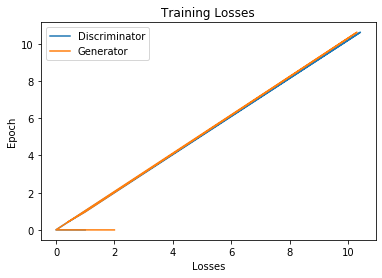

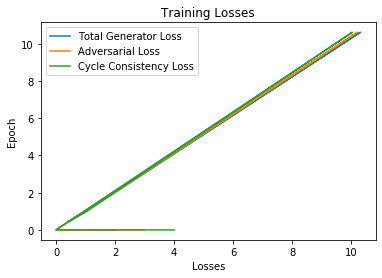

In [0]:
cycleGAN1 = cygan()
cycleGAN1.train(lambda_val = 5,epochs = 20)
cycleGAN1.losses.remove([])
cycleGAN1.show_losses()
cycleGAN1.show_glosses()

In [0]:
cycleGAN1.losses

[(0, 0.0035180445, 10.614321, 0.965466, 0.4341694),
 (1, 4.1379222e-05, 10.429236, 0.98944247, 0.42251757),
 (2, 1.3560777e-05, 10.310583, 0.99378735, 0.4161504),
 (3, 9.115019e-06, 10.201699, 0.9946139, 0.41062355),
 (4, 5.22276e-06, 10.036052, 0.9962166, 0.4021809),
 (5, 2.9974026e-06, 9.887796, 0.9973789, 0.39465192),
 (6, 2.4064082e-06, 9.688805, 0.99744457, 0.3846958),
 (7, 1.2477465e-06, 9.593395, 0.99844104, 0.37982565),
 (8, 9.413182e-07, 9.535528, 0.99848425, 0.37692794),
 (9, 6.330363e-07, 9.359074, 0.9988101, 0.3680727),
 (10, 4.377971e-07, 9.440664, 0.99903786, 0.3721294),
 (11, 2.9228815e-07, 9.255027, 0.9991525, 0.36283612),
 (12, 2.0224128e-07, 9.216983, 0.9993433, 0.36091483),
 (13, 1.3665402e-07, 9.05534, 0.99944234, 0.35282272),
 (14, 9.511959e-08, 9.137785, 0.9995128, 0.35693794),
 (15, 6.4426416e-08, 9.2100315, 0.99959886, 0.3605417),
 (16, 4.2238973e-08, 9.147522, 0.99968576, 0.3574075),
 (17, 2.8733616e-08, 9.008842, 0.9997411, 0.350468),
 (18, 1.956855e-08, 9.031

In [0]:
cycleGAN.losses.remove([])

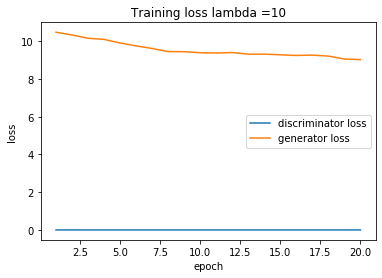

In [0]:
x = [xi[0]+1 for xi in cycleGAN.losses]
y = [xi[2] for xi in cycleGAN.losses]
z = [xi[2] for xi in cycleGAN.losses]
# zz = [xi[3] for xi in cycleGAN1.losses]
plt.plot(x,y,label='discriminator loss')
plt.plot(x,z,label='generator loss')
# plt.plot(x,zz,label='cycle consistency loss')
plt.legend()
plt.title('Training loss lambda =10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Loss10.png')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch - 0, Batch - 0, D_loss 0.340969 acc  43%, (G_loss 14.826792, adv_loss 0.323210, cycle_loss 0.709019) , time 0:01:44.792293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch - 0, Batch - 1, D_loss 0.323333 acc  48%, (G_loss 16.191645, adv_loss 0.380089, cycle_loss 0.771573) , time 0:01:45.787068
Epoch - 0, Batch - 2, D_loss 0.264725 acc  59%, (G_loss 14.892427, adv_loss 0.543896, cycle_loss 0.690232) , time 0:01:46.448271
Epoch - 0, Batch - 3, D_loss 0.281221 acc  56%, (G_loss 11.642736, adv_loss 0.580500, cycle_loss 0.524087) , time 0:01:47.116730
Epoch - 0, Batch - 4, D_loss 0.274299 acc  64%, (G_loss 12.747877, adv_loss 0.548942, cycle_loss 0.582500) , time 0:01:47.775137
Epoch - 0, Batch - 5, D_loss 0.307881 acc  49%, (G_loss 13.516433, adv_loss 0.609710, cycle_loss 0.614851) , time 0:01:48.433041
Epoch - 0, Batch - 6, D_loss 0.297785 acc  61%, (G_loss 12.465468, adv_loss 0.575166, cycle_loss 0.565757) , time 0:01:49.093243
Epoch - 0, Batch - 7, D_loss 0.211398 acc  73%, (G_loss 11.597936, adv_loss 0.573517, cycle_loss 0.522545) , time 0:01:49.768319
Epoch - 0, Batch - 8, D_loss 0.237447 acc  68%, (G_loss 11.269433, adv_loss 0.555631, cycle_loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 51, D_loss 0.076889 acc  91%, (G_loss 9.387350, adv_loss 0.767980, cycle_loss 0.392569) , time 0:02:19.363495
Epoch - 0, Batch - 52, D_loss 0.139223 acc  82%, (G_loss 9.465424, adv_loss 0.690315, cycle_loss 0.404240) , time 0:02:20.028180
Epoch - 0, Batch - 53, D_loss 0.135639 acc  83%, (G_loss 10.775358, adv_loss 0.696389, cycle_loss 0.469129) , time 0:02:20.687715
Epoch - 0, Batch - 54, D_loss 0.147092 acc  81%, (G_loss 11.570457, adv_loss 0.792104, cycle_loss 0.499312) , time 0:02:21.359486
Epoch - 0, Batch - 55, D_loss 0.104308 acc  89%, (G_loss 10.460535, adv_loss 0.722045, cycle_loss 0.450822) , time 0:02:22.021133
Epoch - 0, Batch - 56, D_loss 0.089033 acc  89%, (G_loss 12.866360, adv_loss 0.682886, cycle_loss 0.575029) , time 0:02:22.698022
Epoch - 0, Batch - 57, D_loss 0.105000 acc  86%, (G_loss 9.134475, adv_loss 0.705897, cycle_loss 0.386134) , time 0:02:23.364406
Epoch - 0, Batch - 58, D_loss 0.060977 acc  95%, (G_loss 11.048157, adv_loss 0.800708, cycle_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 101, D_loss 0.043137 acc  95%, (G_loss 10.100023, adv_loss 0.914581, cycle_loss 0.413543) , time 0:02:52.937544
Epoch - 0, Batch - 102, D_loss 0.027158 acc  96%, (G_loss 10.375171, adv_loss 0.907183, cycle_loss 0.428040) , time 0:02:53.605715
Epoch - 0, Batch - 103, D_loss 0.008797 acc  99%, (G_loss 9.660649, adv_loss 0.914699, cycle_loss 0.391563) , time 0:02:54.276872
Epoch - 0, Batch - 104, D_loss 0.006042 acc 100%, (G_loss 13.124151, adv_loss 0.907277, cycle_loss 0.565480) , time 0:02:54.953574
Epoch - 0, Batch - 105, D_loss 0.003892 acc 100%, (G_loss 9.808741, adv_loss 0.938304, cycle_loss 0.396607) , time 0:02:55.625630
Epoch - 0, Batch - 106, D_loss 0.002893 acc 100%, (G_loss 11.918002, adv_loss 0.941730, cycle_loss 0.501727) , time 0:02:56.299802
Epoch - 0, Batch - 107, D_loss 0.001479 acc 100%, (G_loss 11.498350, adv_loss 0.956682, cycle_loss 0.479249) , time 0:02:56.962624
Epoch - 0, Batch - 108, D_loss 0.002428 acc 100%, (G_loss 12.692848, adv_loss 0.95002

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 151, D_loss 0.000470 acc 100%, (G_loss 11.250775, adv_loss 0.965933, cycle_loss 0.465945) , time 0:03:26.554319
Epoch - 0, Batch - 152, D_loss 0.000671 acc 100%, (G_loss 10.786695, adv_loss 0.965389, cycle_loss 0.442796) , time 0:03:27.216383
Epoch - 0, Batch - 153, D_loss 0.000510 acc 100%, (G_loss 10.745675, adv_loss 0.966582, cycle_loss 0.440626) , time 0:03:27.895772
Epoch - 0, Batch - 154, D_loss 0.000411 acc 100%, (G_loss 14.772807, adv_loss 0.963665, cycle_loss 0.642274) , time 0:03:28.566199
Epoch - 0, Batch - 155, D_loss 0.001048 acc 100%, (G_loss 9.513486, adv_loss 0.962163, cycle_loss 0.379458) , time 0:03:29.236533
Epoch - 0, Batch - 156, D_loss 0.000872 acc 100%, (G_loss 10.857445, adv_loss 0.963686, cycle_loss 0.446504) , time 0:03:29.904933
Epoch - 0, Batch - 157, D_loss 0.000332 acc 100%, (G_loss 11.248481, adv_loss 0.969278, cycle_loss 0.465496) , time 0:03:30.573088
Epoch - 0, Batch - 158, D_loss 0.000675 acc 100%, (G_loss 9.477358, adv_loss 0.96692

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 201, D_loss 0.000251 acc 100%, (G_loss 11.262709, adv_loss 0.975522, cycle_loss 0.465583) , time 0:04:00.045545
Epoch - 0, Batch - 202, D_loss 0.006964 acc  99%, (G_loss 11.230379, adv_loss 0.963627, cycle_loss 0.465156) , time 0:04:00.704678
Epoch - 0, Batch - 203, D_loss 0.000858 acc 100%, (G_loss 10.008701, adv_loss 0.965702, cycle_loss 0.403865) , time 0:04:01.362624
Epoch - 0, Batch - 204, D_loss 0.000992 acc 100%, (G_loss 10.883799, adv_loss 0.971136, cycle_loss 0.447076) , time 0:04:02.023953
Epoch - 0, Batch - 205, D_loss 0.001422 acc 100%, (G_loss 11.604572, adv_loss 0.968937, cycle_loss 0.483335) , time 0:04:02.695005
Epoch - 0, Batch - 206, D_loss 0.000194 acc 100%, (G_loss 12.909171, adv_loss 0.977283, cycle_loss 0.547730) , time 0:04:03.355216
Epoch - 0, Batch - 207, D_loss 0.001138 acc 100%, (G_loss 10.563950, adv_loss 0.972397, cycle_loss 0.430958) , time 0:04:04.018349
Epoch - 0, Batch - 208, D_loss 0.000355 acc 100%, (G_loss 9.631924, adv_loss 0.9724

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 251, D_loss 0.000132 acc 100%, (G_loss 12.173410, adv_loss 0.977872, cycle_loss 0.510883) , time 0:04:33.492688
Epoch - 0, Batch - 252, D_loss 0.000496 acc 100%, (G_loss 10.515345, adv_loss 0.975714, cycle_loss 0.428196) , time 0:04:34.159166
Epoch - 0, Batch - 253, D_loss 0.000260 acc 100%, (G_loss 10.071302, adv_loss 0.975002, cycle_loss 0.406065) , time 0:04:34.816919
Epoch - 0, Batch - 254, D_loss 0.000299 acc 100%, (G_loss 10.628857, adv_loss 0.973966, cycle_loss 0.434046) , time 0:04:35.486150
Epoch - 0, Batch - 255, D_loss 0.000467 acc 100%, (G_loss 9.955206, adv_loss 0.978457, cycle_loss 0.399915) , time 0:04:36.147144
Epoch - 0, Batch - 256, D_loss 0.000107 acc 100%, (G_loss 12.283441, adv_loss 0.980047, cycle_loss 0.516167) , time 0:04:36.809068
Epoch - 0, Batch - 257, D_loss 0.000205 acc 100%, (G_loss 10.010509, adv_loss 0.975095, cycle_loss 0.403016) , time 0:04:37.473768
Epoch - 0, Batch - 258, D_loss 0.000114 acc 100%, (G_loss 12.694483, adv_loss 0.9798

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 301, D_loss 0.000371 acc 100%, (G_loss 10.878982, adv_loss 0.966204, cycle_loss 0.447329) , time 0:05:06.937032
Epoch - 0, Batch - 302, D_loss 0.000233 acc 100%, (G_loss 11.411196, adv_loss 0.969319, cycle_loss 0.473628) , time 0:05:07.597045
Epoch - 0, Batch - 303, D_loss 0.000243 acc 100%, (G_loss 10.263506, adv_loss 0.969925, cycle_loss 0.416183) , time 0:05:08.253360
Epoch - 0, Batch - 304, D_loss 0.000219 acc 100%, (G_loss 11.026783, adv_loss 0.971579, cycle_loss 0.454181) , time 0:05:08.917120
Epoch - 0, Batch - 305, D_loss 0.113833 acc  86%, (G_loss 9.191890, adv_loss 0.863406, cycle_loss 0.373254) , time 0:05:09.573158
Epoch - 0, Batch - 306, D_loss 0.044898 acc  95%, (G_loss 11.495308, adv_loss 0.909525, cycle_loss 0.483813) , time 0:05:10.239865
Epoch - 0, Batch - 307, D_loss 0.006698 acc  99%, (G_loss 9.712166, adv_loss 0.967445, cycle_loss 0.388864) , time 0:05:10.894260
Epoch - 0, Batch - 308, D_loss 0.002837 acc 100%, (G_loss 11.784277, adv_loss 0.97094

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 0, Batch - 351, D_loss 0.000092 acc 100%, (G_loss 12.250608, adv_loss 0.983294, cycle_loss 0.514201) , time 0:05:40.437110
Epoch - 0, Batch - 352, D_loss 0.000132 acc 100%, (G_loss 12.623539, adv_loss 0.979780, cycle_loss 0.533199) , time 0:05:41.100812
Epoch - 0, Batch - 353, D_loss 0.000139 acc 100%, (G_loss 10.830846, adv_loss 0.978383, cycle_loss 0.443704) , time 0:05:41.761500
Epoch - 0, Batch - 354, D_loss 0.000261 acc 100%, (G_loss 10.278977, adv_loss 0.979913, cycle_loss 0.415958) , time 0:05:42.422425
Epoch - 0, Batch - 355, D_loss 0.000209 acc 100%, (G_loss 12.512112, adv_loss 0.978081, cycle_loss 0.527797) , time 0:05:43.077080
Epoch - 0, Batch - 356, D_loss 0.000140 acc 100%, (G_loss 11.576086, adv_loss 0.981221, cycle_loss 0.480682) , time 0:05:43.745790
Epoch - 0, Batch - 357, D_loss 0.000078 acc 100%, (G_loss 11.043819, adv_loss 0.984957, cycle_loss 0.453695) , time 0:05:44.407906
Epoch - 0, Batch - 358, D_loss 0.000225 acc 100%, (G_loss 10.772024, adv_loss 0.976

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 1, D_loss 0.000093 acc 100%, (G_loss 10.452642, adv_loss 0.983996, cycle_loss 0.424232) , time 0:06:13.121586
Epoch - 1, Batch - 2, D_loss 0.000083 acc 100%, (G_loss 11.453141, adv_loss 0.985015, cycle_loss 0.474156) , time 0:06:13.782927
Epoch - 1, Batch - 3, D_loss 0.000305 acc 100%, (G_loss 8.975322, adv_loss 0.976980, cycle_loss 0.351068) , time 0:06:14.438916
Epoch - 1, Batch - 4, D_loss 0.000061 acc 100%, (G_loss 10.635317, adv_loss 0.986638, cycle_loss 0.433102) , time 0:06:15.095114
Epoch - 1, Batch - 5, D_loss 0.000098 acc 100%, (G_loss 11.286407, adv_loss 0.983299, cycle_loss 0.465990) , time 0:06:15.747628
Epoch - 1, Batch - 6, D_loss 0.000080 acc 100%, (G_loss 10.775293, adv_loss 0.985747, cycle_loss 0.440190) , time 0:06:16.407916
Epoch - 1, Batch - 7, D_loss 0.000091 acc 100%, (G_loss 10.448842, adv_loss 0.984909, cycle_loss 0.423951) , time 0:06:17.065592
Epoch - 1, Batch - 8, D_loss 0.000085 acc 100%, (G_loss 10.109652, adv_loss 0.985972, cycle_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 51, D_loss 0.000364 acc 100%, (G_loss 8.925197, adv_loss 0.981729, cycle_loss 0.348087) , time 0:06:46.477908
Epoch - 1, Batch - 52, D_loss 0.000217 acc 100%, (G_loss 9.155329, adv_loss 0.981260, cycle_loss 0.359640) , time 0:06:47.140774
Epoch - 1, Batch - 53, D_loss 0.000235 acc 100%, (G_loss 10.332091, adv_loss 0.973916, cycle_loss 0.419213) , time 0:06:47.798520
Epoch - 1, Batch - 54, D_loss 0.000182 acc 100%, (G_loss 10.816504, adv_loss 0.982361, cycle_loss 0.442589) , time 0:06:48.453830
Epoch - 1, Batch - 55, D_loss 0.000144 acc 100%, (G_loss 9.711456, adv_loss 0.976360, cycle_loss 0.387937) , time 0:06:49.120917
Epoch - 1, Batch - 56, D_loss 0.000194 acc 100%, (G_loss 12.758806, adv_loss 0.982493, cycle_loss 0.539691) , time 0:06:49.784492
Epoch - 1, Batch - 57, D_loss 0.000282 acc 100%, (G_loss 8.536661, adv_loss 0.979267, cycle_loss 0.328906) , time 0:06:50.450239
Epoch - 1, Batch - 58, D_loss 0.000136 acc 100%, (G_loss 10.573386, adv_loss 0.978260, cycle_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 101, D_loss 0.000259 acc 100%, (G_loss 9.751608, adv_loss 0.980407, cycle_loss 0.389540) , time 0:07:20.032126
Epoch - 1, Batch - 102, D_loss 0.000148 acc 100%, (G_loss 10.057876, adv_loss 0.980785, cycle_loss 0.404815) , time 0:07:20.700144
Epoch - 1, Batch - 103, D_loss 0.000126 acc 100%, (G_loss 9.282631, adv_loss 0.984290, cycle_loss 0.365703) , time 0:07:21.351728
Epoch - 1, Batch - 104, D_loss 0.000194 acc 100%, (G_loss 12.777174, adv_loss 0.977164, cycle_loss 0.541142) , time 0:07:22.023410
Epoch - 1, Batch - 105, D_loss 0.000153 acc 100%, (G_loss 9.406239, adv_loss 0.984748, cycle_loss 0.371837) , time 0:07:22.695168
Epoch - 1, Batch - 106, D_loss 0.000140 acc 100%, (G_loss 11.441499, adv_loss 0.980780, cycle_loss 0.473997) , time 0:07:23.351547
Epoch - 1, Batch - 107, D_loss 0.000059 acc 100%, (G_loss 11.670866, adv_loss 0.987880, cycle_loss 0.484755) , time 0:07:24.005131
Epoch - 1, Batch - 108, D_loss 0.000103 acc 100%, (G_loss 12.338675, adv_loss 0.982563

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 151, D_loss 0.000041 acc 100%, (G_loss 10.662226, adv_loss 0.988648, cycle_loss 0.434247) , time 0:07:53.428314
Epoch - 1, Batch - 152, D_loss 0.000082 acc 100%, (G_loss 10.320924, adv_loss 0.985530, cycle_loss 0.417493) , time 0:07:54.085739
Epoch - 1, Batch - 153, D_loss 0.000043 acc 100%, (G_loss 10.250953, adv_loss 0.988412, cycle_loss 0.413706) , time 0:07:54.748937
Epoch - 1, Batch - 154, D_loss 0.000044 acc 100%, (G_loss 14.476776, adv_loss 0.987107, cycle_loss 0.625128) , time 0:07:55.415579
Epoch - 1, Batch - 155, D_loss 0.000089 acc 100%, (G_loss 8.823786, adv_loss 0.985615, cycle_loss 0.342628) , time 0:07:56.072152
Epoch - 1, Batch - 156, D_loss 0.000059 acc 100%, (G_loss 10.507940, adv_loss 0.987432, cycle_loss 0.426654) , time 0:07:56.726580
Epoch - 1, Batch - 157, D_loss 0.000041 acc 100%, (G_loss 10.816113, adv_loss 0.988716, cycle_loss 0.441934) , time 0:07:57.392688
Epoch - 1, Batch - 158, D_loss 0.000067 acc 100%, (G_loss 9.292206, adv_loss 0.98498

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 201, D_loss 0.000027 acc 100%, (G_loss 10.796311, adv_loss 0.990981, cycle_loss 0.440717) , time 0:08:26.881734
Epoch - 1, Batch - 202, D_loss 0.001095 acc 100%, (G_loss 11.184378, adv_loss 0.986538, cycle_loss 0.460565) , time 0:08:27.538900
Epoch - 1, Batch - 203, D_loss 0.000087 acc 100%, (G_loss 9.753731, adv_loss 0.989564, cycle_loss 0.388730) , time 0:08:28.202095
Epoch - 1, Batch - 204, D_loss 0.000037 acc 100%, (G_loss 10.574619, adv_loss 0.990100, cycle_loss 0.429721) , time 0:08:28.852167
Epoch - 1, Batch - 205, D_loss 0.000061 acc 100%, (G_loss 11.400252, adv_loss 0.989965, cycle_loss 0.471016) , time 0:08:29.505167
Epoch - 1, Batch - 206, D_loss 0.000031 acc 100%, (G_loss 12.829140, adv_loss 0.990745, cycle_loss 0.542383) , time 0:08:30.162556
Epoch - 1, Batch - 207, D_loss 0.000150 acc 100%, (G_loss 10.170982, adv_loss 0.989466, cycle_loss 0.409603) , time 0:08:30.817585
Epoch - 1, Batch - 208, D_loss 0.000042 acc 100%, (G_loss 9.291782, adv_loss 0.99080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 251, D_loss 0.000019 acc 100%, (G_loss 11.912318, adv_loss 0.991894, cycle_loss 0.496426) , time 0:09:00.190592
Epoch - 1, Batch - 252, D_loss 0.000055 acc 100%, (G_loss 10.315809, adv_loss 0.988601, cycle_loss 0.416930) , time 0:09:00.850572
Epoch - 1, Batch - 253, D_loss 0.000040 acc 100%, (G_loss 9.821718, adv_loss 0.989978, cycle_loss 0.392088) , time 0:09:01.506825
Epoch - 1, Batch - 254, D_loss 0.000040 acc 100%, (G_loss 10.389383, adv_loss 0.989779, cycle_loss 0.420491) , time 0:09:02.164859
Epoch - 1, Batch - 255, D_loss 0.000094 acc 100%, (G_loss 9.760098, adv_loss 0.986723, cycle_loss 0.389333) , time 0:09:02.831755
Epoch - 1, Batch - 256, D_loss 0.000019 acc 100%, (G_loss 11.990126, adv_loss 0.991617, cycle_loss 0.500345) , time 0:09:03.486550
Epoch - 1, Batch - 257, D_loss 0.000033 acc 100%, (G_loss 9.735434, adv_loss 0.989907, cycle_loss 0.387781) , time 0:09:04.142255
Epoch - 1, Batch - 258, D_loss 0.000022 acc 100%, (G_loss 12.549477, adv_loss 0.991079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 301, D_loss 0.000038 acc 100%, (G_loss 10.732295, adv_loss 0.989608, cycle_loss 0.437654) , time 0:09:33.508201
Epoch - 1, Batch - 302, D_loss 0.000024 acc 100%, (G_loss 11.650985, adv_loss 0.991005, cycle_loss 0.483449) , time 0:09:34.169351
Epoch - 1, Batch - 303, D_loss 0.000027 acc 100%, (G_loss 10.081999, adv_loss 0.990473, cycle_loss 0.405053) , time 0:09:34.828885
Epoch - 1, Batch - 304, D_loss 0.000028 acc 100%, (G_loss 10.886921, adv_loss 0.990640, cycle_loss 0.445282) , time 0:09:35.487437
Epoch - 1, Batch - 305, D_loss 0.001160 acc 100%, (G_loss 9.350930, adv_loss 0.990344, cycle_loss 0.368512) , time 0:09:36.140834
Epoch - 1, Batch - 306, D_loss 0.000077 acc 100%, (G_loss 11.297601, adv_loss 0.985065, cycle_loss 0.466374) , time 0:09:36.802095
Epoch - 1, Batch - 307, D_loss 0.000073 acc 100%, (G_loss 9.440592, adv_loss 0.985308, cycle_loss 0.373499) , time 0:09:37.460641
Epoch - 1, Batch - 308, D_loss 0.000032 acc 100%, (G_loss 11.565825, adv_loss 0.98918

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 1, Batch - 351, D_loss 0.000021 acc 100%, (G_loss 11.852322, adv_loss 0.991037, cycle_loss 0.493512) , time 0:10:06.804534
Epoch - 1, Batch - 352, D_loss 0.000025 acc 100%, (G_loss 12.476456, adv_loss 0.990052, cycle_loss 0.524818) , time 0:10:07.457529
Epoch - 1, Batch - 353, D_loss 0.000026 acc 100%, (G_loss 10.394226, adv_loss 0.989551, cycle_loss 0.420756) , time 0:10:08.119400
Epoch - 1, Batch - 354, D_loss 0.000041 acc 100%, (G_loss 10.004600, adv_loss 0.989949, cycle_loss 0.401235) , time 0:10:08.776567
Epoch - 1, Batch - 355, D_loss 0.000044 acc 100%, (G_loss 11.697544, adv_loss 0.989039, cycle_loss 0.485973) , time 0:10:09.437298
Epoch - 1, Batch - 356, D_loss 0.000033 acc 100%, (G_loss 11.164213, adv_loss 0.989592, cycle_loss 0.459251) , time 0:10:10.093001
Epoch - 1, Batch - 357, D_loss 0.000020 acc 100%, (G_loss 10.559775, adv_loss 0.991039, cycle_loss 0.428885) , time 0:10:10.751607
Epoch - 1, Batch - 358, D_loss 0.000046 acc 100%, (G_loss 10.624168, adv_loss 0.987

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 1, D_loss 0.000027 acc 100%, (G_loss 10.269617, adv_loss 0.990438, cycle_loss 0.414437) , time 0:10:39.448087
Epoch - 2, Batch - 2, D_loss 0.000030 acc 100%, (G_loss 11.294556, adv_loss 0.990828, cycle_loss 0.465645) , time 0:10:40.106331
Epoch - 2, Batch - 3, D_loss 0.000061 acc 100%, (G_loss 8.795803, adv_loss 0.987808, cycle_loss 0.341009) , time 0:10:40.762268
Epoch - 2, Batch - 4, D_loss 0.000023 acc 100%, (G_loss 10.507210, adv_loss 0.990924, cycle_loss 0.426268) , time 0:10:41.424124
Epoch - 2, Batch - 5, D_loss 0.000022 acc 100%, (G_loss 11.112496, adv_loss 0.991955, cycle_loss 0.456429) , time 0:10:42.082003
Epoch - 2, Batch - 6, D_loss 0.000022 acc 100%, (G_loss 10.478506, adv_loss 0.992037, cycle_loss 0.424722) , time 0:10:42.735669
Epoch - 2, Batch - 7, D_loss 0.000026 acc 100%, (G_loss 10.029653, adv_loss 0.991612, cycle_loss 0.402321) , time 0:10:43.397106
Epoch - 2, Batch - 8, D_loss 0.000021 acc 100%, (G_loss 9.878214, adv_loss 0.992346, cycle_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 51, D_loss 0.000031 acc 100%, (G_loss 8.754107, adv_loss 0.992813, cycle_loss 0.338424) , time 0:11:12.669200
Epoch - 2, Batch - 52, D_loss 0.000025 acc 100%, (G_loss 8.867169, adv_loss 0.993138, cycle_loss 0.344045) , time 0:11:13.330232
Epoch - 2, Batch - 53, D_loss 0.000041 acc 100%, (G_loss 10.115099, adv_loss 0.989293, cycle_loss 0.406826) , time 0:11:13.984951
Epoch - 2, Batch - 54, D_loss 0.000046 acc 100%, (G_loss 10.801811, adv_loss 0.990828, cycle_loss 0.441008) , time 0:11:14.644496
Epoch - 2, Batch - 55, D_loss 0.000026 acc 100%, (G_loss 9.446322, adv_loss 0.990482, cycle_loss 0.373268) , time 0:11:15.310934
Epoch - 2, Batch - 56, D_loss 0.000043 acc 100%, (G_loss 12.671345, adv_loss 0.990551, cycle_loss 0.534512) , time 0:11:15.968759
Epoch - 2, Batch - 57, D_loss 0.000028 acc 100%, (G_loss 8.396888, adv_loss 0.992847, cycle_loss 0.320560) , time 0:11:16.626238
Epoch - 2, Batch - 58, D_loss 0.000028 acc 100%, (G_loss 10.336624, adv_loss 0.990199, cycle_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 101, D_loss 0.000027 acc 100%, (G_loss 9.488483, adv_loss 0.990656, cycle_loss 0.375359) , time 0:11:45.987814
Epoch - 2, Batch - 102, D_loss 0.000026 acc 100%, (G_loss 9.766674, adv_loss 0.990945, cycle_loss 0.389239) , time 0:11:46.639281
Epoch - 2, Batch - 103, D_loss 0.000017 acc 100%, (G_loss 9.117215, adv_loss 0.992312, cycle_loss 0.356630) , time 0:11:47.289364
Epoch - 2, Batch - 104, D_loss 0.000033 acc 100%, (G_loss 12.664715, adv_loss 0.989360, cycle_loss 0.534300) , time 0:11:47.941781
Epoch - 2, Batch - 105, D_loss 0.000031 acc 100%, (G_loss 8.960531, adv_loss 0.992488, cycle_loss 0.348778) , time 0:11:48.600087
Epoch - 2, Batch - 106, D_loss 0.000024 acc 100%, (G_loss 11.300705, adv_loss 0.991259, cycle_loss 0.465909) , time 0:11:49.262513
Epoch - 2, Batch - 107, D_loss 0.000016 acc 100%, (G_loss 11.487652, adv_loss 0.992842, cycle_loss 0.475098) , time 0:11:49.914938
Epoch - 2, Batch - 108, D_loss 0.000018 acc 100%, (G_loss 11.971307, adv_loss 0.991872,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 151, D_loss 0.000016 acc 100%, (G_loss 10.299500, adv_loss 0.992422, cycle_loss 0.415733) , time 0:12:19.175037
Epoch - 2, Batch - 152, D_loss 0.000024 acc 100%, (G_loss 10.084900, adv_loss 0.991198, cycle_loss 0.405125) , time 0:12:19.836706
Epoch - 2, Batch - 153, D_loss 0.000017 acc 100%, (G_loss 10.190852, adv_loss 0.991972, cycle_loss 0.410345) , time 0:12:20.498411
Epoch - 2, Batch - 154, D_loss 0.000016 acc 100%, (G_loss 14.398545, adv_loss 0.991804, cycle_loss 0.620747) , time 0:12:21.149855
Epoch - 2, Batch - 155, D_loss 0.000037 acc 100%, (G_loss 8.587957, adv_loss 0.989700, cycle_loss 0.330428) , time 0:12:21.808426
Epoch - 2, Batch - 156, D_loss 0.000025 acc 100%, (G_loss 10.345978, adv_loss 0.990929, cycle_loss 0.418206) , time 0:12:22.463500
Epoch - 2, Batch - 157, D_loss 0.000016 acc 100%, (G_loss 10.613849, adv_loss 0.992295, cycle_loss 0.431463) , time 0:12:23.122738
Epoch - 2, Batch - 158, D_loss 0.000027 acc 100%, (G_loss 8.998201, adv_loss 0.98995

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 201, D_loss 0.000015 acc 100%, (G_loss 10.519316, adv_loss 0.992676, cycle_loss 0.426698) , time 0:12:52.424190
Epoch - 2, Batch - 202, D_loss 0.000057 acc 100%, (G_loss 10.984364, adv_loss 0.990742, cycle_loss 0.450144) , time 0:12:53.089566
Epoch - 2, Batch - 203, D_loss 0.000019 acc 100%, (G_loss 9.533431, adv_loss 0.992016, cycle_loss 0.377470) , time 0:12:53.753680
Epoch - 2, Batch - 204, D_loss 0.000016 acc 100%, (G_loss 10.293492, adv_loss 0.993135, cycle_loss 0.415361) , time 0:12:54.420132
Epoch - 2, Batch - 205, D_loss 0.000019 acc 100%, (G_loss 11.222359, adv_loss 0.992995, cycle_loss 0.461818) , time 0:12:55.081129
Epoch - 2, Batch - 206, D_loss 0.000013 acc 100%, (G_loss 12.362750, adv_loss 0.993230, cycle_loss 0.518815) , time 0:12:55.735536
Epoch - 2, Batch - 207, D_loss 0.000038 acc 100%, (G_loss 10.065924, adv_loss 0.992702, cycle_loss 0.404026) , time 0:12:56.391341
Epoch - 2, Batch - 208, D_loss 0.000016 acc 100%, (G_loss 9.121075, adv_loss 0.99291

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 251, D_loss 0.000010 acc 100%, (G_loss 11.750216, adv_loss 0.993990, cycle_loss 0.488112) , time 0:13:25.746008
Epoch - 2, Batch - 252, D_loss 0.000026 acc 100%, (G_loss 10.467063, adv_loss 0.992432, cycle_loss 0.424110) , time 0:13:26.404294
Epoch - 2, Batch - 253, D_loss 0.000016 acc 100%, (G_loss 9.742241, adv_loss 0.993685, cycle_loss 0.387743) , time 0:13:27.056759
Epoch - 2, Batch - 254, D_loss 0.000019 acc 100%, (G_loss 10.204312, adv_loss 0.992842, cycle_loss 0.410931) , time 0:13:27.725230
Epoch - 2, Batch - 255, D_loss 0.000036 acc 100%, (G_loss 9.688402, adv_loss 0.990963, cycle_loss 0.385324) , time 0:13:28.379362
Epoch - 2, Batch - 256, D_loss 0.000010 acc 100%, (G_loss 11.868753, adv_loss 0.994240, cycle_loss 0.494014) , time 0:13:29.032783
Epoch - 2, Batch - 257, D_loss 0.000015 acc 100%, (G_loss 9.454444, adv_loss 0.993573, cycle_loss 0.373365) , time 0:13:29.691540
Epoch - 2, Batch - 258, D_loss 0.000010 acc 100%, (G_loss 12.446682, adv_loss 0.994022

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 301, D_loss 0.000020 acc 100%, (G_loss 10.983648, adv_loss 0.992518, cycle_loss 0.449931) , time 0:13:58.910666
Epoch - 2, Batch - 302, D_loss 0.000016 acc 100%, (G_loss 11.556947, adv_loss 0.992573, cycle_loss 0.478590) , time 0:13:59.568782
Epoch - 2, Batch - 303, D_loss 0.000016 acc 100%, (G_loss 10.034205, adv_loss 0.992503, cycle_loss 0.402460) , time 0:14:00.223397
Epoch - 2, Batch - 304, D_loss 0.000016 acc 100%, (G_loss 10.722559, adv_loss 0.993010, cycle_loss 0.436827) , time 0:14:00.882823
Epoch - 2, Batch - 305, D_loss 0.000145 acc 100%, (G_loss 9.168303, adv_loss 0.993703, cycle_loss 0.359045) , time 0:14:01.549216
Epoch - 2, Batch - 306, D_loss 0.000016 acc 100%, (G_loss 11.058987, adv_loss 0.992618, cycle_loss 0.453688) , time 0:14:02.204468
Epoch - 2, Batch - 307, D_loss 0.000017 acc 100%, (G_loss 9.331023, adv_loss 0.993019, cycle_loss 0.367249) , time 0:14:02.871305
Epoch - 2, Batch - 308, D_loss 0.000012 acc 100%, (G_loss 11.472427, adv_loss 0.99329

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 2, Batch - 351, D_loss 0.000008 acc 100%, (G_loss 11.783061, adv_loss 0.994908, cycle_loss 0.489662) , time 0:14:32.127255
Epoch - 2, Batch - 352, D_loss 0.000011 acc 100%, (G_loss 12.393126, adv_loss 0.993814, cycle_loss 0.520275) , time 0:14:32.781768
Epoch - 2, Batch - 353, D_loss 0.000012 acc 100%, (G_loss 10.337814, adv_loss 0.993329, cycle_loss 0.417558) , time 0:14:33.445778
Epoch - 2, Batch - 354, D_loss 0.000021 acc 100%, (G_loss 9.919468, adv_loss 0.993723, cycle_loss 0.396601) , time 0:14:34.101438
Epoch - 2, Batch - 355, D_loss 0.000019 acc 100%, (G_loss 11.498655, adv_loss 0.994425, cycle_loss 0.475490) , time 0:14:34.762736
Epoch - 2, Batch - 356, D_loss 0.000014 acc 100%, (G_loss 10.966713, adv_loss 0.994150, cycle_loss 0.448921) , time 0:14:35.427508
Epoch - 2, Batch - 357, D_loss 0.000009 acc 100%, (G_loss 10.517896, adv_loss 0.994704, cycle_loss 0.426424) , time 0:14:36.078935
Epoch - 2, Batch - 358, D_loss 0.000018 acc 100%, (G_loss 10.172472, adv_loss 0.9936

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 1, D_loss 0.000012 acc 100%, (G_loss 10.159176, adv_loss 0.994286, cycle_loss 0.408530) , time 0:15:04.714947
Epoch - 3, Batch - 2, D_loss 0.000018 acc 100%, (G_loss 11.162957, adv_loss 0.993762, cycle_loss 0.458772) , time 0:15:05.371382
Epoch - 3, Batch - 3, D_loss 0.000034 acc 100%, (G_loss 8.707928, adv_loss 0.991112, cycle_loss 0.336285) , time 0:15:06.027803
Epoch - 3, Batch - 4, D_loss 0.000011 acc 100%, (G_loss 10.194532, adv_loss 0.993825, cycle_loss 0.410344) , time 0:15:06.680937
Epoch - 3, Batch - 5, D_loss 0.000012 acc 100%, (G_loss 10.844580, adv_loss 0.994377, cycle_loss 0.442791) , time 0:15:07.344126
Epoch - 3, Batch - 6, D_loss 0.000012 acc 100%, (G_loss 10.249155, adv_loss 0.994244, cycle_loss 0.413033) , time 0:15:07.999328
Epoch - 3, Batch - 7, D_loss 0.000016 acc 100%, (G_loss 9.887015, adv_loss 0.993556, cycle_loss 0.394995) , time 0:15:08.657171
Epoch - 3, Batch - 8, D_loss 0.000011 acc 100%, (G_loss 9.734418, adv_loss 0.994698, cycle_loss 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 51, D_loss 0.000020 acc 100%, (G_loss 8.731091, adv_loss 0.994458, cycle_loss 0.337109) , time 0:15:37.891129
Epoch - 3, Batch - 52, D_loss 0.000014 acc 100%, (G_loss 8.760420, adv_loss 0.995303, cycle_loss 0.338491) , time 0:15:38.543096
Epoch - 3, Batch - 53, D_loss 0.000021 acc 100%, (G_loss 10.115257, adv_loss 0.993022, cycle_loss 0.406461) , time 0:15:39.211586
Epoch - 3, Batch - 54, D_loss 0.000024 acc 100%, (G_loss 10.828985, adv_loss 0.994080, cycle_loss 0.442041) , time 0:15:39.867023
Epoch - 3, Batch - 55, D_loss 0.000013 acc 100%, (G_loss 9.235232, adv_loss 0.993683, cycle_loss 0.362393) , time 0:15:40.520133
Epoch - 3, Batch - 56, D_loss 0.000025 acc 100%, (G_loss 12.376671, adv_loss 0.993250, cycle_loss 0.519508) , time 0:15:41.176302
Epoch - 3, Batch - 57, D_loss 0.000017 acc 100%, (G_loss 8.391692, adv_loss 0.994758, cycle_loss 0.320109) , time 0:15:41.827892
Epoch - 3, Batch - 58, D_loss 0.000017 acc 100%, (G_loss 10.171342, adv_loss 0.992740, cycle_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 101, D_loss 0.000014 acc 100%, (G_loss 9.405499, adv_loss 0.993515, cycle_loss 0.370923) , time 0:16:11.092956
Epoch - 3, Batch - 102, D_loss 0.000015 acc 100%, (G_loss 9.612324, adv_loss 0.993395, cycle_loss 0.381277) , time 0:16:11.750215
Epoch - 3, Batch - 103, D_loss 0.000010 acc 100%, (G_loss 8.937008, adv_loss 0.994434, cycle_loss 0.347407) , time 0:16:12.409123
Epoch - 3, Batch - 104, D_loss 0.000017 acc 100%, (G_loss 12.293430, adv_loss 0.992381, cycle_loss 0.515433) , time 0:16:13.076121
Epoch - 3, Batch - 105, D_loss 0.000017 acc 100%, (G_loss 8.863764, adv_loss 0.994583, cycle_loss 0.343730) , time 0:16:13.729018
Epoch - 3, Batch - 106, D_loss 0.000012 acc 100%, (G_loss 11.240879, adv_loss 0.994011, cycle_loss 0.462643) , time 0:16:14.387129
Epoch - 3, Batch - 107, D_loss 0.000009 acc 100%, (G_loss 11.488530, adv_loss 0.994720, cycle_loss 0.474954) , time 0:16:15.045221
Epoch - 3, Batch - 108, D_loss 0.000010 acc 100%, (G_loss 11.863247, adv_loss 0.993916,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 151, D_loss 0.000012 acc 100%, (G_loss 9.934049, adv_loss 0.993434, cycle_loss 0.397359) , time 0:16:44.317915
Epoch - 3, Batch - 152, D_loss 0.000012 acc 100%, (G_loss 9.957926, adv_loss 0.993791, cycle_loss 0.398517) , time 0:16:44.969235
Epoch - 3, Batch - 153, D_loss 0.000010 acc 100%, (G_loss 9.984846, adv_loss 0.994082, cycle_loss 0.399834) , time 0:16:45.619039
Epoch - 3, Batch - 154, D_loss 0.000012 acc 100%, (G_loss 14.281458, adv_loss 0.993238, cycle_loss 0.614749) , time 0:16:46.278567
Epoch - 3, Batch - 155, D_loss 0.000022 acc 100%, (G_loss 8.462999, adv_loss 0.992386, cycle_loss 0.323911) , time 0:16:46.942846
Epoch - 3, Batch - 156, D_loss 0.000015 acc 100%, (G_loss 10.204248, adv_loss 0.993089, cycle_loss 0.410904) , time 0:16:47.592648
Epoch - 3, Batch - 157, D_loss 0.000010 acc 100%, (G_loss 10.440538, adv_loss 0.994042, cycle_loss 0.422623) , time 0:16:48.254810
Epoch - 3, Batch - 158, D_loss 0.000018 acc 100%, (G_loss 8.920856, adv_loss 0.991721, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 201, D_loss 0.000009 acc 100%, (G_loss 10.600051, adv_loss 0.994616, cycle_loss 0.430541) , time 0:17:17.471978
Epoch - 3, Batch - 202, D_loss 0.000035 acc 100%, (G_loss 11.005172, adv_loss 0.991959, cycle_loss 0.451063) , time 0:17:18.136340
Epoch - 3, Batch - 203, D_loss 0.000010 acc 100%, (G_loss 9.399284, adv_loss 0.994506, cycle_loss 0.370514) , time 0:17:18.791756
Epoch - 3, Batch - 204, D_loss 0.000010 acc 100%, (G_loss 10.118210, adv_loss 0.994854, cycle_loss 0.406425) , time 0:17:19.445009
Epoch - 3, Batch - 205, D_loss 0.000012 acc 100%, (G_loss 11.190549, adv_loss 0.994833, cycle_loss 0.460044) , time 0:17:20.102587
Epoch - 3, Batch - 206, D_loss 0.000007 acc 100%, (G_loss 12.389423, adv_loss 0.995202, cycle_loss 0.519951) , time 0:17:20.757509
Epoch - 3, Batch - 207, D_loss 0.000022 acc 100%, (G_loss 9.931654, adv_loss 0.995218, cycle_loss 0.397061) , time 0:17:21.418745
Epoch - 3, Batch - 208, D_loss 0.000008 acc 100%, (G_loss 8.961748, adv_loss 0.995617

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 251, D_loss 0.000005 acc 100%, (G_loss 11.665968, adv_loss 0.995642, cycle_loss 0.483734) , time 0:17:50.671542
Epoch - 3, Batch - 252, D_loss 0.000015 acc 100%, (G_loss 10.381295, adv_loss 0.994485, cycle_loss 0.419616) , time 0:17:51.329856
Epoch - 3, Batch - 253, D_loss 0.000010 acc 100%, (G_loss 9.582500, adv_loss 0.994986, cycle_loss 0.379626) , time 0:17:51.991628
Epoch - 3, Batch - 254, D_loss 0.000011 acc 100%, (G_loss 10.208968, adv_loss 0.994929, cycle_loss 0.410956) , time 0:17:52.653917
Epoch - 3, Batch - 255, D_loss 0.000013 acc 100%, (G_loss 9.442286, adv_loss 0.995621, cycle_loss 0.372552) , time 0:17:53.305781
Epoch - 3, Batch - 256, D_loss 0.000006 acc 100%, (G_loss 11.790083, adv_loss 0.995364, cycle_loss 0.489968) , time 0:17:53.960820
Epoch - 3, Batch - 257, D_loss 0.000009 acc 100%, (G_loss 9.407804, adv_loss 0.994964, cycle_loss 0.370894) , time 0:17:54.618120
Epoch - 3, Batch - 258, D_loss 0.000006 acc 100%, (G_loss 12.201052, adv_loss 0.995477

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 301, D_loss 0.000010 acc 100%, (G_loss 10.472427, adv_loss 0.994720, cycle_loss 0.424149) , time 0:18:24.641412
Epoch - 3, Batch - 302, D_loss 0.000008 acc 100%, (G_loss 11.053669, adv_loss 0.994914, cycle_loss 0.453192) , time 0:18:25.298042
Epoch - 3, Batch - 303, D_loss 0.000009 acc 100%, (G_loss 9.910818, adv_loss 0.994753, cycle_loss 0.396066) , time 0:18:25.954238
Epoch - 3, Batch - 304, D_loss 0.000008 acc 100%, (G_loss 10.451859, adv_loss 0.994997, cycle_loss 0.423093) , time 0:18:26.608279
Epoch - 3, Batch - 305, D_loss 0.000115 acc 100%, (G_loss 9.087568, adv_loss 0.995544, cycle_loss 0.354824) , time 0:18:27.268936
Epoch - 3, Batch - 306, D_loss 0.000009 acc 100%, (G_loss 11.164568, adv_loss 0.994605, cycle_loss 0.458768) , time 0:18:27.937746
Epoch - 3, Batch - 307, D_loss 0.000011 acc 100%, (G_loss 9.307488, adv_loss 0.994268, cycle_loss 0.365948) , time 0:18:28.607944
Epoch - 3, Batch - 308, D_loss 0.000007 acc 100%, (G_loss 11.331058, adv_loss 0.994874

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 3, Batch - 351, D_loss 0.000007 acc 100%, (G_loss 11.710484, adv_loss 0.994973, cycle_loss 0.486027) , time 0:18:57.838963
Epoch - 3, Batch - 352, D_loss 0.000007 acc 100%, (G_loss 12.233557, adv_loss 0.994770, cycle_loss 0.512201) , time 0:18:58.488988
Epoch - 3, Batch - 353, D_loss 0.000008 acc 100%, (G_loss 10.099781, adv_loss 0.994410, cycle_loss 0.405548) , time 0:18:59.137834
Epoch - 3, Batch - 354, D_loss 0.000014 acc 100%, (G_loss 9.796345, adv_loss 0.994432, cycle_loss 0.390374) , time 0:18:59.803209
Epoch - 3, Batch - 355, D_loss 0.000012 acc 100%, (G_loss 11.449419, adv_loss 0.995066, cycle_loss 0.472964) , time 0:19:00.460819
Epoch - 3, Batch - 356, D_loss 0.000009 acc 100%, (G_loss 10.841063, adv_loss 0.995036, cycle_loss 0.442550) , time 0:19:01.120846
Epoch - 3, Batch - 357, D_loss 0.000006 acc 100%, (G_loss 10.286739, adv_loss 0.995164, cycle_loss 0.414821) , time 0:19:01.776578
Epoch - 3, Batch - 358, D_loss 0.000013 acc 100%, (G_loss 9.901368, adv_loss 0.99408

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 1, D_loss 0.000009 acc 100%, (G_loss 9.997835, adv_loss 0.994818, cycle_loss 0.400410) , time 0:19:30.381166
Epoch - 4, Batch - 2, D_loss 0.000014 acc 100%, (G_loss 11.281761, adv_loss 0.994426, cycle_loss 0.464645) , time 0:19:31.049235
Epoch - 4, Batch - 3, D_loss 0.000018 acc 100%, (G_loss 8.672596, adv_loss 0.993858, cycle_loss 0.334244) , time 0:19:31.711754
Epoch - 4, Batch - 4, D_loss 0.000008 acc 100%, (G_loss 10.077480, adv_loss 0.994892, cycle_loss 0.404385) , time 0:19:32.371473
Epoch - 4, Batch - 5, D_loss 0.000009 acc 100%, (G_loss 10.795258, adv_loss 0.995295, cycle_loss 0.440233) , time 0:19:33.025652
Epoch - 4, Batch - 6, D_loss 0.000009 acc 100%, (G_loss 10.347558, adv_loss 0.994808, cycle_loss 0.417897) , time 0:19:33.680741
Epoch - 4, Batch - 7, D_loss 0.000011 acc 100%, (G_loss 9.854074, adv_loss 0.994598, cycle_loss 0.393244) , time 0:19:34.347572
Epoch - 4, Batch - 8, D_loss 0.000008 acc 100%, (G_loss 9.642910, adv_loss 0.994961, cycle_loss 0.38

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 51, D_loss 0.000013 acc 100%, (G_loss 8.486073, adv_loss 0.995673, cycle_loss 0.324736) , time 0:20:03.587333
Epoch - 4, Batch - 52, D_loss 0.000010 acc 100%, (G_loss 8.616875, adv_loss 0.995754, cycle_loss 0.331268) , time 0:20:04.240971
Epoch - 4, Batch - 53, D_loss 0.000017 acc 100%, (G_loss 9.754101, adv_loss 0.993456, cycle_loss 0.388359) , time 0:20:04.899660
Epoch - 4, Batch - 54, D_loss 0.000016 acc 100%, (G_loss 10.708147, adv_loss 0.994748, cycle_loss 0.435932) , time 0:20:05.549554
Epoch - 4, Batch - 55, D_loss 0.000011 acc 100%, (G_loss 9.112949, adv_loss 0.993786, cycle_loss 0.356269) , time 0:20:06.202210
Epoch - 4, Batch - 56, D_loss 0.000016 acc 100%, (G_loss 12.376196, adv_loss 0.994480, cycle_loss 0.519362) , time 0:20:06.850295
Epoch - 4, Batch - 57, D_loss 0.000013 acc 100%, (G_loss 8.056084, adv_loss 0.994429, cycle_loss 0.303361) , time 0:20:07.515319
Epoch - 4, Batch - 58, D_loss 0.000012 acc 100%, (G_loss 10.039888, adv_loss 0.993473, cycle_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 101, D_loss 0.000010 acc 100%, (G_loss 9.259571, adv_loss 0.994437, cycle_loss 0.363535) , time 0:20:36.682903
Epoch - 4, Batch - 102, D_loss 0.000009 acc 100%, (G_loss 9.426424, adv_loss 0.994863, cycle_loss 0.371835) , time 0:20:37.347348
Epoch - 4, Batch - 103, D_loss 0.000006 acc 100%, (G_loss 8.830726, adv_loss 0.995331, cycle_loss 0.342003) , time 0:20:38.005898
Epoch - 4, Batch - 104, D_loss 0.000010 acc 100%, (G_loss 12.178621, adv_loss 0.994147, cycle_loss 0.509516) , time 0:20:38.661376
Epoch - 4, Batch - 105, D_loss 0.000012 acc 100%, (G_loss 8.891197, adv_loss 0.994879, cycle_loss 0.345072) , time 0:20:39.326076
Epoch - 4, Batch - 106, D_loss 0.000009 acc 100%, (G_loss 11.151714, adv_loss 0.994836, cycle_loss 0.458102) , time 0:20:39.985953
Epoch - 4, Batch - 107, D_loss 0.000006 acc 100%, (G_loss 11.434167, adv_loss 0.995458, cycle_loss 0.472163) , time 0:20:40.647115
Epoch - 4, Batch - 108, D_loss 0.000008 acc 100%, (G_loss 11.670106, adv_loss 0.994469,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 151, D_loss 0.000007 acc 100%, (G_loss 9.923534, adv_loss 0.995202, cycle_loss 0.396656) , time 0:21:09.941846
Epoch - 4, Batch - 152, D_loss 0.000008 acc 100%, (G_loss 9.831666, adv_loss 0.994649, cycle_loss 0.392118) , time 0:21:10.595865
Epoch - 4, Batch - 153, D_loss 0.000006 acc 100%, (G_loss 9.949654, adv_loss 0.995385, cycle_loss 0.397944) , time 0:21:11.253199
Epoch - 4, Batch - 154, D_loss 0.000006 acc 100%, (G_loss 14.280979, adv_loss 0.995517, cycle_loss 0.614497) , time 0:21:11.909808
Epoch - 4, Batch - 155, D_loss 0.000013 acc 100%, (G_loss 8.389665, adv_loss 0.993942, cycle_loss 0.320089) , time 0:21:12.574807
Epoch - 4, Batch - 156, D_loss 0.000010 acc 100%, (G_loss 10.134109, adv_loss 0.994429, cycle_loss 0.407263) , time 0:21:13.233702
Epoch - 4, Batch - 157, D_loss 0.000006 acc 100%, (G_loss 10.399213, adv_loss 0.995633, cycle_loss 0.420397) , time 0:21:13.886117
Epoch - 4, Batch - 158, D_loss 0.000011 acc 100%, (G_loss 9.011702, adv_loss 0.993967, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 201, D_loss 0.000006 acc 100%, (G_loss 10.466190, adv_loss 0.995483, cycle_loss 0.423761) , time 0:21:43.045985
Epoch - 4, Batch - 202, D_loss 0.000024 acc 100%, (G_loss 10.868788, adv_loss 0.993389, cycle_loss 0.444100) , time 0:21:43.702037
Epoch - 4, Batch - 203, D_loss 0.000006 acc 100%, (G_loss 9.259453, adv_loss 0.996045, cycle_loss 0.363368) , time 0:21:44.358514
Epoch - 4, Batch - 204, D_loss 0.000007 acc 100%, (G_loss 10.020075, adv_loss 0.995648, cycle_loss 0.401439) , time 0:21:45.019008
Epoch - 4, Batch - 205, D_loss 0.000009 acc 100%, (G_loss 11.021475, adv_loss 0.994969, cycle_loss 0.451577) , time 0:21:45.686720
Epoch - 4, Batch - 206, D_loss 0.000007 acc 100%, (G_loss 12.060083, adv_loss 0.995125, cycle_loss 0.503492) , time 0:21:46.335833
Epoch - 4, Batch - 207, D_loss 0.000015 acc 100%, (G_loss 9.712317, adv_loss 0.995460, cycle_loss 0.386070) , time 0:21:46.993073
Epoch - 4, Batch - 208, D_loss 0.000007 acc 100%, (G_loss 8.904341, adv_loss 0.995121

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 251, D_loss 0.000004 acc 100%, (G_loss 11.429899, adv_loss 0.996356, cycle_loss 0.471859) , time 0:22:16.242833
Epoch - 4, Batch - 252, D_loss 0.000010 acc 100%, (G_loss 10.318556, adv_loss 0.995385, cycle_loss 0.416389) , time 0:22:16.892853
Epoch - 4, Batch - 253, D_loss 0.000007 acc 100%, (G_loss 9.321815, adv_loss 0.995941, cycle_loss 0.366497) , time 0:22:17.560465
Epoch - 4, Batch - 254, D_loss 0.000007 acc 100%, (G_loss 9.896070, adv_loss 0.995664, cycle_loss 0.395237) , time 0:22:18.216237
Epoch - 4, Batch - 255, D_loss 0.000010 acc 100%, (G_loss 9.363524, adv_loss 0.995667, cycle_loss 0.368609) , time 0:22:18.870664
Epoch - 4, Batch - 256, D_loss 0.000004 acc 100%, (G_loss 11.673134, adv_loss 0.996275, cycle_loss 0.484029) , time 0:22:19.535646
Epoch - 4, Batch - 257, D_loss 0.000007 acc 100%, (G_loss 9.374311, adv_loss 0.995399, cycle_loss 0.369176) , time 0:22:20.192289
Epoch - 4, Batch - 258, D_loss 0.000004 acc 100%, (G_loss 12.085958, adv_loss 0.996268,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 301, D_loss 0.000006 acc 100%, (G_loss 10.504831, adv_loss 0.995901, cycle_loss 0.425651) , time 0:22:49.397784
Epoch - 4, Batch - 302, D_loss 0.000005 acc 100%, (G_loss 11.142457, adv_loss 0.995887, cycle_loss 0.457534) , time 0:22:50.055328
Epoch - 4, Batch - 303, D_loss 0.000006 acc 100%, (G_loss 9.800649, adv_loss 0.995797, cycle_loss 0.390453) , time 0:22:50.709463
Epoch - 4, Batch - 304, D_loss 0.000006 acc 100%, (G_loss 10.372419, adv_loss 0.995939, cycle_loss 0.419027) , time 0:22:51.361025
Epoch - 4, Batch - 305, D_loss 0.000082 acc 100%, (G_loss 8.894281, adv_loss 0.996430, cycle_loss 0.345071) , time 0:22:52.019171
Epoch - 4, Batch - 306, D_loss 0.000007 acc 100%, (G_loss 11.114882, adv_loss 0.995247, cycle_loss 0.456219) , time 0:22:52.686282
Epoch - 4, Batch - 307, D_loss 0.000007 acc 100%, (G_loss 9.308819, adv_loss 0.995436, cycle_loss 0.365897) , time 0:22:53.341313
Epoch - 4, Batch - 308, D_loss 0.000005 acc 100%, (G_loss 11.206759, adv_loss 0.996023

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 4, Batch - 351, D_loss 0.000004 acc 100%, (G_loss 11.796308, adv_loss 0.996226, cycle_loss 0.490193) , time 0:23:22.637938
Epoch - 4, Batch - 352, D_loss 0.000004 acc 100%, (G_loss 12.009918, adv_loss 0.996273, cycle_loss 0.500869) , time 0:23:23.303205
Epoch - 4, Batch - 353, D_loss 0.000005 acc 100%, (G_loss 9.928162, adv_loss 0.995924, cycle_loss 0.396816) , time 0:23:23.960936
Epoch - 4, Batch - 354, D_loss 0.000009 acc 100%, (G_loss 9.788083, adv_loss 0.995597, cycle_loss 0.389844) , time 0:23:24.624811
Epoch - 4, Batch - 355, D_loss 0.000009 acc 100%, (G_loss 11.157052, adv_loss 0.995850, cycle_loss 0.458268) , time 0:23:25.280083
Epoch - 4, Batch - 356, D_loss 0.000006 acc 100%, (G_loss 10.726675, adv_loss 0.996047, cycle_loss 0.436729) , time 0:23:25.942741
Epoch - 4, Batch - 357, D_loss 0.000004 acc 100%, (G_loss 10.262453, adv_loss 0.996279, cycle_loss 0.413495) , time 0:23:26.594677
Epoch - 4, Batch - 358, D_loss 0.000009 acc 100%, (G_loss 9.723970, adv_loss 0.994913

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 1, D_loss 0.000007 acc 100%, (G_loss 9.964384, adv_loss 0.995624, cycle_loss 0.398657) , time 0:23:55.249175
Epoch - 5, Batch - 2, D_loss 0.000009 acc 100%, (G_loss 10.872550, adv_loss 0.995315, cycle_loss 0.444096) , time 0:23:55.906925
Epoch - 5, Batch - 3, D_loss 0.000011 acc 100%, (G_loss 8.622406, adv_loss 0.994986, cycle_loss 0.331622) , time 0:23:56.562948
Epoch - 5, Batch - 4, D_loss 0.000005 acc 100%, (G_loss 10.033790, adv_loss 0.995771, cycle_loss 0.402112) , time 0:23:57.230622
Epoch - 5, Batch - 5, D_loss 0.000006 acc 100%, (G_loss 10.574430, adv_loss 0.996044, cycle_loss 0.429117) , time 0:23:57.883515
Epoch - 5, Batch - 6, D_loss 0.000006 acc 100%, (G_loss 10.108643, adv_loss 0.995425, cycle_loss 0.405890) , time 0:23:58.537591
Epoch - 5, Batch - 7, D_loss 0.000008 acc 100%, (G_loss 9.679222, adv_loss 0.995094, cycle_loss 0.384452) , time 0:23:59.196607
Epoch - 5, Batch - 8, D_loss 0.000006 acc 100%, (G_loss 9.487125, adv_loss 0.995711, cycle_loss 0.37

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 51, D_loss 0.000008 acc 100%, (G_loss 8.430288, adv_loss 0.996701, cycle_loss 0.321844) , time 0:24:28.472728
Epoch - 5, Batch - 52, D_loss 0.000006 acc 100%, (G_loss 8.477655, adv_loss 0.996546, cycle_loss 0.324228) , time 0:24:29.135785
Epoch - 5, Batch - 53, D_loss 0.000009 acc 100%, (G_loss 9.504597, adv_loss 0.995395, cycle_loss 0.375690) , time 0:24:29.785682
Epoch - 5, Batch - 54, D_loss 0.000010 acc 100%, (G_loss 10.282932, adv_loss 0.996143, cycle_loss 0.414532) , time 0:24:30.438026
Epoch - 5, Batch - 55, D_loss 0.000007 acc 100%, (G_loss 9.032703, adv_loss 0.995730, cycle_loss 0.352062) , time 0:24:31.110106
Epoch - 5, Batch - 56, D_loss 0.000010 acc 100%, (G_loss 12.088339, adv_loss 0.996035, cycle_loss 0.504813) , time 0:24:31.765069
Epoch - 5, Batch - 57, D_loss 0.000007 acc 100%, (G_loss 7.947404, adv_loss 0.996830, cycle_loss 0.297687) , time 0:24:32.424397
Epoch - 5, Batch - 58, D_loss 0.000008 acc 100%, (G_loss 9.925652, adv_loss 0.995252, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 101, D_loss 0.000006 acc 100%, (G_loss 9.191044, adv_loss 0.996048, cycle_loss 0.359947) , time 0:25:01.750896
Epoch - 5, Batch - 102, D_loss 0.000006 acc 100%, (G_loss 9.380778, adv_loss 0.996073, cycle_loss 0.369432) , time 0:25:02.408122
Epoch - 5, Batch - 103, D_loss 0.000004 acc 100%, (G_loss 8.732755, adv_loss 0.996397, cycle_loss 0.336998) , time 0:25:03.072446
Epoch - 5, Batch - 104, D_loss 0.000006 acc 100%, (G_loss 12.071234, adv_loss 0.995571, cycle_loss 0.504005) , time 0:25:03.726092
Epoch - 5, Batch - 105, D_loss 0.000007 acc 100%, (G_loss 8.841862, adv_loss 0.996611, cycle_loss 0.342432) , time 0:25:04.381012
Epoch - 5, Batch - 106, D_loss 0.000005 acc 100%, (G_loss 11.127869, adv_loss 0.996468, cycle_loss 0.456747) , time 0:25:05.044198
Epoch - 5, Batch - 107, D_loss 0.000004 acc 100%, (G_loss 11.394648, adv_loss 0.996774, cycle_loss 0.470055) , time 0:25:05.696979
Epoch - 5, Batch - 108, D_loss 0.000004 acc 100%, (G_loss 11.414780, adv_loss 0.996520,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 151, D_loss 0.000004 acc 100%, (G_loss 9.792134, adv_loss 0.996406, cycle_loss 0.389966) , time 0:25:35.028993
Epoch - 5, Batch - 152, D_loss 0.000005 acc 100%, (G_loss 9.755090, adv_loss 0.996145, cycle_loss 0.388140) , time 0:25:35.688730
Epoch - 5, Batch - 153, D_loss 0.000005 acc 100%, (G_loss 9.790491, adv_loss 0.996096, cycle_loss 0.389915) , time 0:25:36.343933
Epoch - 5, Batch - 154, D_loss 0.000005 acc 100%, (G_loss 14.102762, adv_loss 0.995887, cycle_loss 0.605549) , time 0:25:37.002378
Epoch - 5, Batch - 155, D_loss 0.000007 acc 100%, (G_loss 8.359478, adv_loss 0.996096, cycle_loss 0.318364) , time 0:25:37.660486
Epoch - 5, Batch - 156, D_loss 0.000005 acc 100%, (G_loss 10.112302, adv_loss 0.996181, cycle_loss 0.405997) , time 0:25:38.322316
Epoch - 5, Batch - 157, D_loss 0.000003 acc 100%, (G_loss 10.232750, adv_loss 0.996767, cycle_loss 0.411961) , time 0:25:38.988702
Epoch - 5, Batch - 158, D_loss 0.000006 acc 100%, (G_loss 8.968781, adv_loss 0.995678, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 201, D_loss 0.000004 acc 100%, (G_loss 10.387280, adv_loss 0.996398, cycle_loss 0.419724) , time 0:26:08.211212
Epoch - 5, Batch - 202, D_loss 0.000017 acc 100%, (G_loss 10.772512, adv_loss 0.994278, cycle_loss 0.439198) , time 0:26:08.870919
Epoch - 5, Batch - 203, D_loss 0.000004 acc 100%, (G_loss 9.280201, adv_loss 0.996722, cycle_loss 0.364338) , time 0:26:09.526018
Epoch - 5, Batch - 204, D_loss 0.000004 acc 100%, (G_loss 9.926409, adv_loss 0.996623, cycle_loss 0.396658) , time 0:26:10.190285
Epoch - 5, Batch - 205, D_loss 0.000006 acc 100%, (G_loss 10.783001, adv_loss 0.996212, cycle_loss 0.439529) , time 0:26:10.850532
Epoch - 5, Batch - 206, D_loss 0.000003 acc 100%, (G_loss 12.104853, adv_loss 0.996665, cycle_loss 0.505576) , time 0:26:11.505562
Epoch - 5, Batch - 207, D_loss 0.000010 acc 100%, (G_loss 9.552805, adv_loss 0.996546, cycle_loss 0.377986) , time 0:26:12.164100
Epoch - 5, Batch - 208, D_loss 0.000004 acc 100%, (G_loss 8.688581, adv_loss 0.996859,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 251, D_loss 0.000003 acc 100%, (G_loss 11.361134, adv_loss 0.996861, cycle_loss 0.468371) , time 0:26:41.459017
Epoch - 5, Batch - 252, D_loss 0.000006 acc 100%, (G_loss 10.268973, adv_loss 0.996524, cycle_loss 0.413796) , time 0:26:42.119695
Epoch - 5, Batch - 253, D_loss 0.000005 acc 100%, (G_loss 9.030359, adv_loss 0.996769, cycle_loss 0.351841) , time 0:26:42.773114
Epoch - 5, Batch - 254, D_loss 0.000005 acc 100%, (G_loss 9.752630, adv_loss 0.996680, cycle_loss 0.387963) , time 0:26:43.431953
Epoch - 5, Batch - 255, D_loss 0.000006 acc 100%, (G_loss 9.236899, adv_loss 0.996798, cycle_loss 0.362165) , time 0:26:44.085221
Epoch - 5, Batch - 256, D_loss 0.000003 acc 100%, (G_loss 11.619611, adv_loss 0.996839, cycle_loss 0.481297) , time 0:26:44.752962
Epoch - 5, Batch - 257, D_loss 0.000004 acc 100%, (G_loss 9.389354, adv_loss 0.996336, cycle_loss 0.369834) , time 0:26:45.416714
Epoch - 5, Batch - 258, D_loss 0.000003 acc 100%, (G_loss 11.842958, adv_loss 0.996975,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 301, D_loss 0.000005 acc 100%, (G_loss 10.225989, adv_loss 0.996210, cycle_loss 0.411678) , time 0:27:14.702990
Epoch - 5, Batch - 302, D_loss 0.000004 acc 100%, (G_loss 10.811774, adv_loss 0.996261, cycle_loss 0.440963) , time 0:27:15.371918
Epoch - 5, Batch - 303, D_loss 0.000004 acc 100%, (G_loss 9.689563, adv_loss 0.996446, cycle_loss 0.384834) , time 0:27:16.029808
Epoch - 5, Batch - 304, D_loss 0.000004 acc 100%, (G_loss 10.175728, adv_loss 0.996509, cycle_loss 0.409135) , time 0:27:16.682904
Epoch - 5, Batch - 305, D_loss 0.000054 acc 100%, (G_loss 8.759051, adv_loss 0.996842, cycle_loss 0.338268) , time 0:27:17.342142
Epoch - 5, Batch - 306, D_loss 0.000010 acc 100%, (G_loss 10.975123, adv_loss 0.995242, cycle_loss 0.449232) , time 0:27:17.995585
Epoch - 5, Batch - 307, D_loss 0.000005 acc 100%, (G_loss 9.130512, adv_loss 0.996248, cycle_loss 0.356901) , time 0:27:18.667805
Epoch - 5, Batch - 308, D_loss 0.000003 acc 100%, (G_loss 11.020220, adv_loss 0.996630

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 5, Batch - 351, D_loss 0.000004 acc 100%, (G_loss 11.589828, adv_loss 0.996317, cycle_loss 0.479860) , time 0:27:48.020999
Epoch - 5, Batch - 352, D_loss 0.000003 acc 100%, (G_loss 11.837928, adv_loss 0.996638, cycle_loss 0.492233) , time 0:27:48.676383
Epoch - 5, Batch - 353, D_loss 0.000003 acc 100%, (G_loss 9.727608, adv_loss 0.996495, cycle_loss 0.386731) , time 0:27:49.331084
Epoch - 5, Batch - 354, D_loss 0.000007 acc 100%, (G_loss 9.624210, adv_loss 0.996268, cycle_loss 0.381584) , time 0:27:49.989487
Epoch - 5, Batch - 355, D_loss 0.000006 acc 100%, (G_loss 10.927728, adv_loss 0.996555, cycle_loss 0.446731) , time 0:27:50.646571
Epoch - 5, Batch - 356, D_loss 0.000005 acc 100%, (G_loss 10.642046, adv_loss 0.996394, cycle_loss 0.432463) , time 0:27:51.306024
Epoch - 5, Batch - 357, D_loss 0.000003 acc 100%, (G_loss 10.150282, adv_loss 0.996514, cycle_loss 0.407863) , time 0:27:51.970713
Epoch - 5, Batch - 358, D_loss 0.000006 acc 100%, (G_loss 9.819905, adv_loss 0.995836

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 1, D_loss 0.000004 acc 100%, (G_loss 9.932136, adv_loss 0.996918, cycle_loss 0.396915) , time 0:28:20.676246
Epoch - 6, Batch - 2, D_loss 0.000005 acc 100%, (G_loss 10.789706, adv_loss 0.996514, cycle_loss 0.439834) , time 0:28:21.338212
Epoch - 6, Batch - 3, D_loss 0.000007 acc 100%, (G_loss 8.569597, adv_loss 0.996037, cycle_loss 0.328876) , time 0:28:21.993352
Epoch - 6, Batch - 4, D_loss 0.000003 acc 100%, (G_loss 9.992670, adv_loss 0.996778, cycle_loss 0.399956) , time 0:28:22.650078
Epoch - 6, Batch - 5, D_loss 0.000004 acc 100%, (G_loss 10.543192, adv_loss 0.996981, cycle_loss 0.427462) , time 0:28:23.317855
Epoch - 6, Batch - 6, D_loss 0.000004 acc 100%, (G_loss 10.022373, adv_loss 0.996547, cycle_loss 0.401464) , time 0:28:23.972048
Epoch - 6, Batch - 7, D_loss 0.000005 acc 100%, (G_loss 9.650980, adv_loss 0.996158, cycle_loss 0.382933) , time 0:28:24.622921
Epoch - 6, Batch - 8, D_loss 0.000003 acc 100%, (G_loss 9.563419, adv_loss 0.997048, cycle_loss 0.378

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 51, D_loss 0.000006 acc 100%, (G_loss 8.606441, adv_loss 0.997019, cycle_loss 0.330620) , time 0:28:53.931091
Epoch - 6, Batch - 52, D_loss 0.000004 acc 100%, (G_loss 8.318060, adv_loss 0.997295, cycle_loss 0.316174) , time 0:28:54.585797
Epoch - 6, Batch - 53, D_loss 0.000006 acc 100%, (G_loss 9.525464, adv_loss 0.996129, cycle_loss 0.376660) , time 0:28:55.254747
Epoch - 6, Batch - 54, D_loss 0.000007 acc 100%, (G_loss 10.311117, adv_loss 0.996684, cycle_loss 0.415887) , time 0:28:55.910128
Epoch - 6, Batch - 55, D_loss 0.000004 acc 100%, (G_loss 8.970199, adv_loss 0.996573, cycle_loss 0.348853) , time 0:28:56.563818
Epoch - 6, Batch - 56, D_loss 0.000007 acc 100%, (G_loss 11.928389, adv_loss 0.996242, cycle_loss 0.496795) , time 0:28:57.215557
Epoch - 6, Batch - 57, D_loss 0.000005 acc 100%, (G_loss 7.915481, adv_loss 0.997060, cycle_loss 0.296068) , time 0:28:57.868471
Epoch - 6, Batch - 58, D_loss 0.000006 acc 100%, (G_loss 9.918959, adv_loss 0.995731, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 101, D_loss 0.000004 acc 100%, (G_loss 9.116237, adv_loss 0.996751, cycle_loss 0.356137) , time 0:29:27.112721
Epoch - 6, Batch - 102, D_loss 0.000004 acc 100%, (G_loss 9.365686, adv_loss 0.996691, cycle_loss 0.368615) , time 0:29:27.772921
Epoch - 6, Batch - 103, D_loss 0.000003 acc 100%, (G_loss 8.720704, adv_loss 0.996647, cycle_loss 0.336370) , time 0:29:28.437693
Epoch - 6, Batch - 104, D_loss 0.000004 acc 100%, (G_loss 12.094500, adv_loss 0.996126, cycle_loss 0.505112) , time 0:29:29.097413
Epoch - 6, Batch - 105, D_loss 0.000005 acc 100%, (G_loss 8.774590, adv_loss 0.996796, cycle_loss 0.339050) , time 0:29:29.754130
Epoch - 6, Batch - 106, D_loss 0.000004 acc 100%, (G_loss 11.035322, adv_loss 0.996726, cycle_loss 0.452094) , time 0:29:30.405345
Epoch - 6, Batch - 107, D_loss 0.000003 acc 100%, (G_loss 11.200790, adv_loss 0.997218, cycle_loss 0.460318) , time 0:29:31.059928
Epoch - 6, Batch - 108, D_loss 0.000004 acc 100%, (G_loss 11.274921, adv_loss 0.996401,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 151, D_loss 0.000003 acc 100%, (G_loss 9.723490, adv_loss 0.996786, cycle_loss 0.386496) , time 0:30:00.328041
Epoch - 6, Batch - 152, D_loss 0.000003 acc 100%, (G_loss 9.606327, adv_loss 0.996759, cycle_loss 0.380640) , time 0:30:00.978199
Epoch - 6, Batch - 153, D_loss 0.000003 acc 100%, (G_loss 9.755625, adv_loss 0.996816, cycle_loss 0.388100) , time 0:30:01.636999
Epoch - 6, Batch - 154, D_loss 0.000003 acc 100%, (G_loss 13.938348, adv_loss 0.996855, cycle_loss 0.597232) , time 0:30:02.283711
Epoch - 6, Batch - 155, D_loss 0.000005 acc 100%, (G_loss 8.204691, adv_loss 0.996956, cycle_loss 0.310539) , time 0:30:02.934496
Epoch - 6, Batch - 156, D_loss 0.000005 acc 100%, (G_loss 10.025246, adv_loss 0.996377, cycle_loss 0.401625) , time 0:30:03.590843
Epoch - 6, Batch - 157, D_loss 0.000002 acc 100%, (G_loss 10.150728, adv_loss 0.997245, cycle_loss 0.407812) , time 0:30:04.250293
Epoch - 6, Batch - 158, D_loss 0.000005 acc 100%, (G_loss 9.027298, adv_loss 0.996099, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 201, D_loss 0.000003 acc 100%, (G_loss 10.298938, adv_loss 0.997241, cycle_loss 0.415223) , time 0:30:33.525861
Epoch - 6, Batch - 202, D_loss 0.000011 acc 100%, (G_loss 10.754448, adv_loss 0.995806, cycle_loss 0.438142) , time 0:30:34.187362
Epoch - 6, Batch - 203, D_loss 0.000003 acc 100%, (G_loss 9.108608, adv_loss 0.997136, cycle_loss 0.355717) , time 0:30:34.838035
Epoch - 6, Batch - 204, D_loss 0.000003 acc 100%, (G_loss 9.837155, adv_loss 0.997033, cycle_loss 0.392154) , time 0:30:35.492584
Epoch - 6, Batch - 205, D_loss 0.000004 acc 100%, (G_loss 10.673908, adv_loss 0.996603, cycle_loss 0.434035) , time 0:30:36.153645
Epoch - 6, Batch - 206, D_loss 0.000002 acc 100%, (G_loss 12.100937, adv_loss 0.997429, cycle_loss 0.505304) , time 0:30:36.805342
Epoch - 6, Batch - 207, D_loss 0.000007 acc 100%, (G_loss 9.431150, adv_loss 0.997054, cycle_loss 0.371852) , time 0:30:37.466985
Epoch - 6, Batch - 208, D_loss 0.000002 acc 100%, (G_loss 8.752934, adv_loss 0.997370,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 251, D_loss 0.000002 acc 100%, (G_loss 11.315704, adv_loss 0.997317, cycle_loss 0.466053) , time 0:31:06.754463
Epoch - 6, Batch - 252, D_loss 0.000005 acc 100%, (G_loss 10.090096, adv_loss 0.996967, cycle_loss 0.404808) , time 0:31:07.408826
Epoch - 6, Batch - 253, D_loss 0.000003 acc 100%, (G_loss 8.991840, adv_loss 0.997207, cycle_loss 0.349871) , time 0:31:08.075628
Epoch - 6, Batch - 254, D_loss 0.000003 acc 100%, (G_loss 9.637546, adv_loss 0.997249, cycle_loss 0.382152) , time 0:31:08.726645
Epoch - 6, Batch - 255, D_loss 0.000004 acc 100%, (G_loss 9.215005, adv_loss 0.997295, cycle_loss 0.361021) , time 0:31:09.391134
Epoch - 6, Batch - 256, D_loss 0.000002 acc 100%, (G_loss 11.658398, adv_loss 0.997713, cycle_loss 0.483149) , time 0:31:10.051438
Epoch - 6, Batch - 257, D_loss 0.000003 acc 100%, (G_loss 9.282668, adv_loss 0.996666, cycle_loss 0.364467) , time 0:31:10.706371
Epoch - 6, Batch - 258, D_loss 0.000002 acc 100%, (G_loss 11.900053, adv_loss 0.997545,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 301, D_loss 0.000003 acc 100%, (G_loss 10.148451, adv_loss 0.996940, cycle_loss 0.407729) , time 0:31:39.968674
Epoch - 6, Batch - 302, D_loss 0.000003 acc 100%, (G_loss 10.794131, adv_loss 0.996943, cycle_loss 0.440012) , time 0:31:40.621266
Epoch - 6, Batch - 303, D_loss 0.000003 acc 100%, (G_loss 9.591600, adv_loss 0.997200, cycle_loss 0.379860) , time 0:31:41.275277
Epoch - 6, Batch - 304, D_loss 0.000003 acc 100%, (G_loss 10.143051, adv_loss 0.997335, cycle_loss 0.407419) , time 0:31:41.942466
Epoch - 6, Batch - 305, D_loss 0.000036 acc 100%, (G_loss 8.683834, adv_loss 0.997664, cycle_loss 0.334425) , time 0:31:42.605068
Epoch - 6, Batch - 306, D_loss 0.000004 acc 100%, (G_loss 11.162078, adv_loss 0.996505, cycle_loss 0.458453) , time 0:31:43.263853
Epoch - 6, Batch - 307, D_loss 0.000003 acc 100%, (G_loss 9.109856, adv_loss 0.996918, cycle_loss 0.355801) , time 0:31:43.923011
Epoch - 6, Batch - 308, D_loss 0.000002 acc 100%, (G_loss 11.003742, adv_loss 0.997552

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 6, Batch - 351, D_loss 0.000002 acc 100%, (G_loss 11.502880, adv_loss 0.997331, cycle_loss 0.475411) , time 0:32:13.215222
Epoch - 6, Batch - 352, D_loss 0.000002 acc 100%, (G_loss 11.798035, adv_loss 0.997461, cycle_loss 0.490156) , time 0:32:13.870948
Epoch - 6, Batch - 353, D_loss 0.000002 acc 100%, (G_loss 9.671631, adv_loss 0.997276, cycle_loss 0.383854) , time 0:32:14.527861
Epoch - 6, Batch - 354, D_loss 0.000004 acc 100%, (G_loss 9.518925, adv_loss 0.996972, cycle_loss 0.376249) , time 0:32:15.178040
Epoch - 6, Batch - 355, D_loss 0.000004 acc 100%, (G_loss 10.537617, adv_loss 0.997176, cycle_loss 0.427163) , time 0:32:15.843955
Epoch - 6, Batch - 356, D_loss 0.000003 acc 100%, (G_loss 10.565418, adv_loss 0.997306, cycle_loss 0.428540) , time 0:32:16.493941
Epoch - 6, Batch - 357, D_loss 0.000002 acc 100%, (G_loss 10.137615, adv_loss 0.997324, cycle_loss 0.407148) , time 0:32:17.148700
Epoch - 6, Batch - 358, D_loss 0.000004 acc 100%, (G_loss 9.681849, adv_loss 0.996541

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 1, D_loss 0.000003 acc 100%, (G_loss 9.717922, adv_loss 0.997495, cycle_loss 0.386147) , time 0:32:45.783827
Epoch - 7, Batch - 2, D_loss 0.000003 acc 100%, (G_loss 10.779140, adv_loss 0.997357, cycle_loss 0.439221) , time 0:32:46.435226
Epoch - 7, Batch - 3, D_loss 0.000005 acc 100%, (G_loss 8.487432, adv_loss 0.996883, cycle_loss 0.324683) , time 0:32:47.099731
Epoch - 7, Batch - 4, D_loss 0.000002 acc 100%, (G_loss 9.846382, adv_loss 0.997260, cycle_loss 0.392593) , time 0:32:47.762399
Epoch - 7, Batch - 5, D_loss 0.000002 acc 100%, (G_loss 10.523344, adv_loss 0.997554, cycle_loss 0.426412) , time 0:32:48.426122
Epoch - 7, Batch - 6, D_loss 0.000002 acc 100%, (G_loss 9.752253, adv_loss 0.997292, cycle_loss 0.387883) , time 0:32:49.076676
Epoch - 7, Batch - 7, D_loss 0.000004 acc 100%, (G_loss 9.590090, adv_loss 0.996946, cycle_loss 0.379810) , time 0:32:49.738269
Epoch - 7, Batch - 8, D_loss 0.000002 acc 100%, (G_loss 9.415593, adv_loss 0.997377, cycle_loss 0.3710

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 51, D_loss 0.000004 acc 100%, (G_loss 8.360074, adv_loss 0.997568, cycle_loss 0.318247) , time 0:33:18.977523
Epoch - 7, Batch - 52, D_loss 0.000003 acc 100%, (G_loss 8.211927, adv_loss 0.997737, cycle_loss 0.310823) , time 0:33:19.632954
Epoch - 7, Batch - 53, D_loss 0.000004 acc 100%, (G_loss 9.331827, adv_loss 0.996862, cycle_loss 0.366905) , time 0:33:20.291109
Epoch - 7, Batch - 54, D_loss 0.000005 acc 100%, (G_loss 10.285765, adv_loss 0.997385, cycle_loss 0.414550) , time 0:33:20.952603
Epoch - 7, Batch - 55, D_loss 0.000003 acc 100%, (G_loss 8.908137, adv_loss 0.997044, cycle_loss 0.345702) , time 0:33:21.601007
Epoch - 7, Batch - 56, D_loss 0.000005 acc 100%, (G_loss 11.856486, adv_loss 0.996901, cycle_loss 0.493134) , time 0:33:22.252716
Epoch - 7, Batch - 57, D_loss 0.000003 acc 100%, (G_loss 7.853409, adv_loss 0.997427, cycle_loss 0.292928) , time 0:33:22.912294
Epoch - 7, Batch - 58, D_loss 0.000004 acc 100%, (G_loss 9.808342, adv_loss 0.996297, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 101, D_loss 0.000003 acc 100%, (G_loss 8.991482, adv_loss 0.997248, cycle_loss 0.349849) , time 0:33:52.156236
Epoch - 7, Batch - 102, D_loss 0.000003 acc 100%, (G_loss 9.200588, adv_loss 0.997305, cycle_loss 0.360299) , time 0:33:52.822814
Epoch - 7, Batch - 103, D_loss 0.000002 acc 100%, (G_loss 8.686846, adv_loss 0.997537, cycle_loss 0.334589) , time 0:33:53.484822
Epoch - 7, Batch - 104, D_loss 0.000003 acc 100%, (G_loss 11.894659, adv_loss 0.997137, cycle_loss 0.495019) , time 0:33:54.141458
Epoch - 7, Batch - 105, D_loss 0.000003 acc 100%, (G_loss 8.793070, adv_loss 0.997476, cycle_loss 0.339906) , time 0:33:54.798645
Epoch - 7, Batch - 106, D_loss 0.000003 acc 100%, (G_loss 10.928988, adv_loss 0.997417, cycle_loss 0.446708) , time 0:33:55.473438
Epoch - 7, Batch - 107, D_loss 0.000002 acc 100%, (G_loss 11.286449, adv_loss 0.997686, cycle_loss 0.464554) , time 0:33:56.139684
Epoch - 7, Batch - 108, D_loss 0.000002 acc 100%, (G_loss 11.300631, adv_loss 0.997245,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 151, D_loss 0.000002 acc 100%, (G_loss 9.816504, adv_loss 0.997678, cycle_loss 0.391057) , time 0:34:25.404739
Epoch - 7, Batch - 152, D_loss 0.000002 acc 100%, (G_loss 9.566497, adv_loss 0.997594, cycle_loss 0.378565) , time 0:34:26.068979
Epoch - 7, Batch - 153, D_loss 0.000002 acc 100%, (G_loss 9.723264, adv_loss 0.997517, cycle_loss 0.386411) , time 0:34:26.721405
Epoch - 7, Batch - 154, D_loss 0.000002 acc 100%, (G_loss 13.668939, adv_loss 0.997459, cycle_loss 0.583701) , time 0:34:27.378312
Epoch - 7, Batch - 155, D_loss 0.000003 acc 100%, (G_loss 8.196701, adv_loss 0.997599, cycle_loss 0.310075) , time 0:34:28.029337
Epoch - 7, Batch - 156, D_loss 0.000002 acc 100%, (G_loss 9.974151, adv_loss 0.997418, cycle_loss 0.398966) , time 0:34:28.689274
Epoch - 7, Batch - 157, D_loss 0.000001 acc 100%, (G_loss 10.077425, adv_loss 0.997901, cycle_loss 0.404081) , time 0:34:29.351754
Epoch - 7, Batch - 158, D_loss 0.000003 acc 100%, (G_loss 8.981540, adv_loss 0.997181, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 201, D_loss 0.000002 acc 100%, (G_loss 10.229096, adv_loss 0.997540, cycle_loss 0.411701) , time 0:34:58.674967
Epoch - 7, Batch - 202, D_loss 0.000007 acc 100%, (G_loss 10.654167, adv_loss 0.996416, cycle_loss 0.433067) , time 0:34:59.331391
Epoch - 7, Batch - 203, D_loss 0.000002 acc 100%, (G_loss 8.987249, adv_loss 0.997509, cycle_loss 0.349611) , time 0:34:59.986367
Epoch - 7, Batch - 204, D_loss 0.000002 acc 100%, (G_loss 9.769650, adv_loss 0.997604, cycle_loss 0.388722) , time 0:35:00.644761
Epoch - 7, Batch - 205, D_loss 0.000003 acc 100%, (G_loss 10.589685, adv_loss 0.997184, cycle_loss 0.429766) , time 0:35:01.310403
Epoch - 7, Batch - 206, D_loss 0.000001 acc 100%, (G_loss 12.019582, adv_loss 0.997864, cycle_loss 0.501193) , time 0:35:01.968149
Epoch - 7, Batch - 207, D_loss 0.000004 acc 100%, (G_loss 9.347206, adv_loss 0.997665, cycle_loss 0.367594) , time 0:35:02.626394
Epoch - 7, Batch - 208, D_loss 0.000002 acc 100%, (G_loss 8.678147, adv_loss 0.997816,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 251, D_loss 0.000001 acc 100%, (G_loss 11.368834, adv_loss 0.997963, cycle_loss 0.468645) , time 0:35:31.944465
Epoch - 7, Batch - 252, D_loss 0.000003 acc 100%, (G_loss 10.067699, adv_loss 0.997544, cycle_loss 0.403631) , time 0:35:32.598459
Epoch - 7, Batch - 253, D_loss 0.000002 acc 100%, (G_loss 8.955423, adv_loss 0.997691, cycle_loss 0.348002) , time 0:35:33.262222
Epoch - 7, Batch - 254, D_loss 0.000002 acc 100%, (G_loss 9.592985, adv_loss 0.997790, cycle_loss 0.379870) , time 0:35:33.930208
Epoch - 7, Batch - 255, D_loss 0.000003 acc 100%, (G_loss 9.201397, adv_loss 0.997835, cycle_loss 0.360286) , time 0:35:34.592234
Epoch - 7, Batch - 256, D_loss 0.000001 acc 100%, (G_loss 11.607266, adv_loss 0.998165, cycle_loss 0.480547) , time 0:35:35.251839
Epoch - 7, Batch - 257, D_loss 0.000002 acc 100%, (G_loss 9.270881, adv_loss 0.997498, cycle_loss 0.363794) , time 0:35:35.905957
Epoch - 7, Batch - 258, D_loss 0.000001 acc 100%, (G_loss 11.635831, adv_loss 0.998001,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 301, D_loss 0.000002 acc 100%, (G_loss 10.120449, adv_loss 0.997589, cycle_loss 0.406264) , time 0:36:05.231438
Epoch - 7, Batch - 302, D_loss 0.000002 acc 100%, (G_loss 10.739910, adv_loss 0.997465, cycle_loss 0.437249) , time 0:36:05.883759
Epoch - 7, Batch - 303, D_loss 0.000002 acc 100%, (G_loss 9.538380, adv_loss 0.997658, cycle_loss 0.377153) , time 0:36:06.537555
Epoch - 7, Batch - 304, D_loss 0.000002 acc 100%, (G_loss 10.056164, adv_loss 0.997776, cycle_loss 0.403031) , time 0:36:07.202730
Epoch - 7, Batch - 305, D_loss 0.000021 acc 100%, (G_loss 8.570884, adv_loss 0.998022, cycle_loss 0.328742) , time 0:36:07.862159
Epoch - 7, Batch - 306, D_loss 0.000002 acc 100%, (G_loss 11.141770, adv_loss 0.997171, cycle_loss 0.457371) , time 0:36:08.517658
Epoch - 7, Batch - 307, D_loss 0.000002 acc 100%, (G_loss 9.140394, adv_loss 0.997347, cycle_loss 0.357285) , time 0:36:09.170017
Epoch - 7, Batch - 308, D_loss 0.000001 acc 100%, (G_loss 10.886558, adv_loss 0.997912

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 7, Batch - 351, D_loss 0.000001 acc 100%, (G_loss 11.468232, adv_loss 0.997743, cycle_loss 0.473637) , time 0:36:38.439444
Epoch - 7, Batch - 352, D_loss 0.000001 acc 100%, (G_loss 11.680955, adv_loss 0.997925, cycle_loss 0.484255) , time 0:36:39.092246
Epoch - 7, Batch - 353, D_loss 0.000002 acc 100%, (G_loss 9.501847, adv_loss 0.997652, cycle_loss 0.375327) , time 0:36:39.746113
Epoch - 7, Batch - 354, D_loss 0.000003 acc 100%, (G_loss 9.530161, adv_loss 0.997204, cycle_loss 0.376788) , time 0:36:40.408247
Epoch - 7, Batch - 355, D_loss 0.000003 acc 100%, (G_loss 10.506444, adv_loss 0.997326, cycle_loss 0.425590) , time 0:36:41.073811
Epoch - 7, Batch - 356, D_loss 0.000002 acc 100%, (G_loss 10.515154, adv_loss 0.997702, cycle_loss 0.425987) , time 0:36:41.727648
Epoch - 7, Batch - 357, D_loss 0.000001 acc 100%, (G_loss 9.987108, adv_loss 0.997823, cycle_loss 0.399573) , time 0:36:42.390917
Epoch - 7, Batch - 358, D_loss 0.000002 acc 100%, (G_loss 9.502494, adv_loss 0.997358,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 1, D_loss 0.000002 acc 100%, (G_loss 9.634861, adv_loss 0.997958, cycle_loss 0.381947) , time 0:37:11.012617
Epoch - 8, Batch - 2, D_loss 0.000002 acc 100%, (G_loss 10.718410, adv_loss 0.997746, cycle_loss 0.436146) , time 0:37:11.664840
Epoch - 8, Batch - 3, D_loss 0.000003 acc 100%, (G_loss 8.482884, adv_loss 0.997391, cycle_loss 0.324405) , time 0:37:12.319202
Epoch - 8, Batch - 4, D_loss 0.000002 acc 100%, (G_loss 9.740502, adv_loss 0.997523, cycle_loss 0.387273) , time 0:37:12.971282
Epoch - 8, Batch - 5, D_loss 0.000002 acc 100%, (G_loss 10.452905, adv_loss 0.997869, cycle_loss 0.422858) , time 0:37:13.629194
Epoch - 8, Batch - 6, D_loss 0.000002 acc 100%, (G_loss 9.493033, adv_loss 0.997601, cycle_loss 0.374892) , time 0:37:14.287416
Epoch - 8, Batch - 7, D_loss 0.000003 acc 100%, (G_loss 9.517724, adv_loss 0.997412, cycle_loss 0.376145) , time 0:37:14.953090
Epoch - 8, Batch - 8, D_loss 0.000002 acc 100%, (G_loss 9.403039, adv_loss 0.997717, cycle_loss 0.3703

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 51, D_loss 0.000003 acc 100%, (G_loss 8.264589, adv_loss 0.998076, cycle_loss 0.313422) , time 0:37:44.181116
Epoch - 8, Batch - 52, D_loss 0.000002 acc 100%, (G_loss 8.154984, adv_loss 0.998089, cycle_loss 0.307940) , time 0:37:44.835517
Epoch - 8, Batch - 53, D_loss 0.000003 acc 100%, (G_loss 9.231345, adv_loss 0.997239, cycle_loss 0.361843) , time 0:37:45.481306
Epoch - 8, Batch - 54, D_loss 0.000003 acc 100%, (G_loss 10.004303, adv_loss 0.997719, cycle_loss 0.400443) , time 0:37:46.139498
Epoch - 8, Batch - 55, D_loss 0.000002 acc 100%, (G_loss 8.854195, adv_loss 0.997687, cycle_loss 0.342941) , time 0:37:46.801198
Epoch - 8, Batch - 56, D_loss 0.000003 acc 100%, (G_loss 11.651656, adv_loss 0.997188, cycle_loss 0.482864) , time 0:37:47.458259
Epoch - 8, Batch - 57, D_loss 0.000002 acc 100%, (G_loss 7.729650, adv_loss 0.998062, cycle_loss 0.286676) , time 0:37:48.116654
Epoch - 8, Batch - 58, D_loss 0.000003 acc 100%, (G_loss 9.660194, adv_loss 0.996880, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 101, D_loss 0.000002 acc 100%, (G_loss 8.936929, adv_loss 0.997865, cycle_loss 0.347060) , time 0:38:17.360578
Epoch - 8, Batch - 102, D_loss 0.000002 acc 100%, (G_loss 9.152485, adv_loss 0.997873, cycle_loss 0.357837) , time 0:38:18.020055
Epoch - 8, Batch - 103, D_loss 0.000001 acc 100%, (G_loss 8.621149, adv_loss 0.997998, cycle_loss 0.331258) , time 0:38:18.680063
Epoch - 8, Batch - 104, D_loss 0.000002 acc 100%, (G_loss 11.933809, adv_loss 0.997716, cycle_loss 0.496919) , time 0:38:19.340406
Epoch - 8, Batch - 105, D_loss 0.000002 acc 100%, (G_loss 8.788690, adv_loss 0.997957, cycle_loss 0.339639) , time 0:38:20.002192
Epoch - 8, Batch - 106, D_loss 0.000002 acc 100%, (G_loss 10.959569, adv_loss 0.997870, cycle_loss 0.448191) , time 0:38:20.659105
Epoch - 8, Batch - 107, D_loss 0.000002 acc 100%, (G_loss 11.050825, adv_loss 0.997991, cycle_loss 0.452742) , time 0:38:21.316349
Epoch - 8, Batch - 108, D_loss 0.000002 acc 100%, (G_loss 11.014326, adv_loss 0.997467,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 151, D_loss 0.000001 acc 100%, (G_loss 9.732077, adv_loss 0.998069, cycle_loss 0.386797) , time 0:38:50.528036
Epoch - 8, Batch - 152, D_loss 0.000001 acc 100%, (G_loss 9.468987, adv_loss 0.997984, cycle_loss 0.373651) , time 0:38:51.182437
Epoch - 8, Batch - 153, D_loss 0.000001 acc 100%, (G_loss 9.758740, adv_loss 0.997954, cycle_loss 0.388142) , time 0:38:51.845223
Epoch - 8, Batch - 154, D_loss 0.000001 acc 100%, (G_loss 13.552841, adv_loss 0.997878, cycle_loss 0.577854) , time 0:38:52.510207
Epoch - 8, Batch - 155, D_loss 0.000002 acc 100%, (G_loss 8.125731, adv_loss 0.998094, cycle_loss 0.306477) , time 0:38:53.171729
Epoch - 8, Batch - 156, D_loss 0.000002 acc 100%, (G_loss 9.896864, adv_loss 0.997832, cycle_loss 0.395060) , time 0:38:53.825299
Epoch - 8, Batch - 157, D_loss 0.000001 acc 100%, (G_loss 10.020935, adv_loss 0.998199, cycle_loss 0.401227) , time 0:38:54.478636
Epoch - 8, Batch - 158, D_loss 0.000002 acc 100%, (G_loss 8.925222, adv_loss 0.997655, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 201, D_loss 0.000001 acc 100%, (G_loss 10.273707, adv_loss 0.998084, cycle_loss 0.413877) , time 0:39:23.732028
Epoch - 8, Batch - 202, D_loss 0.000005 acc 100%, (G_loss 10.424835, adv_loss 0.996997, cycle_loss 0.421542) , time 0:39:24.392695
Epoch - 8, Batch - 203, D_loss 0.000001 acc 100%, (G_loss 8.840748, adv_loss 0.998173, cycle_loss 0.342220) , time 0:39:25.055943
Epoch - 8, Batch - 204, D_loss 0.000001 acc 100%, (G_loss 9.639941, adv_loss 0.998078, cycle_loss 0.382189) , time 0:39:25.712107
Epoch - 8, Batch - 205, D_loss 0.000002 acc 100%, (G_loss 10.479198, adv_loss 0.997676, cycle_loss 0.424192) , time 0:39:26.366163
Epoch - 8, Batch - 206, D_loss 0.000001 acc 100%, (G_loss 11.999138, adv_loss 0.998336, cycle_loss 0.500123) , time 0:39:27.024791
Epoch - 8, Batch - 207, D_loss 0.000003 acc 100%, (G_loss 9.082564, adv_loss 0.998213, cycle_loss 0.354307) , time 0:39:27.680417
Epoch - 8, Batch - 208, D_loss 0.000001 acc 100%, (G_loss 8.582441, adv_loss 0.998384,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 251, D_loss 0.000001 acc 100%, (G_loss 11.406923, adv_loss 0.998012, cycle_loss 0.470545) , time 0:39:56.984960
Epoch - 8, Batch - 252, D_loss 0.000002 acc 100%, (G_loss 10.077818, adv_loss 0.997709, cycle_loss 0.404120) , time 0:39:57.637709
Epoch - 8, Batch - 253, D_loss 0.000002 acc 100%, (G_loss 8.959303, adv_loss 0.997868, cycle_loss 0.348178) , time 0:39:58.307112
Epoch - 8, Batch - 254, D_loss 0.000001 acc 100%, (G_loss 9.765158, adv_loss 0.998084, cycle_loss 0.388450) , time 0:39:58.964199
Epoch - 8, Batch - 255, D_loss 0.000002 acc 100%, (G_loss 9.317423, adv_loss 0.998379, cycle_loss 0.366033) , time 0:39:59.631238
Epoch - 8, Batch - 256, D_loss 0.000004 acc 100%, (G_loss 11.761280, adv_loss 0.997467, cycle_loss 0.488317) , time 0:40:00.282306
Epoch - 8, Batch - 257, D_loss 0.000002 acc 100%, (G_loss 9.303887, adv_loss 0.997480, cycle_loss 0.365446) , time 0:40:00.933939
Epoch - 8, Batch - 258, D_loss 0.000001 acc 100%, (G_loss 11.600735, adv_loss 0.997906,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 301, D_loss 0.000001 acc 100%, (G_loss 10.115605, adv_loss 0.998115, cycle_loss 0.405969) , time 0:40:30.220451
Epoch - 8, Batch - 302, D_loss 0.000001 acc 100%, (G_loss 10.677633, adv_loss 0.998049, cycle_loss 0.434077) , time 0:40:30.870997
Epoch - 8, Batch - 303, D_loss 0.000001 acc 100%, (G_loss 9.543043, adv_loss 0.998099, cycle_loss 0.377342) , time 0:40:31.522682
Epoch - 8, Batch - 304, D_loss 0.000001 acc 100%, (G_loss 10.042833, adv_loss 0.998238, cycle_loss 0.402318) , time 0:40:32.187405
Epoch - 8, Batch - 305, D_loss 0.000016 acc 100%, (G_loss 8.547433, adv_loss 0.998362, cycle_loss 0.327535) , time 0:40:32.840200
Epoch - 8, Batch - 306, D_loss 0.000002 acc 100%, (G_loss 11.117159, adv_loss 0.997687, cycle_loss 0.456089) , time 0:40:33.499762
Epoch - 8, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 9.177233, adv_loss 0.998060, cycle_loss 0.359056) , time 0:40:34.164101
Epoch - 8, Batch - 308, D_loss 0.000001 acc 100%, (G_loss 10.911542, adv_loss 0.998317

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 8, Batch - 351, D_loss 0.000001 acc 100%, (G_loss 11.352770, adv_loss 0.998146, cycle_loss 0.467824) , time 0:41:03.464610
Epoch - 8, Batch - 352, D_loss 0.000001 acc 100%, (G_loss 11.599325, adv_loss 0.998295, cycle_loss 0.480137) , time 0:41:04.121801
Epoch - 8, Batch - 353, D_loss 0.000001 acc 100%, (G_loss 9.453507, adv_loss 0.998211, cycle_loss 0.372854) , time 0:41:04.776833
Epoch - 8, Batch - 354, D_loss 0.000002 acc 100%, (G_loss 9.521486, adv_loss 0.997922, cycle_loss 0.376282) , time 0:41:05.434364
Epoch - 8, Batch - 355, D_loss 0.000002 acc 100%, (G_loss 10.295450, adv_loss 0.997965, cycle_loss 0.414976) , time 0:41:06.089007
Epoch - 8, Batch - 356, D_loss 0.000001 acc 100%, (G_loss 10.465638, adv_loss 0.998071, cycle_loss 0.423475) , time 0:41:06.744166
Epoch - 8, Batch - 357, D_loss 0.000001 acc 100%, (G_loss 9.918879, adv_loss 0.998180, cycle_loss 0.396126) , time 0:41:07.403550
Epoch - 8, Batch - 358, D_loss 0.000002 acc 100%, (G_loss 9.556402, adv_loss 0.997830,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 1, D_loss 0.000001 acc 100%, (G_loss 9.679072, adv_loss 0.998274, cycle_loss 0.384126) , time 0:41:36.026964
Epoch - 9, Batch - 2, D_loss 0.000001 acc 100%, (G_loss 10.734138, adv_loss 0.998218, cycle_loss 0.436885) , time 0:41:36.687555
Epoch - 9, Batch - 3, D_loss 0.000002 acc 100%, (G_loss 8.458473, adv_loss 0.998147, cycle_loss 0.323109) , time 0:41:37.344799
Epoch - 9, Batch - 4, D_loss 0.000001 acc 100%, (G_loss 9.672956, adv_loss 0.998332, cycle_loss 0.383815) , time 0:41:38.007969
Epoch - 9, Batch - 5, D_loss 0.000001 acc 100%, (G_loss 10.563013, adv_loss 0.998454, cycle_loss 0.428305) , time 0:41:38.666983
Epoch - 9, Batch - 6, D_loss 0.000001 acc 100%, (G_loss 9.436625, adv_loss 0.998331, cycle_loss 0.371998) , time 0:41:39.327016
Epoch - 9, Batch - 7, D_loss 0.000002 acc 100%, (G_loss 9.518979, adv_loss 0.998088, cycle_loss 0.376140) , time 0:41:39.988561
Epoch - 9, Batch - 8, D_loss 0.000001 acc 100%, (G_loss 9.361403, adv_loss 0.998386, cycle_loss 0.3682

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 51, D_loss 0.000002 acc 100%, (G_loss 8.232306, adv_loss 0.998522, cycle_loss 0.311763) , time 0:42:09.240952
Epoch - 9, Batch - 52, D_loss 0.000001 acc 100%, (G_loss 8.114676, adv_loss 0.998586, cycle_loss 0.305875) , time 0:42:09.893593
Epoch - 9, Batch - 53, D_loss 0.000002 acc 100%, (G_loss 9.197343, adv_loss 0.997805, cycle_loss 0.360087) , time 0:42:10.540485
Epoch - 9, Batch - 54, D_loss 0.000002 acc 100%, (G_loss 10.034676, adv_loss 0.998180, cycle_loss 0.401916) , time 0:42:11.194974
Epoch - 9, Batch - 55, D_loss 0.000001 acc 100%, (G_loss 8.806788, adv_loss 0.998279, cycle_loss 0.340511) , time 0:42:11.849051
Epoch - 9, Batch - 56, D_loss 0.000002 acc 100%, (G_loss 11.621161, adv_loss 0.997828, cycle_loss 0.481275) , time 0:42:12.510583
Epoch - 9, Batch - 57, D_loss 0.000001 acc 100%, (G_loss 7.613858, adv_loss 0.998562, cycle_loss 0.280837) , time 0:42:13.166396
Epoch - 9, Batch - 58, D_loss 0.000002 acc 100%, (G_loss 9.588596, adv_loss 0.997597, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 101, D_loss 0.000001 acc 100%, (G_loss 8.926792, adv_loss 0.998271, cycle_loss 0.346513) , time 0:42:42.407206
Epoch - 9, Batch - 102, D_loss 0.000001 acc 100%, (G_loss 9.087582, adv_loss 0.998221, cycle_loss 0.354557) , time 0:42:43.065672
Epoch - 9, Batch - 103, D_loss 0.000001 acc 100%, (G_loss 8.623850, adv_loss 0.998234, cycle_loss 0.331369) , time 0:42:43.734013
Epoch - 9, Batch - 104, D_loss 0.000001 acc 100%, (G_loss 11.795370, adv_loss 0.997954, cycle_loss 0.489973) , time 0:42:44.390390
Epoch - 9, Batch - 105, D_loss 0.000001 acc 100%, (G_loss 8.643764, adv_loss 0.998248, cycle_loss 0.332363) , time 0:42:45.042774
Epoch - 9, Batch - 106, D_loss 0.000001 acc 100%, (G_loss 10.956903, adv_loss 0.998268, cycle_loss 0.448018) , time 0:42:45.694357
Epoch - 9, Batch - 107, D_loss 0.000001 acc 100%, (G_loss 10.746429, adv_loss 0.998307, cycle_loss 0.437491) , time 0:42:46.344675
Epoch - 9, Batch - 108, D_loss 0.000001 acc 100%, (G_loss 11.101809, adv_loss 0.997777,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 151, D_loss 0.000001 acc 100%, (G_loss 9.733538, adv_loss 0.998379, cycle_loss 0.386839) , time 0:43:15.600162
Epoch - 9, Batch - 152, D_loss 0.000001 acc 100%, (G_loss 9.469582, adv_loss 0.998342, cycle_loss 0.373645) , time 0:43:16.256394
Epoch - 9, Batch - 153, D_loss 0.000001 acc 100%, (G_loss 9.696837, adv_loss 0.998357, cycle_loss 0.385006) , time 0:43:16.909322
Epoch - 9, Batch - 154, D_loss 0.000001 acc 100%, (G_loss 13.427862, adv_loss 0.998400, cycle_loss 0.571553) , time 0:43:17.563480
Epoch - 9, Batch - 155, D_loss 0.000001 acc 100%, (G_loss 8.122684, adv_loss 0.998414, cycle_loss 0.306293) , time 0:43:18.221560
Epoch - 9, Batch - 156, D_loss 0.000001 acc 100%, (G_loss 9.837856, adv_loss 0.998358, cycle_loss 0.392057) , time 0:43:18.882992
Epoch - 9, Batch - 157, D_loss 0.000001 acc 100%, (G_loss 10.004788, adv_loss 0.998456, cycle_loss 0.400394) , time 0:43:19.547693
Epoch - 9, Batch - 158, D_loss 0.000001 acc 100%, (G_loss 8.942545, adv_loss 0.998194, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 201, D_loss 0.000001 acc 100%, (G_loss 10.255772, adv_loss 0.998310, cycle_loss 0.412958) , time 0:43:48.899006
Epoch - 9, Batch - 202, D_loss 0.000003 acc 100%, (G_loss 10.367887, adv_loss 0.997389, cycle_loss 0.418655) , time 0:43:49.563757
Epoch - 9, Batch - 203, D_loss 0.000001 acc 100%, (G_loss 8.810205, adv_loss 0.998397, cycle_loss 0.340670) , time 0:43:50.221069
Epoch - 9, Batch - 204, D_loss 0.000001 acc 100%, (G_loss 9.626184, adv_loss 0.998343, cycle_loss 0.381475) , time 0:43:50.880149
Epoch - 9, Batch - 205, D_loss 0.000001 acc 100%, (G_loss 10.480551, adv_loss 0.998076, cycle_loss 0.424220) , time 0:43:51.536921
Epoch - 9, Batch - 206, D_loss 0.000001 acc 100%, (G_loss 11.842289, adv_loss 0.998484, cycle_loss 0.492266) , time 0:43:52.189429
Epoch - 9, Batch - 207, D_loss 0.000002 acc 100%, (G_loss 8.888355, adv_loss 0.998506, cycle_loss 0.344567) , time 0:43:52.843344
Epoch - 9, Batch - 208, D_loss 0.000001 acc 100%, (G_loss 8.722173, adv_loss 0.998426,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 251, D_loss 0.000001 acc 100%, (G_loss 11.228452, adv_loss 0.998492, cycle_loss 0.461573) , time 0:44:22.140348
Epoch - 9, Batch - 252, D_loss 0.000001 acc 100%, (G_loss 9.969255, adv_loss 0.998073, cycle_loss 0.398655) , time 0:44:22.811633
Epoch - 9, Batch - 253, D_loss 0.000001 acc 100%, (G_loss 8.880199, adv_loss 0.998295, cycle_loss 0.344180) , time 0:44:23.491915
Epoch - 9, Batch - 254, D_loss 0.000001 acc 100%, (G_loss 9.501144, adv_loss 0.998384, cycle_loss 0.375219) , time 0:44:24.143379
Epoch - 9, Batch - 255, D_loss 0.000001 acc 100%, (G_loss 9.066526, adv_loss 0.998685, cycle_loss 0.353458) , time 0:44:24.804923
Epoch - 9, Batch - 256, D_loss 0.000001 acc 100%, (G_loss 11.594506, adv_loss 0.998654, cycle_loss 0.479860) , time 0:44:25.457387
Epoch - 9, Batch - 257, D_loss 0.000001 acc 100%, (G_loss 9.069050, adv_loss 0.998260, cycle_loss 0.353626) , time 0:44:26.121958
Epoch - 9, Batch - 258, D_loss 0.000001 acc 100%, (G_loss 11.521858, adv_loss 0.998619, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 301, D_loss 0.000001 acc 100%, (G_loss 10.055776, adv_loss 0.998430, cycle_loss 0.402946) , time 0:44:55.382920
Epoch - 9, Batch - 302, D_loss 0.000001 acc 100%, (G_loss 10.656879, adv_loss 0.998311, cycle_loss 0.433013) , time 0:44:56.036154
Epoch - 9, Batch - 303, D_loss 0.000001 acc 100%, (G_loss 9.557888, adv_loss 0.998413, cycle_loss 0.378053) , time 0:44:56.700240
Epoch - 9, Batch - 304, D_loss 0.000001 acc 100%, (G_loss 10.058441, adv_loss 0.998527, cycle_loss 0.403069) , time 0:44:57.370041
Epoch - 9, Batch - 305, D_loss 0.000008 acc 100%, (G_loss 8.436188, adv_loss 0.998696, cycle_loss 0.321940) , time 0:44:58.019385
Epoch - 9, Batch - 306, D_loss 0.000001 acc 100%, (G_loss 11.112400, adv_loss 0.998098, cycle_loss 0.455810) , time 0:44:58.675962
Epoch - 9, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 9.089087, adv_loss 0.998354, cycle_loss 0.354619) , time 0:44:59.332562
Epoch - 9, Batch - 308, D_loss 0.000001 acc 100%, (G_loss 10.772779, adv_loss 0.998620

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 9, Batch - 351, D_loss 0.000001 acc 100%, (G_loss 11.596853, adv_loss 0.998505, cycle_loss 0.479992) , time 0:45:28.591198
Epoch - 9, Batch - 352, D_loss 0.000001 acc 100%, (G_loss 11.715298, adv_loss 0.998642, cycle_loss 0.485901) , time 0:45:29.258981
Epoch - 9, Batch - 353, D_loss 0.000001 acc 100%, (G_loss 9.370108, adv_loss 0.998550, cycle_loss 0.368650) , time 0:45:29.920726
Epoch - 9, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.485592, adv_loss 0.998381, cycle_loss 0.374441) , time 0:45:30.585895
Epoch - 9, Batch - 355, D_loss 0.000001 acc 100%, (G_loss 10.336848, adv_loss 0.998190, cycle_loss 0.417023) , time 0:45:31.250854
Epoch - 9, Batch - 356, D_loss 0.000001 acc 100%, (G_loss 10.531607, adv_loss 0.998465, cycle_loss 0.426734) , time 0:45:31.904313
Epoch - 9, Batch - 357, D_loss 0.000001 acc 100%, (G_loss 9.791573, adv_loss 0.998553, cycle_loss 0.389723) , time 0:45:32.557411
Epoch - 9, Batch - 358, D_loss 0.000001 acc 100%, (G_loss 9.444393, adv_loss 0.998171,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 1, D_loss 0.000001 acc 100%, (G_loss 9.605940, adv_loss 0.998702, cycle_loss 0.380427) , time 0:46:01.193351
Epoch - 10, Batch - 2, D_loss 0.000001 acc 100%, (G_loss 10.752300, adv_loss 0.998618, cycle_loss 0.437753) , time 0:46:01.850084
Epoch - 10, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.471196, adv_loss 0.998422, cycle_loss 0.323718) , time 0:46:02.511436
Epoch - 10, Batch - 4, D_loss 0.000001 acc 100%, (G_loss 9.735775, adv_loss 0.998502, cycle_loss 0.386939) , time 0:46:03.172643
Epoch - 10, Batch - 5, D_loss 0.000001 acc 100%, (G_loss 10.534870, adv_loss 0.998740, cycle_loss 0.426870) , time 0:46:03.829505
Epoch - 10, Batch - 6, D_loss 0.000001 acc 100%, (G_loss 9.482267, adv_loss 0.998477, cycle_loss 0.374266) , time 0:46:04.487252
Epoch - 10, Batch - 7, D_loss 0.000001 acc 100%, (G_loss 9.477728, adv_loss 0.998428, cycle_loss 0.374044) , time 0:46:05.141385
Epoch - 10, Batch - 8, D_loss 0.000001 acc 100%, (G_loss 9.399021, adv_loss 0.998634, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 51, D_loss 0.000001 acc 100%, (G_loss 8.219130, adv_loss 0.998807, cycle_loss 0.311076) , time 0:46:34.402168
Epoch - 10, Batch - 52, D_loss 0.000001 acc 100%, (G_loss 8.136230, adv_loss 0.998786, cycle_loss 0.306933) , time 0:46:35.067209
Epoch - 10, Batch - 53, D_loss 0.000001 acc 100%, (G_loss 9.091404, adv_loss 0.998188, cycle_loss 0.354751) , time 0:46:35.732078
Epoch - 10, Batch - 54, D_loss 0.000001 acc 100%, (G_loss 9.926600, adv_loss 0.998443, cycle_loss 0.396486) , time 0:46:36.397943
Epoch - 10, Batch - 55, D_loss 0.000001 acc 100%, (G_loss 8.800653, adv_loss 0.998590, cycle_loss 0.340174) , time 0:46:37.070930
Epoch - 10, Batch - 56, D_loss 0.000002 acc 100%, (G_loss 11.498491, adv_loss 0.998036, cycle_loss 0.475121) , time 0:46:37.723013
Epoch - 10, Batch - 57, D_loss 0.000001 acc 100%, (G_loss 7.571683, adv_loss 0.998793, cycle_loss 0.278705) , time 0:46:38.386562
Epoch - 10, Batch - 58, D_loss 0.000001 acc 100%, (G_loss 9.509668, adv_loss 0.998106, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 101, D_loss 0.000001 acc 100%, (G_loss 8.938684, adv_loss 0.998632, cycle_loss 0.347071) , time 0:47:07.669514
Epoch - 10, Batch - 102, D_loss 0.000001 acc 100%, (G_loss 9.111593, adv_loss 0.998591, cycle_loss 0.355721) , time 0:47:08.336589
Epoch - 10, Batch - 103, D_loss 0.000001 acc 100%, (G_loss 8.597193, adv_loss 0.998583, cycle_loss 0.330001) , time 0:47:08.988629
Epoch - 10, Batch - 104, D_loss 0.000001 acc 100%, (G_loss 11.727659, adv_loss 0.998264, cycle_loss 0.486557) , time 0:47:09.643083
Epoch - 10, Batch - 105, D_loss 0.000001 acc 100%, (G_loss 8.608429, adv_loss 0.998504, cycle_loss 0.330571) , time 0:47:10.300125
Epoch - 10, Batch - 106, D_loss 0.000001 acc 100%, (G_loss 10.875725, adv_loss 0.998542, cycle_loss 0.443932) , time 0:47:10.971254
Epoch - 10, Batch - 107, D_loss 0.000001 acc 100%, (G_loss 10.699202, adv_loss 0.998576, cycle_loss 0.435102) , time 0:47:11.634355
Epoch - 10, Batch - 108, D_loss 0.000001 acc 100%, (G_loss 11.028629, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 151, D_loss 0.000001 acc 100%, (G_loss 9.596837, adv_loss 0.998707, cycle_loss 0.379971) , time 0:47:41.964699
Epoch - 10, Batch - 152, D_loss 0.000001 acc 100%, (G_loss 9.406355, adv_loss 0.998639, cycle_loss 0.370454) , time 0:47:42.621020
Epoch - 10, Batch - 153, D_loss 0.000001 acc 100%, (G_loss 9.709114, adv_loss 0.998582, cycle_loss 0.385598) , time 0:47:43.278944
Epoch - 10, Batch - 154, D_loss 0.000001 acc 100%, (G_loss 13.378949, adv_loss 0.998737, cycle_loss 0.569074) , time 0:47:43.950027
Epoch - 10, Batch - 155, D_loss 0.000001 acc 100%, (G_loss 8.140088, adv_loss 0.998644, cycle_loss 0.307140) , time 0:47:44.603355
Epoch - 10, Batch - 156, D_loss 0.000001 acc 100%, (G_loss 9.860794, adv_loss 0.998600, cycle_loss 0.393180) , time 0:47:45.266644
Epoch - 10, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.054758, adv_loss 0.998782, cycle_loss 0.402860) , time 0:47:45.938900
Epoch - 10, Batch - 158, D_loss 0.000001 acc 100%, (G_loss 8.937565, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 201, D_loss 0.000001 acc 100%, (G_loss 10.255222, adv_loss 0.998535, cycle_loss 0.412908) , time 0:48:15.211148
Epoch - 10, Batch - 202, D_loss 0.000002 acc 100%, (G_loss 10.196609, adv_loss 0.997766, cycle_loss 0.410054) , time 0:48:15.867158
Epoch - 10, Batch - 203, D_loss 0.000001 acc 100%, (G_loss 8.876793, adv_loss 0.998622, cycle_loss 0.343977) , time 0:48:16.517121
Epoch - 10, Batch - 204, D_loss 0.000001 acc 100%, (G_loss 9.614477, adv_loss 0.998552, cycle_loss 0.380869) , time 0:48:17.175446
Epoch - 10, Batch - 205, D_loss 0.000001 acc 100%, (G_loss 10.421875, adv_loss 0.998382, cycle_loss 0.421256) , time 0:48:17.832155
Epoch - 10, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.817904, adv_loss 0.998750, cycle_loss 0.491020) , time 0:48:18.494140
Epoch - 10, Batch - 207, D_loss 0.000001 acc 100%, (G_loss 8.691516, adv_loss 0.998664, cycle_loss 0.334709) , time 0:48:19.144397
Epoch - 10, Batch - 208, D_loss 0.000001 acc 100%, (G_loss 8.716719, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.213657, adv_loss 0.998739, cycle_loss 0.460809) , time 0:48:48.370051
Epoch - 10, Batch - 252, D_loss 0.000001 acc 100%, (G_loss 9.769009, adv_loss 0.998523, cycle_loss 0.388598) , time 0:48:49.014562
Epoch - 10, Batch - 253, D_loss 0.000001 acc 100%, (G_loss 8.862459, adv_loss 0.998523, cycle_loss 0.343271) , time 0:48:49.678252
Epoch - 10, Batch - 254, D_loss 0.000001 acc 100%, (G_loss 9.498365, adv_loss 0.998562, cycle_loss 0.375062) , time 0:48:50.342448
Epoch - 10, Batch - 255, D_loss 0.000001 acc 100%, (G_loss 8.984999, adv_loss 0.998883, cycle_loss 0.349362) , time 0:48:50.998075
Epoch - 10, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.554643, adv_loss 0.998925, cycle_loss 0.477840) , time 0:48:51.648126
Epoch - 10, Batch - 257, D_loss 0.000001 acc 100%, (G_loss 9.034554, adv_loss 0.998546, cycle_loss 0.351873) , time 0:48:52.305248
Epoch - 10, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.471545, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 301, D_loss 0.000001 acc 100%, (G_loss 10.203672, adv_loss 0.998449, cycle_loss 0.410339) , time 0:49:21.568381
Epoch - 10, Batch - 302, D_loss 0.000001 acc 100%, (G_loss 10.697321, adv_loss 0.998488, cycle_loss 0.435017) , time 0:49:22.222699
Epoch - 10, Batch - 303, D_loss 0.000001 acc 100%, (G_loss 9.582178, adv_loss 0.998685, cycle_loss 0.379240) , time 0:49:22.874988
Epoch - 10, Batch - 304, D_loss 0.000001 acc 100%, (G_loss 10.004408, adv_loss 0.998774, cycle_loss 0.400343) , time 0:49:23.553864
Epoch - 10, Batch - 305, D_loss 0.000006 acc 100%, (G_loss 8.474328, adv_loss 0.998922, cycle_loss 0.323824) , time 0:49:24.217657
Epoch - 10, Batch - 306, D_loss 0.000001 acc 100%, (G_loss 11.201647, adv_loss 0.998437, cycle_loss 0.460239) , time 0:49:24.889649
Epoch - 10, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 9.164822, adv_loss 0.998577, cycle_loss 0.358383) , time 0:49:25.551095
Epoch - 10, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.763529, adv_loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 10, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.321440, adv_loss 0.998819, cycle_loss 0.466190) , time 0:49:54.795038
Epoch - 10, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.557855, adv_loss 0.998925, cycle_loss 0.478000) , time 0:49:55.455522
Epoch - 10, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.298210, adv_loss 0.998771, cycle_loss 0.365033) , time 0:49:56.112988
Epoch - 10, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.430707, adv_loss 0.998601, cycle_loss 0.371675) , time 0:49:56.767332
Epoch - 10, Batch - 355, D_loss 0.000001 acc 100%, (G_loss 10.129340, adv_loss 0.998518, cycle_loss 0.406615) , time 0:49:57.419034
Epoch - 10, Batch - 356, D_loss 0.000001 acc 100%, (G_loss 10.365456, adv_loss 0.998774, cycle_loss 0.418395) , time 0:49:58.069353
Epoch - 10, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.828367, adv_loss 0.998828, cycle_loss 0.391536) , time 0:49:58.724098
Epoch - 10, Batch - 358, D_loss 0.000001 acc 100%, (G_loss 9.401728, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 1, D_loss 0.000001 acc 100%, (G_loss 9.524168, adv_loss 0.998818, cycle_loss 0.376327) , time 0:50:27.330448
Epoch - 11, Batch - 2, D_loss 0.000001 acc 100%, (G_loss 10.672871, adv_loss 0.998737, cycle_loss 0.433770) , time 0:50:27.988836
Epoch - 11, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.357852, adv_loss 0.998563, cycle_loss 0.318036) , time 0:50:28.652405
Epoch - 11, Batch - 4, D_loss 0.000001 acc 100%, (G_loss 9.610392, adv_loss 0.998750, cycle_loss 0.380645) , time 0:50:29.315122
Epoch - 11, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.533703, adv_loss 0.998953, cycle_loss 0.426790) , time 0:50:29.969334
Epoch - 11, Batch - 6, D_loss 0.000001 acc 100%, (G_loss 9.407779, adv_loss 0.998738, cycle_loss 0.370515) , time 0:50:30.628272
Epoch - 11, Batch - 7, D_loss 0.000001 acc 100%, (G_loss 9.415827, adv_loss 0.998616, cycle_loss 0.370930) , time 0:50:31.279715
Epoch - 11, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.387290, adv_loss 0.998842, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 51, D_loss 0.000001 acc 100%, (G_loss 8.356684, adv_loss 0.999030, cycle_loss 0.317931) , time 0:51:00.586540
Epoch - 11, Batch - 52, D_loss 0.000001 acc 100%, (G_loss 8.051088, adv_loss 0.999027, cycle_loss 0.302652) , time 0:51:01.247761
Epoch - 11, Batch - 53, D_loss 0.000001 acc 100%, (G_loss 9.178161, adv_loss 0.998375, cycle_loss 0.359071) , time 0:51:01.903551
Epoch - 11, Batch - 54, D_loss 0.000001 acc 100%, (G_loss 9.987992, adv_loss 0.998760, cycle_loss 0.399524) , time 0:51:02.564505
Epoch - 11, Batch - 55, D_loss 0.000001 acc 100%, (G_loss 8.697367, adv_loss 0.998896, cycle_loss 0.334979) , time 0:51:03.234865
Epoch - 11, Batch - 56, D_loss 0.000001 acc 100%, (G_loss 11.438692, adv_loss 0.998502, cycle_loss 0.472084) , time 0:51:03.889769
Epoch - 11, Batch - 57, D_loss 0.000001 acc 100%, (G_loss 7.627491, adv_loss 0.998997, cycle_loss 0.281475) , time 0:51:04.542127
Epoch - 11, Batch - 58, D_loss 0.000001 acc 100%, (G_loss 9.469906, adv_loss 0.998477, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 101, D_loss 0.000001 acc 100%, (G_loss 8.856266, adv_loss 0.998887, cycle_loss 0.342925) , time 0:51:33.776315
Epoch - 11, Batch - 102, D_loss 0.000001 acc 100%, (G_loss 9.159216, adv_loss 0.998893, cycle_loss 0.358072) , time 0:51:34.433809
Epoch - 11, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.621193, adv_loss 0.998861, cycle_loss 0.331174) , time 0:51:35.102688
Epoch - 11, Batch - 104, D_loss 0.000001 acc 100%, (G_loss 11.697392, adv_loss 0.998574, cycle_loss 0.485012) , time 0:51:35.762648
Epoch - 11, Batch - 105, D_loss 0.000001 acc 100%, (G_loss 8.556601, adv_loss 0.998836, cycle_loss 0.327946) , time 0:51:36.420351
Epoch - 11, Batch - 106, D_loss 0.000001 acc 100%, (G_loss 10.978894, adv_loss 0.998837, cycle_loss 0.449061) , time 0:51:37.071813
Epoch - 11, Batch - 107, D_loss 0.000001 acc 100%, (G_loss 10.627319, adv_loss 0.998819, cycle_loss 0.431484) , time 0:51:37.724635
Epoch - 11, Batch - 108, D_loss 0.000001 acc 100%, (G_loss 10.900240, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.616594, adv_loss 0.998916, cycle_loss 0.380938) , time 0:52:07.013007
Epoch - 11, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.427071, adv_loss 0.998921, cycle_loss 0.371461) , time 0:52:07.676055
Epoch - 11, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.685360, adv_loss 0.998772, cycle_loss 0.384391) , time 0:52:08.336526
Epoch - 11, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 13.268651, adv_loss 0.998897, cycle_loss 0.563543) , time 0:52:08.998356
Epoch - 11, Batch - 155, D_loss 0.000001 acc 100%, (G_loss 8.128472, adv_loss 0.998726, cycle_loss 0.306551) , time 0:52:09.651842
Epoch - 11, Batch - 156, D_loss 0.000001 acc 100%, (G_loss 9.838577, adv_loss 0.998756, cycle_loss 0.392053) , time 0:52:10.309631
Epoch - 11, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.012455, adv_loss 0.998978, cycle_loss 0.400725) , time 0:52:10.967598
Epoch - 11, Batch - 158, D_loss 0.000001 acc 100%, (G_loss 8.862410, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.226414, adv_loss 0.998763, cycle_loss 0.411444) , time 0:52:40.210681
Epoch - 11, Batch - 202, D_loss 0.000002 acc 100%, (G_loss 10.182899, adv_loss 0.998223, cycle_loss 0.409323) , time 0:52:40.872369
Epoch - 11, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.789593, adv_loss 0.998862, cycle_loss 0.339593) , time 0:52:41.523739
Epoch - 11, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.563716, adv_loss 0.998866, cycle_loss 0.378299) , time 0:52:42.176900
Epoch - 11, Batch - 205, D_loss 0.000001 acc 100%, (G_loss 10.409336, adv_loss 0.998637, cycle_loss 0.420603) , time 0:52:42.831806
Epoch - 11, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.848737, adv_loss 0.999015, cycle_loss 0.492535) , time 0:52:43.478003
Epoch - 11, Batch - 207, D_loss 0.000001 acc 100%, (G_loss 8.544571, adv_loss 0.998969, cycle_loss 0.327332) , time 0:52:44.128563
Epoch - 11, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.571586, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.215221, adv_loss 0.998987, cycle_loss 0.460862) , time 0:53:13.335450
Epoch - 11, Batch - 252, D_loss 0.000001 acc 100%, (G_loss 9.808884, adv_loss 0.998745, cycle_loss 0.390570) , time 0:53:13.993159
Epoch - 11, Batch - 253, D_loss 0.000001 acc 100%, (G_loss 8.794044, adv_loss 0.998756, cycle_loss 0.339827) , time 0:53:14.651187
Epoch - 11, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.465816, adv_loss 0.998836, cycle_loss 0.373407) , time 0:53:15.317501
Epoch - 11, Batch - 255, D_loss 0.000001 acc 100%, (G_loss 9.055964, adv_loss 0.999072, cycle_loss 0.352891) , time 0:53:15.977443
Epoch - 11, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.585491, adv_loss 0.999127, cycle_loss 0.479362) , time 0:53:16.631944
Epoch - 11, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 9.050519, adv_loss 0.998836, cycle_loss 0.352642) , time 0:53:17.287233
Epoch - 11, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.450202, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.995651, adv_loss 0.998888, cycle_loss 0.399894) , time 0:53:46.519538
Epoch - 11, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.656195, adv_loss 0.998846, cycle_loss 0.432925) , time 0:53:47.182645
Epoch - 11, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.430835, adv_loss 0.998926, cycle_loss 0.371649) , time 0:53:47.837938
Epoch - 11, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.919285, adv_loss 0.998958, cycle_loss 0.396069) , time 0:53:48.493502
Epoch - 11, Batch - 305, D_loss 0.000004 acc 100%, (G_loss 8.365826, adv_loss 0.999078, cycle_loss 0.318383) , time 0:53:49.154323
Epoch - 11, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.162849, adv_loss 0.998694, cycle_loss 0.458273) , time 0:53:49.814936
Epoch - 11, Batch - 307, D_loss 0.000001 acc 100%, (G_loss 9.040907, adv_loss 0.998757, cycle_loss 0.352170) , time 0:53:50.466072
Epoch - 11, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.745922, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 11, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.316377, adv_loss 0.998936, cycle_loss 0.465925) , time 0:54:19.659157
Epoch - 11, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.531966, adv_loss 0.999047, cycle_loss 0.476694) , time 0:54:20.313313
Epoch - 11, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.236221, adv_loss 0.998953, cycle_loss 0.361916) , time 0:54:20.968788
Epoch - 11, Batch - 354, D_loss 0.000001 acc 100%, (G_loss 9.379293, adv_loss 0.998837, cycle_loss 0.369081) , time 0:54:21.628890
Epoch - 11, Batch - 355, D_loss 0.000001 acc 100%, (G_loss 10.051016, adv_loss 0.998721, cycle_loss 0.402679) , time 0:54:22.283414
Epoch - 11, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.378444, adv_loss 0.998974, cycle_loss 0.419025) , time 0:54:22.940191
Epoch - 11, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.759436, adv_loss 0.999033, cycle_loss 0.388068) , time 0:54:23.601066
Epoch - 11, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.789471, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.498024, adv_loss 0.999041, cycle_loss 0.374997) , time 0:54:52.272104
Epoch - 12, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.663097, adv_loss 0.998935, cycle_loss 0.433261) , time 0:54:52.931426
Epoch - 12, Batch - 3, D_loss 0.000001 acc 100%, (G_loss 8.380417, adv_loss 0.998832, cycle_loss 0.319138) , time 0:54:53.591251
Epoch - 12, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.521053, adv_loss 0.998932, cycle_loss 0.376159) , time 0:54:54.246554
Epoch - 12, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.463451, adv_loss 0.999087, cycle_loss 0.423264) , time 0:54:54.905296
Epoch - 12, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.375385, adv_loss 0.998921, cycle_loss 0.368877) , time 0:54:55.576025
Epoch - 12, Batch - 7, D_loss 0.000001 acc 100%, (G_loss 9.340324, adv_loss 0.998860, cycle_loss 0.367130) , time 0:54:56.230526
Epoch - 12, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.310282, adv_loss 0.999054, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 51, D_loss 0.000001 acc 100%, (G_loss 8.231046, adv_loss 0.999202, cycle_loss 0.311632) , time 0:55:25.457550
Epoch - 12, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 8.005559, adv_loss 0.999152, cycle_loss 0.300363) , time 0:55:26.117088
Epoch - 12, Batch - 53, D_loss 0.000001 acc 100%, (G_loss 9.200378, adv_loss 0.998741, cycle_loss 0.360145) , time 0:55:26.779503
Epoch - 12, Batch - 54, D_loss 0.000001 acc 100%, (G_loss 9.852393, adv_loss 0.998909, cycle_loss 0.392729) , time 0:55:27.439785
Epoch - 12, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.676256, adv_loss 0.998959, cycle_loss 0.333917) , time 0:55:28.096384
Epoch - 12, Batch - 56, D_loss 0.000001 acc 100%, (G_loss 11.292789, adv_loss 0.998704, cycle_loss 0.464769) , time 0:55:28.749696
Epoch - 12, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.530430, adv_loss 0.999158, cycle_loss 0.276606) , time 0:55:29.421115
Epoch - 12, Batch - 58, D_loss 0.000001 acc 100%, (G_loss 9.429834, adv_loss 0.998715, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.855898, adv_loss 0.999122, cycle_loss 0.342883) , time 0:55:58.615208
Epoch - 12, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 9.093409, adv_loss 0.999108, cycle_loss 0.354760) , time 0:55:59.276785
Epoch - 12, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.681198, adv_loss 0.999102, cycle_loss 0.334150) , time 0:55:59.931219
Epoch - 12, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.717344, adv_loss 0.998850, cycle_loss 0.485982) , time 0:56:00.590818
Epoch - 12, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.756582, adv_loss 0.998968, cycle_loss 0.337932) , time 0:56:01.237130
Epoch - 12, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.774849, adv_loss 0.999019, cycle_loss 0.438841) , time 0:56:01.882796
Epoch - 12, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.696651, adv_loss 0.998981, cycle_loss 0.434934) , time 0:56:02.532388
Epoch - 12, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.957911, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.614214, adv_loss 0.999124, cycle_loss 0.380798) , time 0:56:31.790965
Epoch - 12, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.380444, adv_loss 0.999063, cycle_loss 0.369116) , time 0:56:32.454262
Epoch - 12, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.721790, adv_loss 0.999036, cycle_loss 0.386186) , time 0:56:33.118492
Epoch - 12, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 13.172763, adv_loss 0.999086, cycle_loss 0.558730) , time 0:56:33.777502
Epoch - 12, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 8.017050, adv_loss 0.999080, cycle_loss 0.300945) , time 0:56:34.427980
Epoch - 12, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.776175, adv_loss 0.999020, cycle_loss 0.388907) , time 0:56:35.085495
Epoch - 12, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.976677, adv_loss 0.999135, cycle_loss 0.398920) , time 0:56:35.741581
Epoch - 12, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.814318, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.246450, adv_loss 0.999009, cycle_loss 0.412422) , time 0:57:05.013689
Epoch - 12, Batch - 202, D_loss 0.000001 acc 100%, (G_loss 10.179731, adv_loss 0.998537, cycle_loss 0.409133) , time 0:57:05.679364
Epoch - 12, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.712559, adv_loss 0.998938, cycle_loss 0.335734) , time 0:57:06.334615
Epoch - 12, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.546759, adv_loss 0.998994, cycle_loss 0.377439) , time 0:57:06.992635
Epoch - 12, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.373753, adv_loss 0.998824, cycle_loss 0.418805) , time 0:57:07.656512
Epoch - 12, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.789896, adv_loss 0.999137, cycle_loss 0.489581) , time 0:57:08.316639
Epoch - 12, Batch - 207, D_loss 0.000001 acc 100%, (G_loss 8.385855, adv_loss 0.999100, cycle_loss 0.319383) , time 0:57:08.966620
Epoch - 12, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.684929, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.220303, adv_loss 0.999069, cycle_loss 0.461108) , time 0:57:38.196755
Epoch - 12, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.679865, adv_loss 0.998902, cycle_loss 0.384103) , time 0:57:38.851292
Epoch - 12, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.807323, adv_loss 0.998946, cycle_loss 0.340472) , time 0:57:39.507739
Epoch - 12, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.410605, adv_loss 0.998947, cycle_loss 0.370636) , time 0:57:40.173822
Epoch - 12, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.973755, adv_loss 0.999165, cycle_loss 0.348771) , time 0:57:40.835323
Epoch - 12, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.535881, adv_loss 0.999247, cycle_loss 0.476869) , time 0:57:41.490746
Epoch - 12, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.980433, adv_loss 0.998977, cycle_loss 0.349124) , time 0:57:42.143735
Epoch - 12, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.363647, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.972275, adv_loss 0.999076, cycle_loss 0.398706) , time 0:58:11.344010
Epoch - 12, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.673223, adv_loss 0.999004, cycle_loss 0.433761) , time 0:58:11.994891
Epoch - 12, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.414989, adv_loss 0.999087, cycle_loss 0.370841) , time 0:58:12.651497
Epoch - 12, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.972397, adv_loss 0.999093, cycle_loss 0.398711) , time 0:58:13.303298
Epoch - 12, Batch - 305, D_loss 0.000002 acc 100%, (G_loss 8.445962, adv_loss 0.999215, cycle_loss 0.322377) , time 0:58:13.964989
Epoch - 12, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.107283, adv_loss 0.998897, cycle_loss 0.455474) , time 0:58:14.626319
Epoch - 12, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.076528, adv_loss 0.999002, cycle_loss 0.353926) , time 0:58:15.286548
Epoch - 12, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.734579, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 12, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.324964, adv_loss 0.999200, cycle_loss 0.466328) , time 0:58:44.474056
Epoch - 12, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.615628, adv_loss 0.999223, cycle_loss 0.480859) , time 0:58:45.138128
Epoch - 12, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.175563, adv_loss 0.999110, cycle_loss 0.358867) , time 0:58:45.794367
Epoch - 12, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.318049, adv_loss 0.999100, cycle_loss 0.365992) , time 0:58:46.446703
Epoch - 12, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.983853, adv_loss 0.998927, cycle_loss 0.399300) , time 0:58:47.105614
Epoch - 12, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.357163, adv_loss 0.999164, cycle_loss 0.417942) , time 0:58:47.768082
Epoch - 12, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.689918, adv_loss 0.999208, cycle_loss 0.384575) , time 0:58:48.422162
Epoch - 12, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.306246, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.476812, adv_loss 0.999203, cycle_loss 0.373920) , time 0:59:16.998963
Epoch - 13, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.638774, adv_loss 0.999125, cycle_loss 0.432026) , time 0:59:17.657627
Epoch - 13, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.378415, adv_loss 0.999166, cycle_loss 0.319004) , time 0:59:18.312801
Epoch - 13, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.527205, adv_loss 0.999142, cycle_loss 0.376446) , time 0:59:18.962823
Epoch - 13, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.432071, adv_loss 0.999272, cycle_loss 0.421676) , time 0:59:19.635406
Epoch - 13, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.372721, adv_loss 0.999177, cycle_loss 0.368718) , time 0:59:20.287981
Epoch - 13, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.359097, adv_loss 0.999039, cycle_loss 0.368051) , time 0:59:20.946482
Epoch - 13, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.390636, adv_loss 0.999234, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.211334, adv_loss 0.999340, cycle_loss 0.310633) , time 0:59:50.278084
Epoch - 13, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 8.103030, adv_loss 0.999328, cycle_loss 0.305219) , time 0:59:50.932687
Epoch - 13, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.084826, adv_loss 0.999002, cycle_loss 0.354341) , time 0:59:51.598403
Epoch - 13, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.854814, adv_loss 0.999098, cycle_loss 0.392831) , time 0:59:52.262986
Epoch - 13, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.694366, adv_loss 0.999205, cycle_loss 0.334798) , time 0:59:52.918772
Epoch - 13, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.244471, adv_loss 0.998986, cycle_loss 0.462325) , time 0:59:53.588495
Epoch - 13, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.563775, adv_loss 0.999306, cycle_loss 0.278258) , time 0:59:54.245097
Epoch - 13, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.436085, adv_loss 0.998913, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.891087, adv_loss 0.999223, cycle_loss 0.344632) , time 1:00:23.450703
Epoch - 13, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 9.073050, adv_loss 0.999139, cycle_loss 0.353739) , time 1:00:24.103119
Epoch - 13, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.523035, adv_loss 0.999240, cycle_loss 0.326228) , time 1:00:24.754788
Epoch - 13, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.664358, adv_loss 0.998980, cycle_loss 0.483320) , time 1:00:25.413379
Epoch - 13, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.455320, adv_loss 0.999203, cycle_loss 0.322846) , time 1:00:26.073141
Epoch - 13, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.943985, adv_loss 0.999137, cycle_loss 0.447286) , time 1:00:26.727904
Epoch - 13, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.711842, adv_loss 0.999247, cycle_loss 0.435667) , time 1:00:27.380244
Epoch - 13, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.896802, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.476587, adv_loss 0.999237, cycle_loss 0.373906) , time 1:00:56.631931
Epoch - 13, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.344199, adv_loss 0.999240, cycle_loss 0.367286) , time 1:00:57.294570
Epoch - 13, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.656748, adv_loss 0.999236, cycle_loss 0.382914) , time 1:00:57.946202
Epoch - 13, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 13.067994, adv_loss 0.999273, cycle_loss 0.553472) , time 1:00:58.608865
Epoch - 13, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 8.073625, adv_loss 0.999264, cycle_loss 0.303755) , time 1:00:59.260362
Epoch - 13, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.805323, adv_loss 0.999223, cycle_loss 0.390344) , time 1:00:59.913649
Epoch - 13, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.962578, adv_loss 0.999297, cycle_loss 0.398199) , time 1:01:00.569434
Epoch - 13, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.750439, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.072401, adv_loss 0.999164, cycle_loss 0.403704) , time 1:01:29.839032
Epoch - 13, Batch - 202, D_loss 0.000001 acc 100%, (G_loss 10.345297, adv_loss 0.998850, cycle_loss 0.417380) , time 1:01:30.492940
Epoch - 13, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.676458, adv_loss 0.999167, cycle_loss 0.333906) , time 1:01:31.156712
Epoch - 13, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.789469, adv_loss 0.999169, cycle_loss 0.389557) , time 1:01:31.805470
Epoch - 13, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.480265, adv_loss 0.999014, cycle_loss 0.424112) , time 1:01:32.459675
Epoch - 13, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.787359, adv_loss 0.999215, cycle_loss 0.489446) , time 1:01:33.117795
Epoch - 13, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.662768, adv_loss 0.999255, cycle_loss 0.333213) , time 1:01:33.780580
Epoch - 13, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.611087, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.372850, adv_loss 0.999294, cycle_loss 0.468713) , time 1:02:03.064942
Epoch - 13, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.618050, adv_loss 0.999126, cycle_loss 0.380990) , time 1:02:03.718217
Epoch - 13, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.805712, adv_loss 0.999127, cycle_loss 0.340373) , time 1:02:04.365442
Epoch - 13, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.363371, adv_loss 0.999208, cycle_loss 0.368248) , time 1:02:05.018219
Epoch - 13, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.983029, adv_loss 0.999334, cycle_loss 0.349218) , time 1:02:05.675572
Epoch - 13, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.525431, adv_loss 0.999387, cycle_loss 0.476333) , time 1:02:06.329246
Epoch - 13, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 9.004447, adv_loss 0.999169, cycle_loss 0.350305) , time 1:02:06.983245
Epoch - 13, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.232428, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.985561, adv_loss 0.999225, cycle_loss 0.399356) , time 1:02:36.279217
Epoch - 13, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.615881, adv_loss 0.999169, cycle_loss 0.430877) , time 1:02:36.944234
Epoch - 13, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.307005, adv_loss 0.999261, cycle_loss 0.365424) , time 1:02:37.603498
Epoch - 13, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.906286, adv_loss 0.999296, cycle_loss 0.395385) , time 1:02:38.257483
Epoch - 13, Batch - 305, D_loss 0.000002 acc 100%, (G_loss 8.415630, adv_loss 0.999381, cycle_loss 0.320843) , time 1:02:38.916120
Epoch - 13, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.148134, adv_loss 0.999032, cycle_loss 0.457504) , time 1:02:39.570682
Epoch - 13, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.982476, adv_loss 0.999138, cycle_loss 0.349210) , time 1:02:40.233966
Epoch - 13, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.698575, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 13, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.357513, adv_loss 0.999281, cycle_loss 0.467948) , time 1:03:09.493349
Epoch - 13, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.505710, adv_loss 0.999367, cycle_loss 0.475349) , time 1:03:10.145175
Epoch - 13, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.151411, adv_loss 0.999307, cycle_loss 0.357640) , time 1:03:10.794679
Epoch - 13, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.331821, adv_loss 0.999197, cycle_loss 0.366671) , time 1:03:11.443116
Epoch - 13, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.167655, adv_loss 0.999071, cycle_loss 0.408476) , time 1:03:12.100387
Epoch - 13, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.399637, adv_loss 0.999299, cycle_loss 0.420052) , time 1:03:12.757606
Epoch - 13, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.695081, adv_loss 0.999314, cycle_loss 0.384823) , time 1:03:13.417339
Epoch - 13, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.428204, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.501211, adv_loss 0.999310, cycle_loss 0.375130) , time 1:03:41.978495
Epoch - 14, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.664766, adv_loss 0.999272, cycle_loss 0.433311) , time 1:03:42.641845
Epoch - 14, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.333231, adv_loss 0.999223, cycle_loss 0.316739) , time 1:03:43.302036
Epoch - 14, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.507181, adv_loss 0.999314, cycle_loss 0.375428) , time 1:03:43.956866
Epoch - 14, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.409299, adv_loss 0.999399, cycle_loss 0.420525) , time 1:03:44.619203
Epoch - 14, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.398124, adv_loss 0.999332, cycle_loss 0.369973) , time 1:03:45.289337
Epoch - 14, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.305300, adv_loss 0.999190, cycle_loss 0.365346) , time 1:03:45.946325
Epoch - 14, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.273933, adv_loss 0.999369, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.152946, adv_loss 0.999437, cycle_loss 0.307704) , time 1:04:15.363148
Epoch - 14, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 8.034179, adv_loss 0.999410, cycle_loss 0.301768) , time 1:04:16.021900
Epoch - 14, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.123759, adv_loss 0.999082, cycle_loss 0.356280) , time 1:04:16.697086
Epoch - 14, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.898825, adv_loss 0.999212, cycle_loss 0.395020) , time 1:04:17.358834
Epoch - 14, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.667171, adv_loss 0.999317, cycle_loss 0.333427) , time 1:04:18.023702
Epoch - 14, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.212941, adv_loss 0.999121, cycle_loss 0.460735) , time 1:04:18.698314
Epoch - 14, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.489337, adv_loss 0.999409, cycle_loss 0.274526) , time 1:04:19.359232
Epoch - 14, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.416712, adv_loss 0.999089, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.812604, adv_loss 0.999374, cycle_loss 0.340693) , time 1:04:48.933910
Epoch - 14, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.985620, adv_loss 0.999372, cycle_loss 0.349344) , time 1:04:49.602158
Epoch - 14, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.568738, adv_loss 0.999408, cycle_loss 0.328496) , time 1:04:50.260903
Epoch - 14, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.627968, adv_loss 0.999139, cycle_loss 0.481484) , time 1:04:50.922589
Epoch - 14, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.513514, adv_loss 0.999291, cycle_loss 0.325747) , time 1:04:51.582931
Epoch - 14, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.721121, adv_loss 0.999316, cycle_loss 0.436124) , time 1:04:52.242254
Epoch - 14, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.726827, adv_loss 0.999291, cycle_loss 0.436412) , time 1:04:52.910457
Epoch - 14, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 11.154396, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.586921, adv_loss 0.999405, cycle_loss 0.379406) , time 1:05:22.515039
Epoch - 14, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.405186, adv_loss 0.999367, cycle_loss 0.370323) , time 1:05:23.167700
Epoch - 14, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.674287, adv_loss 0.999319, cycle_loss 0.383782) , time 1:05:23.826060
Epoch - 14, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.973117, adv_loss 0.999382, cycle_loss 0.548718) , time 1:05:24.486055
Epoch - 14, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 8.076588, adv_loss 0.999365, cycle_loss 0.303893) , time 1:05:25.152308
Epoch - 14, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.812453, adv_loss 0.999338, cycle_loss 0.390689) , time 1:05:25.815981
Epoch - 14, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.978006, adv_loss 0.999455, cycle_loss 0.398955) , time 1:05:26.471540
Epoch - 14, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.801004, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.114931, adv_loss 0.999310, cycle_loss 0.405816) , time 1:05:55.830799
Epoch - 14, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.223241, adv_loss 0.999043, cycle_loss 0.411258) , time 1:05:56.491499
Epoch - 14, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.570024, adv_loss 0.999367, cycle_loss 0.328564) , time 1:05:57.150726
Epoch - 14, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.564053, adv_loss 0.999328, cycle_loss 0.378270) , time 1:05:57.814619
Epoch - 14, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.329353, adv_loss 0.999106, cycle_loss 0.416557) , time 1:05:58.482949
Epoch - 14, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.754275, adv_loss 0.999407, cycle_loss 0.487773) , time 1:05:59.143909
Epoch - 14, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.962104, adv_loss 0.999401, cycle_loss 0.348165) , time 1:05:59.796380
Epoch - 14, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.516245, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.234114, adv_loss 0.999393, cycle_loss 0.461766) , time 1:06:29.109385
Epoch - 14, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.663723, adv_loss 0.999237, cycle_loss 0.383262) , time 1:06:29.763996
Epoch - 14, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.756456, adv_loss 0.999260, cycle_loss 0.337897) , time 1:06:30.431484
Epoch - 14, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.331824, adv_loss 0.999284, cycle_loss 0.366663) , time 1:06:31.095013
Epoch - 14, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.991140, adv_loss 0.999430, cycle_loss 0.349614) , time 1:06:31.755620
Epoch - 14, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.543143, adv_loss 0.999481, cycle_loss 0.477209) , time 1:06:32.424552
Epoch - 14, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.962395, adv_loss 0.999278, cycle_loss 0.348192) , time 1:06:33.081026
Epoch - 14, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.136903, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.950037, adv_loss 0.999380, cycle_loss 0.397564) , time 1:07:02.326789
Epoch - 14, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.648106, adv_loss 0.999305, cycle_loss 0.432475) , time 1:07:02.988128
Epoch - 14, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.428892, adv_loss 0.999375, cycle_loss 0.371507) , time 1:07:03.650711
Epoch - 14, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.893474, adv_loss 0.999405, cycle_loss 0.394733) , time 1:07:04.305227
Epoch - 14, Batch - 305, D_loss 0.000001 acc 100%, (G_loss 8.343990, adv_loss 0.999461, cycle_loss 0.317253) , time 1:07:04.959106
Epoch - 14, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.005637, adv_loss 0.999209, cycle_loss 0.450361) , time 1:07:05.616016
Epoch - 14, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.939394, adv_loss 0.999225, cycle_loss 0.347047) , time 1:07:06.274908
Epoch - 14, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.700296, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 14, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.270237, adv_loss 0.999356, cycle_loss 0.463576) , time 1:07:35.556479
Epoch - 14, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.465092, adv_loss 0.999448, cycle_loss 0.473310) , time 1:07:36.216067
Epoch - 14, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.088013, adv_loss 0.999424, cycle_loss 0.354458) , time 1:07:36.873110
Epoch - 14, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.303629, adv_loss 0.999272, cycle_loss 0.365254) , time 1:07:37.528466
Epoch - 14, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.950436, adv_loss 0.999260, cycle_loss 0.397596) , time 1:07:38.194025
Epoch - 14, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.337484, adv_loss 0.999410, cycle_loss 0.416933) , time 1:07:38.853801
Epoch - 14, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.690502, adv_loss 0.999438, cycle_loss 0.384581) , time 1:07:39.518264
Epoch - 14, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.337022, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.455357, adv_loss 0.999414, cycle_loss 0.372826) , time 1:08:08.173920
Epoch - 15, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.641494, adv_loss 0.999388, cycle_loss 0.432136) , time 1:08:08.836141
Epoch - 15, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.389883, adv_loss 0.999410, cycle_loss 0.319553) , time 1:08:09.491621
Epoch - 15, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.573277, adv_loss 0.999410, cycle_loss 0.378723) , time 1:08:10.160579
Epoch - 15, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.366515, adv_loss 0.999502, cycle_loss 0.418376) , time 1:08:10.811653
Epoch - 15, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.355982, adv_loss 0.999428, cycle_loss 0.367856) , time 1:08:11.467577
Epoch - 15, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.337321, adv_loss 0.999331, cycle_loss 0.366933) , time 1:08:12.137069
Epoch - 15, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.293964, adv_loss 0.999499, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.148029, adv_loss 0.999532, cycle_loss 0.307448) , time 1:08:41.440533
Epoch - 15, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.991410, adv_loss 0.999519, cycle_loss 0.299619) , time 1:08:42.096106
Epoch - 15, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.118101, adv_loss 0.999294, cycle_loss 0.355976) , time 1:08:42.750642
Epoch - 15, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.809946, adv_loss 0.999367, cycle_loss 0.390561) , time 1:08:43.405811
Epoch - 15, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.635827, adv_loss 0.999426, cycle_loss 0.331849) , time 1:08:44.062390
Epoch - 15, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.382858, adv_loss 0.999274, cycle_loss 0.469215) , time 1:08:44.719263
Epoch - 15, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.757339, adv_loss 0.999506, cycle_loss 0.287916) , time 1:08:45.387782
Epoch - 15, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.743916, adv_loss 0.999262, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.965610, adv_loss 0.999484, cycle_loss 0.348332) , time 1:09:14.696493
Epoch - 15, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 9.084648, adv_loss 0.999483, cycle_loss 0.354284) , time 1:09:15.356454
Epoch - 15, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.594768, adv_loss 0.999521, cycle_loss 0.329786) , time 1:09:16.015589
Epoch - 15, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.711210, adv_loss 0.999309, cycle_loss 0.485630) , time 1:09:16.668023
Epoch - 15, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.488796, adv_loss 0.999427, cycle_loss 0.324497) , time 1:09:17.324631
Epoch - 15, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.914711, adv_loss 0.999445, cycle_loss 0.445791) , time 1:09:17.981550
Epoch - 15, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.649695, adv_loss 0.999399, cycle_loss 0.432545) , time 1:09:18.636592
Epoch - 15, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.865259, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.569086, adv_loss 0.999467, cycle_loss 0.378508) , time 1:09:48.009754
Epoch - 15, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.312995, adv_loss 0.999446, cycle_loss 0.365705) , time 1:09:48.682494
Epoch - 15, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.709578, adv_loss 0.999368, cycle_loss 0.385542) , time 1:09:49.355947
Epoch - 15, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.913132, adv_loss 0.999466, cycle_loss 0.545710) , time 1:09:50.024938
Epoch - 15, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.989978, adv_loss 0.999459, cycle_loss 0.299553) , time 1:09:50.687575
Epoch - 15, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.778091, adv_loss 0.999426, cycle_loss 0.388962) , time 1:09:51.357908
Epoch - 15, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.954450, adv_loss 0.999516, cycle_loss 0.397771) , time 1:09:52.020168
Epoch - 15, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.856622, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.255155, adv_loss 0.999396, cycle_loss 0.412818) , time 1:10:21.432324
Epoch - 15, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.110801, adv_loss 0.999171, cycle_loss 0.405623) , time 1:10:22.093515
Epoch - 15, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.583731, adv_loss 0.999457, cycle_loss 0.329241) , time 1:10:22.758631
Epoch - 15, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.459277, adv_loss 0.999471, cycle_loss 0.373017) , time 1:10:23.422486
Epoch - 15, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.372555, adv_loss 0.999276, cycle_loss 0.418700) , time 1:10:24.078835
Epoch - 15, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.702454, adv_loss 0.999507, cycle_loss 0.485172) , time 1:10:24.751551
Epoch - 15, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.575153, adv_loss 0.999487, cycle_loss 0.328809) , time 1:10:25.415261
Epoch - 15, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.579247, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.160647, adv_loss 0.999455, cycle_loss 0.458087) , time 1:10:54.754107
Epoch - 15, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.609675, adv_loss 0.999371, cycle_loss 0.380547) , time 1:10:55.414165
Epoch - 15, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.728022, adv_loss 0.999340, cycle_loss 0.336467) , time 1:10:56.071654
Epoch - 15, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.333364, adv_loss 0.999398, cycle_loss 0.366728) , time 1:10:56.731432
Epoch - 15, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.952230, adv_loss 0.999557, cycle_loss 0.347656) , time 1:10:57.395532
Epoch - 15, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.557326, adv_loss 0.999550, cycle_loss 0.477911) , time 1:10:58.050950
Epoch - 15, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 9.024018, adv_loss 0.999401, cycle_loss 0.351261) , time 1:10:58.704639
Epoch - 15, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.029626, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.970066, adv_loss 0.999458, cycle_loss 0.398557) , time 1:11:27.989741
Epoch - 15, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.614084, adv_loss 0.999438, cycle_loss 0.430760) , time 1:11:28.652589
Epoch - 15, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.337923, adv_loss 0.999454, cycle_loss 0.366951) , time 1:11:29.309934
Epoch - 15, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.884797, adv_loss 0.999508, cycle_loss 0.394289) , time 1:11:29.966118
Epoch - 15, Batch - 305, D_loss 0.000001 acc 100%, (G_loss 8.263505, adv_loss 0.999548, cycle_loss 0.313221) , time 1:11:30.625411
Epoch - 15, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.115362, adv_loss 0.999364, cycle_loss 0.455832) , time 1:11:31.298409
Epoch - 15, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.002896, adv_loss 0.999378, cycle_loss 0.350207) , time 1:11:31.963142
Epoch - 15, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.641373, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 15, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.377523, adv_loss 0.999525, cycle_loss 0.468924) , time 1:12:01.296047
Epoch - 15, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.513941, adv_loss 0.999547, cycle_loss 0.475742) , time 1:12:01.946133
Epoch - 15, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.132647, adv_loss 0.999486, cycle_loss 0.356684) , time 1:12:02.598996
Epoch - 15, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.327477, adv_loss 0.999443, cycle_loss 0.366430) , time 1:12:03.252193
Epoch - 15, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 10.024012, adv_loss 0.999404, cycle_loss 0.401260) , time 1:12:03.905084
Epoch - 15, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.292451, adv_loss 0.999502, cycle_loss 0.414672) , time 1:12:04.569417
Epoch - 15, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.727250, adv_loss 0.999495, cycle_loss 0.386413) , time 1:12:05.227547
Epoch - 15, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.428143, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.471609, adv_loss 0.999514, cycle_loss 0.373629) , time 1:12:33.839159
Epoch - 16, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.609406, adv_loss 0.999503, cycle_loss 0.430520) , time 1:12:34.496054
Epoch - 16, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.373139, adv_loss 0.999479, cycle_loss 0.318709) , time 1:12:35.156419
Epoch - 16, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.567473, adv_loss 0.999476, cycle_loss 0.378426) , time 1:12:35.815043
Epoch - 16, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.381672, adv_loss 0.999592, cycle_loss 0.419124) , time 1:12:36.469631
Epoch - 16, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.398991, adv_loss 0.999541, cycle_loss 0.369995) , time 1:12:37.128406
Epoch - 16, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.320520, adv_loss 0.999424, cycle_loss 0.366084) , time 1:12:37.779861
Epoch - 16, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.372977, adv_loss 0.999568, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.182167, adv_loss 0.999625, cycle_loss 0.309146) , time 1:13:07.091785
Epoch - 16, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 8.010239, adv_loss 0.999613, cycle_loss 0.300551) , time 1:13:07.747793
Epoch - 16, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 9.002567, adv_loss 0.999413, cycle_loss 0.350187) , time 1:13:08.402186
Epoch - 16, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.848516, adv_loss 0.999487, cycle_loss 0.392477) , time 1:13:09.064567
Epoch - 16, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.621720, adv_loss 0.999543, cycle_loss 0.331132) , time 1:13:09.722538
Epoch - 16, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.122754, adv_loss 0.999397, cycle_loss 0.456198) , time 1:13:10.392115
Epoch - 16, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.478087, adv_loss 0.999596, cycle_loss 0.273945) , time 1:13:11.057474
Epoch - 16, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.357494, adv_loss 0.999359, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.759966, adv_loss 0.999575, cycle_loss 0.338041) , time 1:13:40.416618
Epoch - 16, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 9.014787, adv_loss 0.999567, cycle_loss 0.350783) , time 1:13:41.088020
Epoch - 16, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.570287, adv_loss 0.999601, cycle_loss 0.328554) , time 1:13:41.746674
Epoch - 16, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.711836, adv_loss 0.999425, cycle_loss 0.485649) , time 1:13:42.406233
Epoch - 16, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.433086, adv_loss 0.999472, cycle_loss 0.321707) , time 1:13:43.065379
Epoch - 16, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.709246, adv_loss 0.999468, cycle_loss 0.435515) , time 1:13:43.721528
Epoch - 16, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.611668, adv_loss 0.999467, cycle_loss 0.430637) , time 1:13:44.377962
Epoch - 16, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.801197, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.429350, adv_loss 0.999581, cycle_loss 0.371509) , time 1:14:13.706932
Epoch - 16, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.303713, adv_loss 0.999579, cycle_loss 0.365228) , time 1:14:14.363194
Epoch - 16, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.642233, adv_loss 0.999519, cycle_loss 0.382160) , time 1:14:15.019728
Epoch - 16, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.765423, adv_loss 0.999568, cycle_loss 0.538314) , time 1:14:15.674282
Epoch - 16, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.994006, adv_loss 0.999574, cycle_loss 0.299743) , time 1:14:16.343208
Epoch - 16, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.705486, adv_loss 0.999528, cycle_loss 0.385321) , time 1:14:17.007780
Epoch - 16, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.025076, adv_loss 0.999593, cycle_loss 0.401294) , time 1:14:17.671289
Epoch - 16, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.636280, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.144515, adv_loss 0.999527, cycle_loss 0.407273) , time 1:14:46.977799
Epoch - 16, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.096539, adv_loss 0.999307, cycle_loss 0.404896) , time 1:14:47.628524
Epoch - 16, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.460854, adv_loss 0.999552, cycle_loss 0.323087) , time 1:14:48.286915
Epoch - 16, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.416490, adv_loss 0.999559, cycle_loss 0.370869) , time 1:14:48.947752
Epoch - 16, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.194328, adv_loss 0.999413, cycle_loss 0.409775) , time 1:14:49.610383
Epoch - 16, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.659376, adv_loss 0.999601, cycle_loss 0.483009) , time 1:14:50.267416
Epoch - 16, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.326845, adv_loss 0.999587, cycle_loss 0.316384) , time 1:14:50.921466
Epoch - 16, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.532841, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.346236, adv_loss 0.999578, cycle_loss 0.467354) , time 1:15:20.270533
Epoch - 16, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.441497, adv_loss 0.999495, cycle_loss 0.372125) , time 1:15:20.926478
Epoch - 16, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.678422, adv_loss 0.999516, cycle_loss 0.333970) , time 1:15:21.593538
Epoch - 16, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.317879, adv_loss 0.999565, cycle_loss 0.365937) , time 1:15:22.256348
Epoch - 16, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.913165, adv_loss 0.999594, cycle_loss 0.345699) , time 1:15:22.914681
Epoch - 16, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.546402, adv_loss 0.999649, cycle_loss 0.477355) , time 1:15:23.572725
Epoch - 16, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.931479, adv_loss 0.999532, cycle_loss 0.346621) , time 1:15:24.230453
Epoch - 16, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.118809, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.945986, adv_loss 0.999533, cycle_loss 0.397346) , time 1:15:53.595618
Epoch - 16, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.642697, adv_loss 0.999521, cycle_loss 0.432183) , time 1:15:54.253735
Epoch - 16, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.296009, adv_loss 0.999550, cycle_loss 0.364845) , time 1:15:54.916440
Epoch - 16, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.834167, adv_loss 0.999590, cycle_loss 0.391749) , time 1:15:55.583449
Epoch - 16, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.191833, adv_loss 0.999638, cycle_loss 0.309628) , time 1:15:56.242453
Epoch - 16, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.135741, adv_loss 0.999474, cycle_loss 0.456840) , time 1:15:56.895173
Epoch - 16, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 9.010406, adv_loss 0.999489, cycle_loss 0.350571) , time 1:15:57.551715
Epoch - 16, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.709793, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 16, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.242666, adv_loss 0.999610, cycle_loss 0.462172) , time 1:16:26.951585
Epoch - 16, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.495994, adv_loss 0.999622, cycle_loss 0.474837) , time 1:16:27.609976
Epoch - 16, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 9.060395, adv_loss 0.999592, cycle_loss 0.353061) , time 1:16:28.272219
Epoch - 16, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.292448, adv_loss 0.999492, cycle_loss 0.364673) , time 1:16:28.927782
Epoch - 16, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.856588, adv_loss 0.999484, cycle_loss 0.392881) , time 1:16:29.589974
Epoch - 16, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.308750, adv_loss 0.999591, cycle_loss 0.415478) , time 1:16:30.247460
Epoch - 16, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.640985, adv_loss 0.999603, cycle_loss 0.382089) , time 1:16:30.900882
Epoch - 16, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.290319, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.472962, adv_loss 0.999604, cycle_loss 0.373688) , time 1:16:59.584854
Epoch - 17, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.626316, adv_loss 0.999593, cycle_loss 0.431356) , time 1:17:00.244831
Epoch - 17, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.307602, adv_loss 0.999605, cycle_loss 0.315420) , time 1:17:00.899769
Epoch - 17, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.475897, adv_loss 0.999576, cycle_loss 0.373837) , time 1:17:01.548485
Epoch - 17, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.337227, adv_loss 0.999661, cycle_loss 0.416895) , time 1:17:02.214433
Epoch - 17, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.317944, adv_loss 0.999608, cycle_loss 0.365936) , time 1:17:02.880464
Epoch - 17, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.256150, adv_loss 0.999533, cycle_loss 0.362854) , time 1:17:03.536050
Epoch - 17, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.314466, adv_loss 0.999647, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.103125, adv_loss 0.999676, cycle_loss 0.305189) , time 1:17:32.896505
Epoch - 17, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.925992, adv_loss 0.999666, cycle_loss 0.296333) , time 1:17:33.555989
Epoch - 17, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 8.958061, adv_loss 0.999506, cycle_loss 0.347952) , time 1:17:34.218544
Epoch - 17, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.892557, adv_loss 0.999564, cycle_loss 0.394671) , time 1:17:34.877651
Epoch - 17, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.561770, adv_loss 0.999595, cycle_loss 0.328129) , time 1:17:35.534123
Epoch - 17, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.044125, adv_loss 0.999510, cycle_loss 0.452255) , time 1:17:36.194937
Epoch - 17, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.443625, adv_loss 0.999651, cycle_loss 0.272216) , time 1:17:36.852405
Epoch - 17, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.303513, adv_loss 0.999470, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.802678, adv_loss 0.999651, cycle_loss 0.340169) , time 1:18:06.119591
Epoch - 17, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.940821, adv_loss 0.999639, cycle_loss 0.347077) , time 1:18:06.774462
Epoch - 17, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.483585, adv_loss 0.999675, cycle_loss 0.324212) , time 1:18:07.435988
Epoch - 17, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.617306, adv_loss 0.999521, cycle_loss 0.480913) , time 1:18:08.091236
Epoch - 17, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.582510, adv_loss 0.999605, cycle_loss 0.329165) , time 1:18:08.754535
Epoch - 17, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.762131, adv_loss 0.999602, cycle_loss 0.438146) , time 1:18:09.417838
Epoch - 17, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.520753, adv_loss 0.999613, cycle_loss 0.426076) , time 1:18:10.069432
Epoch - 17, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.712851, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.501431, adv_loss 0.999661, cycle_loss 0.375105) , time 1:18:39.405337
Epoch - 17, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.314612, adv_loss 0.999642, cycle_loss 0.365766) , time 1:18:40.066810
Epoch - 17, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.597624, adv_loss 0.999619, cycle_loss 0.379919) , time 1:18:40.722299
Epoch - 17, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.687713, adv_loss 0.999634, cycle_loss 0.534422) , time 1:18:41.384768
Epoch - 17, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.924835, adv_loss 0.999651, cycle_loss 0.296277) , time 1:18:42.038087
Epoch - 17, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.756300, adv_loss 0.999622, cycle_loss 0.387853) , time 1:18:42.697763
Epoch - 17, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.014433, adv_loss 0.999661, cycle_loss 0.400756) , time 1:18:43.362638
Epoch - 17, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.653341, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.252249, adv_loss 0.999614, cycle_loss 0.412651) , time 1:19:12.669310
Epoch - 17, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.074947, adv_loss 0.999439, cycle_loss 0.403803) , time 1:19:13.321694
Epoch - 17, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.463212, adv_loss 0.999647, cycle_loss 0.323196) , time 1:19:13.980130
Epoch - 17, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.491659, adv_loss 0.999642, cycle_loss 0.374619) , time 1:19:14.647309
Epoch - 17, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.336174, adv_loss 0.999513, cycle_loss 0.416857) , time 1:19:15.315683
Epoch - 17, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.607698, adv_loss 0.999686, cycle_loss 0.480416) , time 1:19:15.966161
Epoch - 17, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.778876, adv_loss 0.999653, cycle_loss 0.338979) , time 1:19:16.619578
Epoch - 17, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.586703, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.201706, adv_loss 0.999655, cycle_loss 0.460120) , time 1:19:45.876302
Epoch - 17, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.474033, adv_loss 0.999577, cycle_loss 0.373744) , time 1:19:46.536201
Epoch - 17, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.691257, adv_loss 0.999572, cycle_loss 0.334606) , time 1:19:47.197035
Epoch - 17, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.294686, adv_loss 0.999606, cycle_loss 0.364774) , time 1:19:47.844974
Epoch - 17, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.938347, adv_loss 0.999701, cycle_loss 0.346947) , time 1:19:48.506000
Epoch - 17, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.523087, adv_loss 0.999707, cycle_loss 0.476184) , time 1:19:49.168540
Epoch - 17, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.909101, adv_loss 0.999604, cycle_loss 0.345495) , time 1:19:49.822510
Epoch - 17, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.065018, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.924457, adv_loss 0.999652, cycle_loss 0.396258) , time 1:20:19.079094
Epoch - 17, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.606636, adv_loss 0.999618, cycle_loss 0.430370) , time 1:20:19.746626
Epoch - 17, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.290506, adv_loss 0.999651, cycle_loss 0.364560) , time 1:20:20.399211
Epoch - 17, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.761805, adv_loss 0.999667, cycle_loss 0.388123) , time 1:20:21.058250
Epoch - 17, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.321836, adv_loss 0.999706, cycle_loss 0.316121) , time 1:20:21.710011
Epoch - 17, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 11.089661, adv_loss 0.999563, cycle_loss 0.454527) , time 1:20:22.366141
Epoch - 17, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.866585, adv_loss 0.999573, cycle_loss 0.343372) , time 1:20:23.028903
Epoch - 17, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.641015, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 17, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.257984, adv_loss 0.999683, cycle_loss 0.462931) , time 1:20:52.340960
Epoch - 17, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.511929, adv_loss 0.999710, cycle_loss 0.475625) , time 1:20:52.997343
Epoch - 17, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.931125, adv_loss 0.999668, cycle_loss 0.346589) , time 1:20:53.654078
Epoch - 17, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.301306, adv_loss 0.999619, cycle_loss 0.365103) , time 1:20:54.313100
Epoch - 17, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.869104, adv_loss 0.999556, cycle_loss 0.393500) , time 1:20:54.978613
Epoch - 17, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.289216, adv_loss 0.999661, cycle_loss 0.414495) , time 1:20:55.634969
Epoch - 17, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.601461, adv_loss 0.999668, cycle_loss 0.380106) , time 1:20:56.289770
Epoch - 17, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.296284, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.444702, adv_loss 0.999670, cycle_loss 0.372268) , time 1:21:24.889092
Epoch - 18, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.590793, adv_loss 0.999665, cycle_loss 0.429573) , time 1:21:25.554730
Epoch - 18, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.350882, adv_loss 0.999670, cycle_loss 0.317577) , time 1:21:26.211371
Epoch - 18, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.506511, adv_loss 0.999668, cycle_loss 0.375359) , time 1:21:26.864541
Epoch - 18, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.331947, adv_loss 0.999718, cycle_loss 0.416626) , time 1:21:27.532642
Epoch - 18, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.347002, adv_loss 0.999674, cycle_loss 0.367383) , time 1:21:28.197637
Epoch - 18, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.255396, adv_loss 0.999608, cycle_loss 0.362809) , time 1:21:28.848469
Epoch - 18, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.360628, adv_loss 0.999700, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.158942, adv_loss 0.999750, cycle_loss 0.307972) , time 1:21:58.114715
Epoch - 18, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.902522, adv_loss 0.999733, cycle_loss 0.295153) , time 1:21:58.771308
Epoch - 18, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 8.792948, adv_loss 0.999570, cycle_loss 0.339690) , time 1:21:59.440030
Epoch - 18, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.802857, adv_loss 0.999644, cycle_loss 0.390179) , time 1:22:00.098293
Epoch - 18, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.577785, adv_loss 0.999677, cycle_loss 0.328922) , time 1:22:00.764738
Epoch - 18, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 10.951986, adv_loss 0.999568, cycle_loss 0.447643) , time 1:22:01.427446
Epoch - 18, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.461349, adv_loss 0.999718, cycle_loss 0.273096) , time 1:22:02.089114
Epoch - 18, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.308040, adv_loss 0.999565, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.743912, adv_loss 0.999698, cycle_loss 0.337226) , time 1:22:31.411275
Epoch - 18, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.922384, adv_loss 0.999699, cycle_loss 0.346149) , time 1:22:32.063526
Epoch - 18, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.495976, adv_loss 0.999715, cycle_loss 0.324827) , time 1:22:32.726065
Epoch - 18, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.645899, adv_loss 0.999599, cycle_loss 0.482335) , time 1:22:33.391927
Epoch - 18, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.541576, adv_loss 0.999670, cycle_loss 0.327112) , time 1:22:34.045086
Epoch - 18, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.813566, adv_loss 0.999682, cycle_loss 0.440710) , time 1:22:34.701414
Epoch - 18, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.582762, adv_loss 0.999671, cycle_loss 0.429171) , time 1:22:35.373073
Epoch - 18, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.782441, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.471022, adv_loss 0.999713, cycle_loss 0.373580) , time 1:23:04.625545
Epoch - 18, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.311386, adv_loss 0.999687, cycle_loss 0.365601) , time 1:23:05.283728
Epoch - 18, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.597605, adv_loss 0.999673, cycle_loss 0.379913) , time 1:23:05.937971
Epoch - 18, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.699944, adv_loss 0.999698, cycle_loss 0.535027) , time 1:23:06.592861
Epoch - 18, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.938405, adv_loss 0.999700, cycle_loss 0.296950) , time 1:23:07.259765
Epoch - 18, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.675034, adv_loss 0.999676, cycle_loss 0.383784) , time 1:23:07.909738
Epoch - 18, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 9.974245, adv_loss 0.999711, cycle_loss 0.398741) , time 1:23:08.568209
Epoch - 18, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.489523, adv_loss 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.230465, adv_loss 0.999679, cycle_loss 0.411555) , time 1:23:37.861220
Epoch - 18, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.088037, adv_loss 0.999533, cycle_loss 0.404449) , time 1:23:38.519499
Epoch - 18, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.461061, adv_loss 0.999702, cycle_loss 0.323083) , time 1:23:39.182204
Epoch - 18, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.447145, adv_loss 0.999707, cycle_loss 0.372387) , time 1:23:39.837215
Epoch - 18, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.264511, adv_loss 0.999607, cycle_loss 0.413265) , time 1:23:40.497889
Epoch - 18, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.582029, adv_loss 0.999733, cycle_loss 0.479128) , time 1:23:41.163396
Epoch - 18, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.846885, adv_loss 0.999714, cycle_loss 0.342373) , time 1:23:41.815300
Epoch - 18, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.635729, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.255400, adv_loss 0.999721, cycle_loss 0.462798) , time 1:24:12.713634
Epoch - 18, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.551350, adv_loss 0.999659, cycle_loss 0.377602) , time 1:24:13.375022
Epoch - 18, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.733101, adv_loss 0.999646, cycle_loss 0.336690) , time 1:24:14.038271
Epoch - 18, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.327001, adv_loss 0.999675, cycle_loss 0.366383) , time 1:24:14.693376
Epoch - 18, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.968290, adv_loss 0.999751, cycle_loss 0.348439) , time 1:24:15.355777
Epoch - 18, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.506574, adv_loss 0.999751, cycle_loss 0.475354) , time 1:24:16.025714
Epoch - 18, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.908916, adv_loss 0.999676, cycle_loss 0.345478) , time 1:24:16.676649
Epoch - 18, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.094259, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.883986, adv_loss 0.999689, cycle_loss 0.394230) , time 1:24:45.948817
Epoch - 18, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.632173, adv_loss 0.999655, cycle_loss 0.431643) , time 1:24:46.608909
Epoch - 18, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.317420, adv_loss 0.999694, cycle_loss 0.365902) , time 1:24:47.270178
Epoch - 18, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.807370, adv_loss 0.999717, cycle_loss 0.390397) , time 1:24:47.931782
Epoch - 18, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.242296, adv_loss 0.999745, cycle_loss 0.312140) , time 1:24:48.587049
Epoch - 18, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.666762, adv_loss 0.999615, cycle_loss 0.433377) , time 1:24:49.244934
Epoch - 18, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.919842, adv_loss 0.999632, cycle_loss 0.346029) , time 1:24:49.909189
Epoch - 18, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.699024, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 18, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.223381, adv_loss 0.999742, cycle_loss 0.461195) , time 1:25:19.224114
Epoch - 18, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.372102, adv_loss 0.999748, cycle_loss 0.468630) , time 1:25:19.892706
Epoch - 18, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.924281, adv_loss 0.999708, cycle_loss 0.346243) , time 1:25:20.543867
Epoch - 18, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.281971, adv_loss 0.999670, cycle_loss 0.364132) , time 1:25:21.198702
Epoch - 18, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.843676, adv_loss 0.999625, cycle_loss 0.392221) , time 1:25:21.855075
Epoch - 18, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.336640, adv_loss 0.999721, cycle_loss 0.416860) , time 1:25:22.505297
Epoch - 18, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.599286, adv_loss 0.999721, cycle_loss 0.379992) , time 1:25:23.157831
Epoch - 18, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.365097, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 1, D_loss 0.000000 acc 100%, (G_loss 9.475651, adv_loss 0.999712, cycle_loss 0.373811) , time 1:25:51.851579
Epoch - 19, Batch - 2, D_loss 0.000000 acc 100%, (G_loss 10.589481, adv_loss 0.999701, cycle_loss 0.429504) , time 1:25:52.510293
Epoch - 19, Batch - 3, D_loss 0.000000 acc 100%, (G_loss 8.342752, adv_loss 0.999712, cycle_loss 0.317166) , time 1:25:53.170368
Epoch - 19, Batch - 4, D_loss 0.000000 acc 100%, (G_loss 9.498120, adv_loss 0.999709, cycle_loss 0.374935) , time 1:25:53.826366
Epoch - 19, Batch - 5, D_loss 0.000000 acc 100%, (G_loss 10.341055, adv_loss 0.999761, cycle_loss 0.417077) , time 1:25:54.494687
Epoch - 19, Batch - 6, D_loss 0.000000 acc 100%, (G_loss 9.306383, adv_loss 0.999729, cycle_loss 0.365346) , time 1:25:55.150968
Epoch - 19, Batch - 7, D_loss 0.000000 acc 100%, (G_loss 9.285229, adv_loss 0.999656, cycle_loss 0.364296) , time 1:25:55.805539
Epoch - 19, Batch - 8, D_loss 0.000000 acc 100%, (G_loss 9.330612, adv_loss 0.999748, cycle_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 51, D_loss 0.000000 acc 100%, (G_loss 8.120705, adv_loss 0.999780, cycle_loss 0.306057) , time 1:26:25.134519
Epoch - 19, Batch - 52, D_loss 0.000000 acc 100%, (G_loss 7.915282, adv_loss 0.999771, cycle_loss 0.295787) , time 1:26:25.798949
Epoch - 19, Batch - 53, D_loss 0.000000 acc 100%, (G_loss 8.954404, adv_loss 0.999656, cycle_loss 0.347755) , time 1:26:26.454742
Epoch - 19, Batch - 54, D_loss 0.000000 acc 100%, (G_loss 9.869427, adv_loss 0.999678, cycle_loss 0.393503) , time 1:26:27.108738
Epoch - 19, Batch - 55, D_loss 0.000000 acc 100%, (G_loss 8.587080, adv_loss 0.999720, cycle_loss 0.329382) , time 1:26:27.776650
Epoch - 19, Batch - 56, D_loss 0.000000 acc 100%, (G_loss 11.051201, adv_loss 0.999622, cycle_loss 0.452598) , time 1:26:28.436544
Epoch - 19, Batch - 57, D_loss 0.000000 acc 100%, (G_loss 7.459938, adv_loss 0.999765, cycle_loss 0.273020) , time 1:26:29.092951
Epoch - 19, Batch - 58, D_loss 0.000000 acc 100%, (G_loss 9.324418, adv_loss 0.999630, cy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 101, D_loss 0.000000 acc 100%, (G_loss 8.794224, adv_loss 0.999715, cycle_loss 0.339740) , time 1:26:58.400090
Epoch - 19, Batch - 102, D_loss 0.000000 acc 100%, (G_loss 8.947985, adv_loss 0.999725, cycle_loss 0.347427) , time 1:26:59.057811
Epoch - 19, Batch - 103, D_loss 0.000000 acc 100%, (G_loss 8.550544, adv_loss 0.999750, cycle_loss 0.327552) , time 1:26:59.724111
Epoch - 19, Batch - 104, D_loss 0.000000 acc 100%, (G_loss 11.622497, adv_loss 0.999649, cycle_loss 0.481160) , time 1:27:00.374616
Epoch - 19, Batch - 105, D_loss 0.000000 acc 100%, (G_loss 8.428110, adv_loss 0.999727, cycle_loss 0.321433) , time 1:27:01.026262
Epoch - 19, Batch - 106, D_loss 0.000000 acc 100%, (G_loss 10.841938, adv_loss 0.999712, cycle_loss 0.442126) , time 1:27:01.684483
Epoch - 19, Batch - 107, D_loss 0.000000 acc 100%, (G_loss 10.643314, adv_loss 0.999721, cycle_loss 0.432194) , time 1:27:02.341526
Epoch - 19, Batch - 108, D_loss 0.000000 acc 100%, (G_loss 10.736362, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 151, D_loss 0.000000 acc 100%, (G_loss 9.443857, adv_loss 0.999768, cycle_loss 0.372216) , time 1:27:31.704079
Epoch - 19, Batch - 152, D_loss 0.000000 acc 100%, (G_loss 9.312997, adv_loss 0.999742, cycle_loss 0.365676) , time 1:27:32.360698
Epoch - 19, Batch - 153, D_loss 0.000000 acc 100%, (G_loss 9.594299, adv_loss 0.999722, cycle_loss 0.379743) , time 1:27:33.014865
Epoch - 19, Batch - 154, D_loss 0.000000 acc 100%, (G_loss 12.658576, adv_loss 0.999750, cycle_loss 0.532954) , time 1:27:33.680015
Epoch - 19, Batch - 155, D_loss 0.000000 acc 100%, (G_loss 7.942713, adv_loss 0.999748, cycle_loss 0.297161) , time 1:27:34.337082
Epoch - 19, Batch - 156, D_loss 0.000000 acc 100%, (G_loss 9.698084, adv_loss 0.999736, cycle_loss 0.384931) , time 1:27:34.994460
Epoch - 19, Batch - 157, D_loss 0.000000 acc 100%, (G_loss 10.024258, adv_loss 0.999763, cycle_loss 0.401237) , time 1:27:35.653234
Epoch - 19, Batch - 158, D_loss 0.000000 acc 100%, (G_loss 8.653908, adv_loss 0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 201, D_loss 0.000000 acc 100%, (G_loss 10.275145, adv_loss 0.999720, cycle_loss 0.413785) , time 1:28:04.996570
Epoch - 19, Batch - 202, D_loss 0.000000 acc 100%, (G_loss 10.071385, adv_loss 0.999596, cycle_loss 0.403610) , time 1:28:05.655479
Epoch - 19, Batch - 203, D_loss 0.000000 acc 100%, (G_loss 8.520864, adv_loss 0.999739, cycle_loss 0.326069) , time 1:28:06.313544
Epoch - 19, Batch - 204, D_loss 0.000000 acc 100%, (G_loss 9.540317, adv_loss 0.999751, cycle_loss 0.377041) , time 1:28:06.965538
Epoch - 19, Batch - 205, D_loss 0.000000 acc 100%, (G_loss 10.384356, adv_loss 0.999654, cycle_loss 0.419252) , time 1:28:07.626183
Epoch - 19, Batch - 206, D_loss 0.000000 acc 100%, (G_loss 11.633003, adv_loss 0.999763, cycle_loss 0.481674) , time 1:28:08.289304
Epoch - 19, Batch - 207, D_loss 0.000000 acc 100%, (G_loss 8.770989, adv_loss 0.999747, cycle_loss 0.338575) , time 1:28:08.941734
Epoch - 19, Batch - 208, D_loss 0.000000 acc 100%, (G_loss 8.475172, adv_loss 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 251, D_loss 0.000000 acc 100%, (G_loss 11.333871, adv_loss 0.999750, cycle_loss 0.466719) , time 1:28:38.235583
Epoch - 19, Batch - 252, D_loss 0.000000 acc 100%, (G_loss 9.578747, adv_loss 0.999710, cycle_loss 0.378966) , time 1:28:38.893284
Epoch - 19, Batch - 253, D_loss 0.000000 acc 100%, (G_loss 8.815062, adv_loss 0.999715, cycle_loss 0.340782) , time 1:28:39.556043
Epoch - 19, Batch - 254, D_loss 0.000000 acc 100%, (G_loss 9.295078, adv_loss 0.999739, cycle_loss 0.364780) , time 1:28:40.216568
Epoch - 19, Batch - 255, D_loss 0.000000 acc 100%, (G_loss 8.932568, adv_loss 0.999760, cycle_loss 0.346652) , time 1:28:40.868978
Epoch - 19, Batch - 256, D_loss 0.000000 acc 100%, (G_loss 11.506823, adv_loss 0.999794, cycle_loss 0.475362) , time 1:28:41.525263
Epoch - 19, Batch - 257, D_loss 0.000000 acc 100%, (G_loss 8.879150, adv_loss 0.999728, cycle_loss 0.343985) , time 1:28:42.191205
Epoch - 19, Batch - 258, D_loss 0.000000 acc 100%, (G_loss 11.017917, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 301, D_loss 0.000000 acc 100%, (G_loss 9.881382, adv_loss 0.999752, cycle_loss 0.394094) , time 1:29:11.459204
Epoch - 19, Batch - 302, D_loss 0.000000 acc 100%, (G_loss 10.588480, adv_loss 0.999713, cycle_loss 0.429453) , time 1:29:12.118329
Epoch - 19, Batch - 303, D_loss 0.000000 acc 100%, (G_loss 9.337439, adv_loss 0.999733, cycle_loss 0.366899) , time 1:29:12.773142
Epoch - 19, Batch - 304, D_loss 0.000000 acc 100%, (G_loss 9.778210, adv_loss 0.999759, cycle_loss 0.388935) , time 1:29:13.430090
Epoch - 19, Batch - 305, D_loss 0.000000 acc 100%, (G_loss 8.307487, adv_loss 0.999787, cycle_loss 0.315396) , time 1:29:14.093537
Epoch - 19, Batch - 306, D_loss 0.000000 acc 100%, (G_loss 10.447439, adv_loss 0.999695, cycle_loss 0.422402) , time 1:29:14.750055
Epoch - 19, Batch - 307, D_loss 0.000000 acc 100%, (G_loss 8.888965, adv_loss 0.999688, cycle_loss 0.344479) , time 1:29:15.404486
Epoch - 19, Batch - 308, D_loss 0.000000 acc 100%, (G_loss 10.747717, adv_loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch - 19, Batch - 351, D_loss 0.000000 acc 100%, (G_loss 11.219306, adv_loss 0.999752, cycle_loss 0.460990) , time 1:29:44.640957
Epoch - 19, Batch - 352, D_loss 0.000000 acc 100%, (G_loss 11.396671, adv_loss 0.999787, cycle_loss 0.469855) , time 1:29:45.309549
Epoch - 19, Batch - 353, D_loss 0.000000 acc 100%, (G_loss 8.886465, adv_loss 0.999747, cycle_loss 0.344349) , time 1:29:45.966012
Epoch - 19, Batch - 354, D_loss 0.000000 acc 100%, (G_loss 9.322575, adv_loss 0.999722, cycle_loss 0.366157) , time 1:29:46.625992
Epoch - 19, Batch - 355, D_loss 0.000000 acc 100%, (G_loss 9.912270, adv_loss 0.999659, cycle_loss 0.395648) , time 1:29:47.288792
Epoch - 19, Batch - 356, D_loss 0.000000 acc 100%, (G_loss 10.294971, adv_loss 0.999757, cycle_loss 0.414773) , time 1:29:47.954691
Epoch - 19, Batch - 357, D_loss 0.000000 acc 100%, (G_loss 9.645135, adv_loss 0.999754, cycle_loss 0.382281) , time 1:29:48.620718
Epoch - 19, Batch - 358, D_loss 0.000000 acc 100%, (G_loss 9.343752, adv_loss 0.

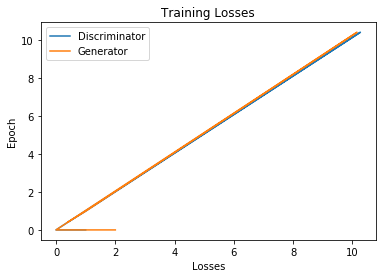

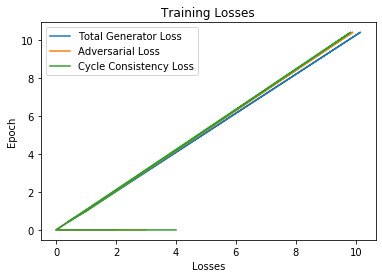

In [0]:
cycleGAN2 = cygan()
cycleGAN2.train(lambda_val = 15,epochs = 20)
cycleGAN2.losses.remove([])
cycleGAN2.show_losses()
cycleGAN2.show_glosses()

In [0]:
cycleGAN3 = cygan()
cycleGAN3.train(lambda_val = 1,epochs = 20)


30171136/30168306 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


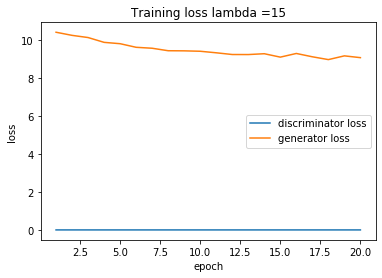

In [0]:
# cycleGAN2.losses.remove([])
x = [xi[0]+1 for xi in cycleGAN2.losses]
y = [xi[1] for xi in cycleGAN2.losses]
z = [xi[2] for xi in cycleGAN2.losses]
# zz = [xi[3] for xi in cycleGAN1.losses]
plt.plot(x,y,label='discriminator loss')
plt.plot(x,z,label='generator loss')
# plt.plot(x,zz,label='cycle consistency loss')
plt.legend()
plt.title('Training loss lambda =15')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Loss15.png')

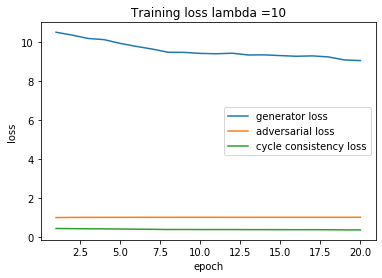

In [0]:
x = [xi[0]+1 for xi in cycleGAN3.losses]
y = [xi[2] for xi in cycleGAN3.losses]
z = [xi[3] for xi in cycleGAN3.losses]
zz = [xi[4] for xi in cycleGAN3.losses]
plt.plot(x,y,label='generator loss')
plt.plot(x,z,label='adversarial loss')
plt.plot(x,zz,label='cycle consistency loss')
plt.legend()
plt.title('Training loss lambda =1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Loss1gen.png')

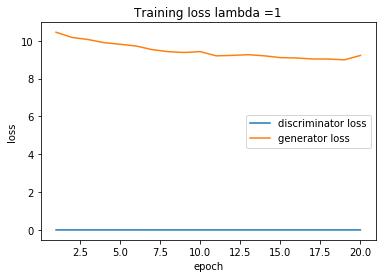

In [0]:
cycleGAN3.losses.remove([])
x = [xi[0]+1 for xi in cycleGAN3.losses]
y = [xi[1] for xi in cycleGAN3.losses]
z = [xi[2] for xi in cycleGAN3.losses]
# zz = [xi[3] for xi in cycleGAN1.losses]
plt.plot(x,y,label='discriminator loss')
plt.plot(x,z,label='generator loss')
# plt.plot(x,zz,label='cycle consistency loss')
plt.legend()
plt.title('Training loss lambda =1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Loss1.png')

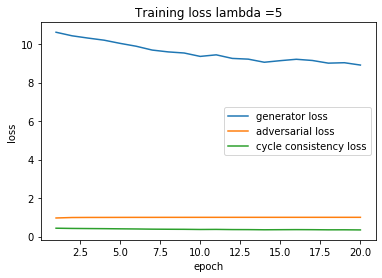

In [0]:
x = [xi[0]+1 for xi in cycleGAN1.losses]
y = [xi[2] for xi in cycleGAN1.losses]
z = [xi[3] for xi in cycleGAN1.losses]
zz = [xi[4] for xi in cycleGAN1.losses]
plt.plot(x,y,label='generator loss')
plt.plot(x,z,label='adversarial loss')
plt.plot(x,zz,label='cycle consistency loss')
plt.legend()
plt.title('Training loss lambda =5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Loss5gen.png')

In [0]:
from google.colab import files
!zip -r cycleganimages.zip /content/cycleganimages


updating: content/cycleganimages/ (stored 0%)
updating: content/cycleganimages/lambda_10_7_100.png (deflated 0%)
updating: content/cycleganimages/lambda_10_6_0.png (deflated 0%)
updating: content/cycleganimages/lambda_10_16_0.png (deflated 1%)
updating: content/cycleganimages/lambda_10_9_350.png (deflated 1%)
updating: content/cycleganimages/lambda_10_7_150.png (deflated 0%)
updating: content/cycleganimages/lambda_10_5_200.png (deflated 1%)
updating: content/cycleganimages/lambda_10_19_350.png (deflated 1%)
updating: content/cycleganimages/lambda_10_18_100.png (deflated 1%)
updating: content/cycleganimages/lambda_10_18_50.png (deflated 1%)
updating: content/cycleganimages/lambda_10_17_100.png (deflated 1%)
updating: content/cycleganimages/lambda_10_5_100.png (deflated 0%)
updating: content/cycleganimages/lambda_10_12_0.png (deflated 1%)
updating: content/cycleganimages/lambda_10_4_250.png (deflated 1%)
updating: content/cycleganimages/lambda_10_5_250.png (deflated 1%)
updating: content

In [0]:
cycleGAN3.losses

NameError: ignored

In [0]:
files.download('cycleganimages.zip')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 60308, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil